Step 1: Imports and Setup

In [19]:
# Standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import pandas as pd
import gc  # For memory management in batch processing

# Image processing
import imageio.v2 as imageio  # avoids deprecation warnings
from IPython.display import Image, Video, display

# Your project-specific modules
from src.config import VOXEL_SIZE, ORGANELLES
from src.reconstruction import build_3d_scene, render_orbit_video
from src.utils import get_file_paths, get_centroid
from src.spatial_metrics import compute_spatial_metrics, find_roi_file
from src.tracking import run_tracking_pipeline, visualize_tracking
from src.metrics import compute_organelle_metrics

## Step 1: Configure Paths & Parameters
Configure these variables before running any analysis:

In [32]:
# ========================================
# ⬇️ CONFIGURE: Edit these paths as needed
# ========================================
stack_dir = "/Users/ariellerothman/Desktop/Full Sperm cell Stacks"  # Directory with TIFF stacks
output_dir = "/Users/ariellerothman/Desktop/Full Sperm cell Stacks"  # Where to save outputs
base_dir = stack_dir
sperm_id = 16  # Which sperm cell to analyze

os.makedirs(output_dir, exist_ok=True)

# Update organelle paths to this sperm cell stack
objects = []
for org in ORGANELLES:
    name = org["name"]
    new_org = org.copy()
    new_org["path"] = os.path.join(stack_dir, f"{name}_stack_1.tif")
    objects.append(new_org)

## Step 2: (Optional) Single-Cell Workflow Example
**Use this section to analyze ONE sperm cell in detail.**
(For batch processing multiple cells, skip to the batch processing section below.)

### Step 2a: Run Tracking Conversions

In [ ]:
# === Specify which sperm cell ===
# This converts TrackMate CSV files to long format for watershed segmentation
file_paths = get_file_paths(sperm_id=sperm_id, base_dir=stack_dir, registered=True)
cell_dir = base_dir

for organelle in ["MO", "mitochondria"]:
    print(f"\n🔍 Processing tracking for: {organelle.upper()}")

    # Run pipeline: converts wide format CSV to long format for watershed
    long_csv_path = run_tracking_pipeline(
        cell_number=sperm_id,
        base_dir=base_dir,
        organelle=organelle,
        total_tracks=400
    )

    # Save to organized subfolder structure
    folder_map = {"MO": "MO tracking", "mitochondria": "Mito tracking"}
    tracking_dir = os.path.join(base_dir, f"Sperm {sperm_id}", folder_map[organelle])
    os.makedirs(tracking_dir, exist_ok=True)
    target_csv = os.path.join(tracking_dir, "temp_long.csv")
    shutil.move(long_csv_path, target_csv)
    
    print(f"✅ Saved final long CSV to: {target_csv}")

# === Visualize only frames with tracks ===
tiff_path = file_paths["mitochondria"]  # path to the TIFF stack for this organelle
csv_path = target_csv                    # path to the just-saved CSV
visualize_tracking(tiff_path, csv_path)

### Step 2b: Compute All Organelle Metrics

In [ ]:
# === Set sperm cell ID ===
sample_id = f"sperm_{sperm_id}"
file_paths = get_file_paths(sperm_id=sperm_id, base_dir=base_dir, registered=True)

# === Output folder ===
output_dir = os.path.join(base_dir, f"Sperm {sperm_id}", "Organellar_Measures")
os.makedirs(output_dir, exist_ok=True)

# === Get reference centroids (for distance calculations) ===
pseudopod_centroid = get_centroid(file_paths["pseudopod"])
nucleus_centroid   = get_centroid(file_paths["nucleus"])

# === Organelle input spec: (name, path_to_stack, optional_tracking_csv) ===
# Tracking CSVs are provided for mitochondria and MO (which have multiple instances)
# Other organelles (pseudopod, nucleus, sperm_cell) are single objects, so no CSV
organelle_inputs = [
    ("mitochondria", file_paths["mitochondria"], file_paths.get("mito_csv")),
    ("MO", file_paths["MO"], file_paths.get("mo_csv")),
    ("pseudopod", file_paths["pseudopod"], None),
    ("nucleus", file_paths["nucleus"], None),
    ("sperm_cell", file_paths["sperm_cell"], None),
]

# === Run all metrics and save ===
all_metrics = []
for organelle_name, stack_path, csv_path in organelle_inputs:
    df = compute_organelle_metrics(
        organelle_name, stack_path, csv_path,
        pseudopod_centroid, nucleus_centroid, sample_id
    )
    all_metrics.append(df)

full_df = pd.concat(all_metrics, ignore_index=True)
metrics_path = os.path.join(output_dir, f"{sample_id}_all_metrics.csv")
full_df.to_csv(metrics_path, index=False)
print(f"✅ Metrics saved to: {metrics_path}")

✅ Metrics saved to: /Users/ariellerothman/Desktop/Sample 2/New testing data/Sperm 16/Organellar_Measures/sperm_16_all_metrics.csv


### Step 2c: Compute Spatial Metrics

Computes distances and angles relative to a reference point in the sample (e.g., spermatheca location).

In [ ]:
# ========================================
# ⬇️ CONFIGURE: Reference point (xyz coordinates in global image space)
# ========================================
# IMPORTANT: This reference point is defined in the FULL/GLOBAL image space
# The ROI file automatically converts sperm cell coordinates (from cropped images)
# back to global space, so they align with this reference point.
reference_point_xyz = [58, 1256, 2464]  # Spermathecal valve center [Z, Y, X] in voxels

paths = get_file_paths(sperm_id, base_dir, registered=True)
roi_path = find_roi_file(os.path.dirname(paths["sperm_cell"]))

# === Run computation ===
metrics = compute_spatial_metrics(
    sperm_cell_path=paths["sperm_cell"],
    pseudopod_path=paths["pseudopod"],
    nucleus_path=paths["nucleus"],
    roi_path=roi_path,
    reference_point_xyz=reference_point_xyz
)

# Convert metrics dict to DataFrame (one row)
metrics_df = pd.DataFrame([metrics])

# Define output path (inside Sperm cell folder)
excel_path = os.path.join(base_dir, f"Sperm {sperm_id}", "spatial_metrics.xlsx")

# Save to Excel
metrics_df.to_excel(excel_path, index=False)

print(f"✅ Spatial metrics saved to: {excel_path}")

# Optional: display metrics
from pprint import pprint
pprint(metrics)

### Step 2d: Build 3D Reconstruction & Render Orbit Video

In [ ]:
os.makedirs(output_dir, exist_ok=True)

# === Get full file paths using utility (unregistered for 3D reconstruction) ===
file_paths = get_file_paths(sperm_id, base_dir, registered=False)

# === Build organelle input for reconstruction ===
objects = []
for org in ORGANELLES:
    path = file_paths[org["name"]]
    if os.path.exists(path):
        new_obj = org.copy()
        new_obj["path"] = path
        objects.append(new_obj)
    else:
        print(f"⚠️ Missing file for {org['name']}: {path}")

# === Build 3D scene and render orbit video ===
output_dir = os.path.join(base_dir, f"Sperm {sperm_id}")
os.makedirs(output_dir, exist_ok=True)

try:
    print(f"🔨 Building 3D scene for Sperm {sperm_id}...")
    plotter = build_3d_scene(
        objects=objects,
        voxel_size=VOXEL_SIZE,
        sperm_mask_path=file_paths["sperm_cell"]  # Pass sperm cell mask path to restrict organelles
    )

    video_path = os.path.join(output_dir, f"Sperm_{sperm_id}_rotation.gif")
    print(f"🎬 Rendering orbit video (this may take 1-2 minutes)...")
    render_orbit_video(plotter, output_path=video_path)
    print(f"✅ 3D reconstruction video saved to: {video_path}")

    # === Display the video in notebook ===
    if os.path.exists(video_path):
        print(f"\n📹 Video preview:")
        display(Image(filename=video_path))
    else:
        print(f"⚠️  Video file was not created at {video_path}")
        
except ValueError as e:
    print(f"\n❌ Video rendering failed: {str(e)}")
    print("   Troubleshooting tips:")
    print("   1. Check that all organelle TIFF files exist in the correct directory")
    print("   2. Verify that TIFF files contain valid binary mask data")
    print("   3. Try running the diagnostic cell to check file paths")
except Exception as e:
    print(f"\n❌ Unexpected error during 3D reconstruction: {str(e)[:100]}")
    import traceback
    traceback.print_exc()

### Step 2e: Visualize Tracking Overlays (Optional)
**View and save tracking point overlays to verify tracking quality.**

Generating tracking overlays for Sperm 16...

Processing mitochondria...


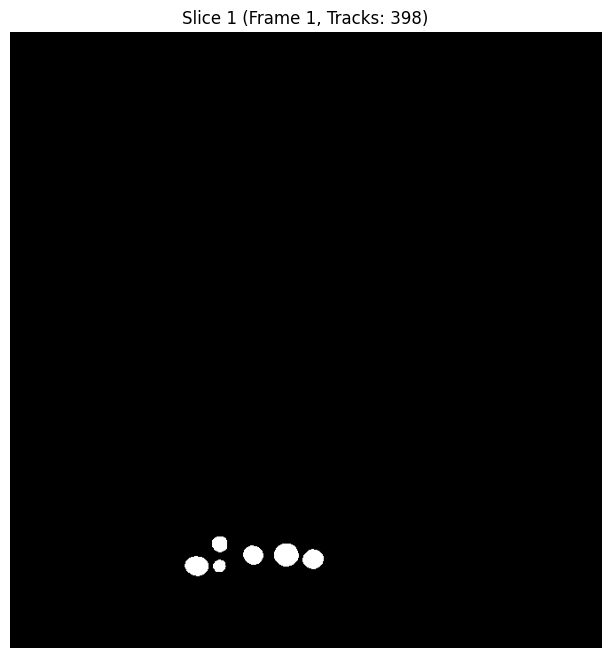

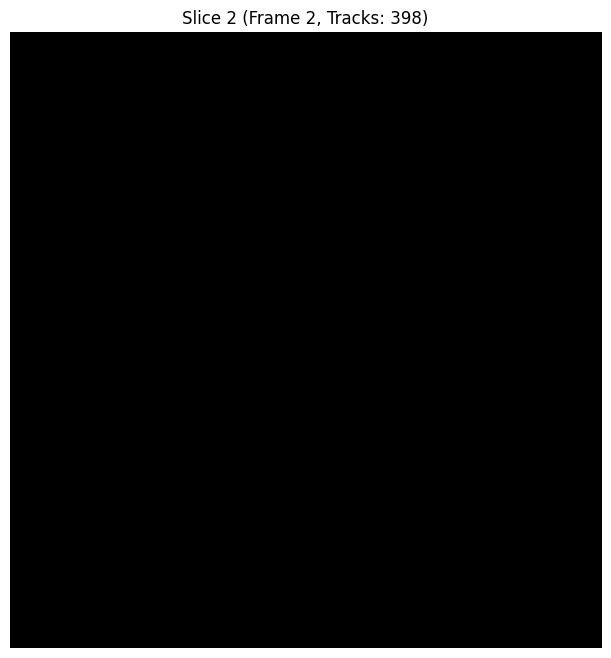

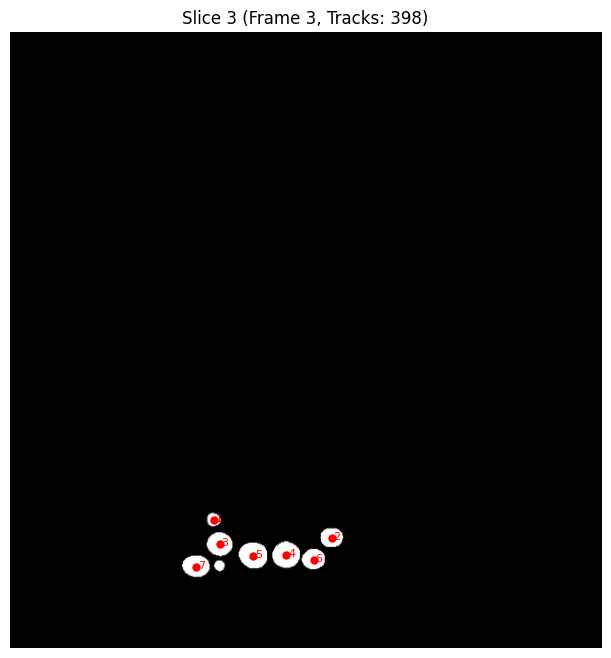

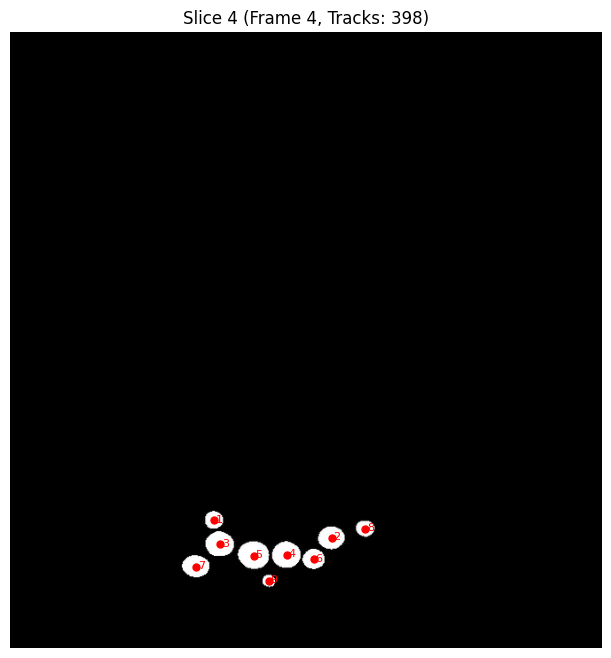

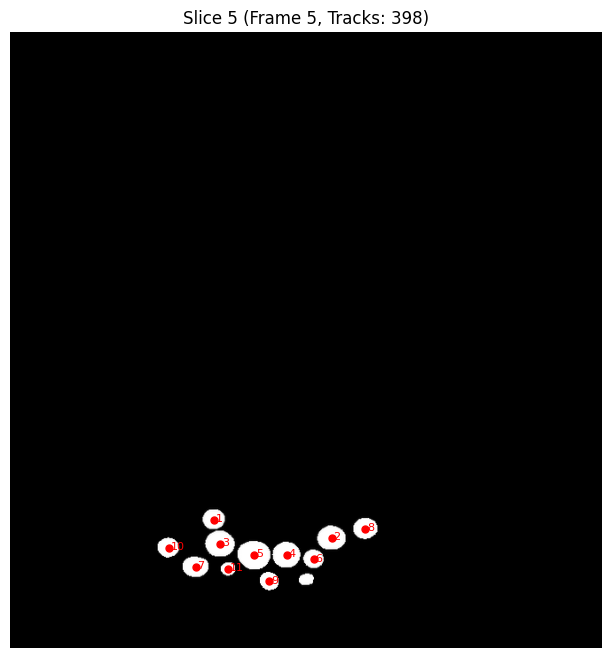

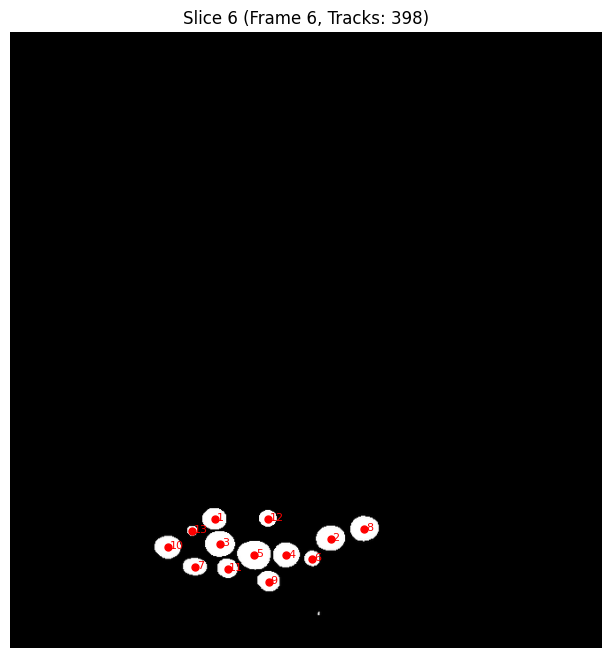

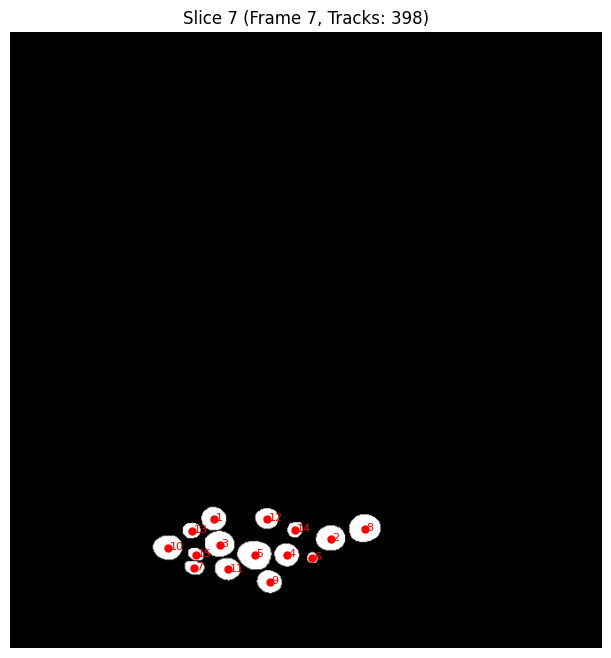

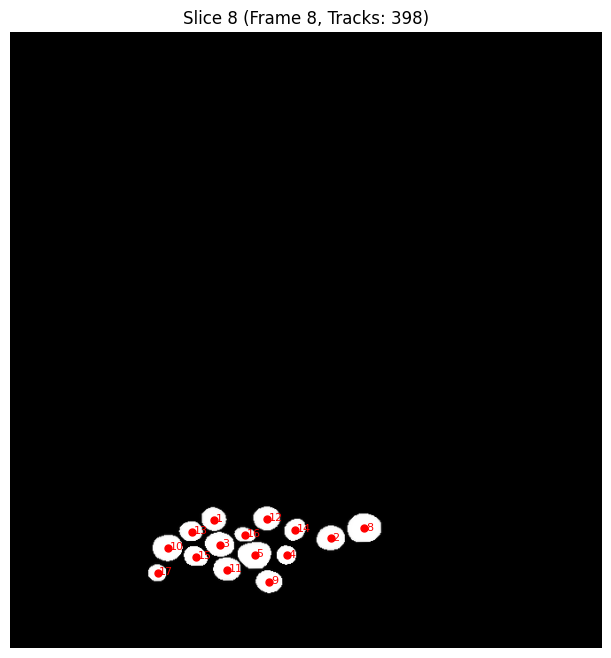

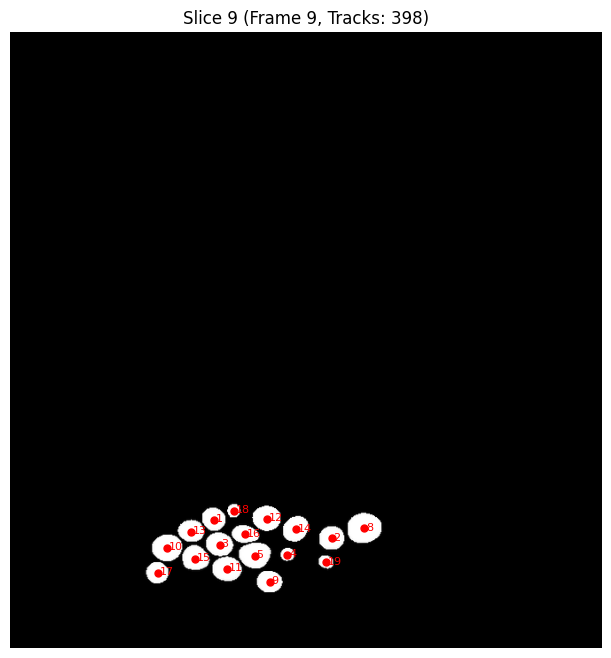

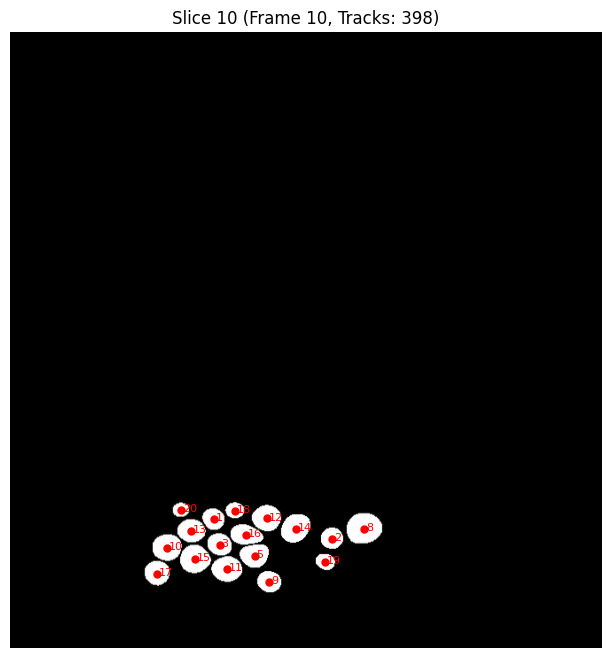

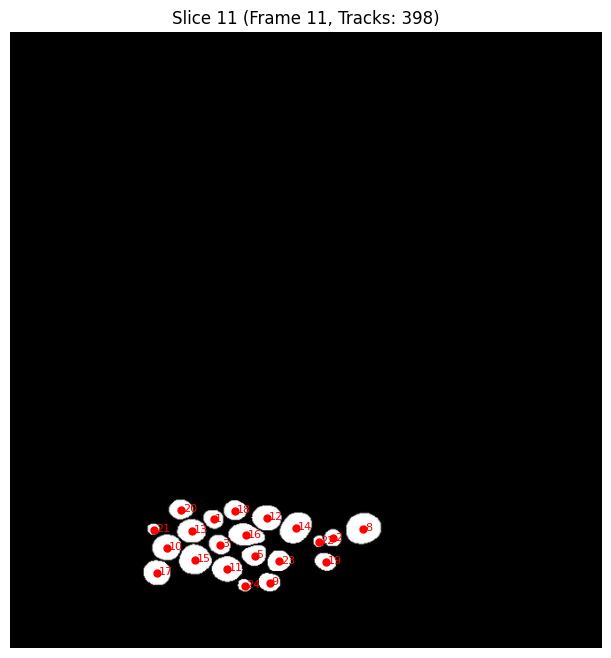

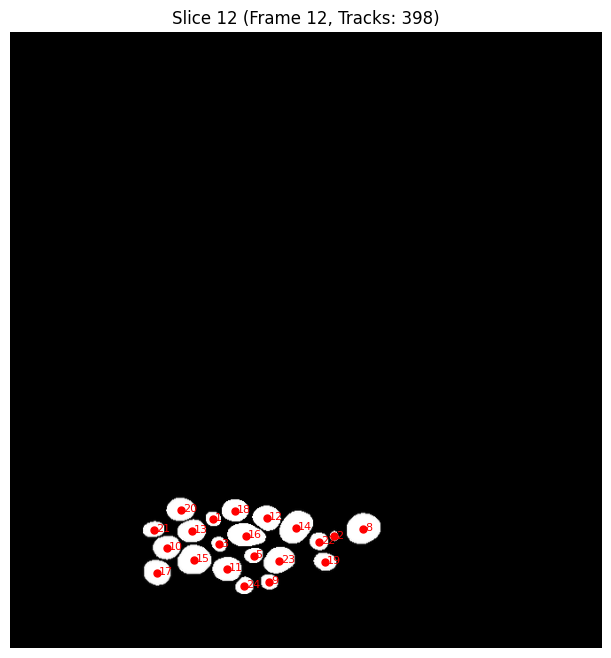

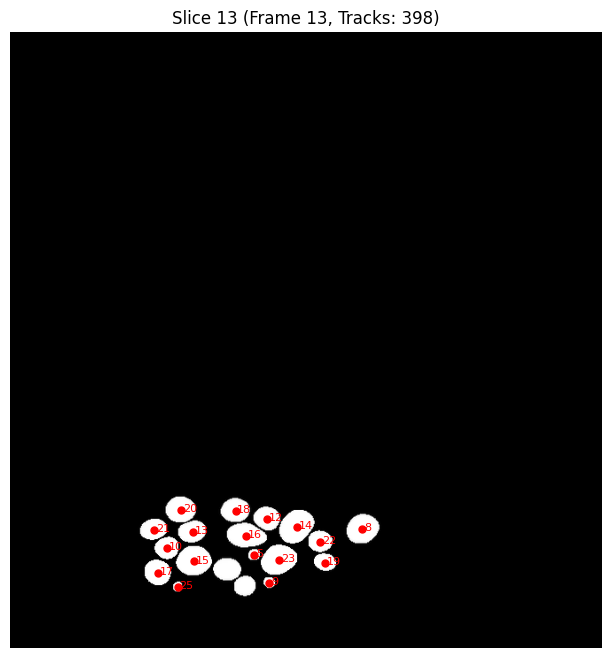

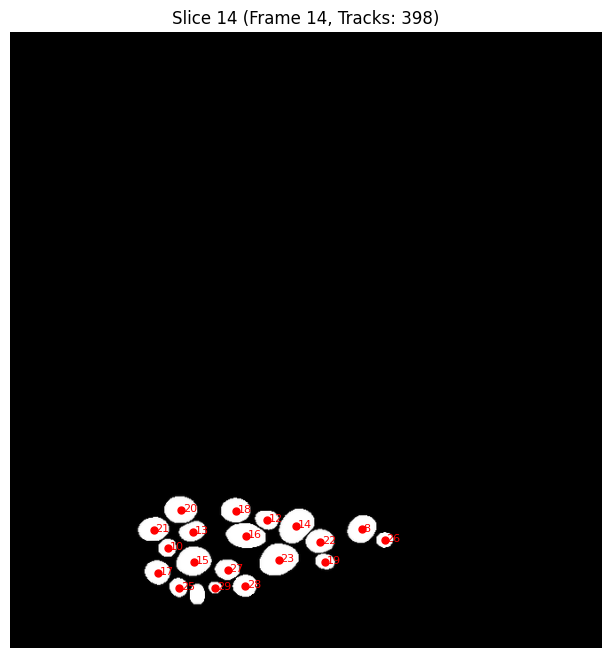

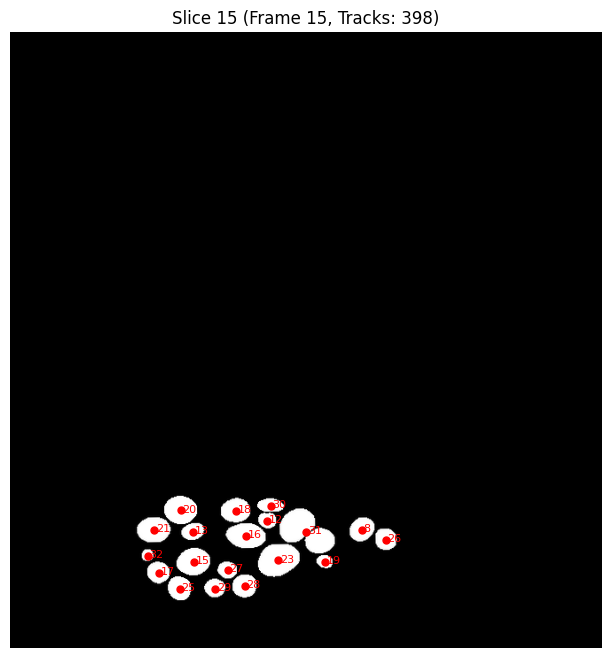

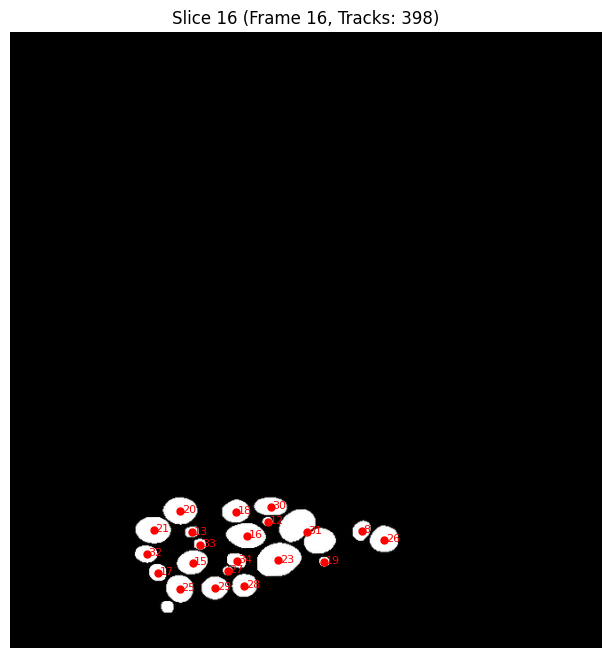

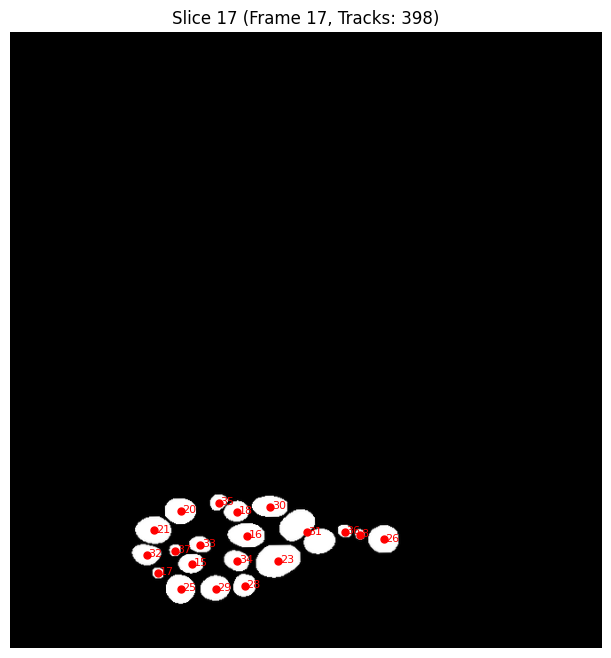

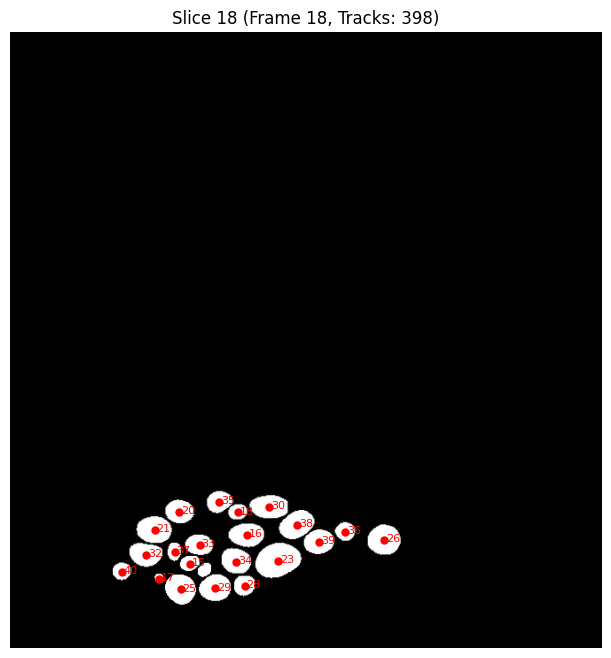

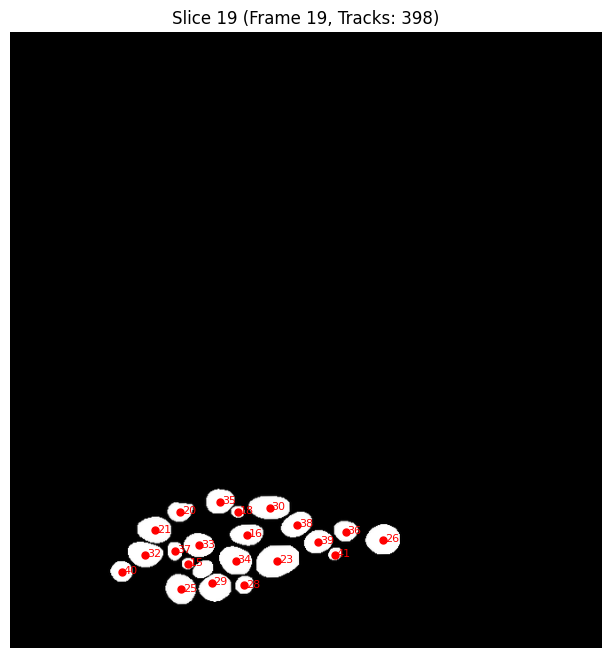

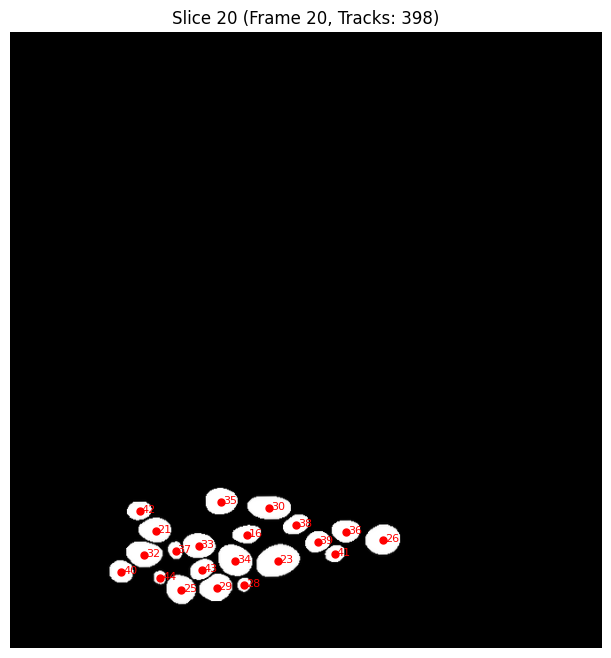

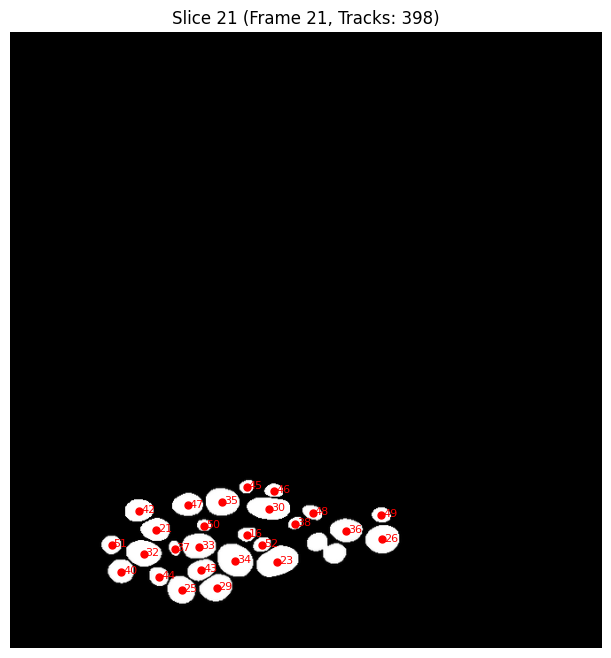

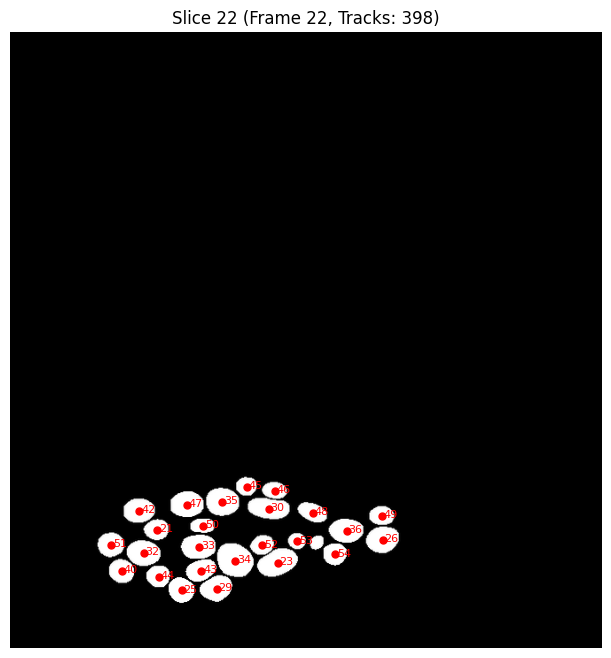

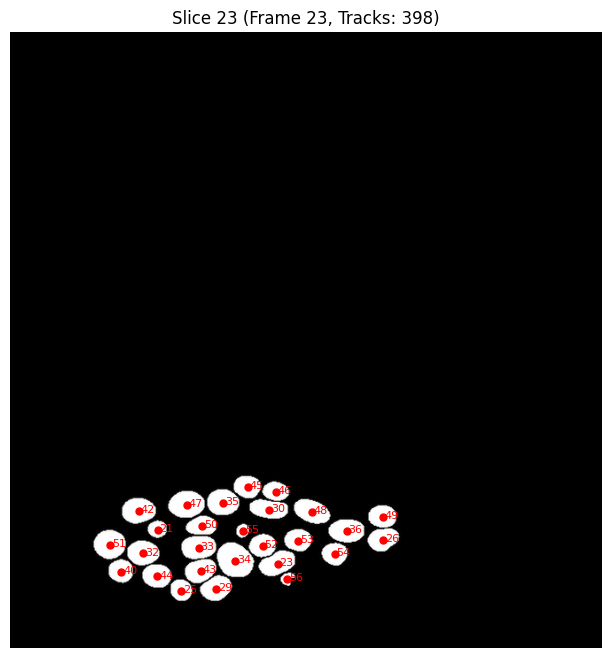

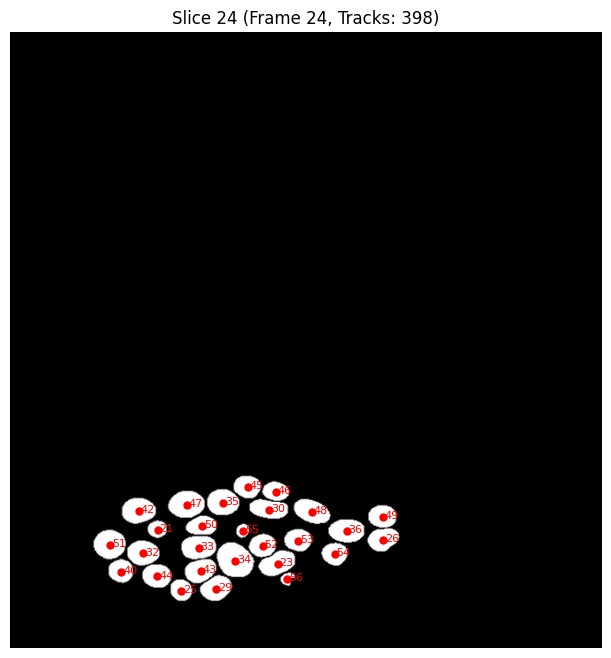

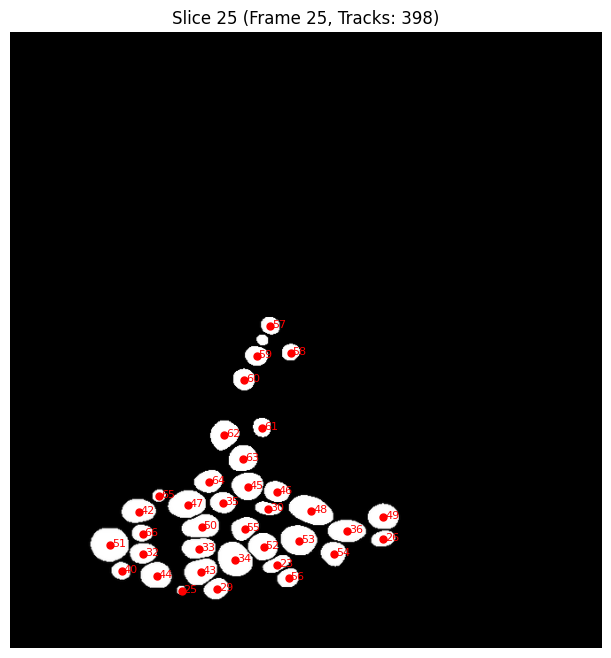

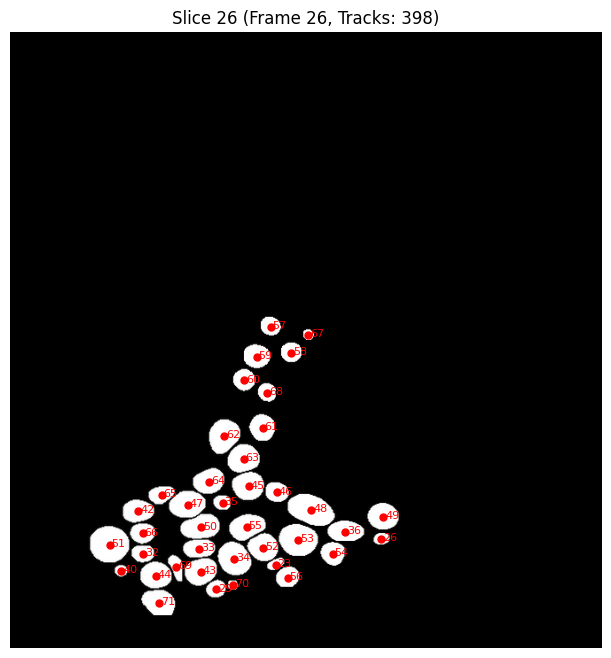

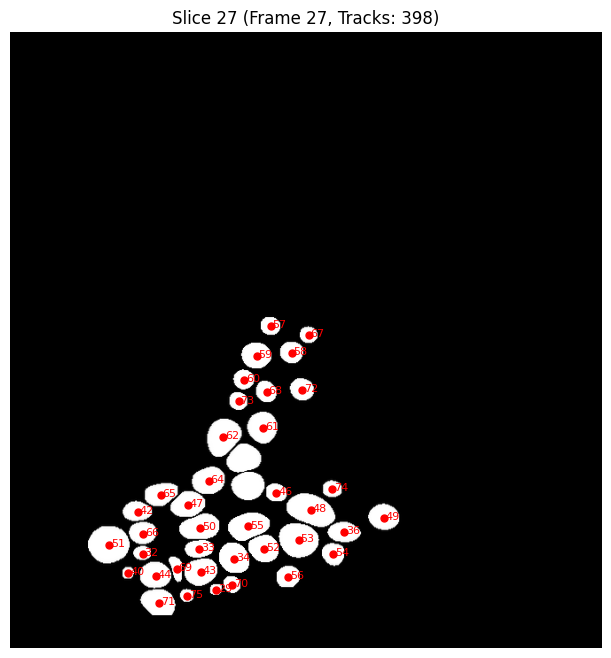

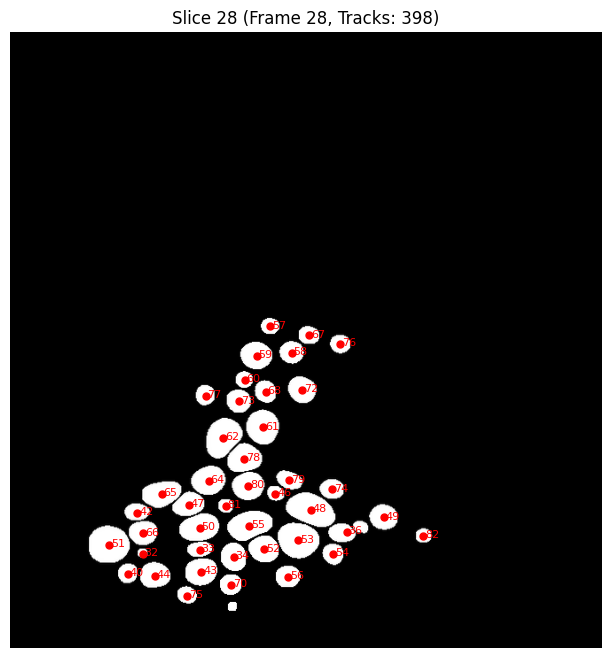

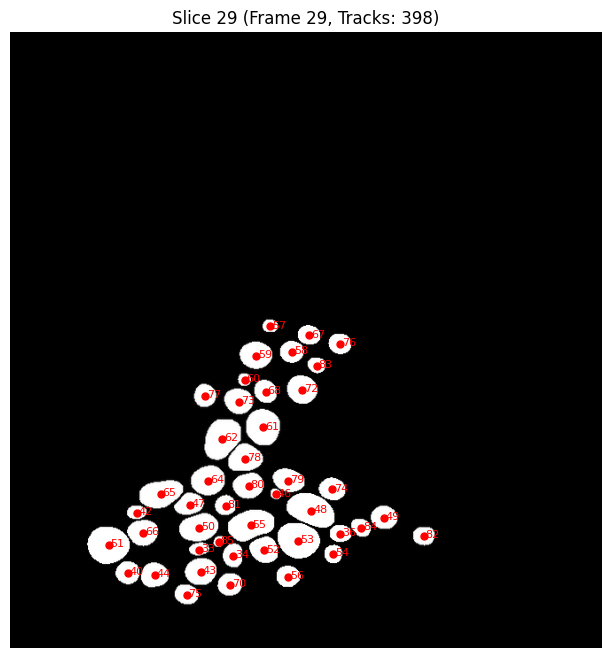

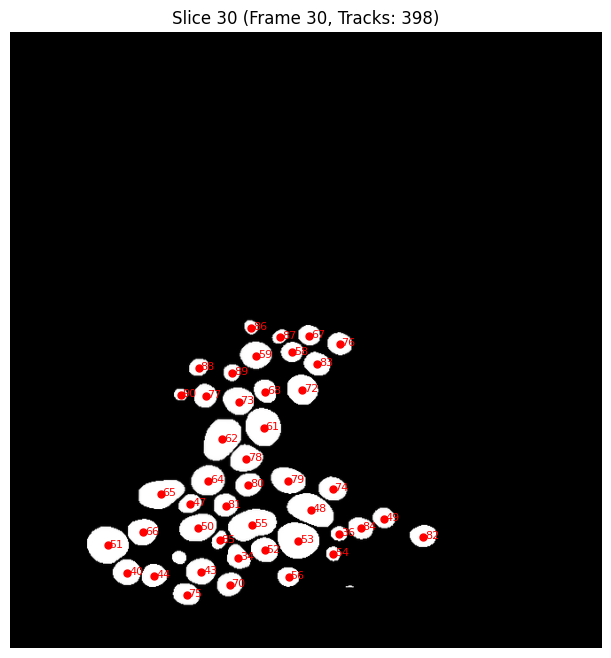

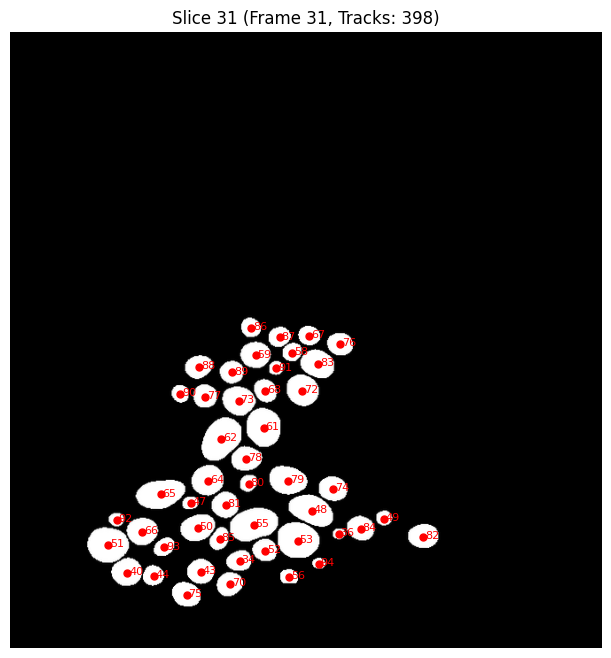

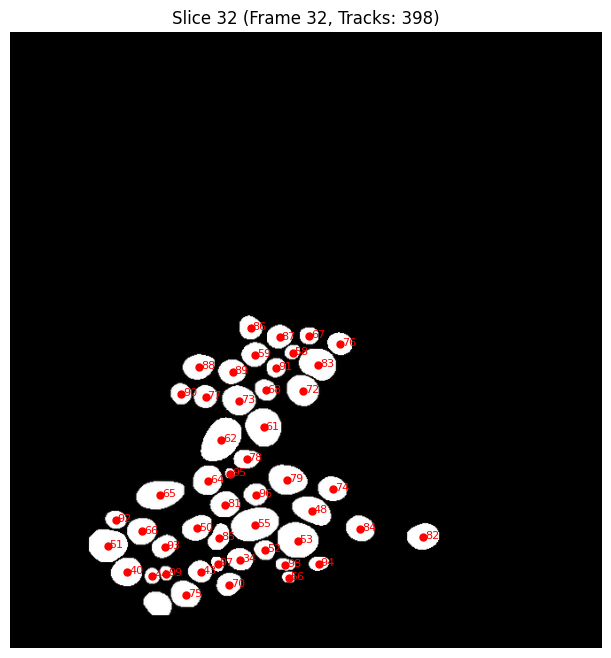

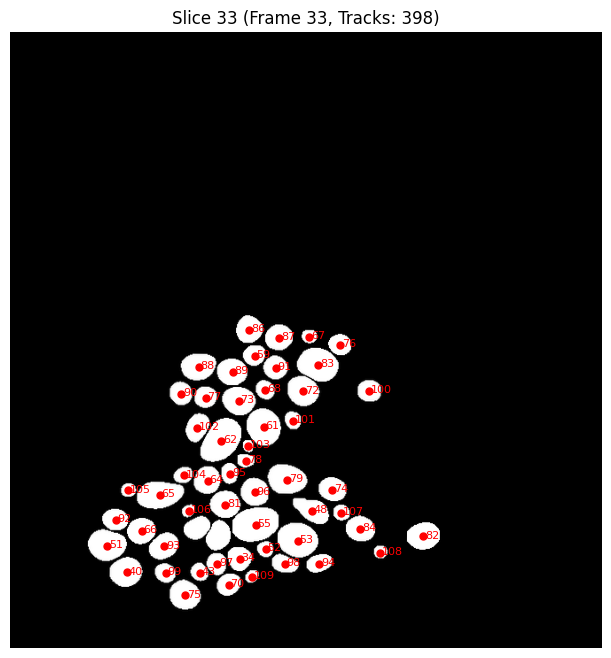

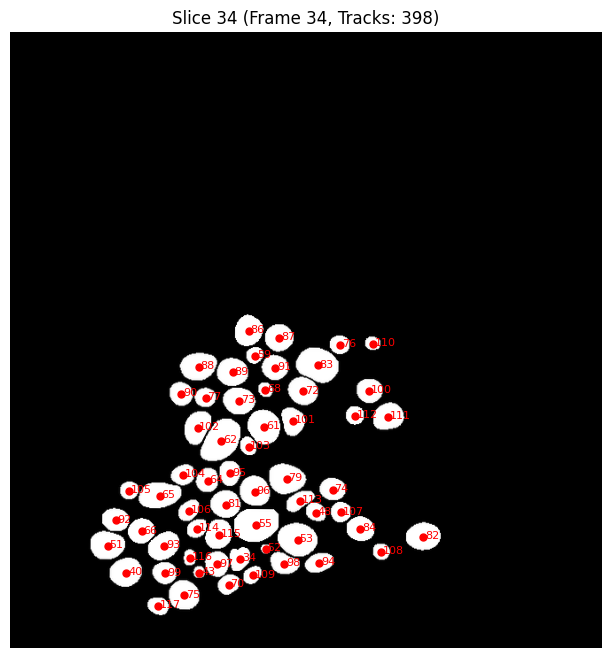

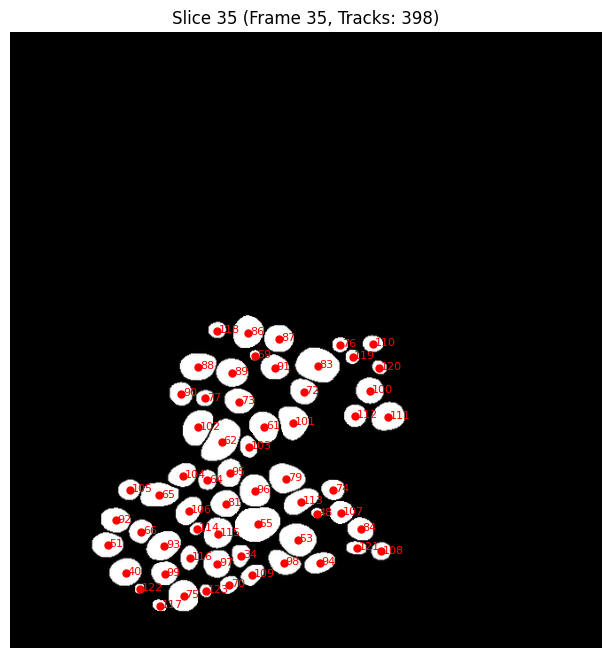

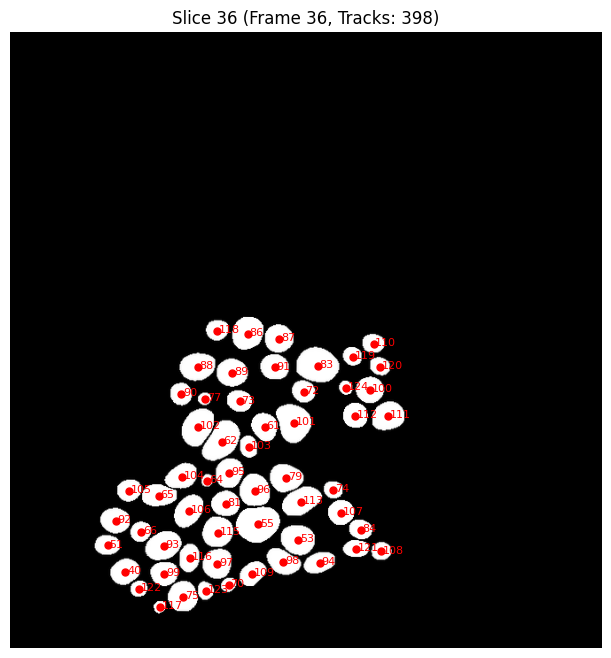

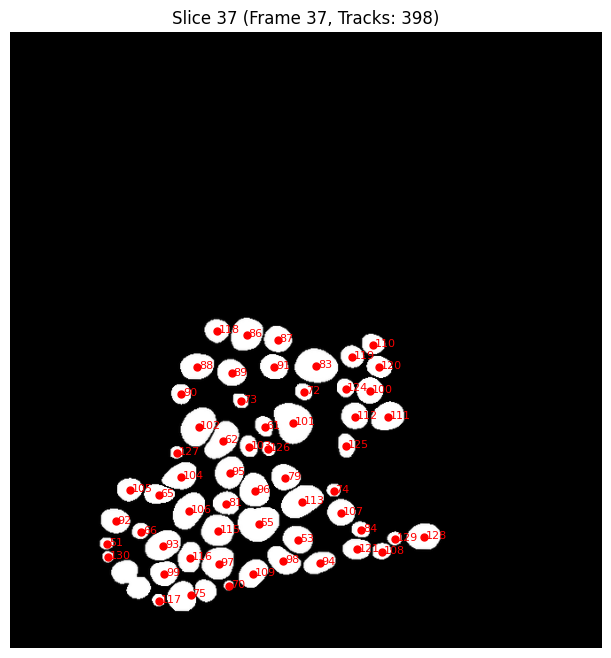

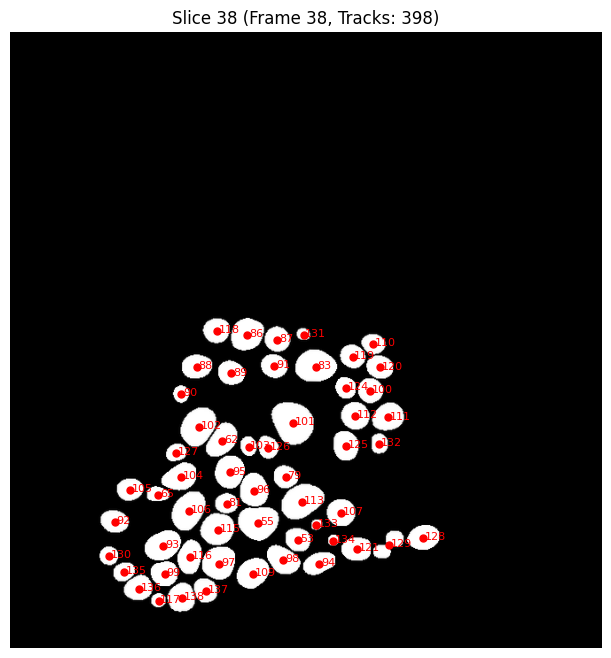

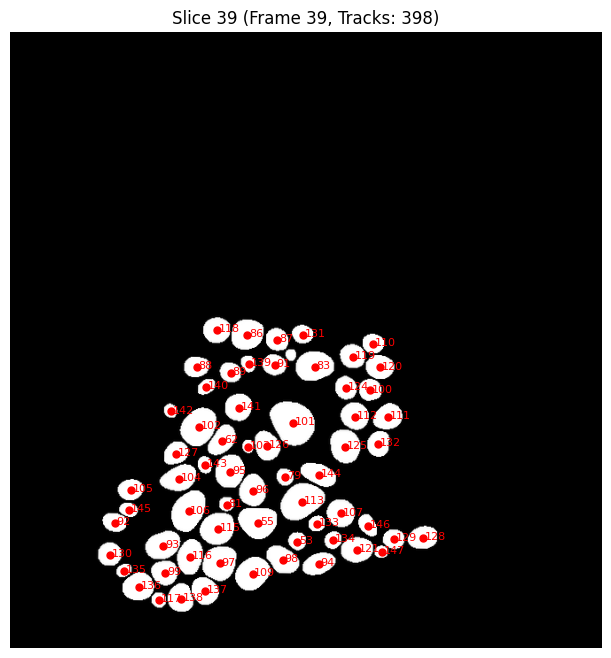

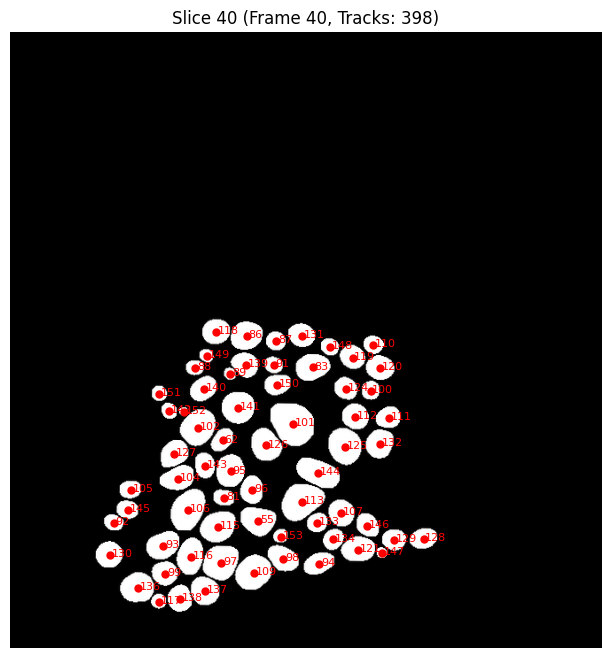

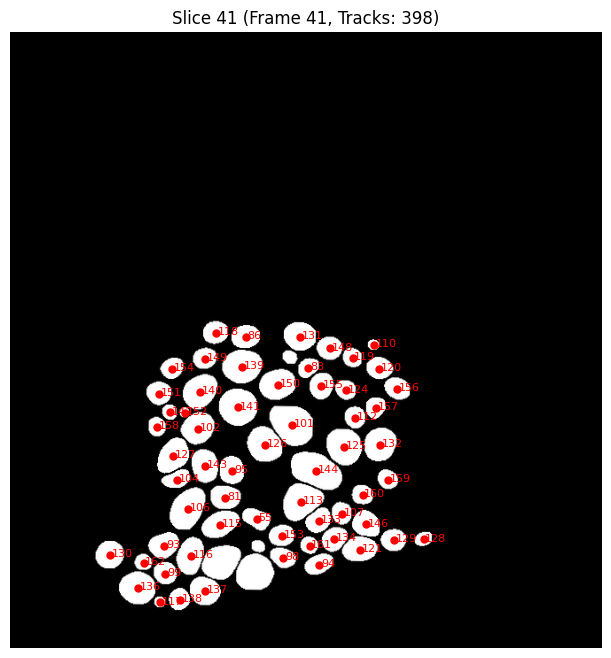

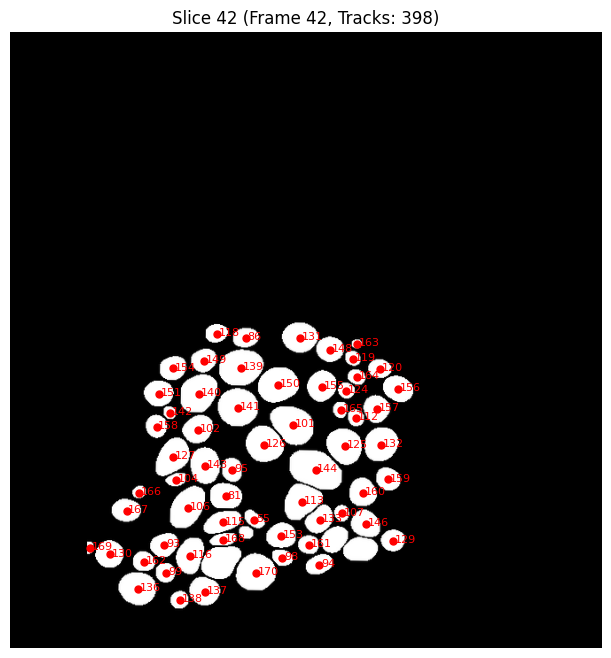

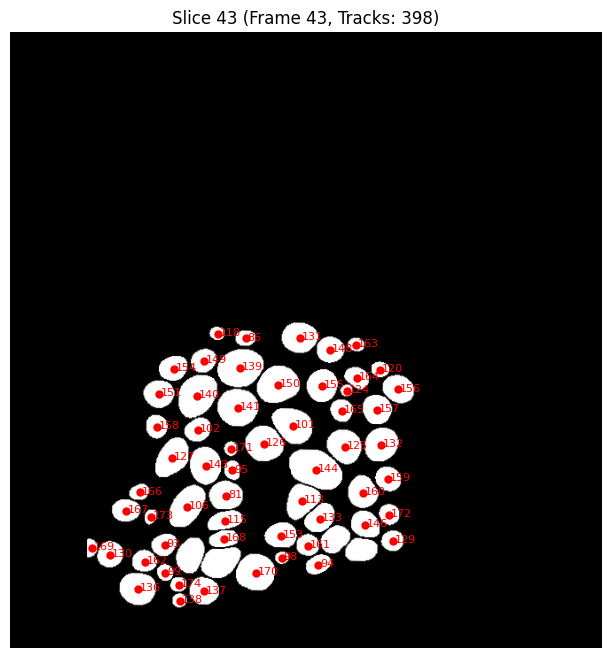

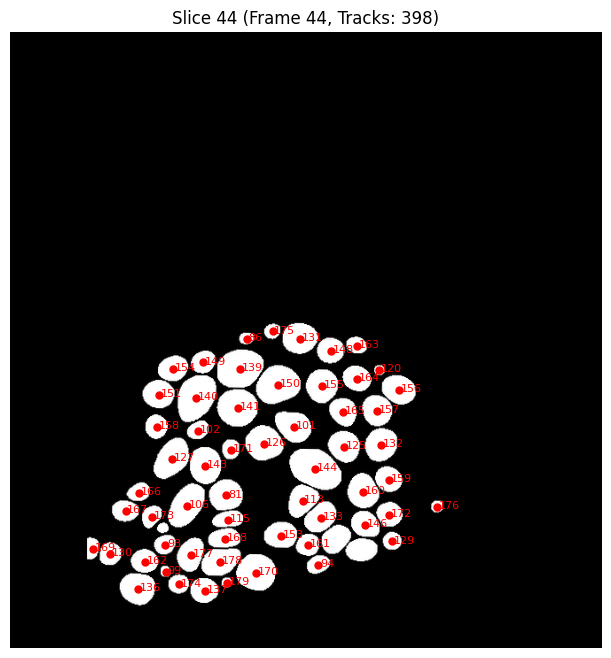

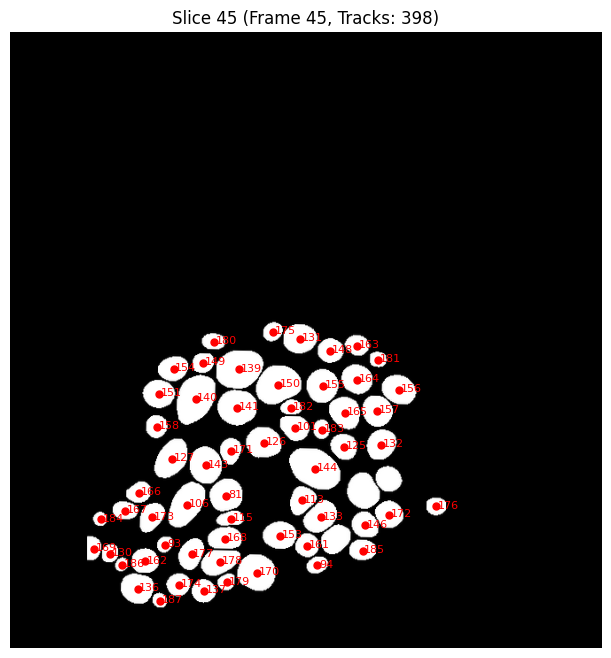

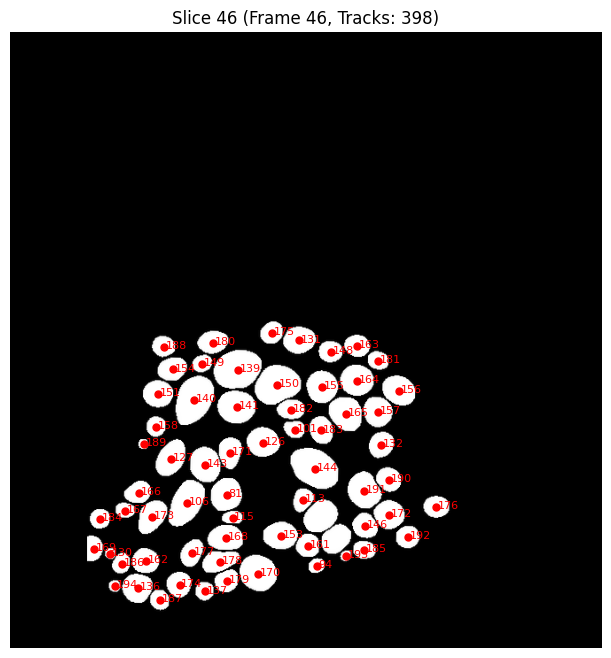

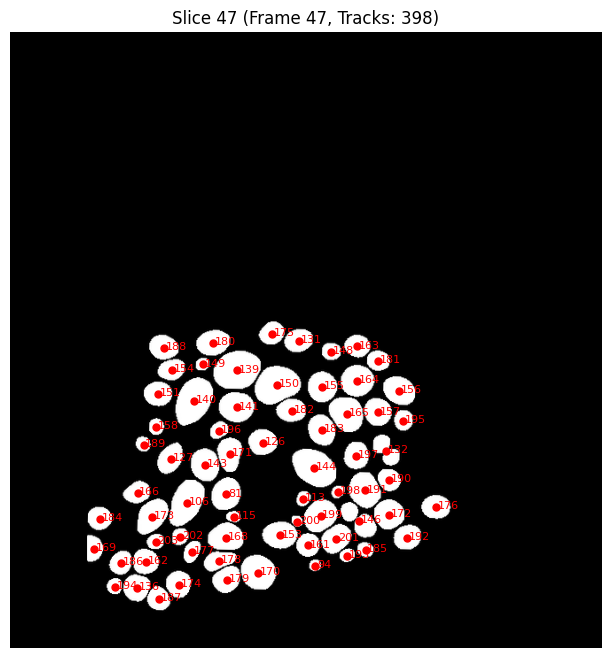

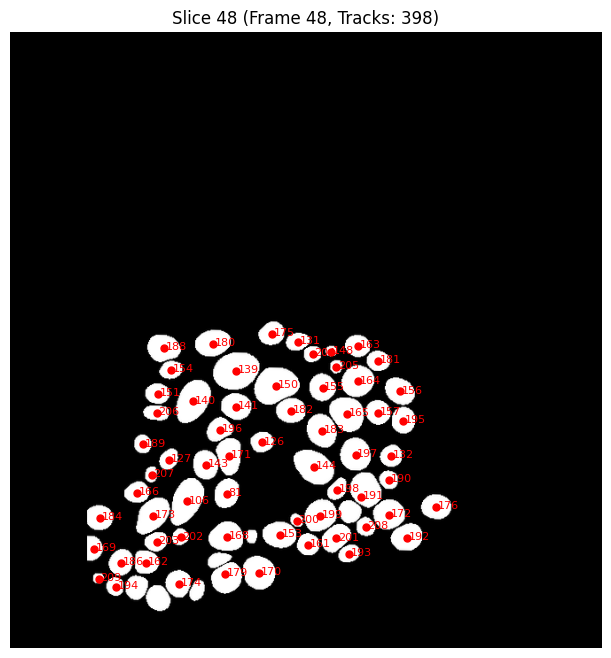

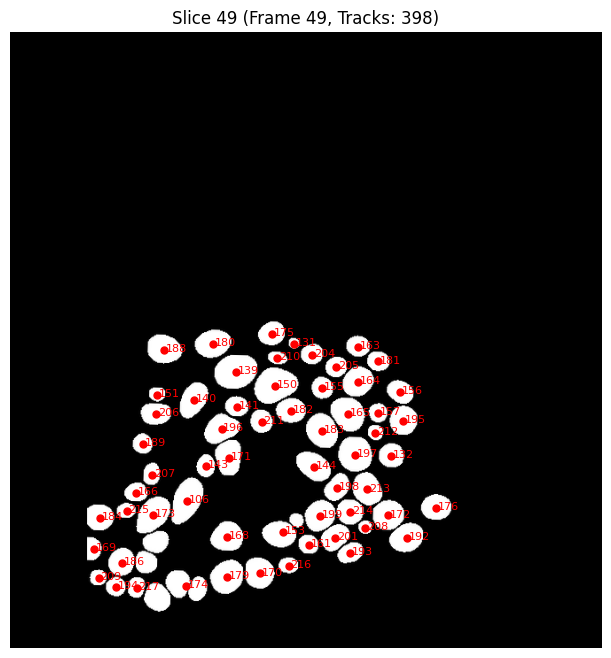

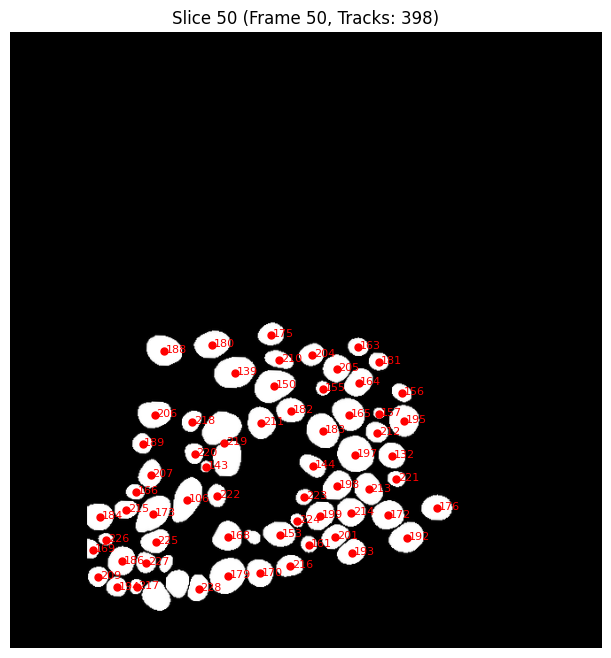

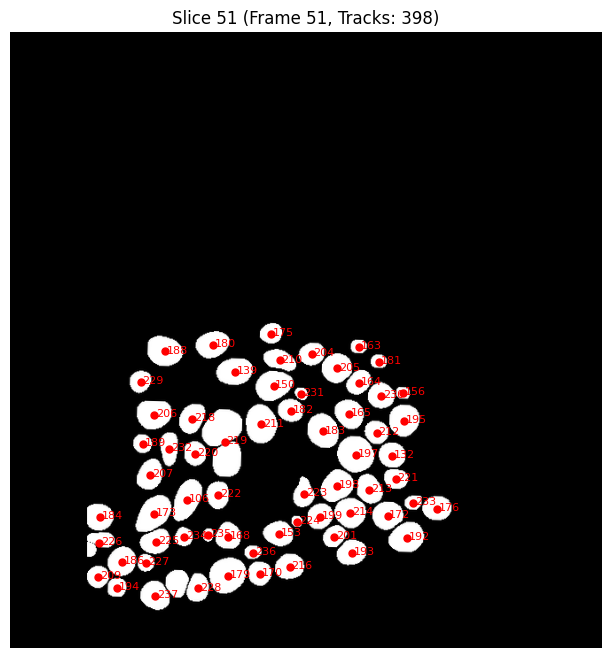

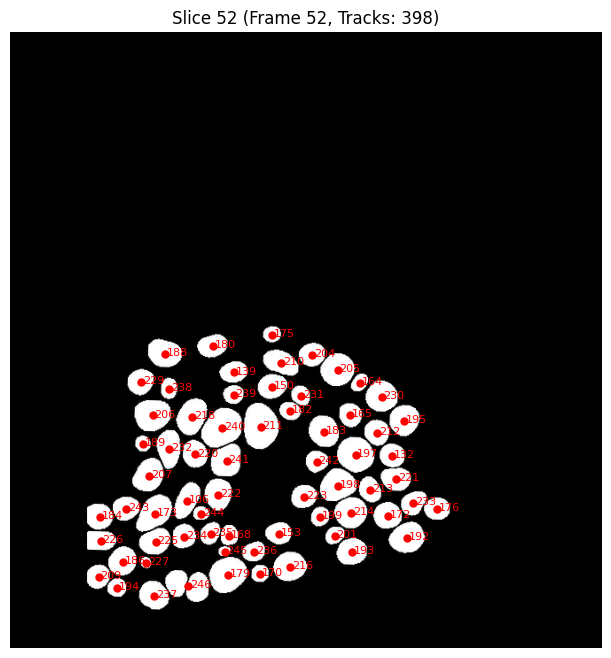

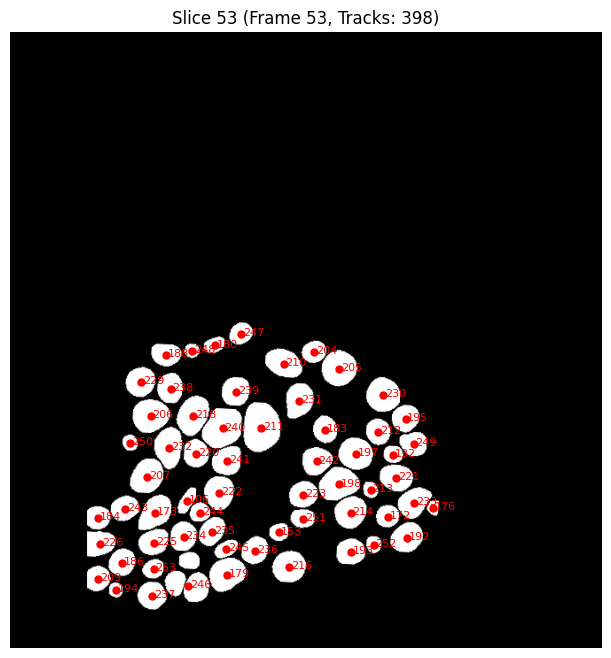

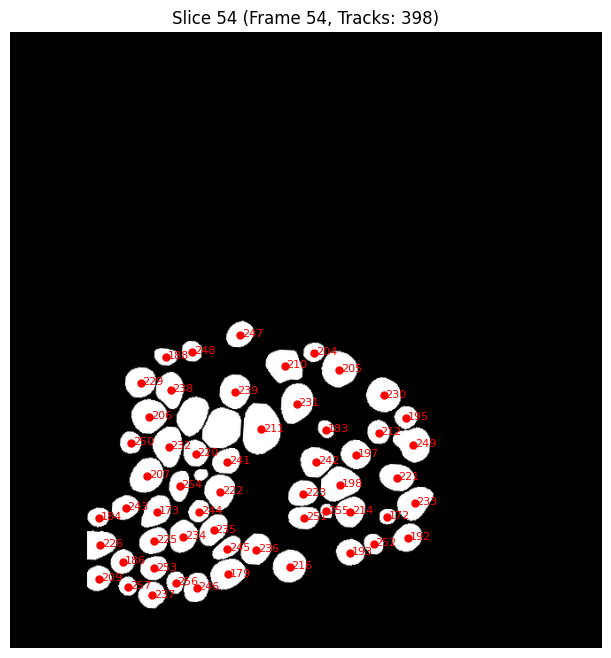

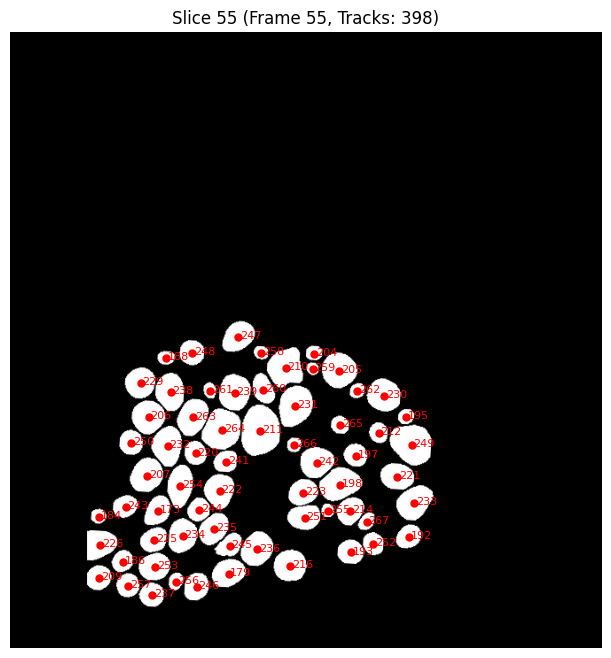

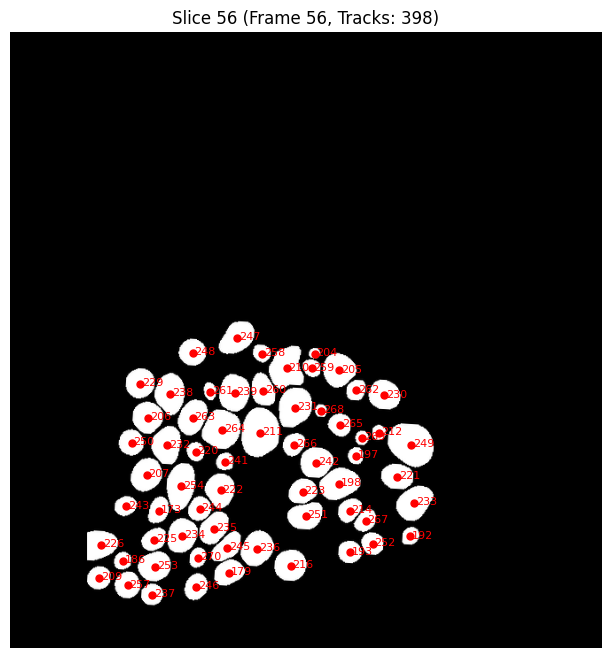

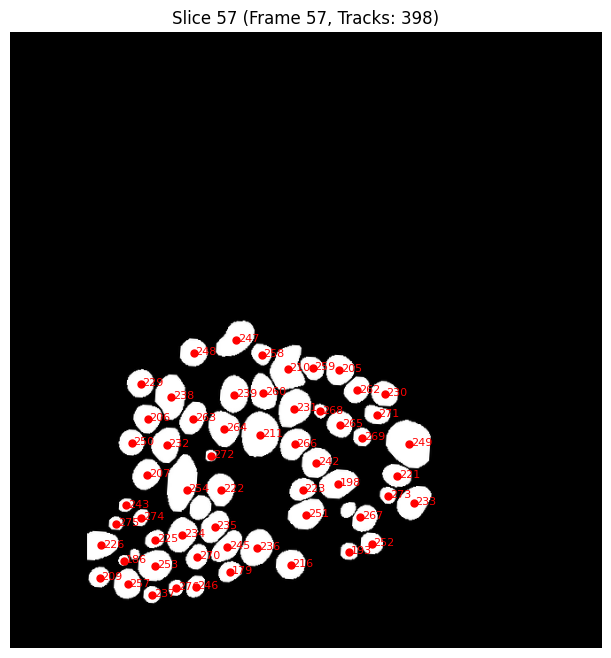

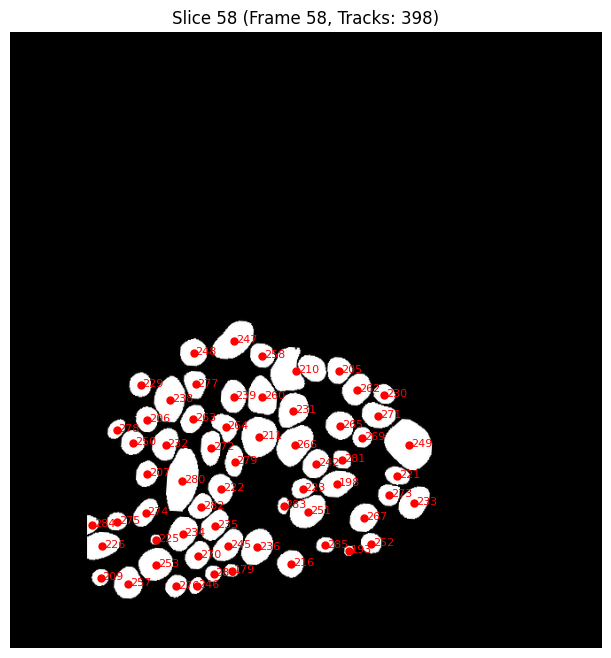

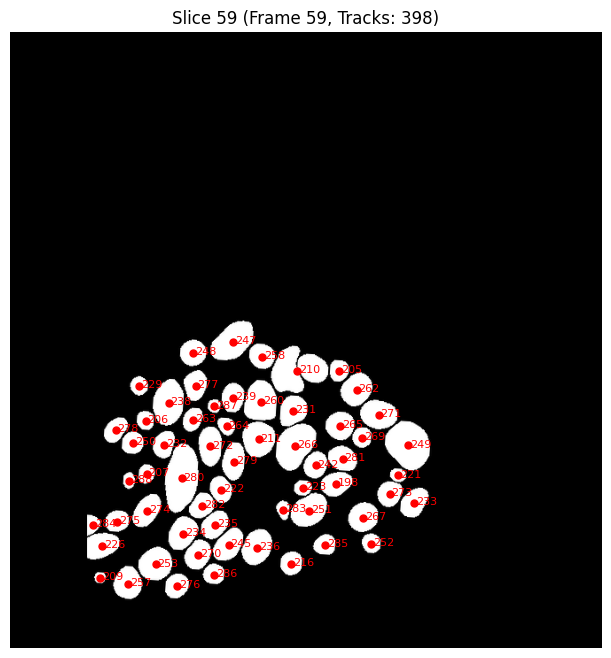

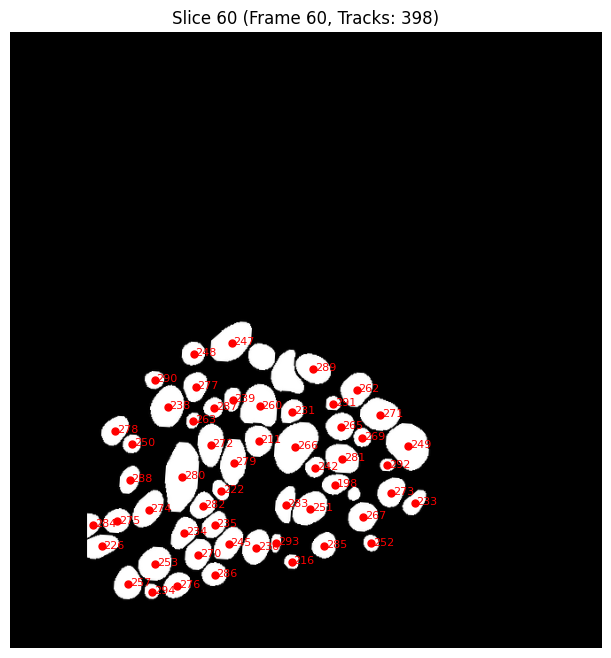

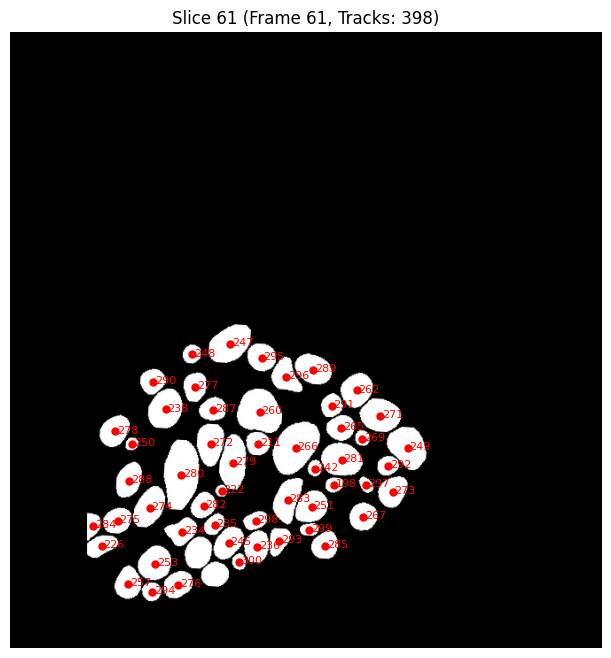

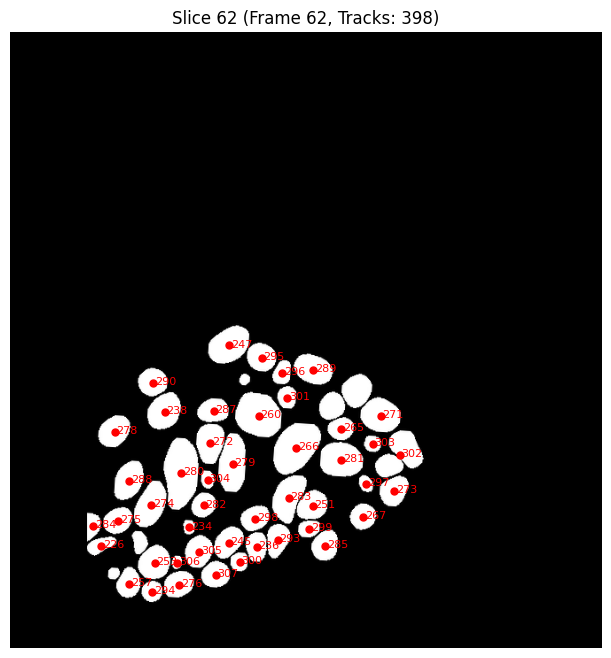

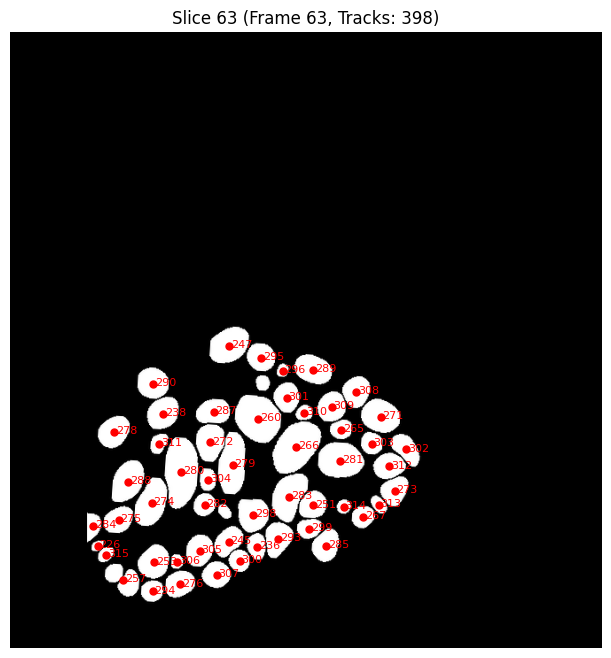

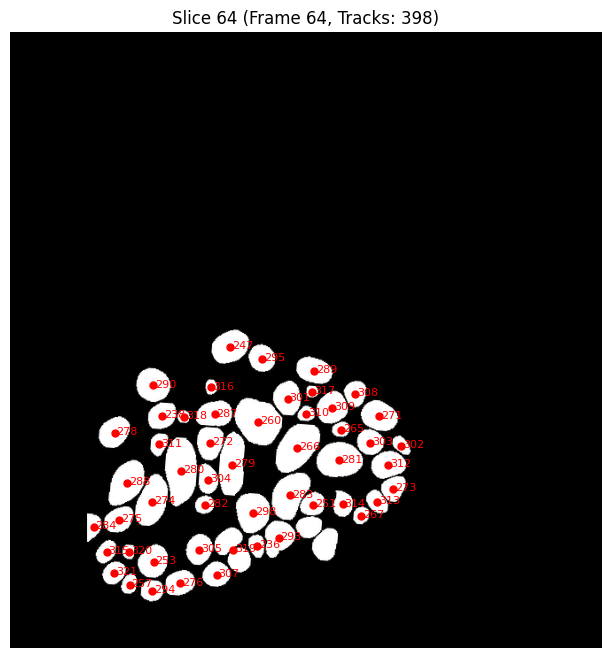

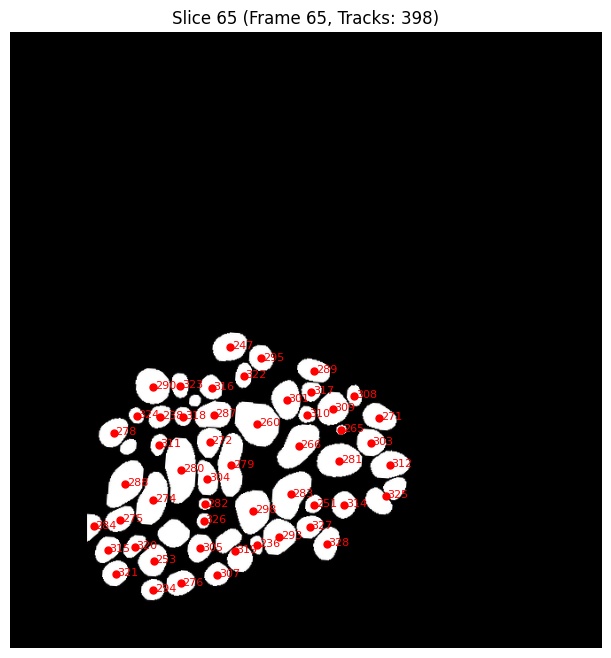

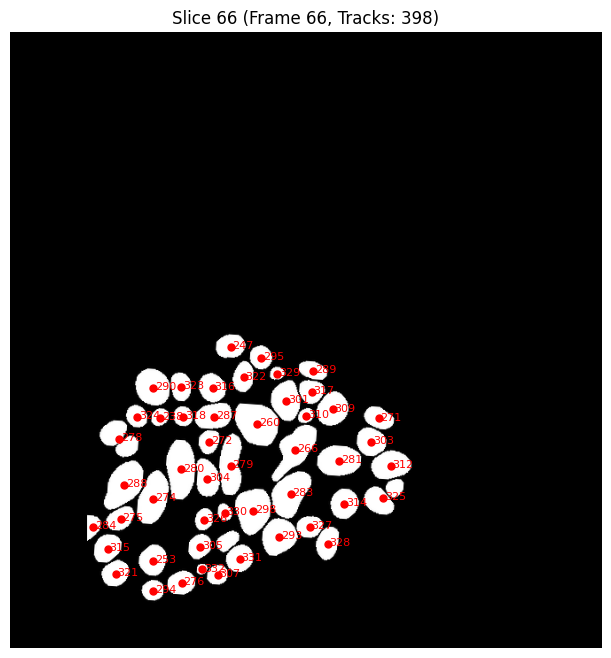

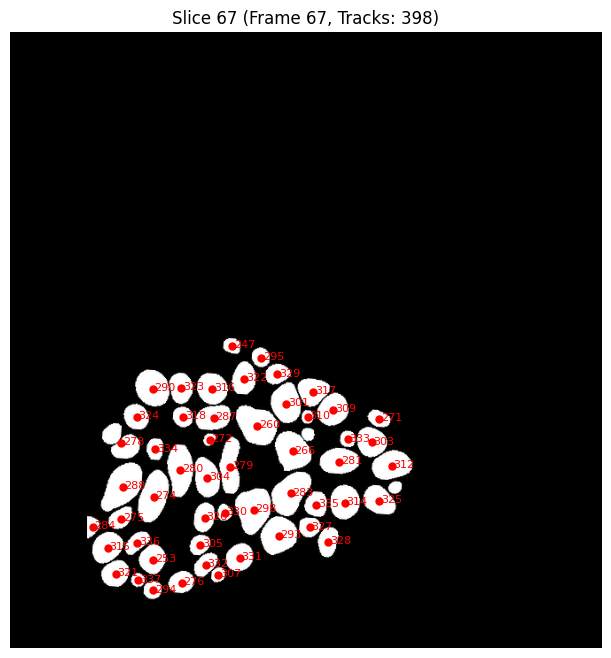

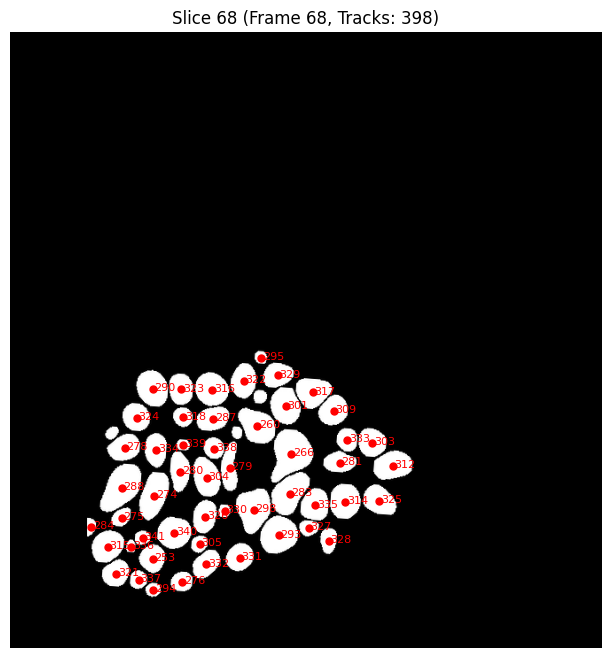

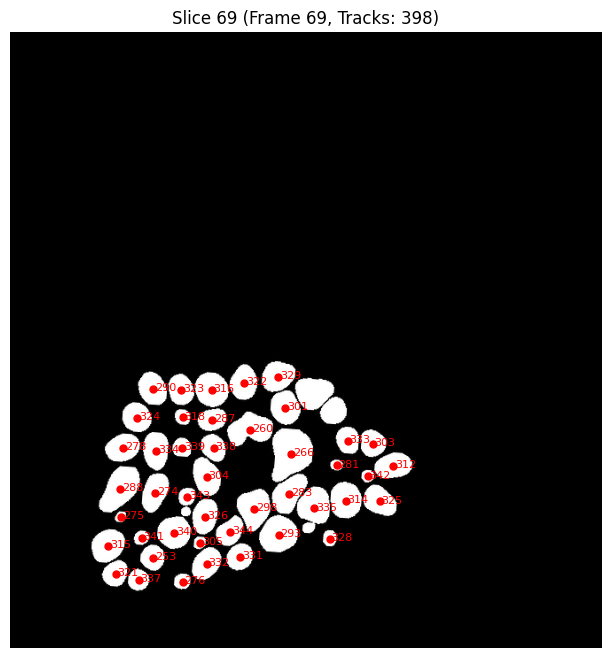

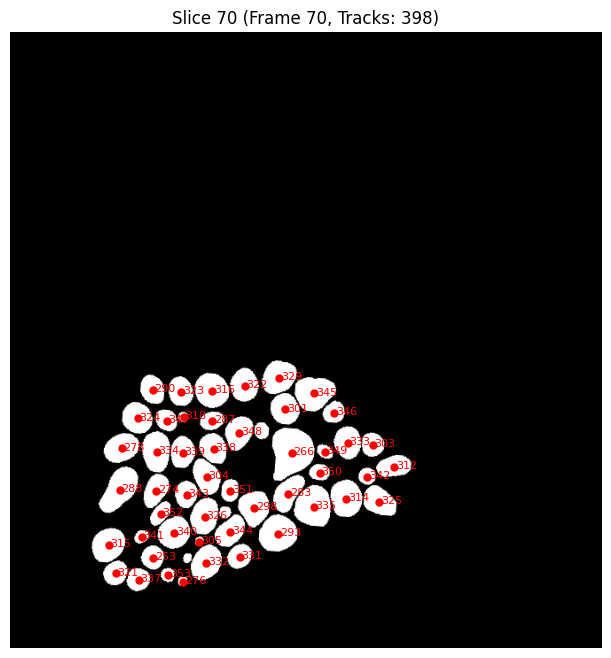

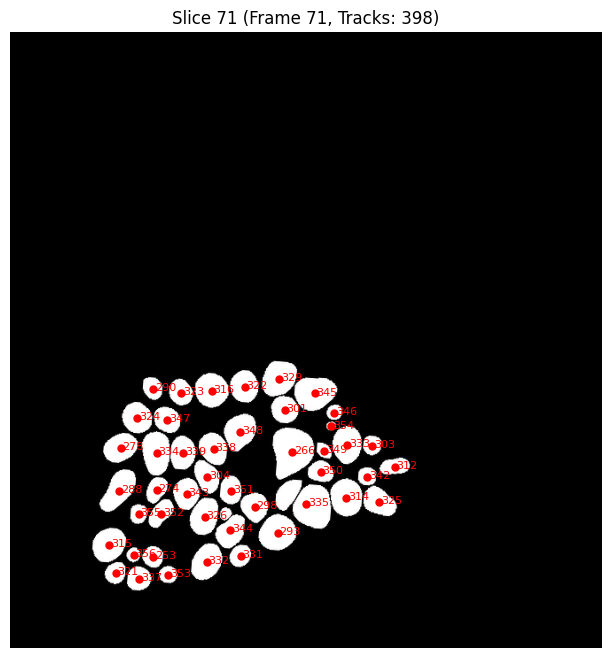

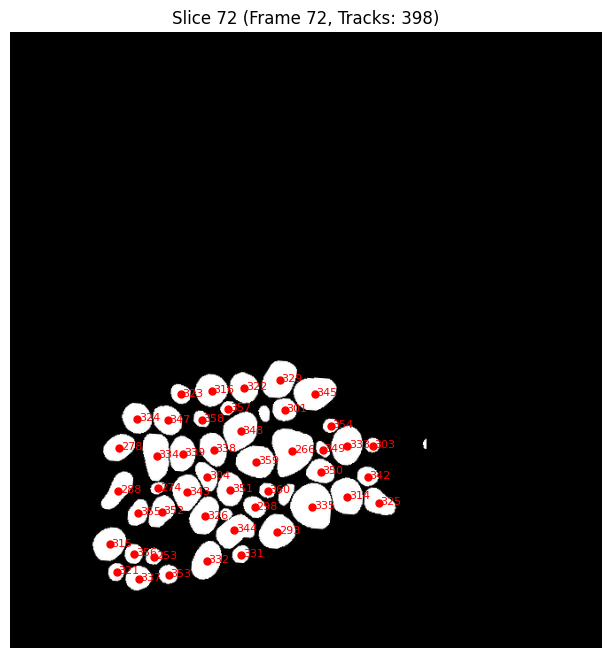

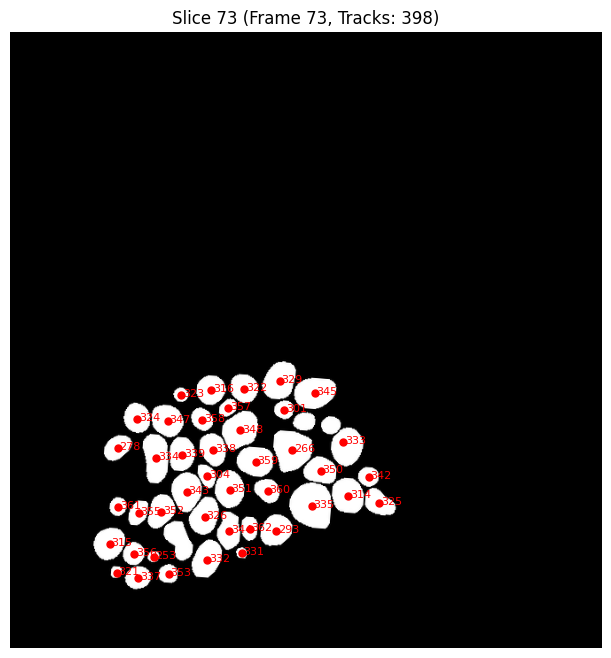

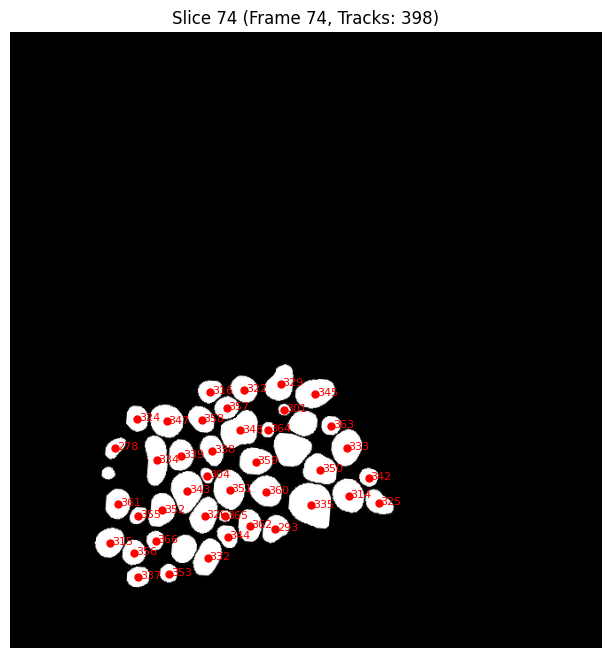

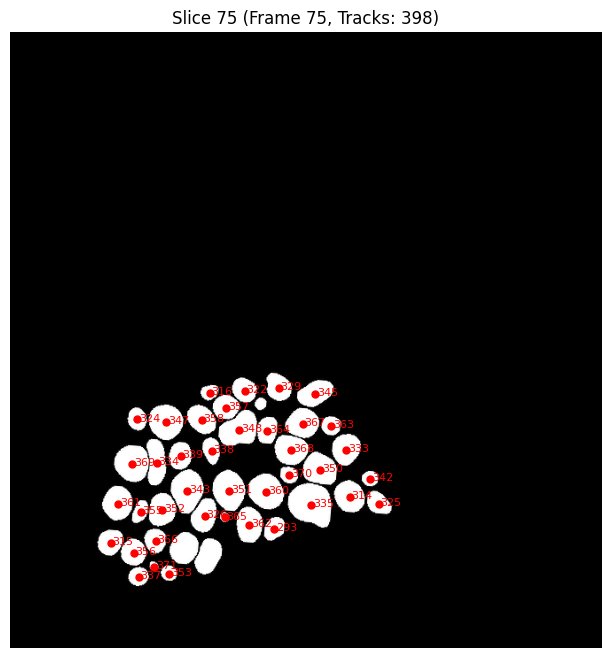

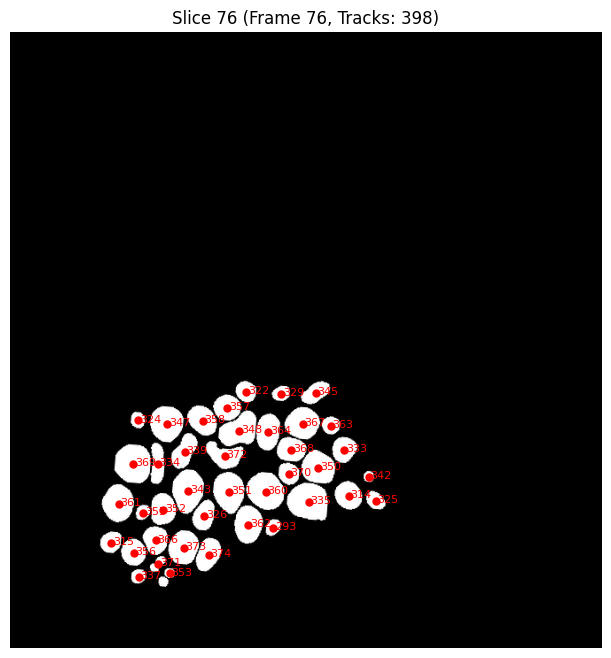

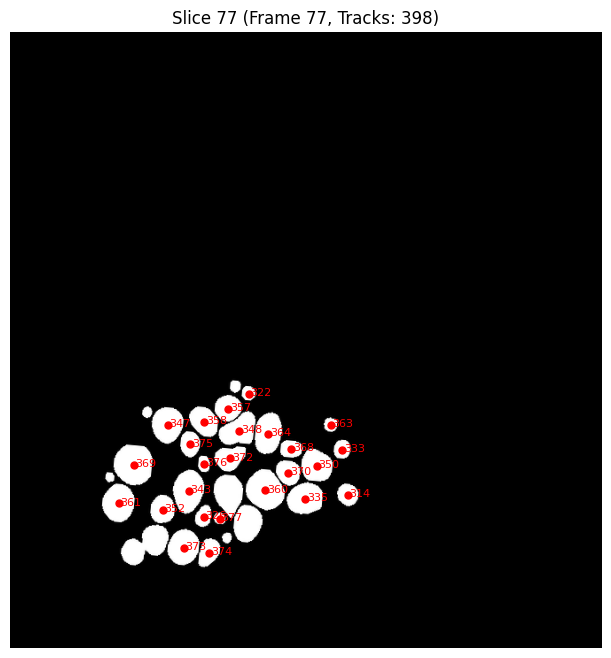

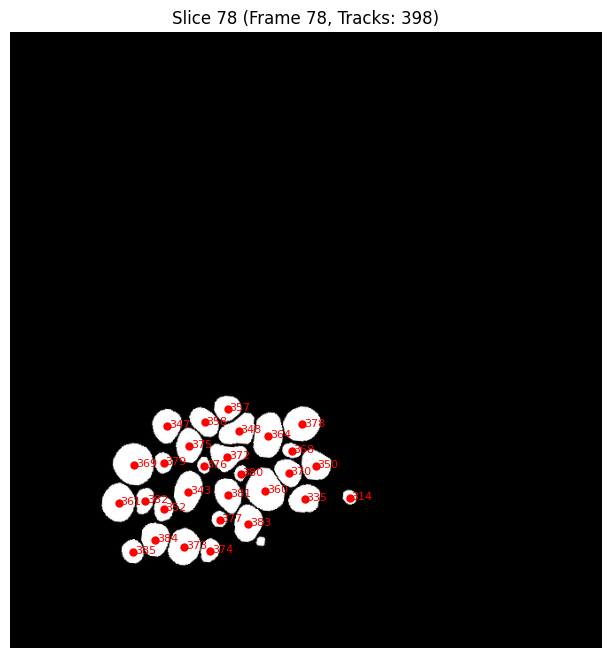

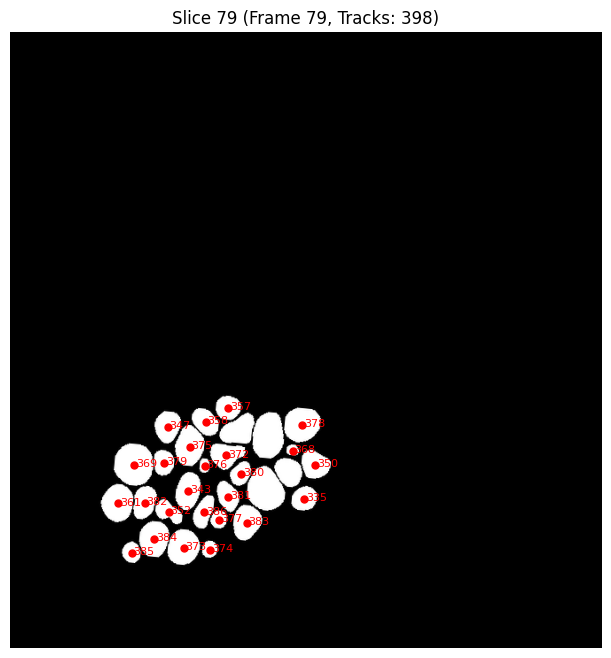

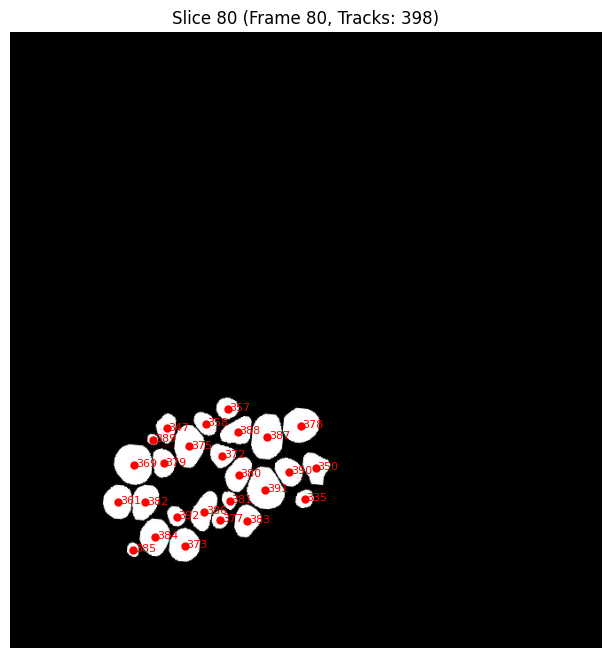

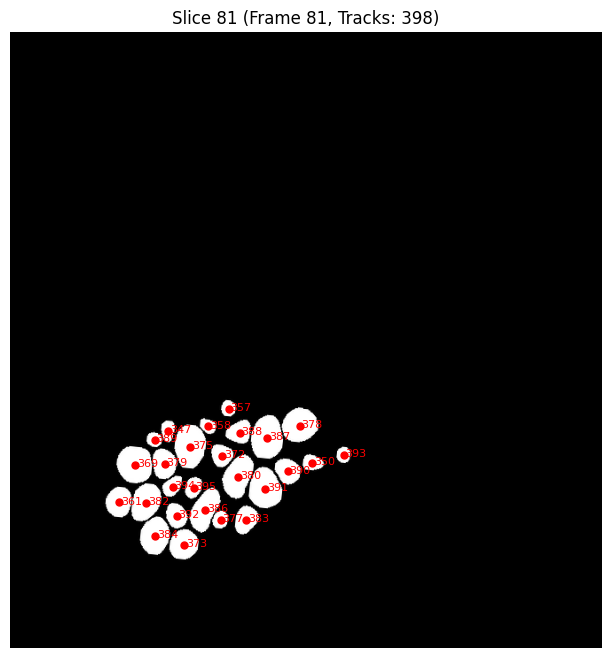

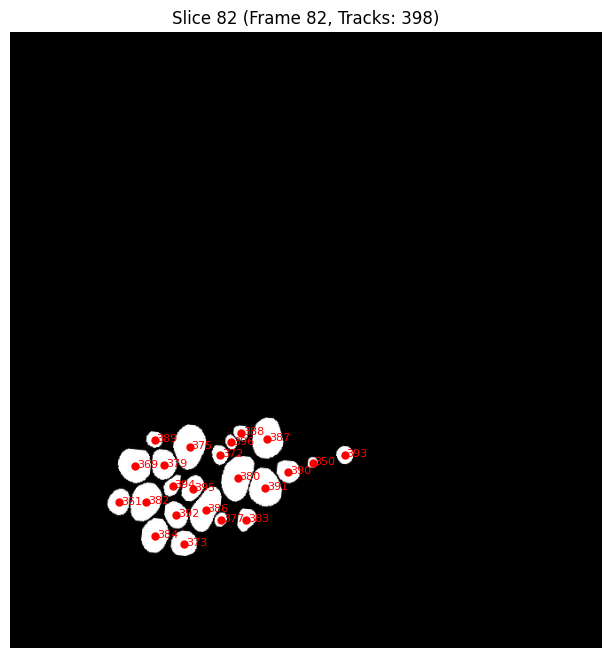

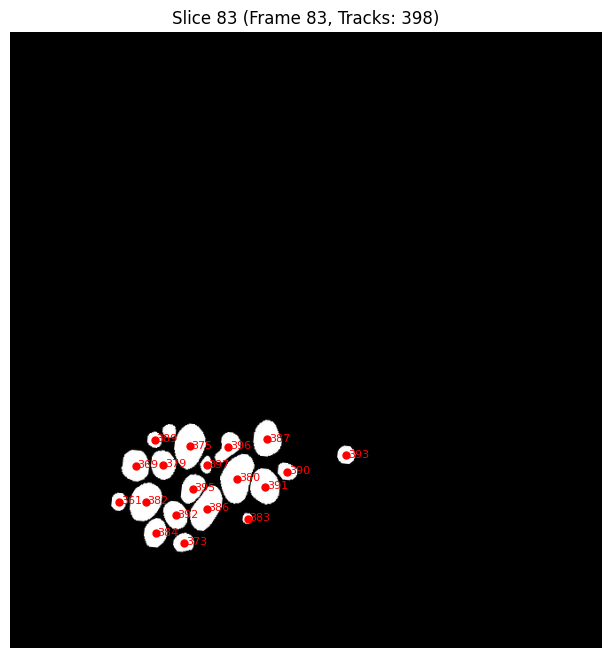

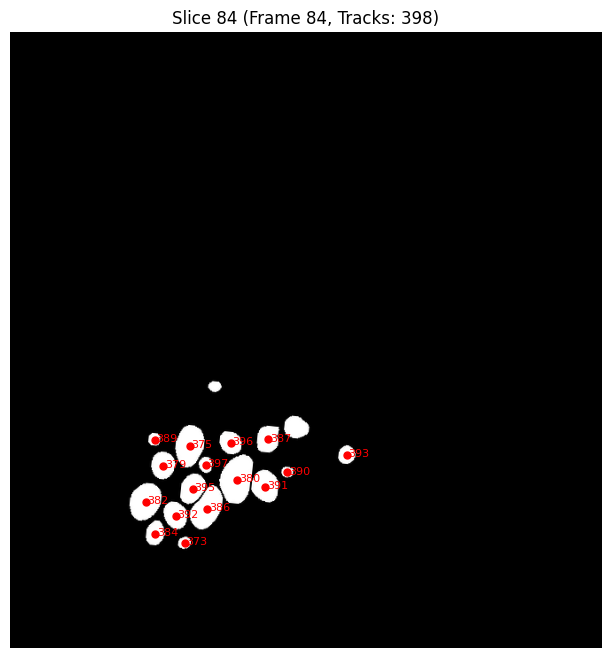

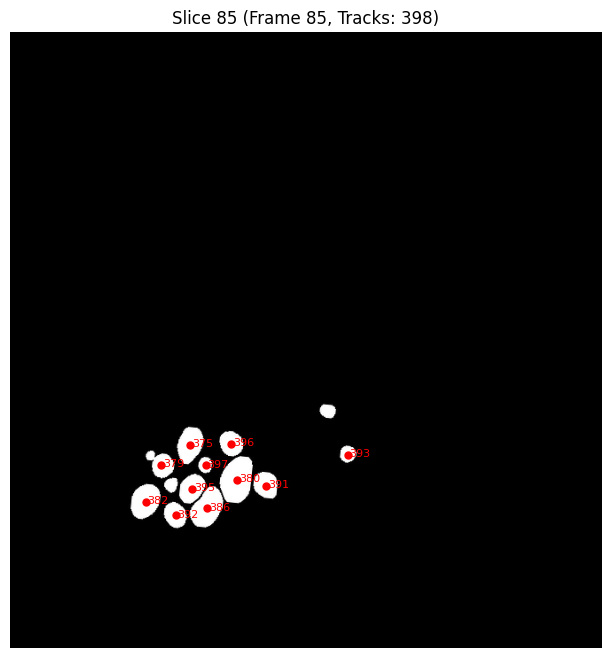

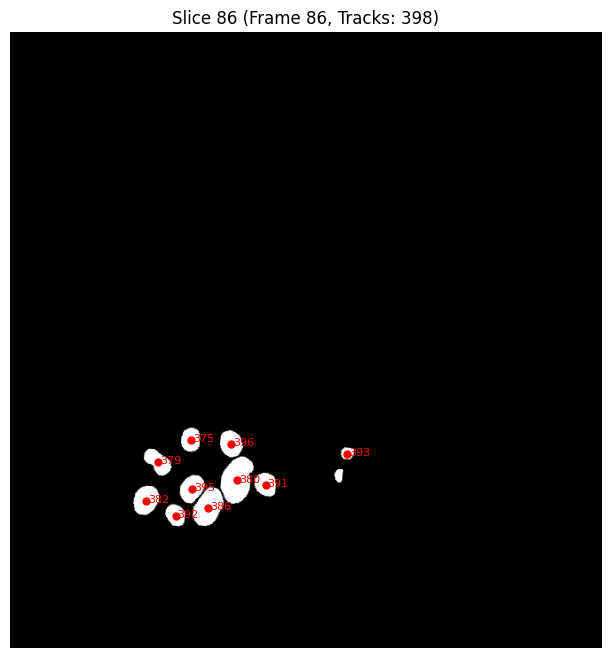

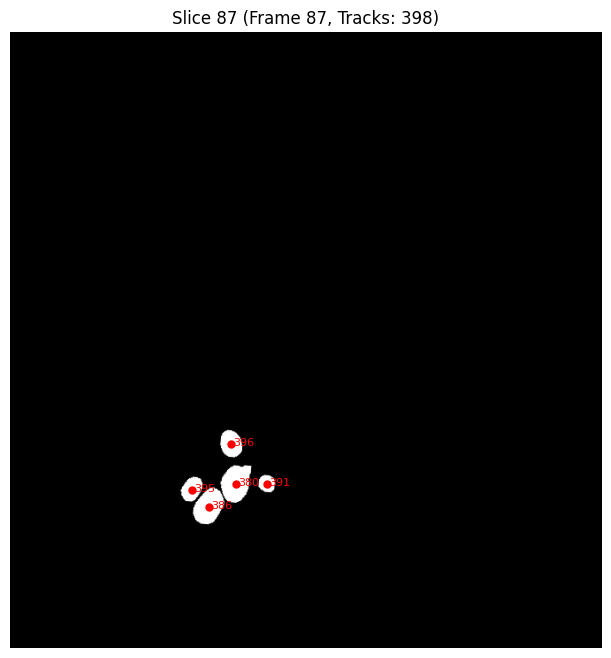

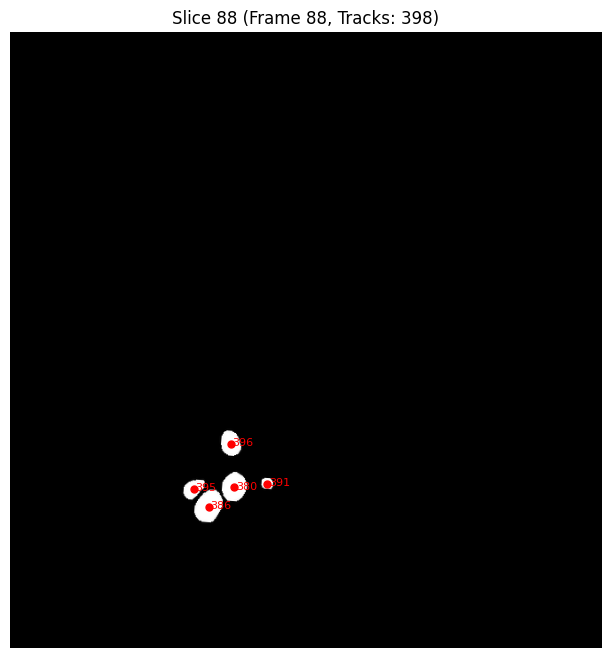

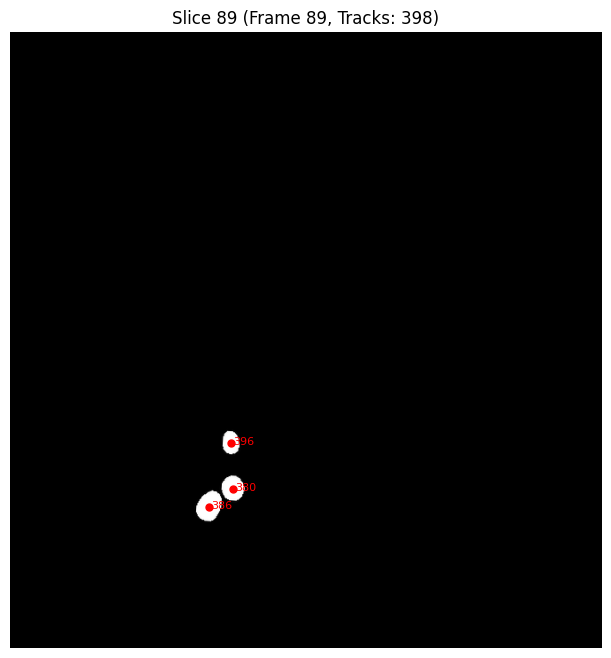

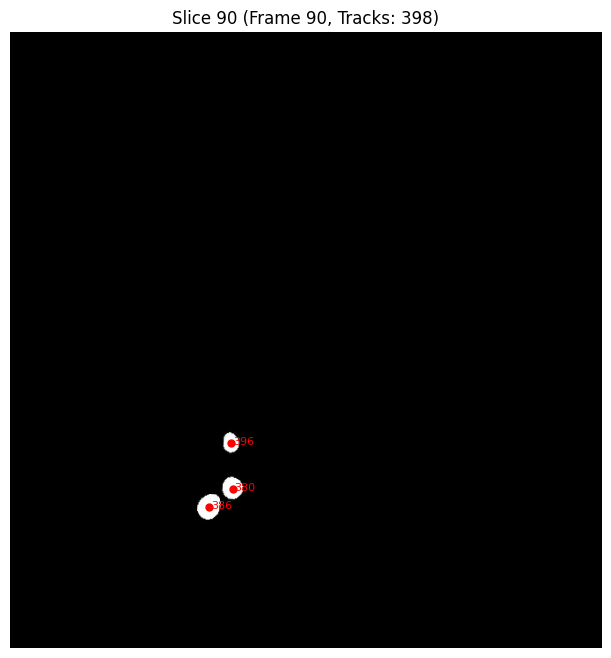

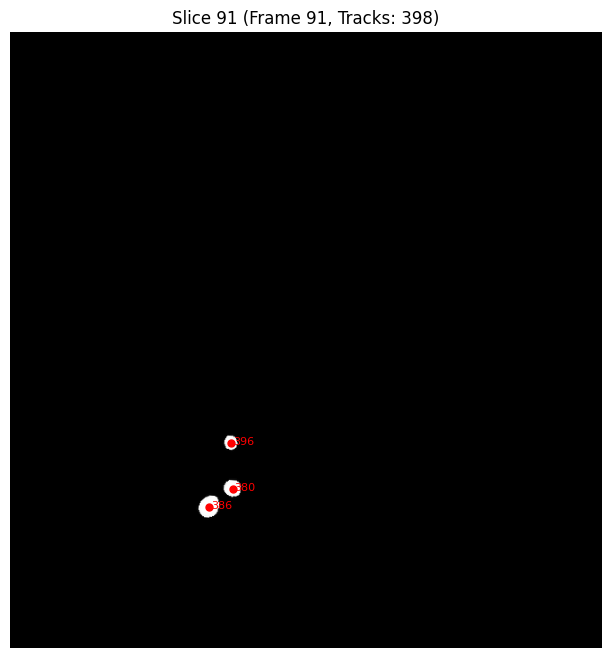

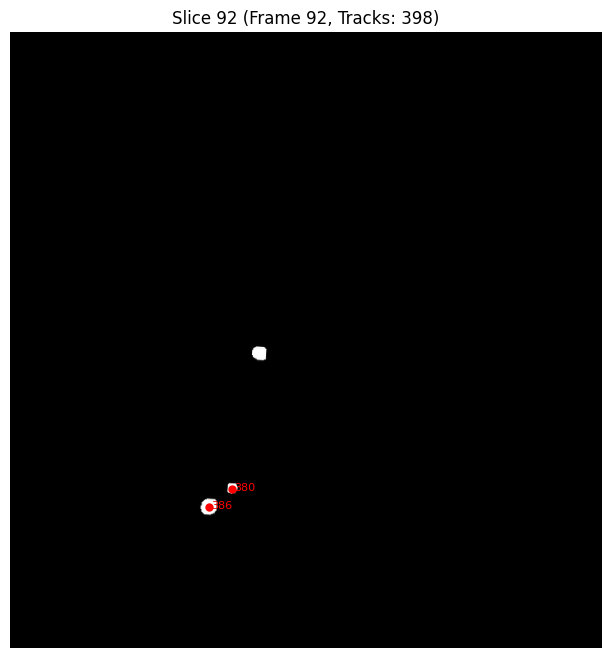

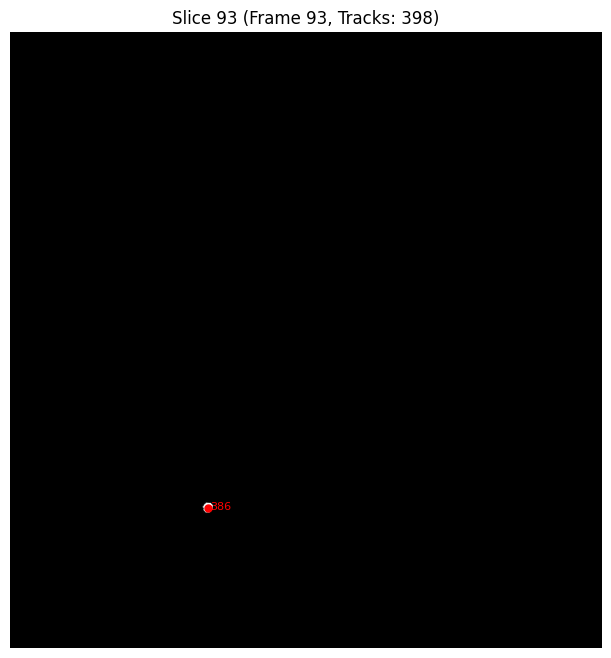

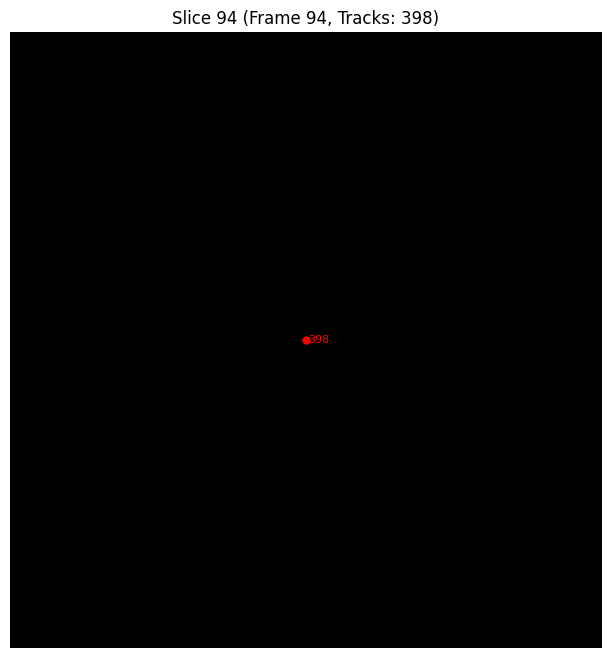

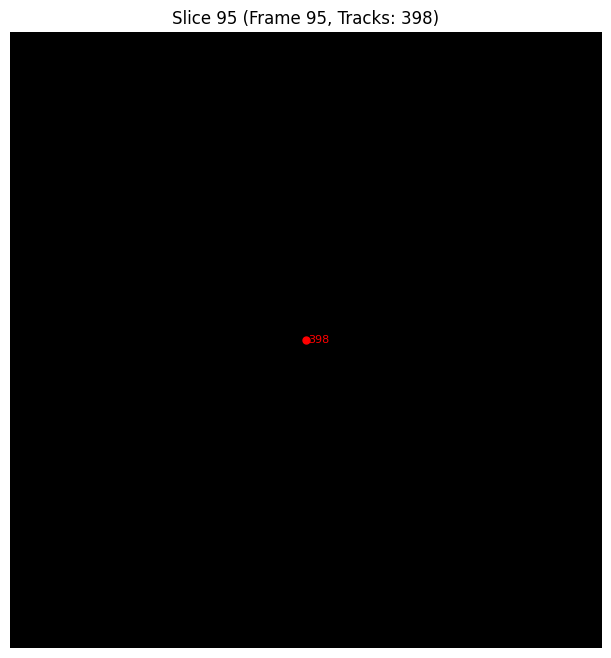

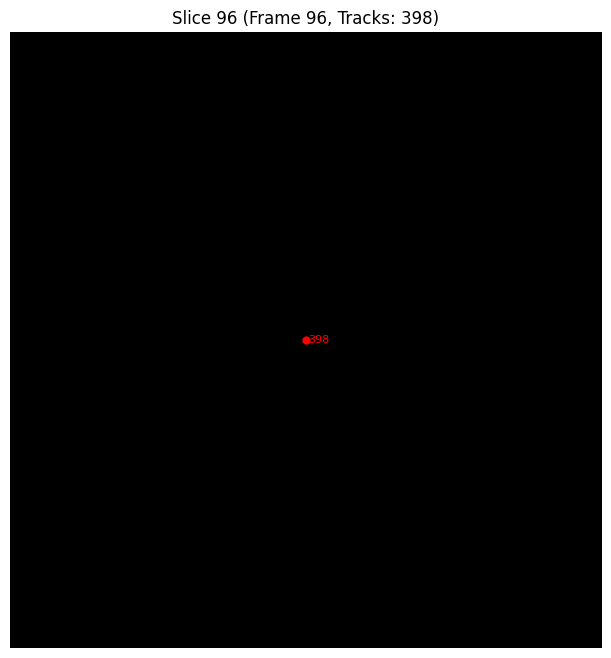

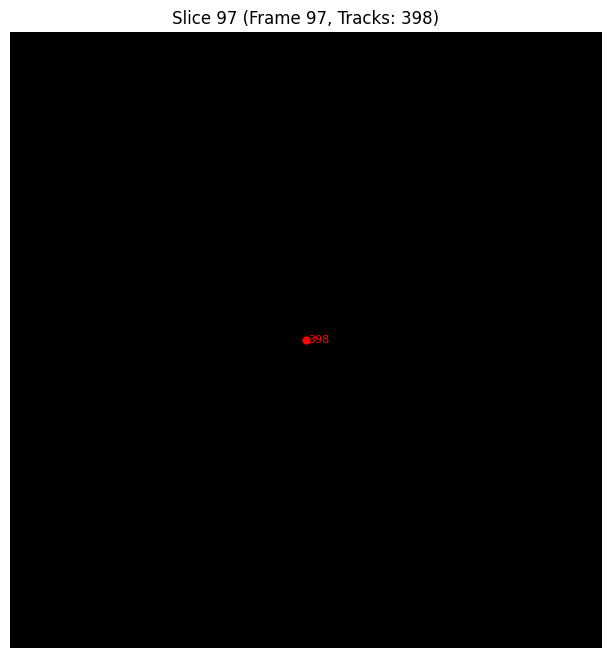

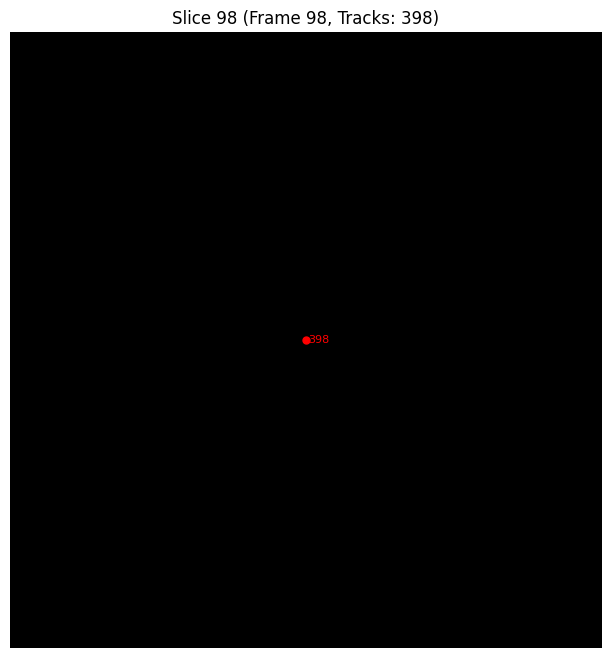

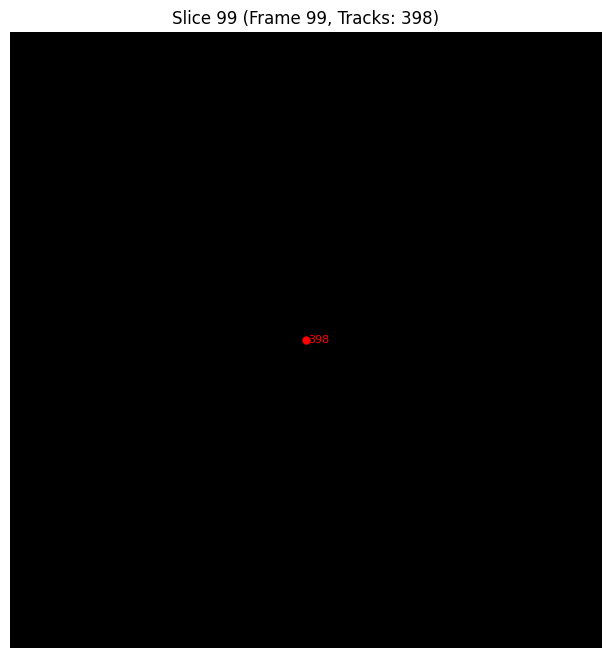

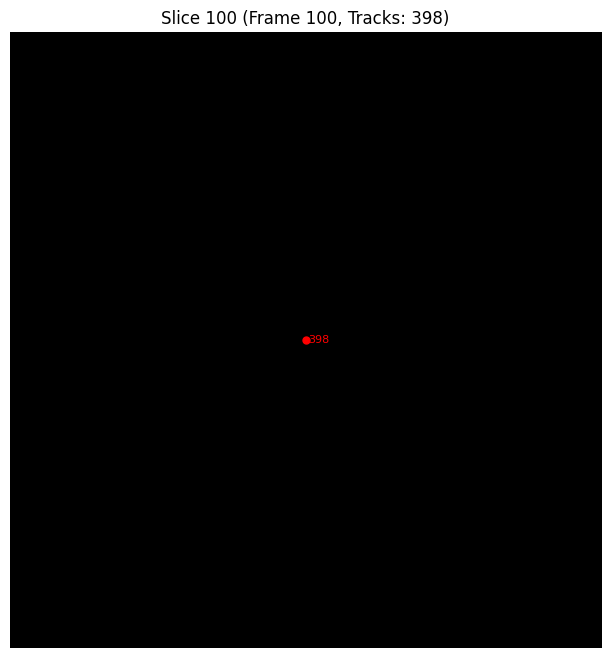

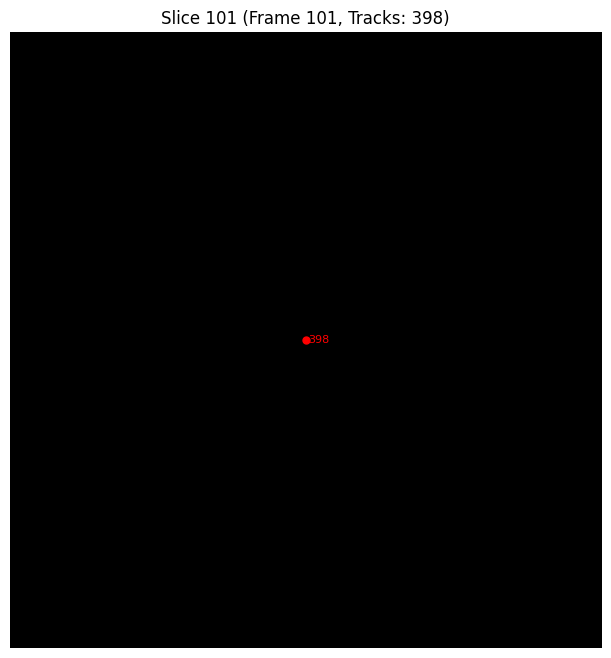

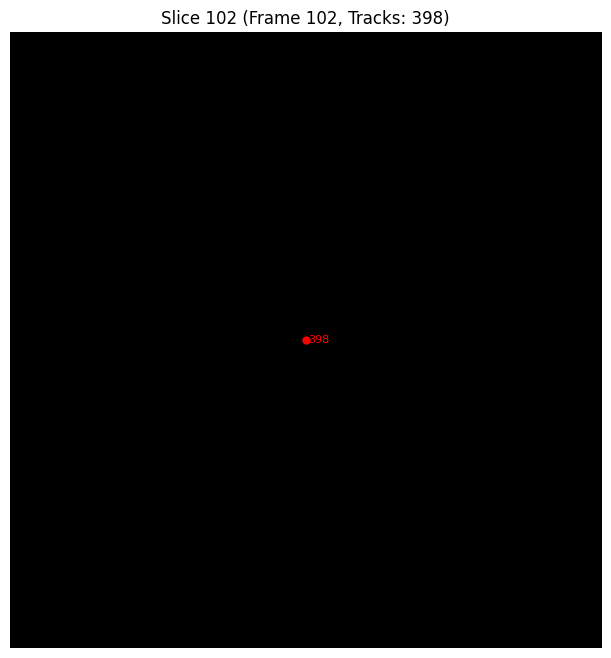

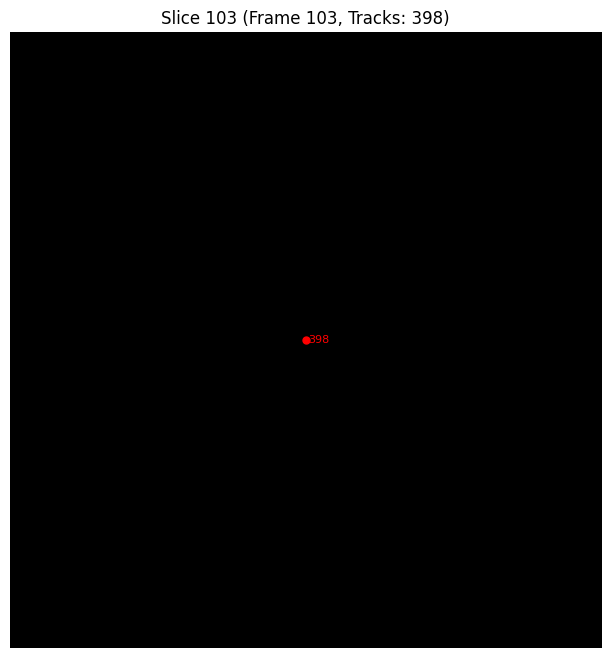

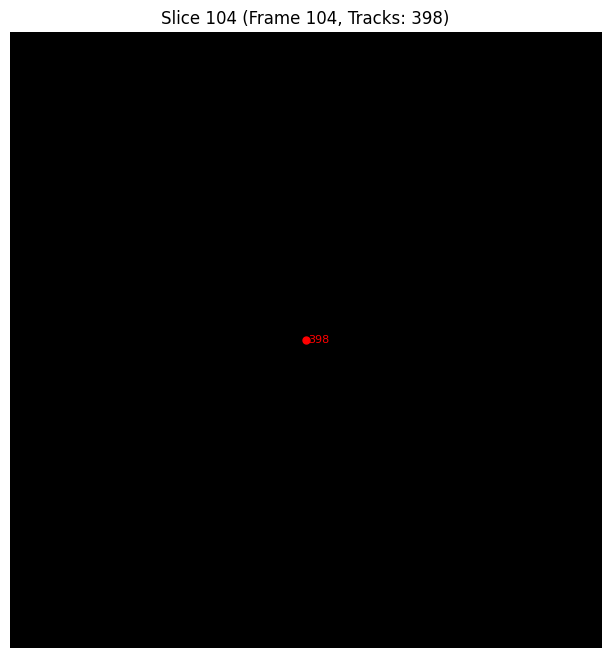

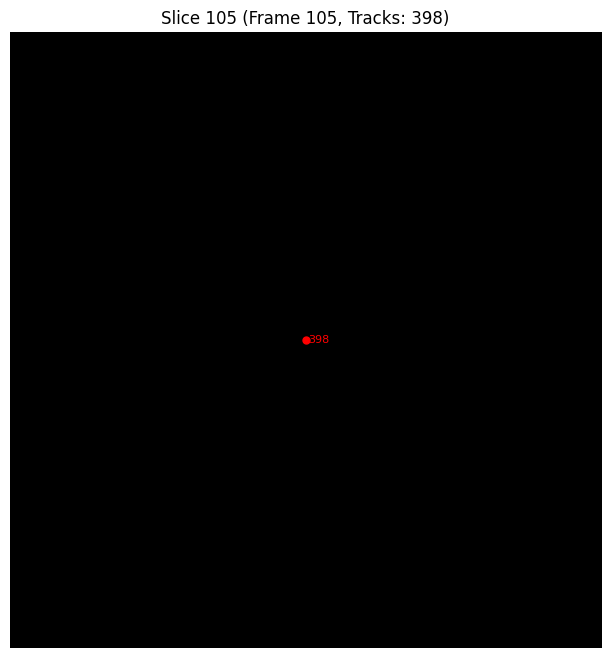

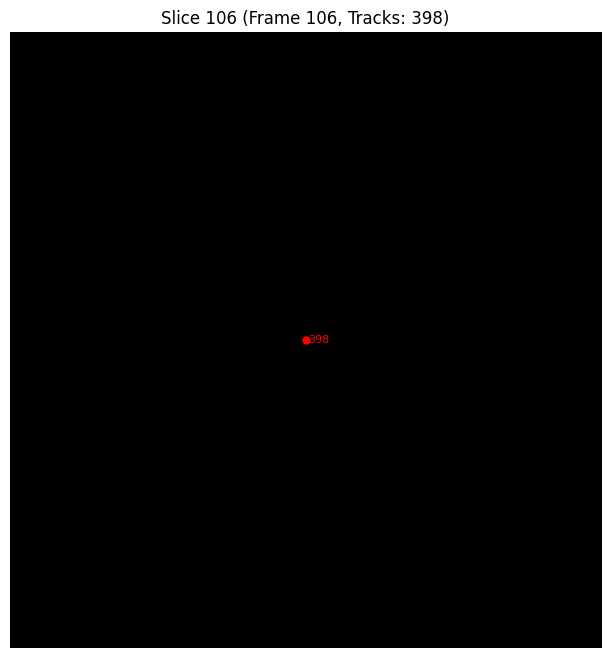

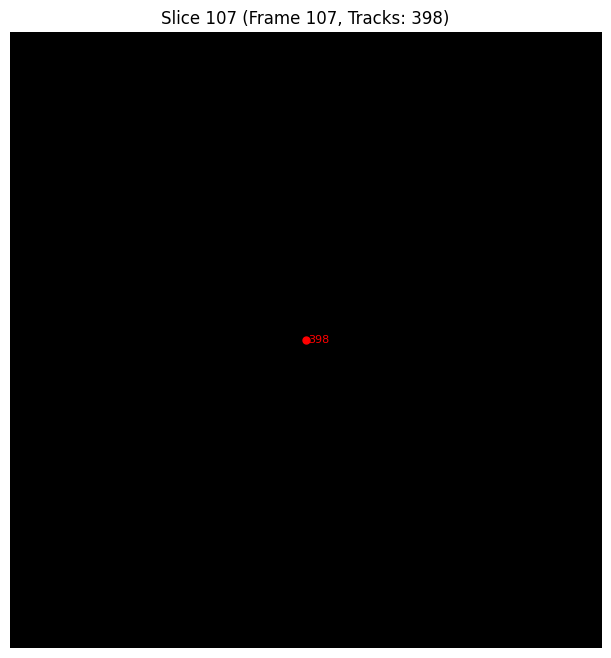

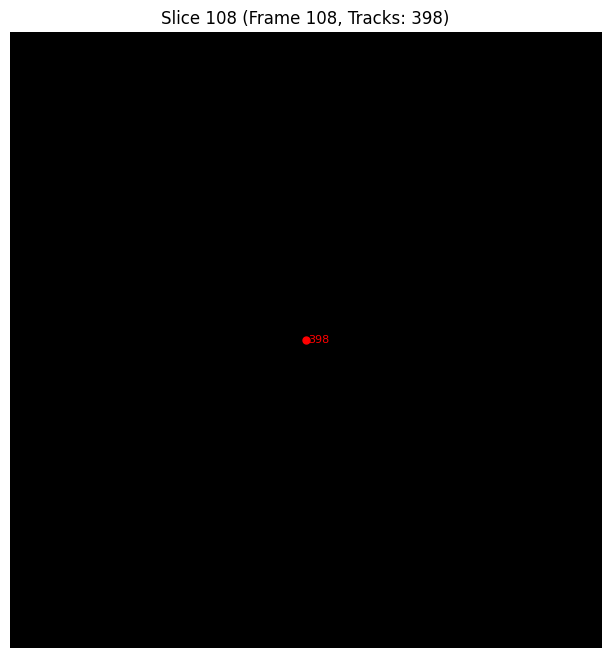

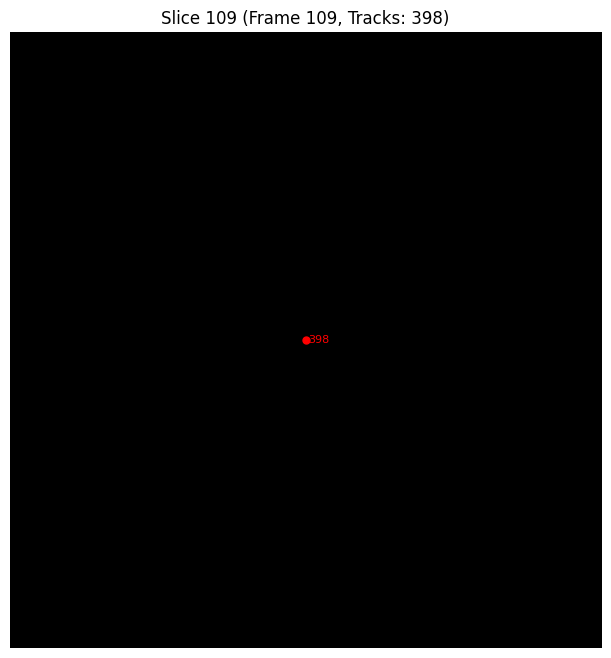

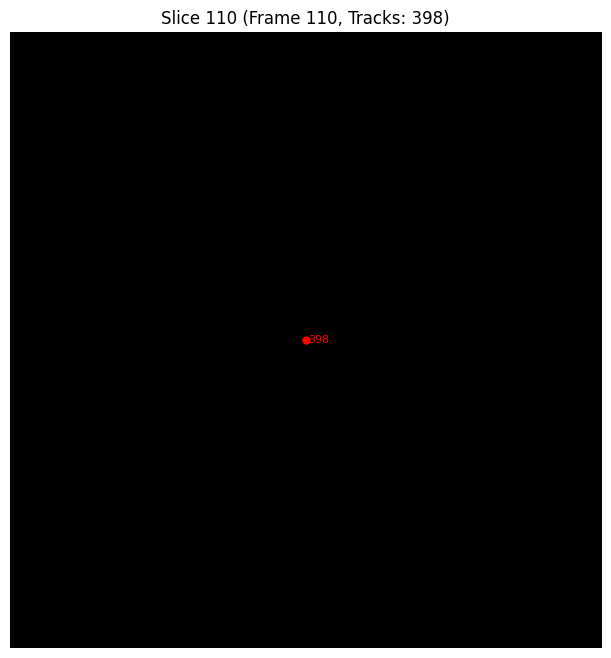

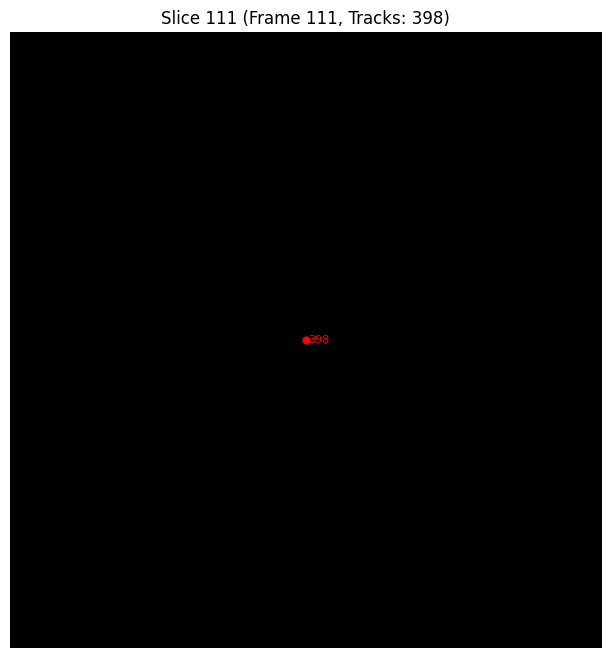

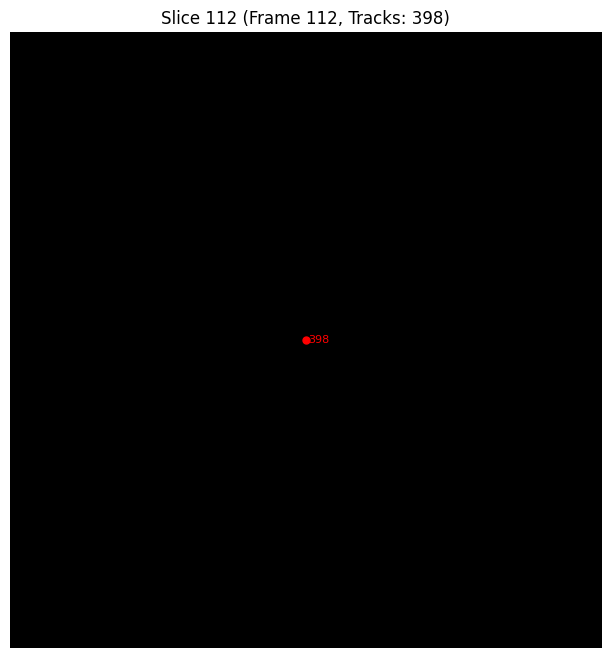

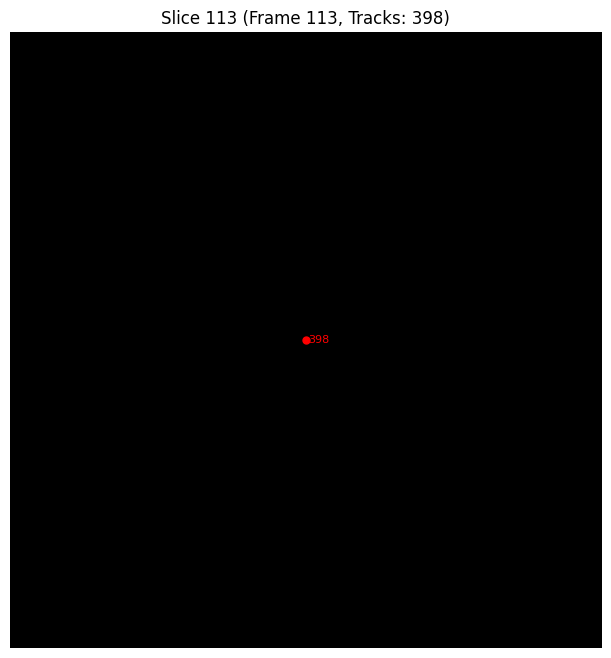

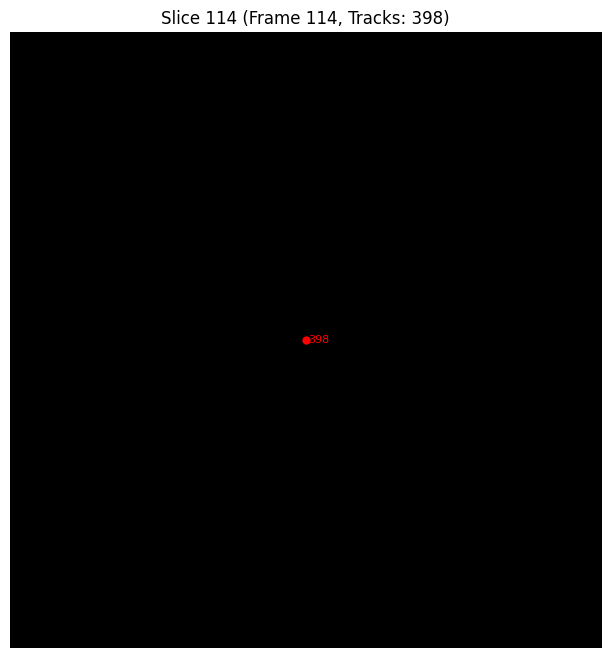

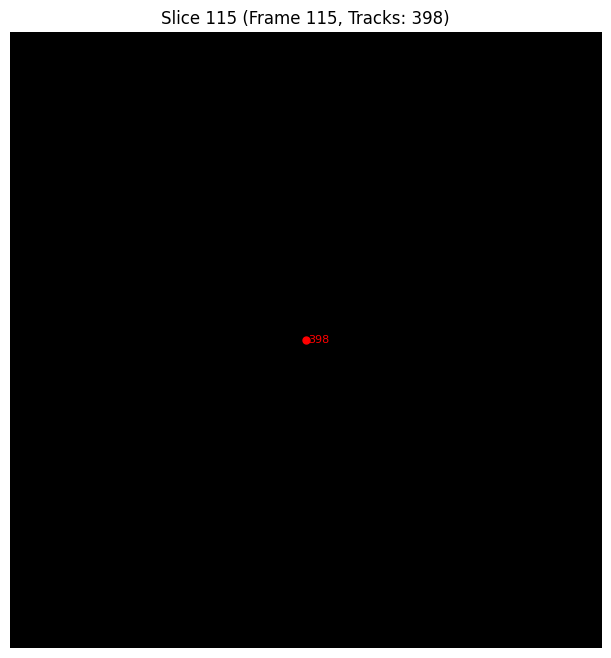

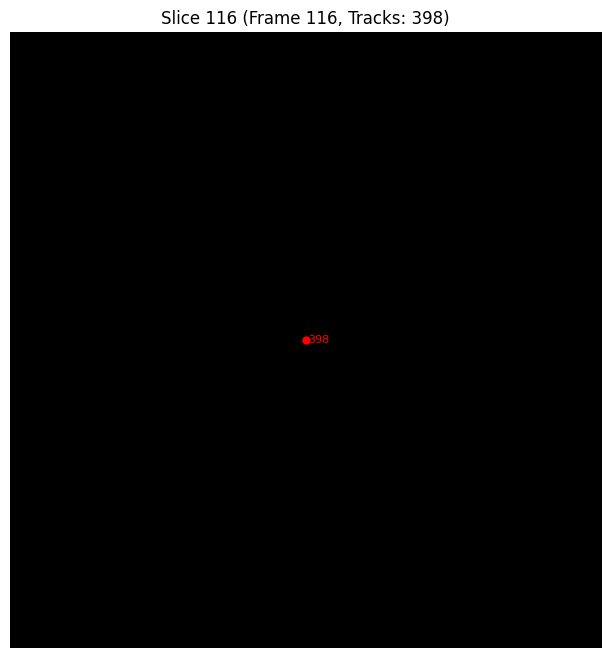

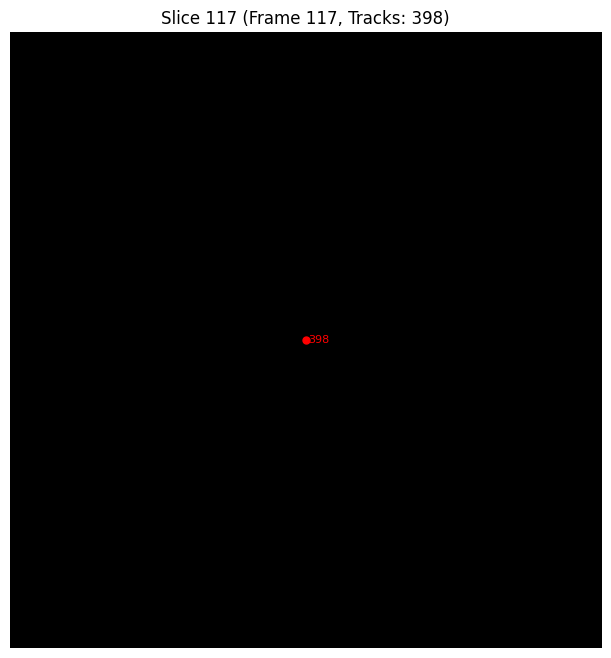

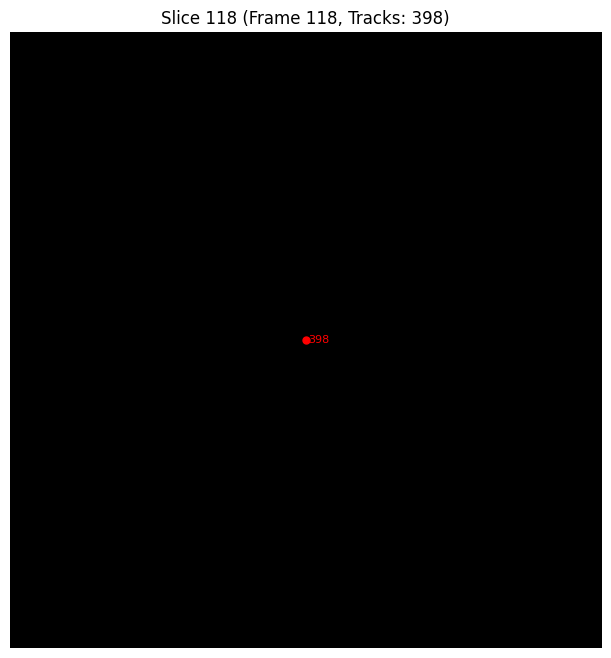

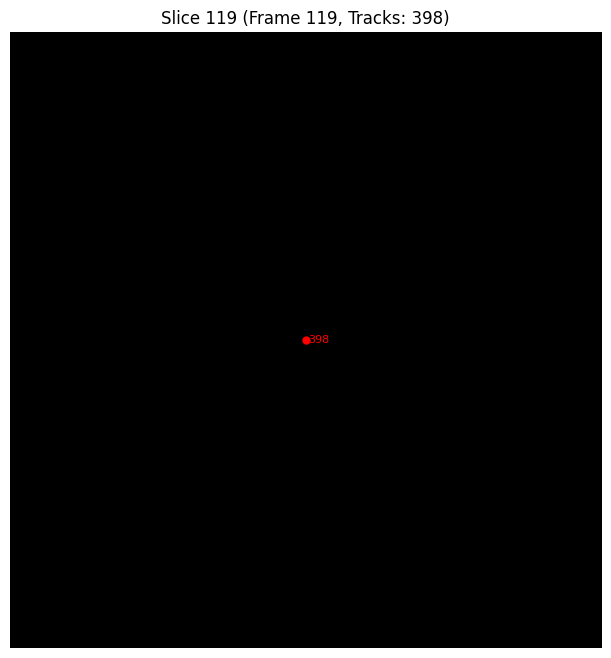

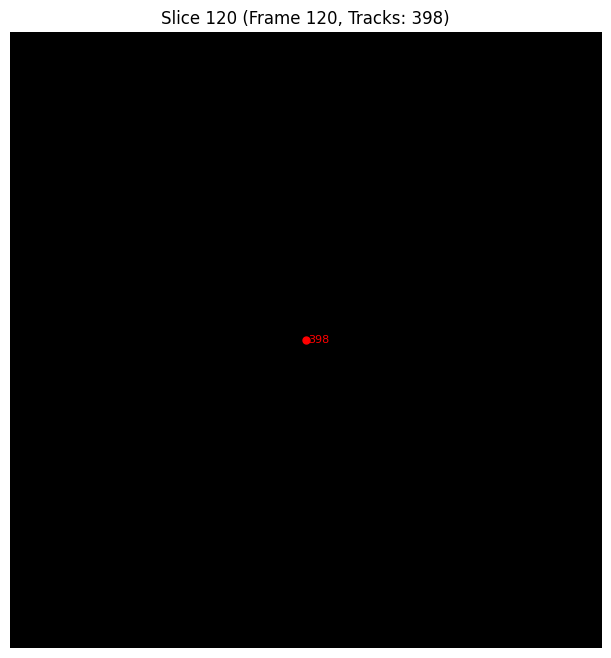

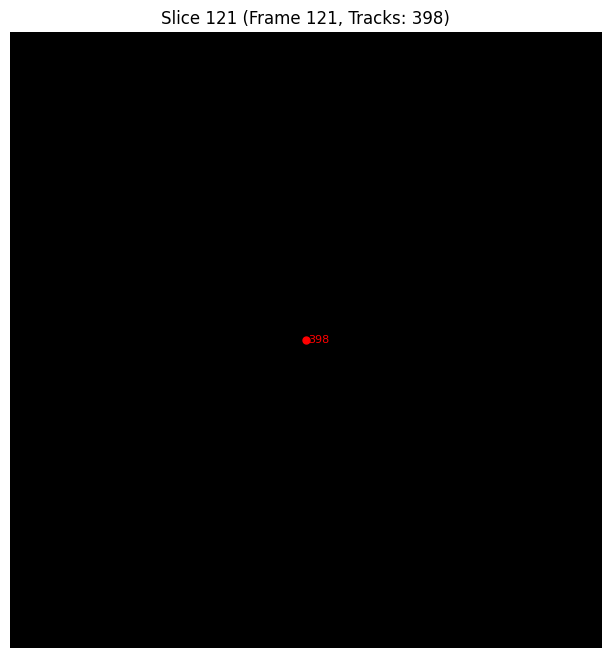

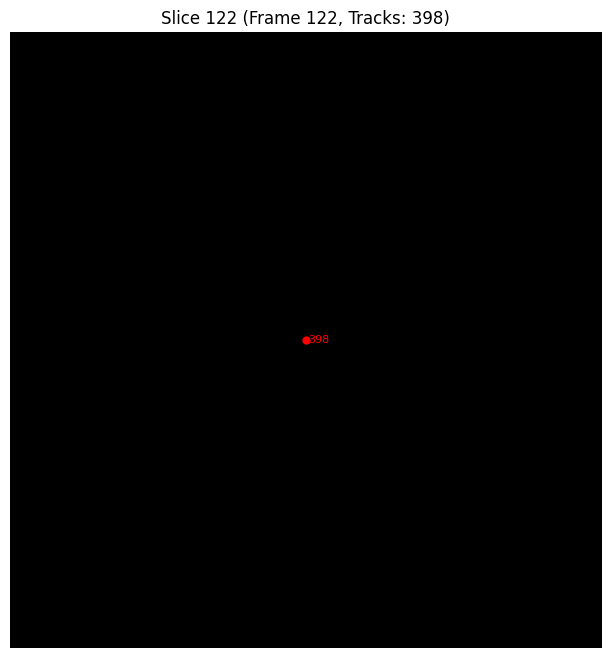

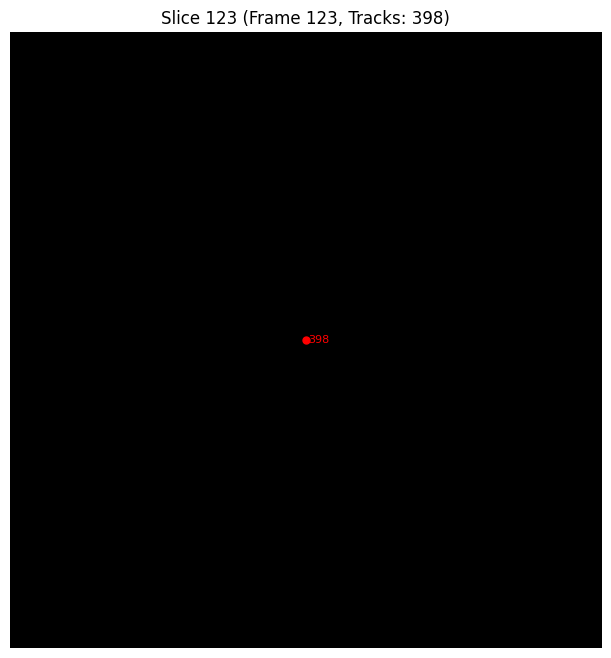

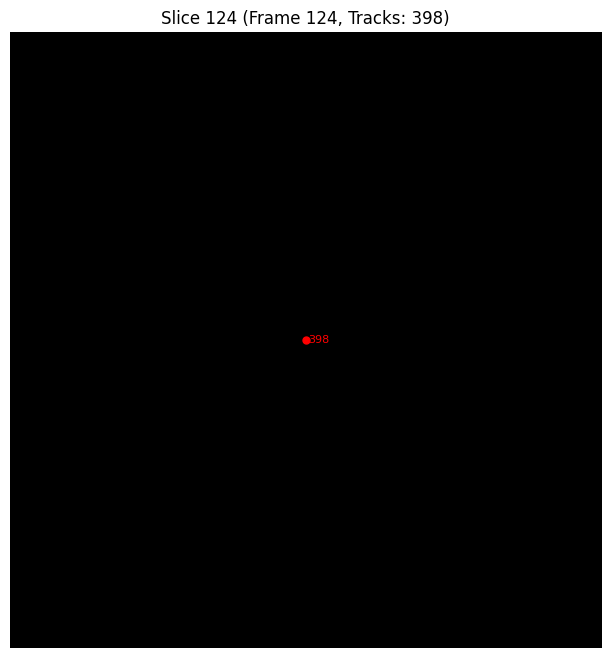

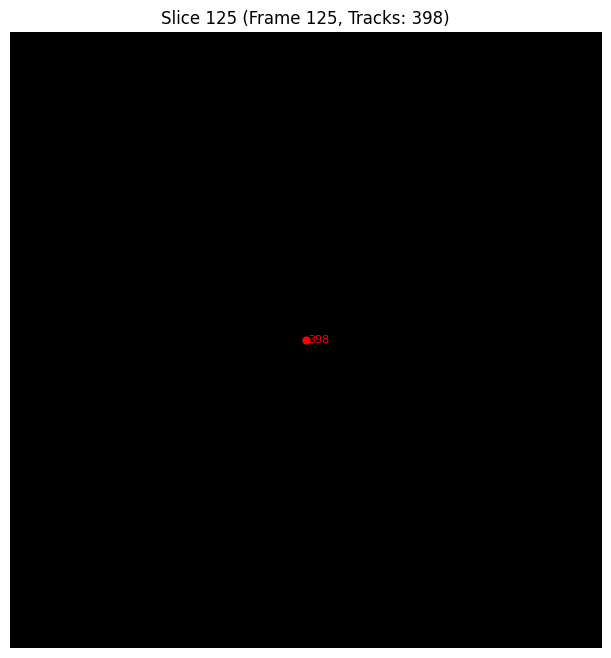

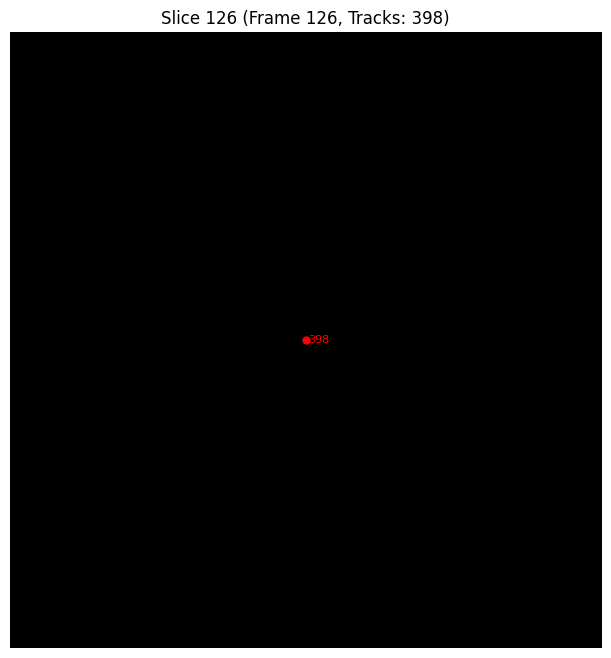

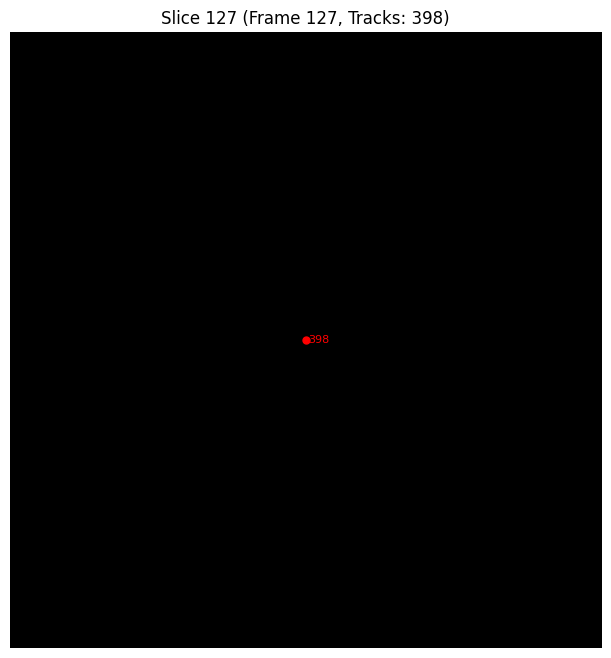

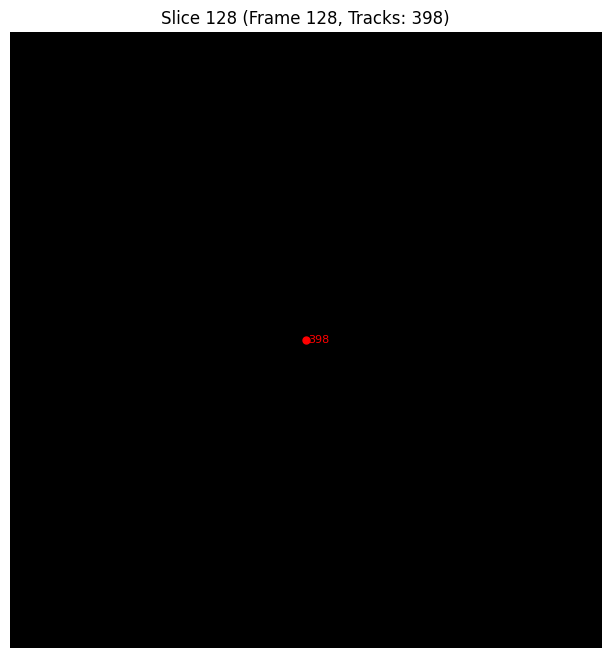

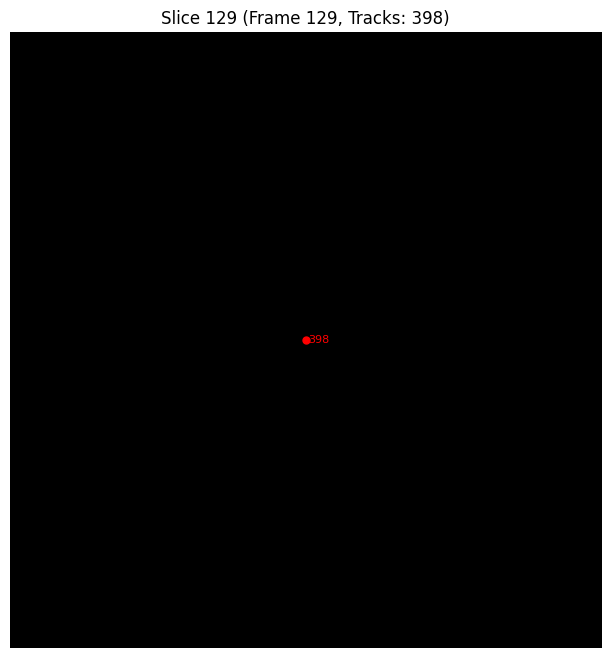

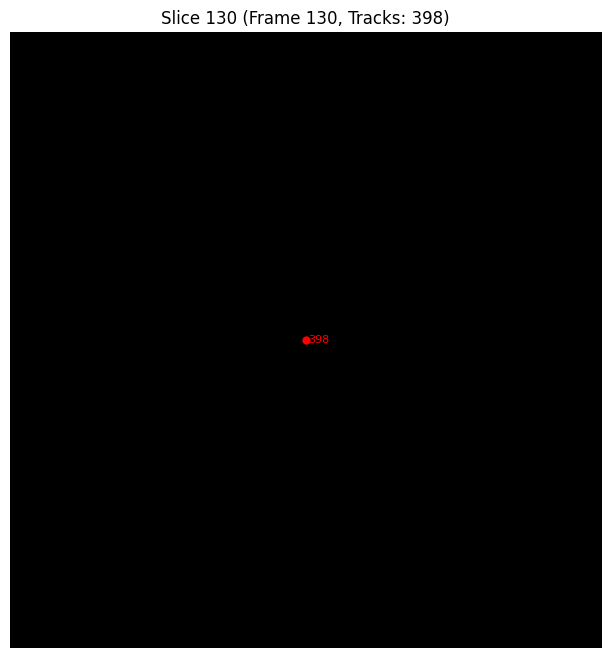

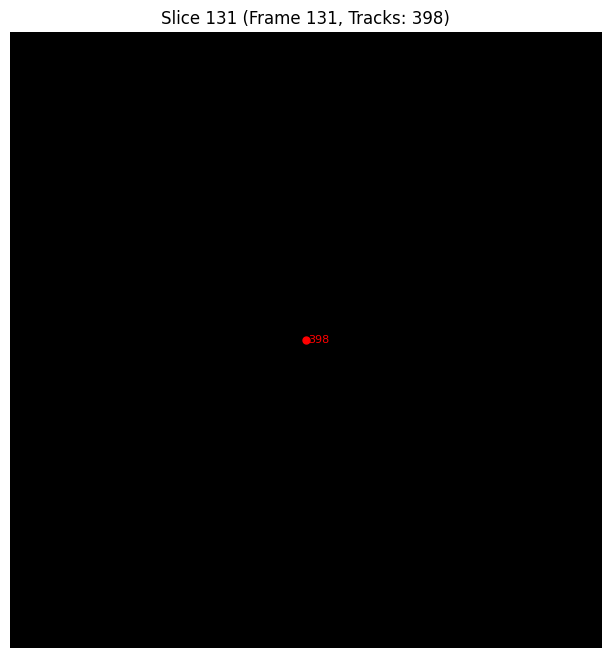

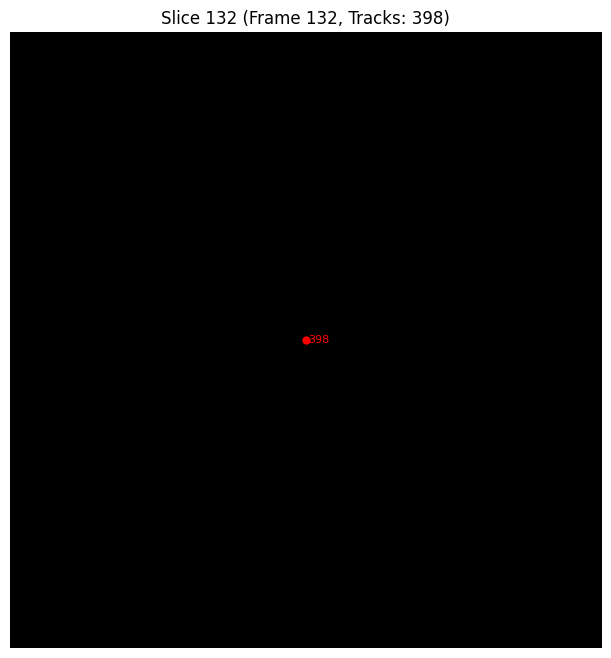

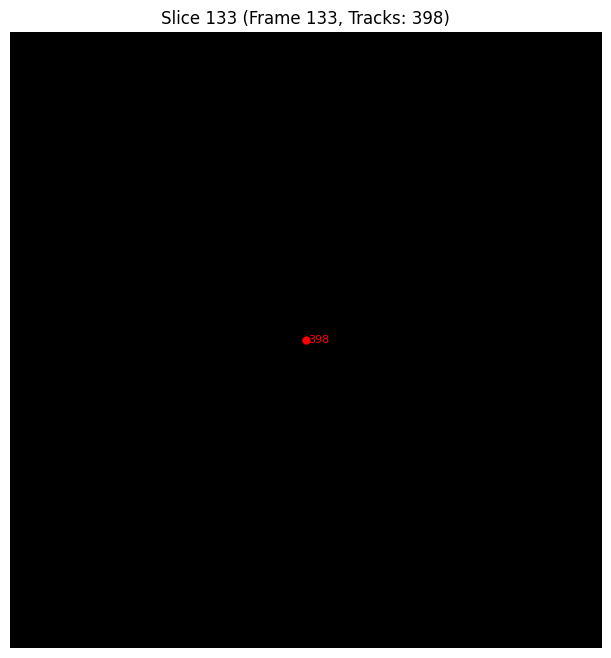

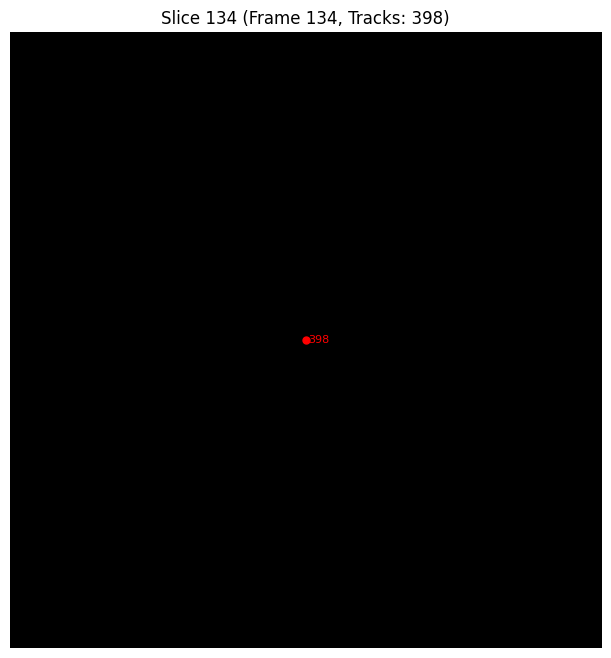

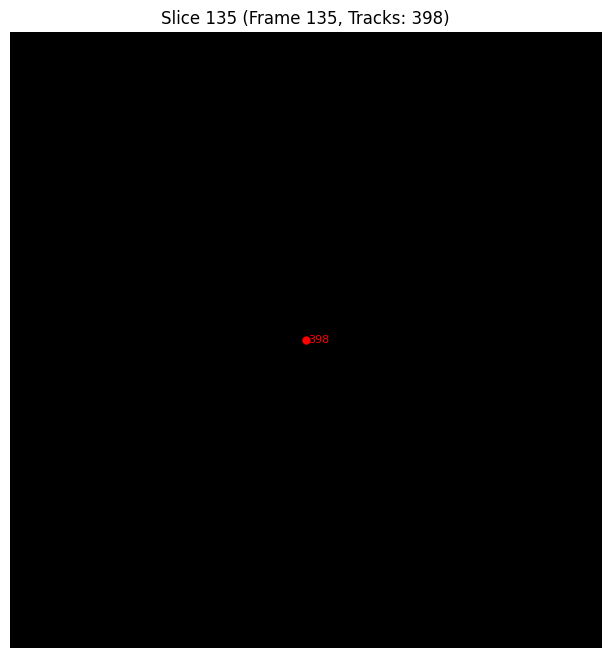

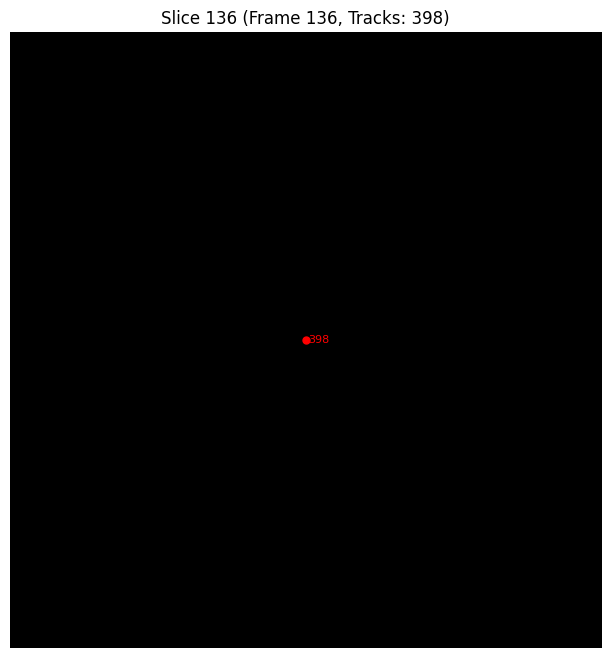

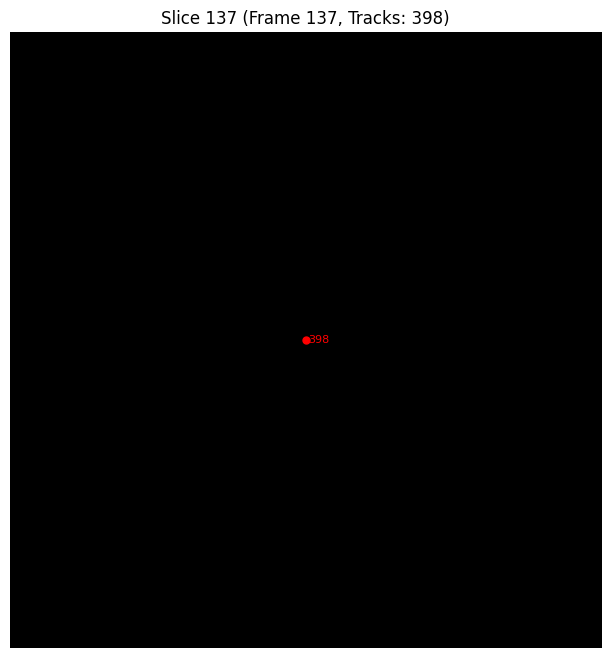

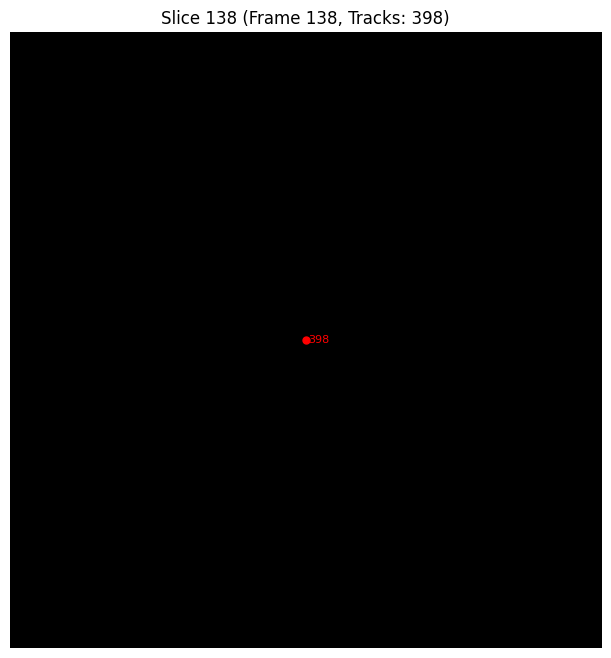

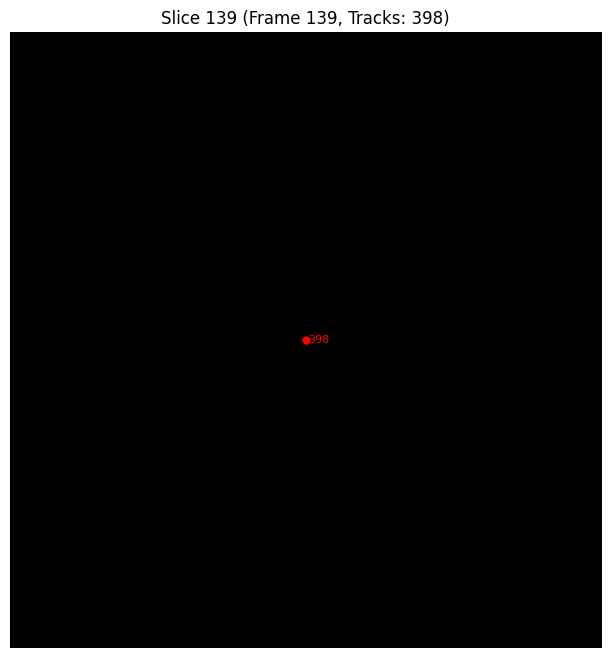

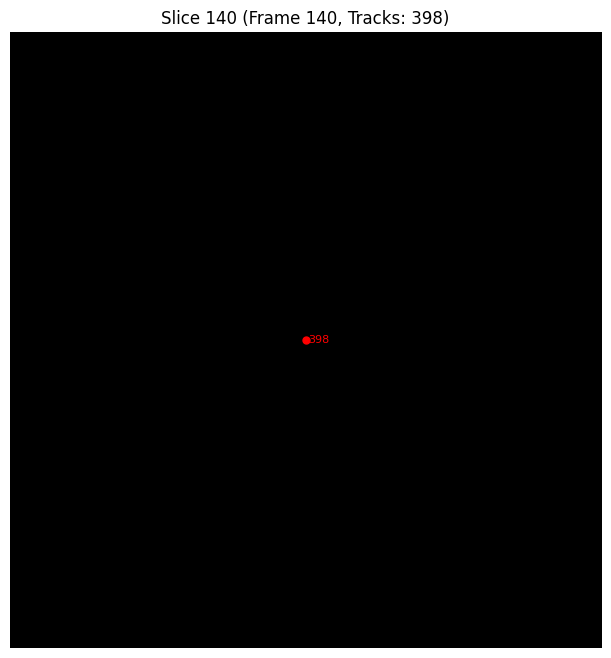

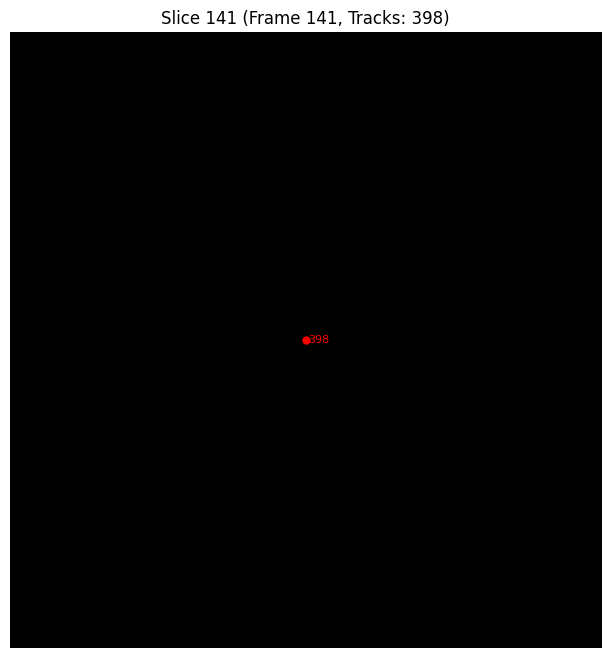

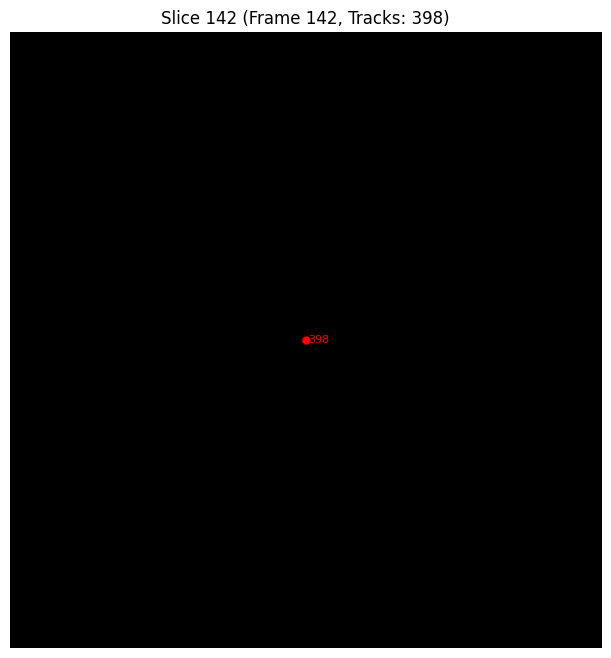

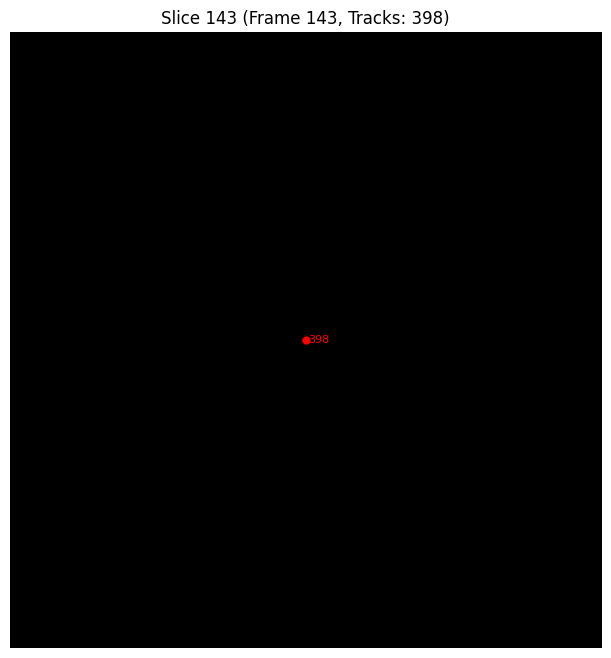

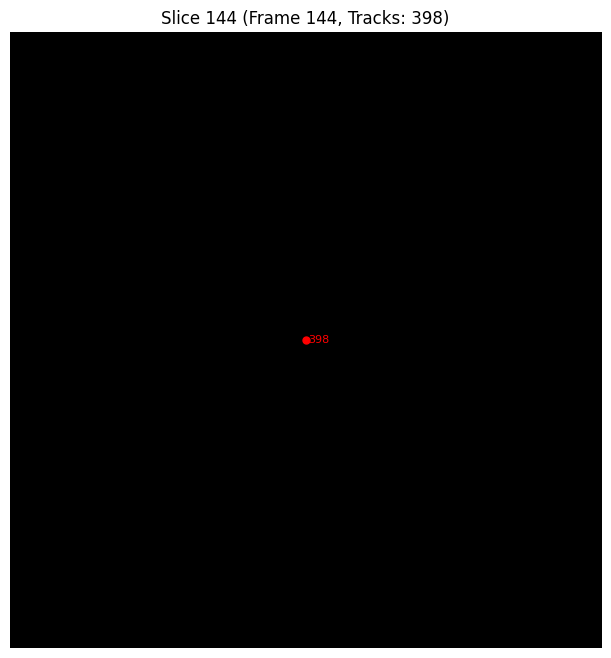

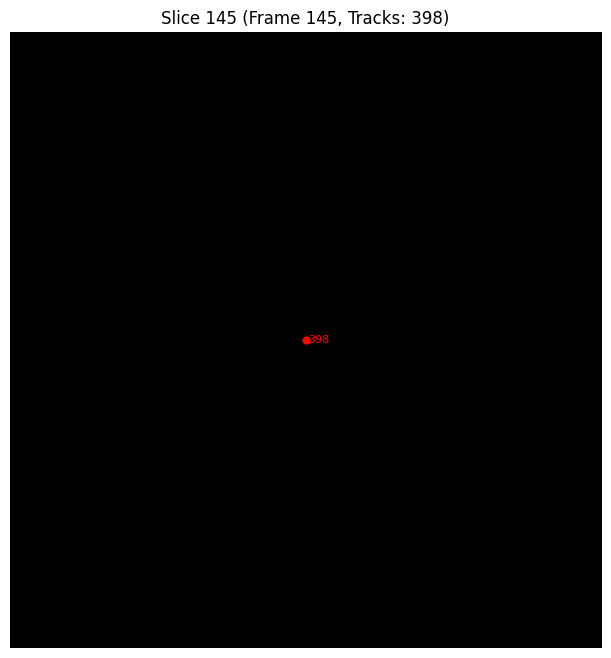

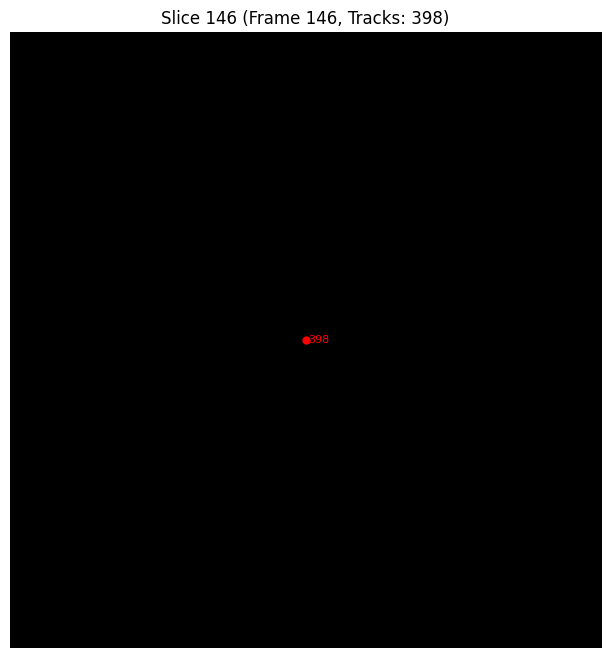

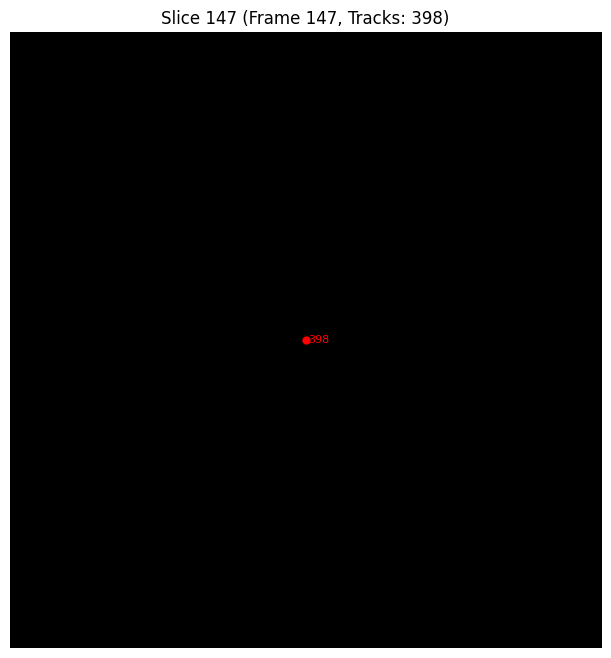

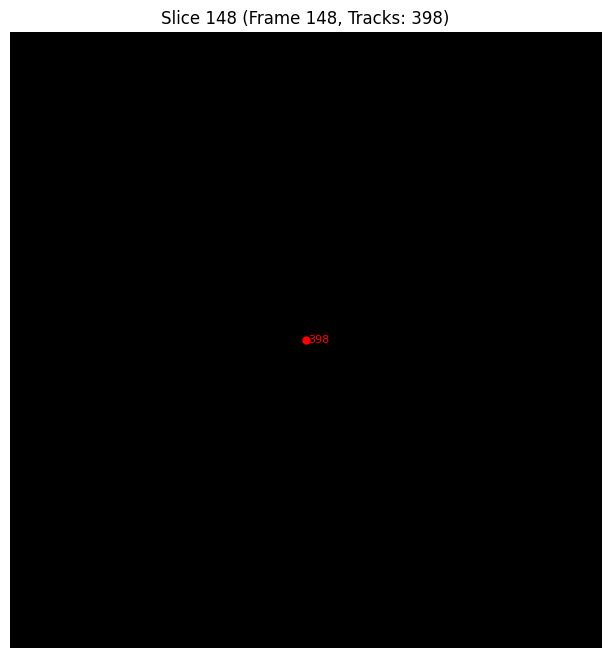

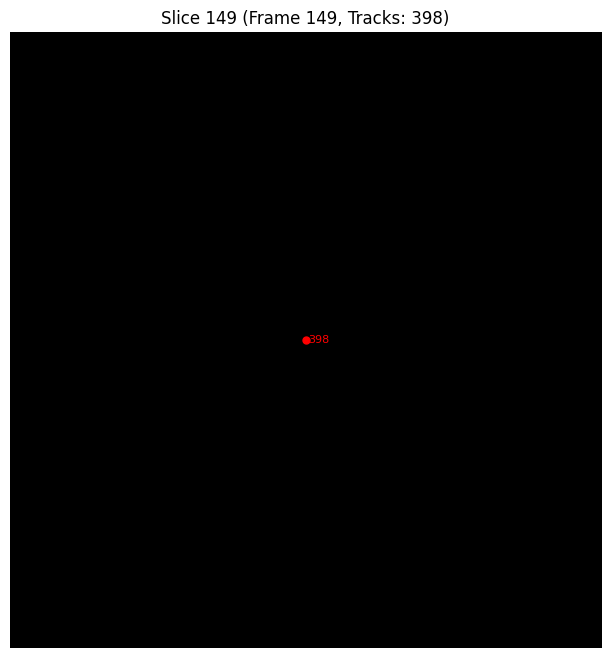

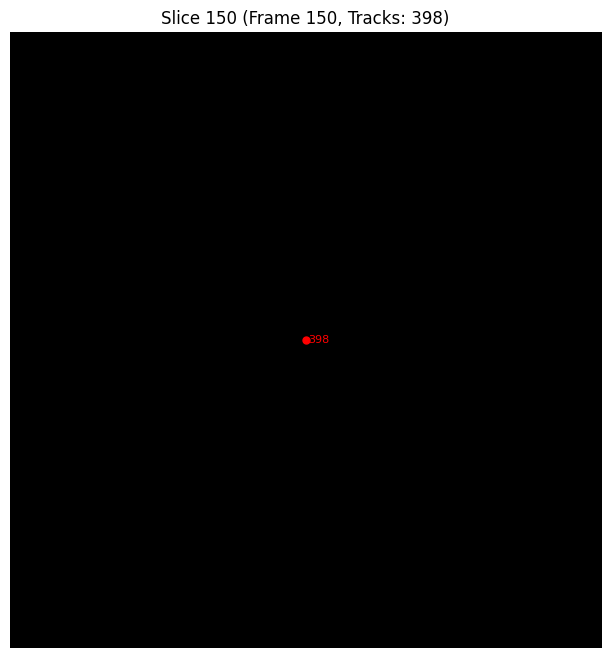

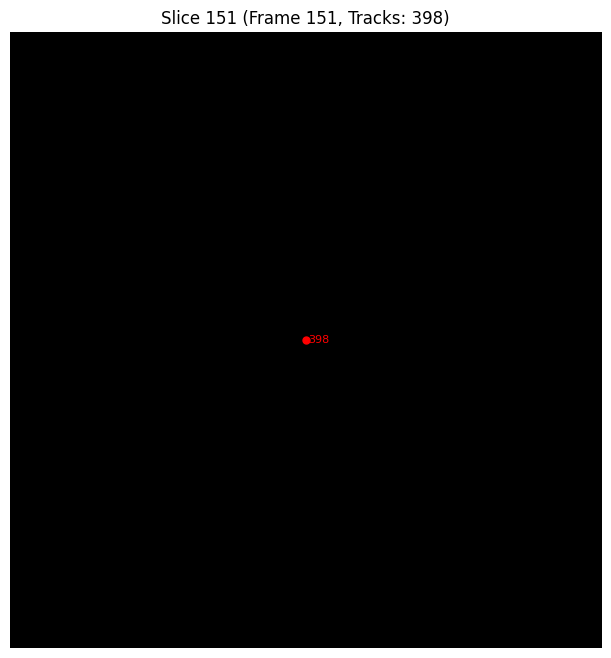

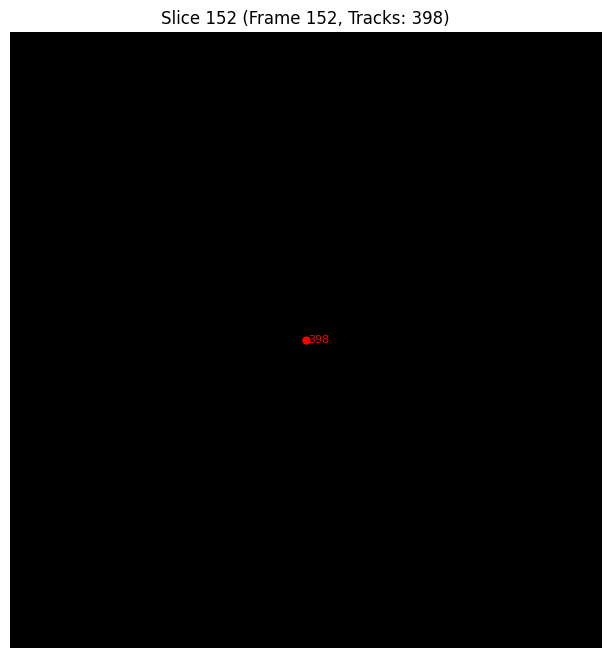

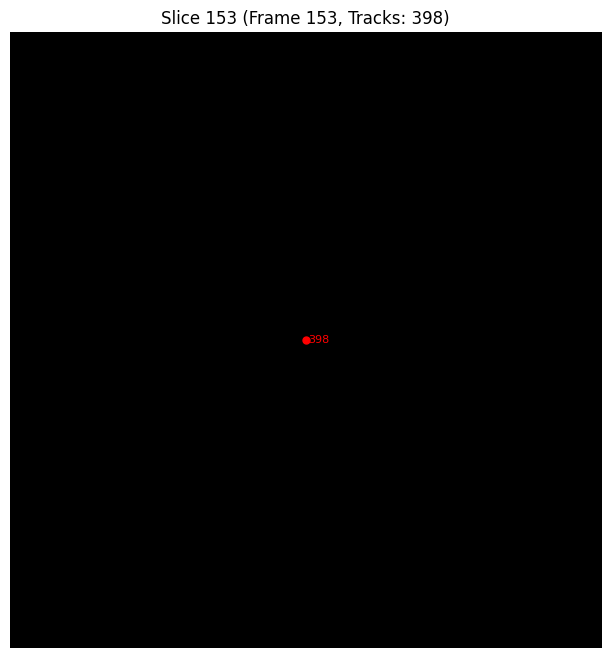

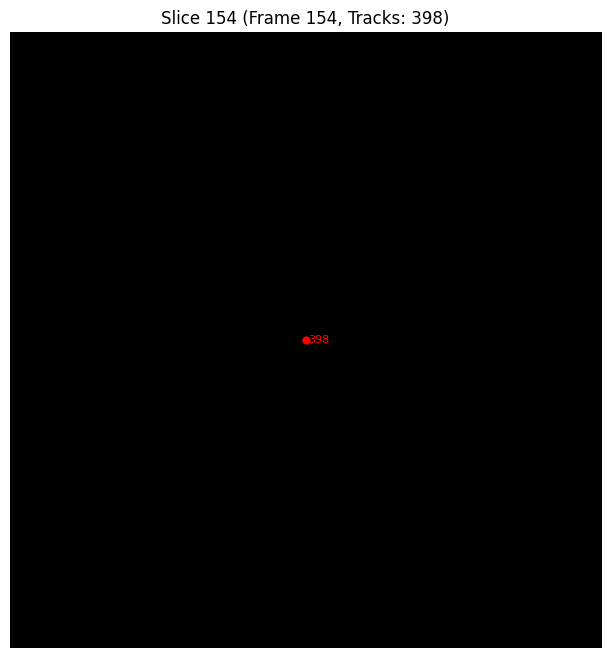

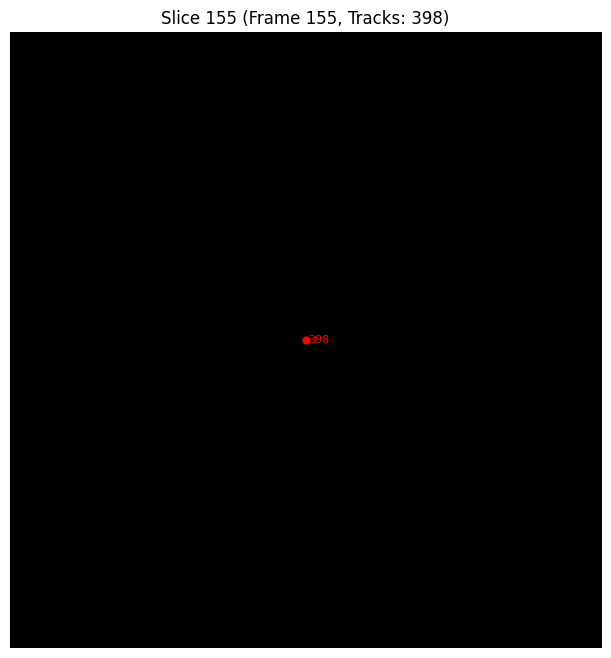

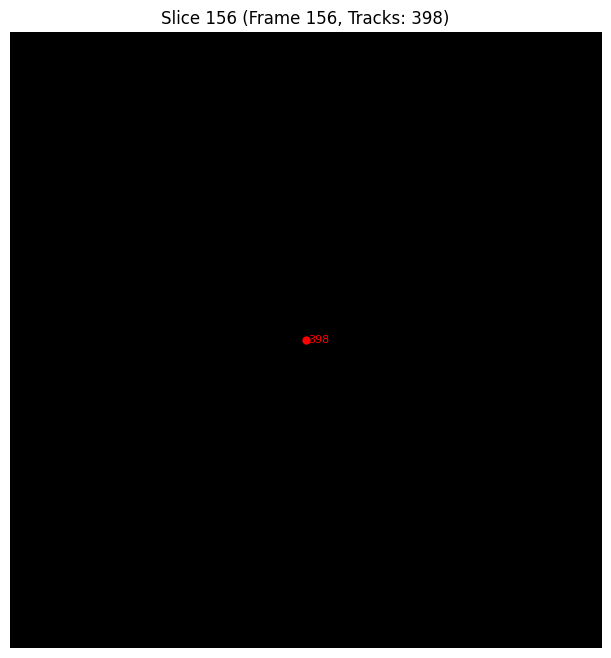

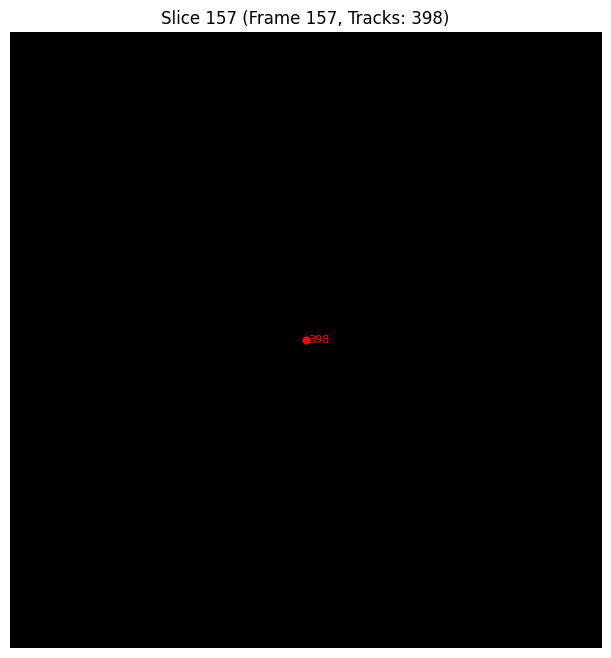

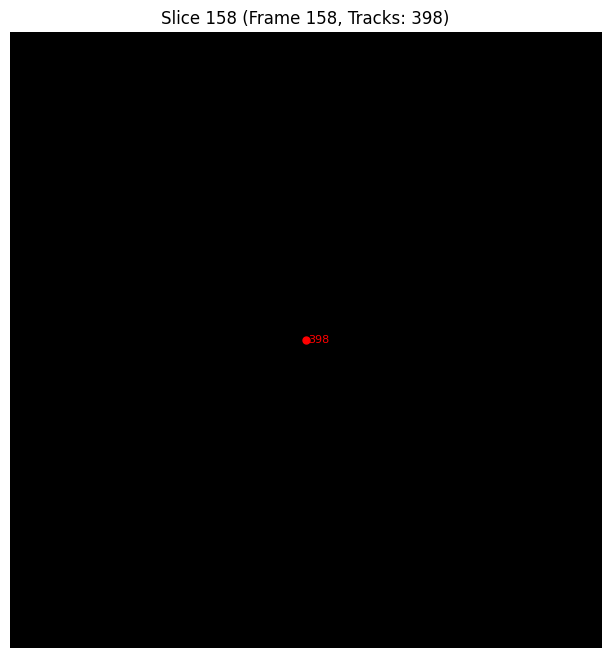

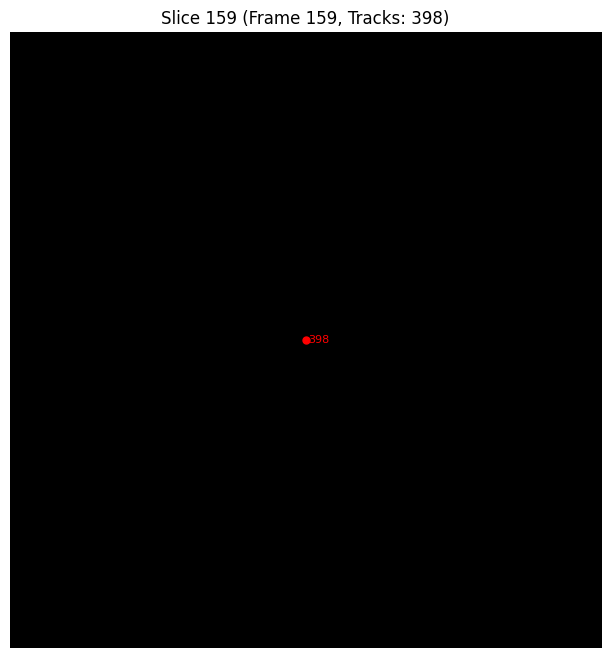

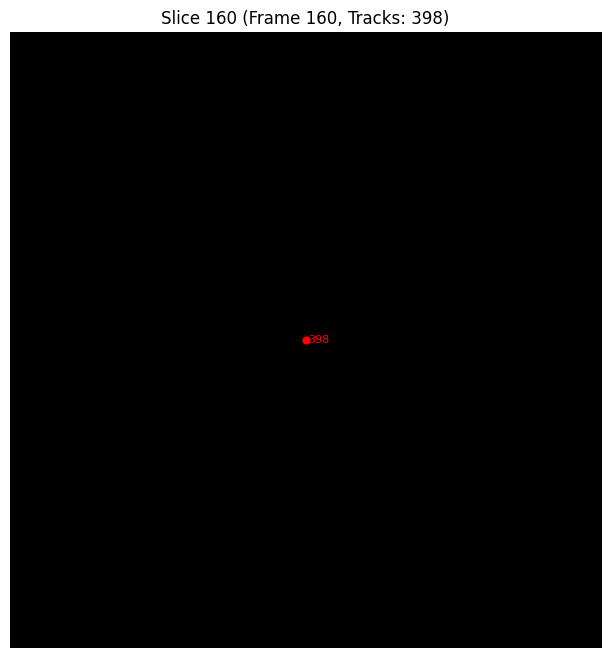

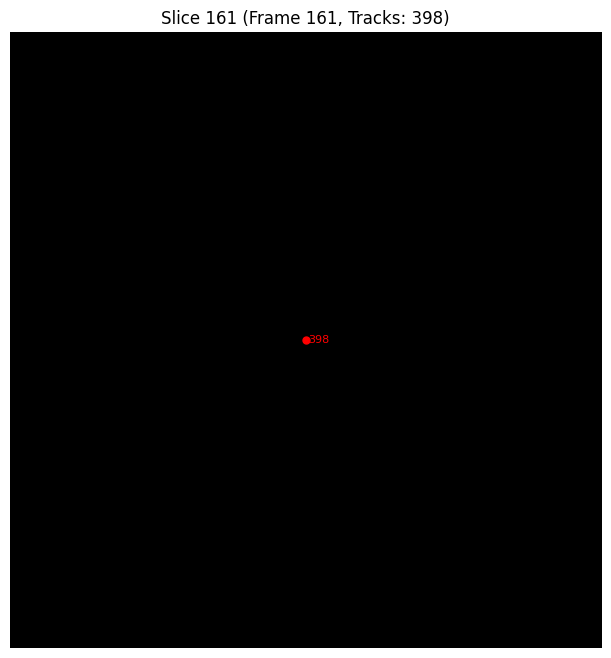

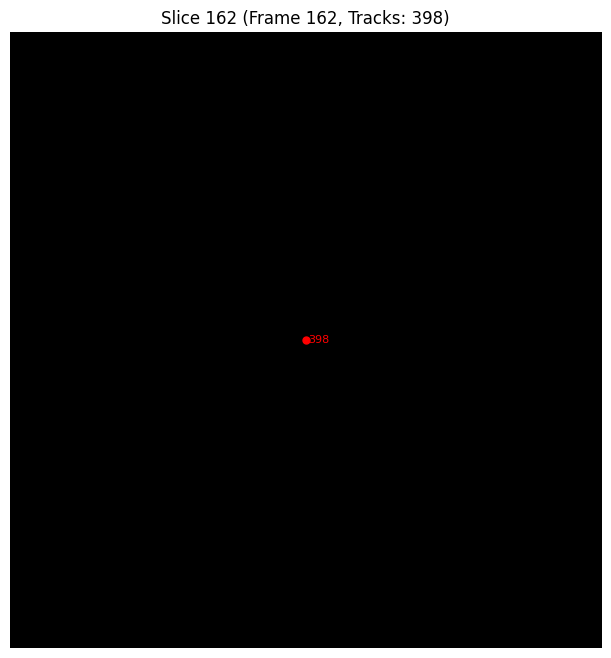

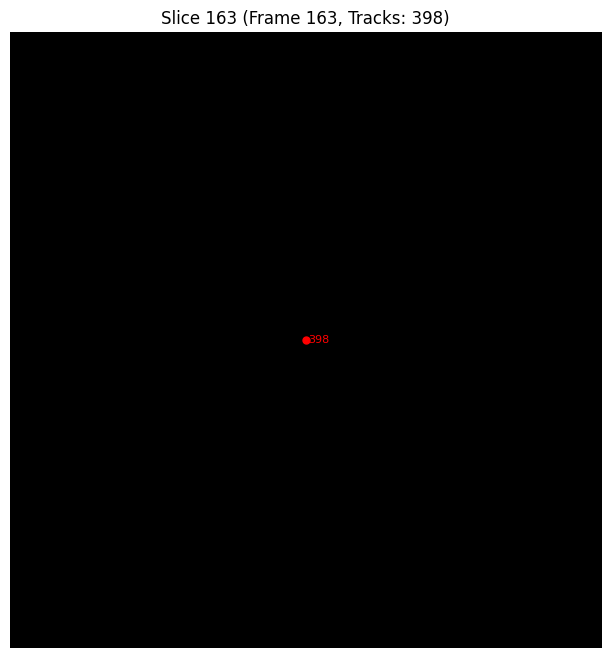

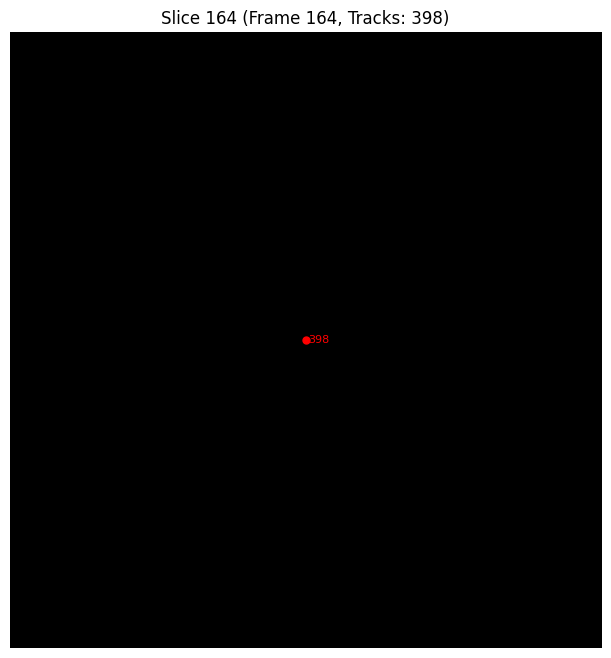

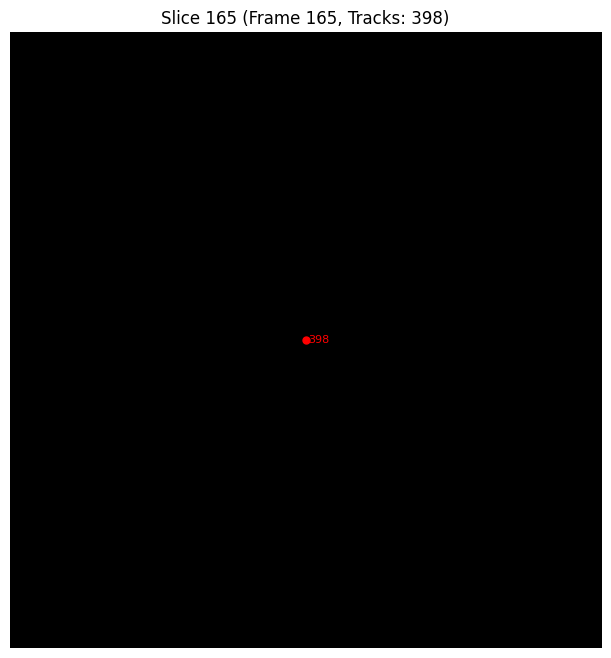

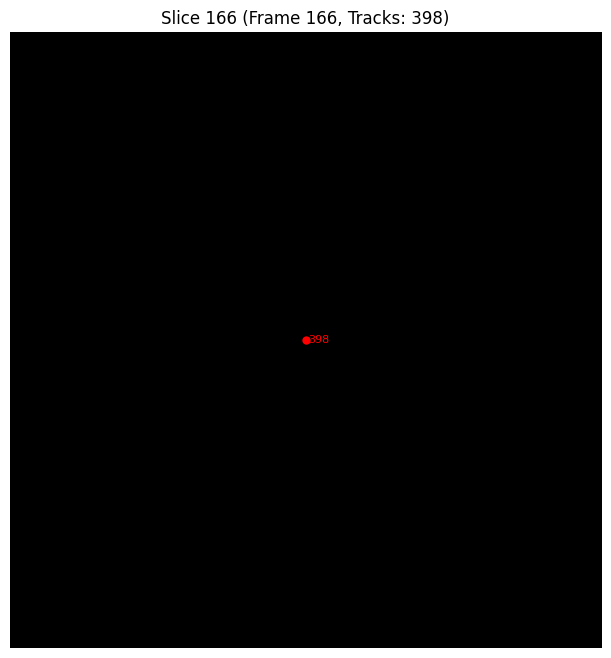

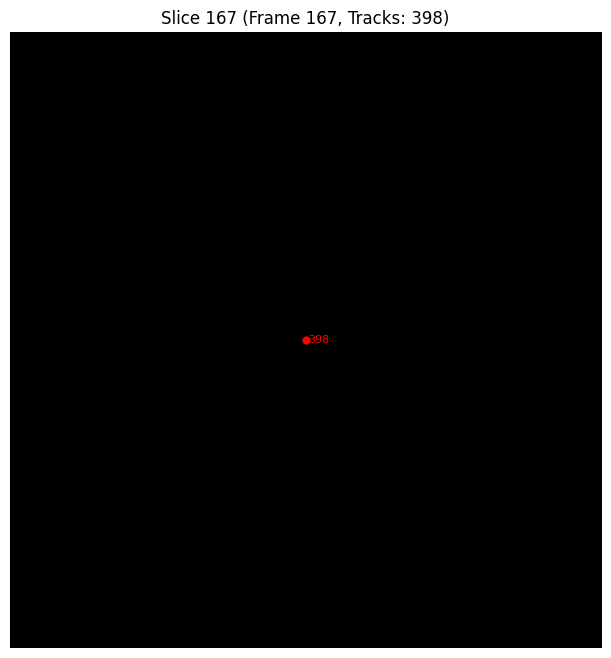

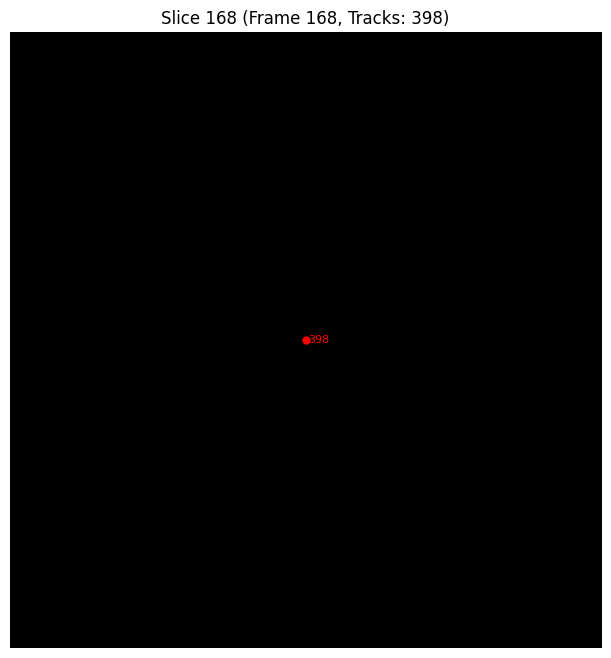

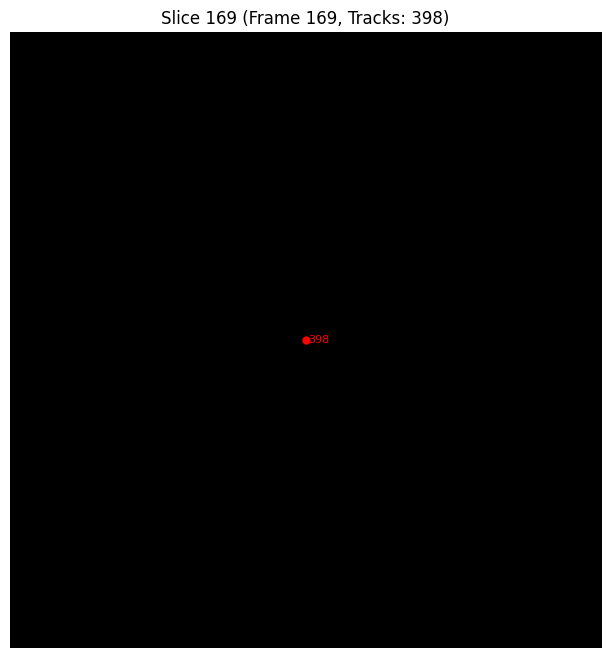

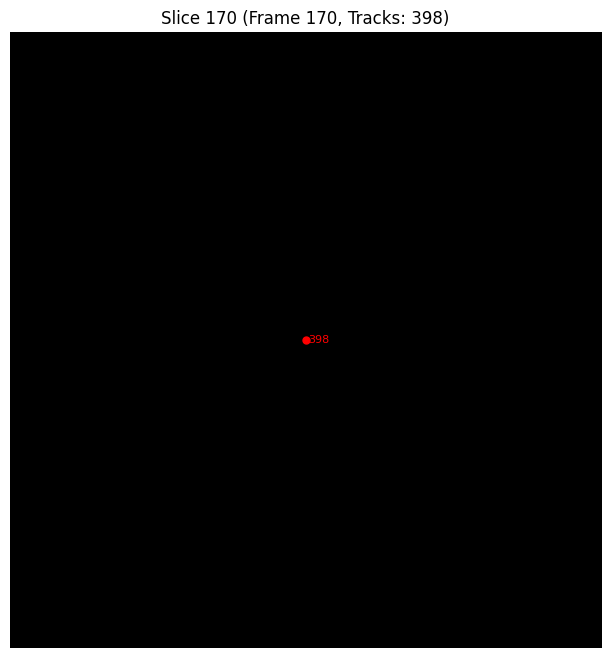

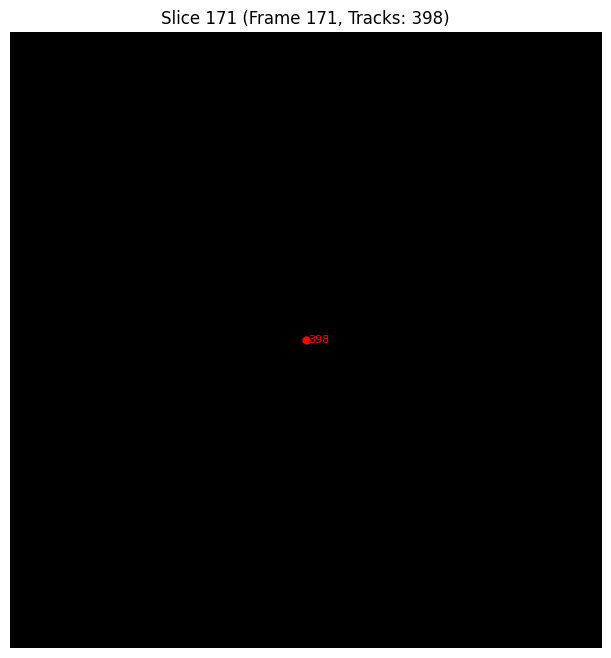

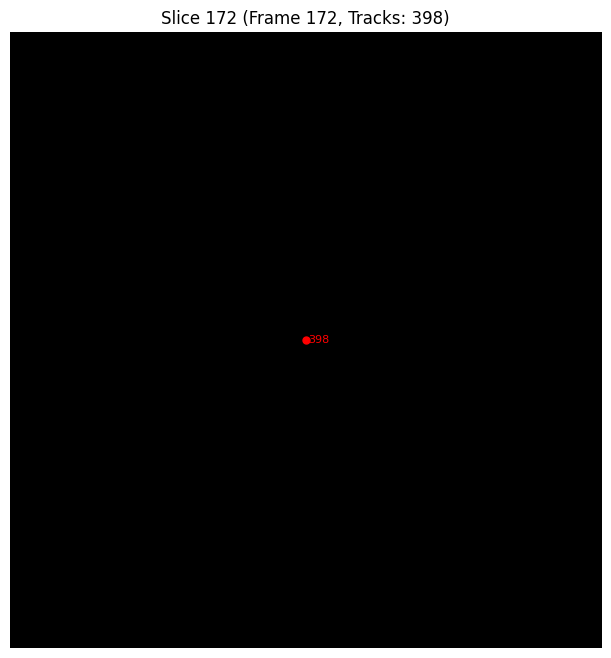

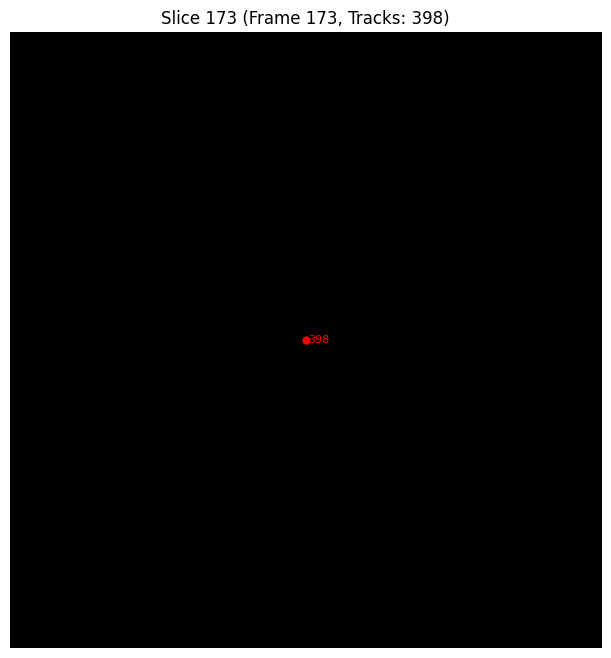

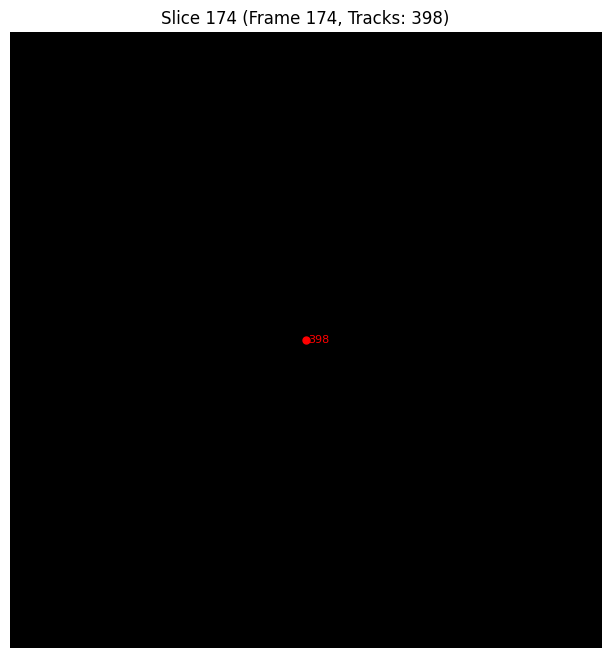

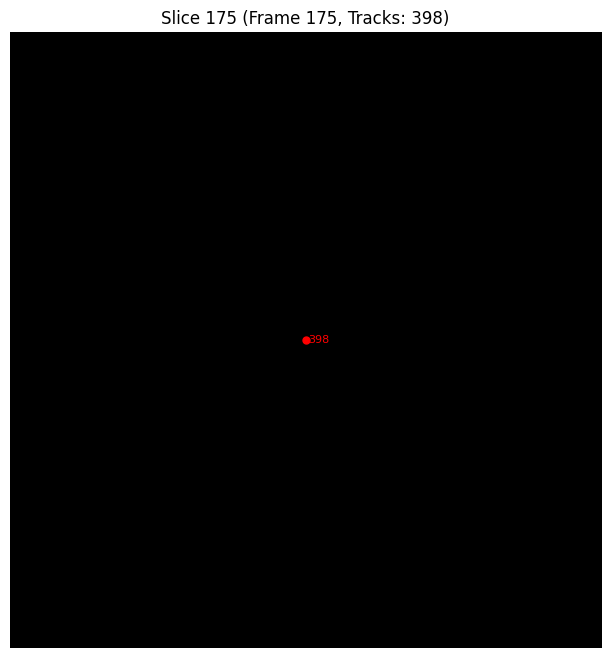

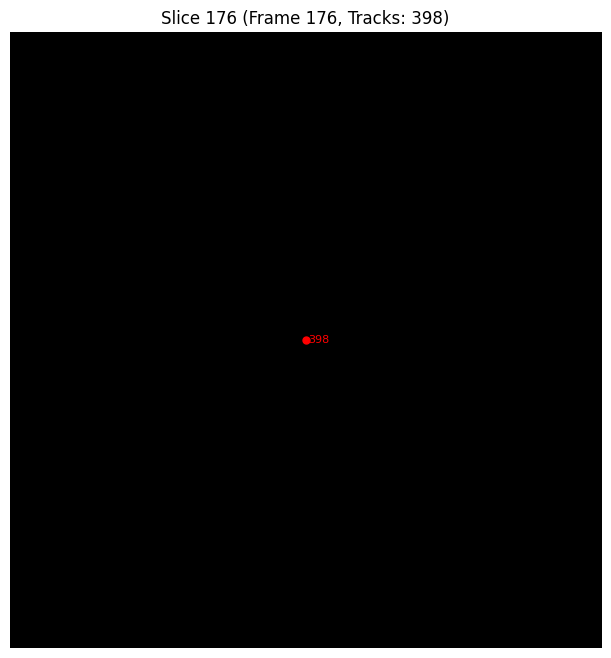

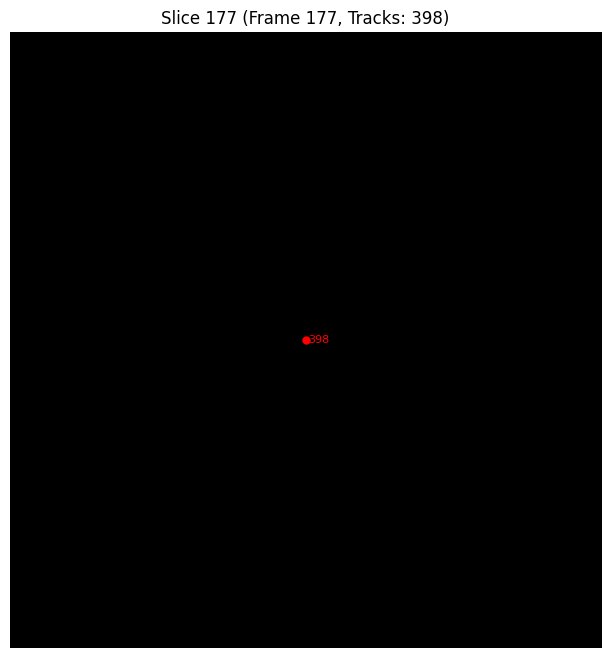

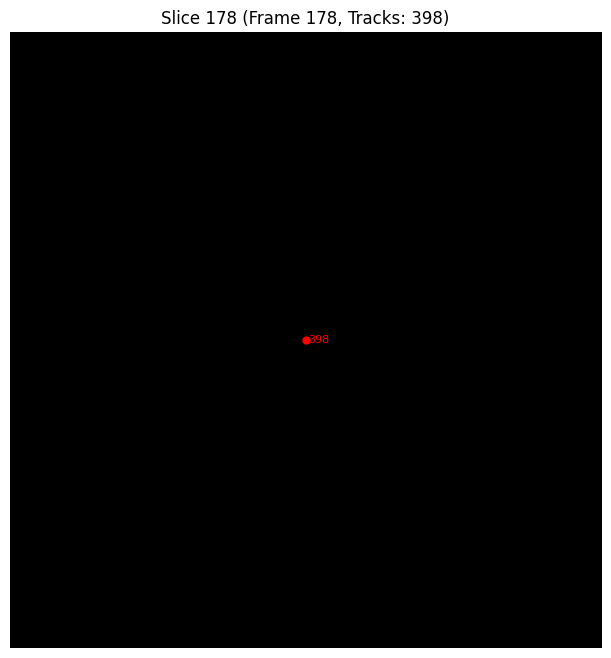

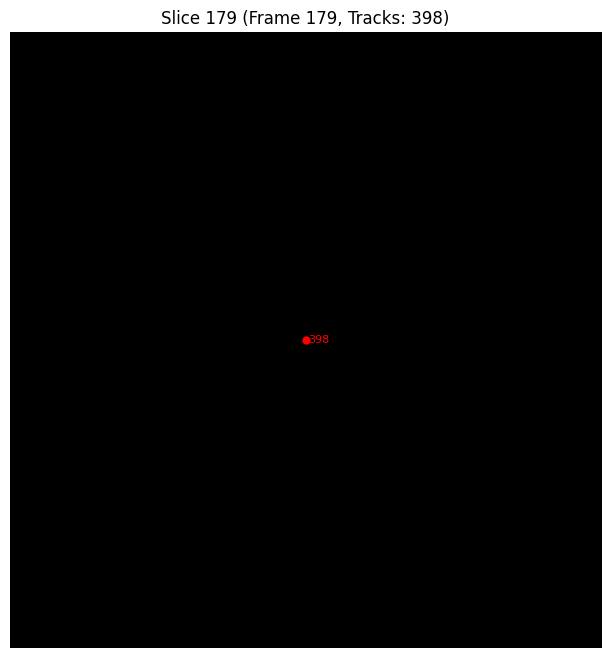

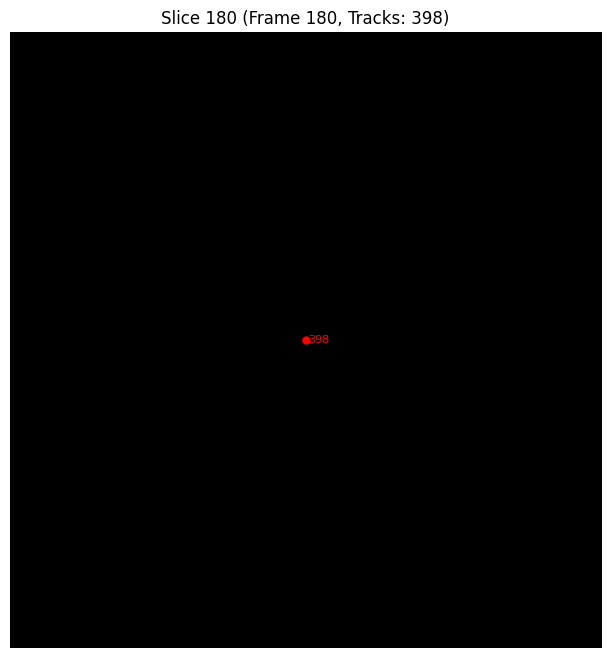

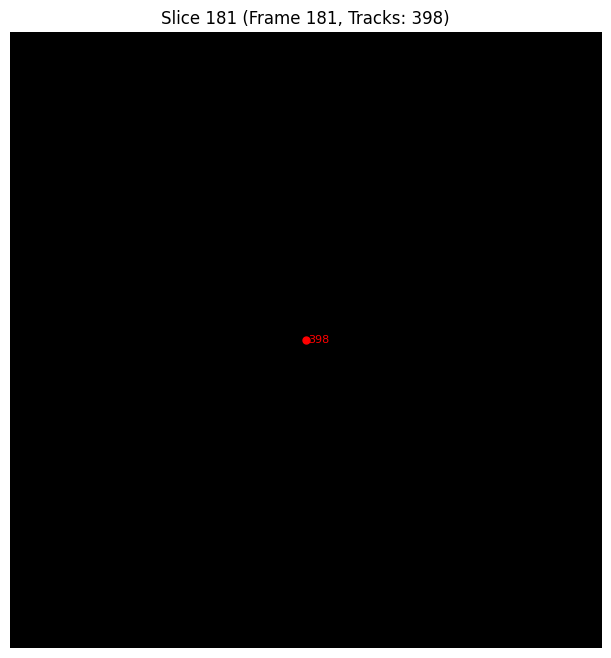

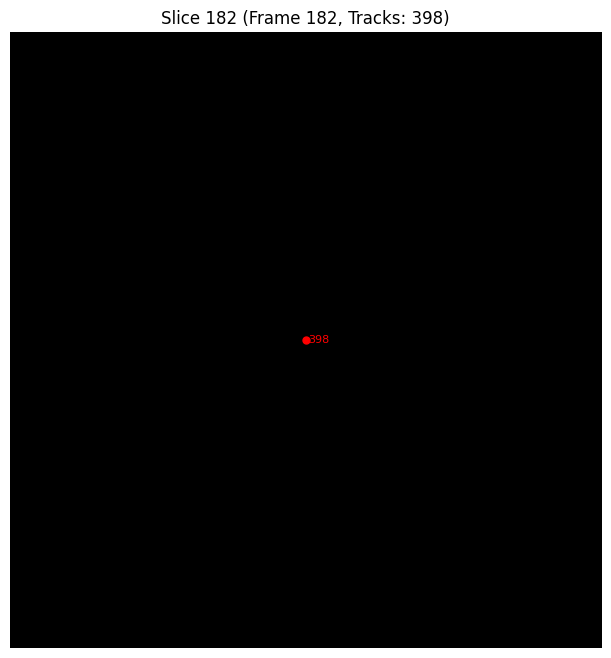

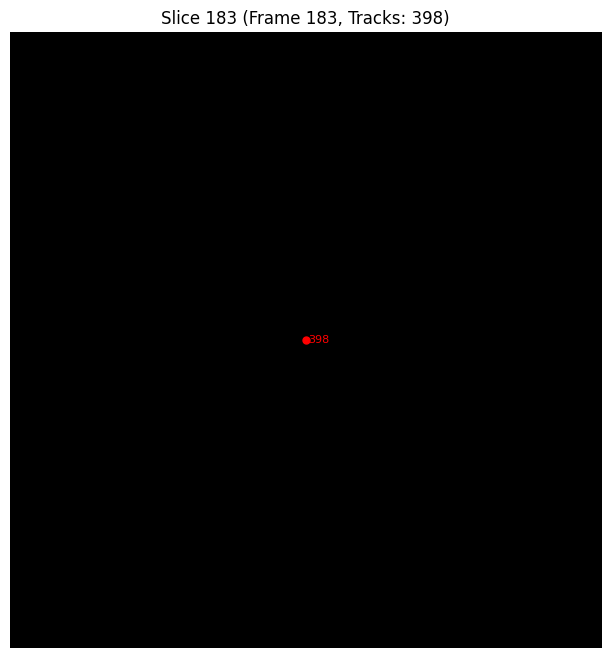

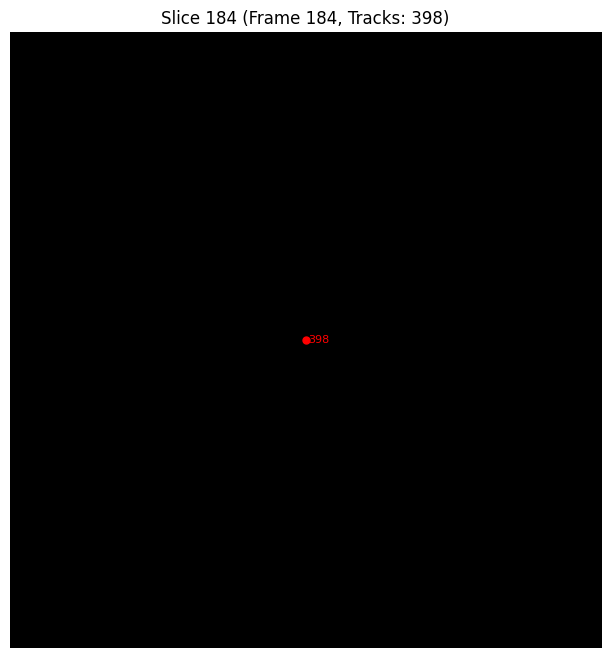

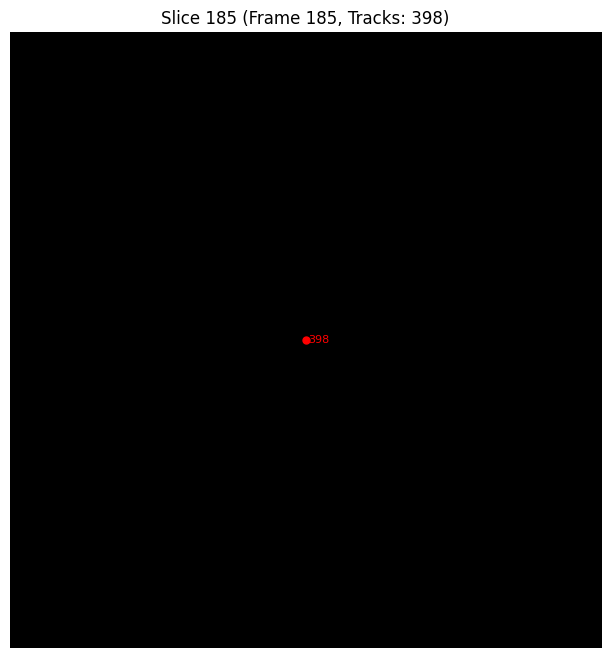

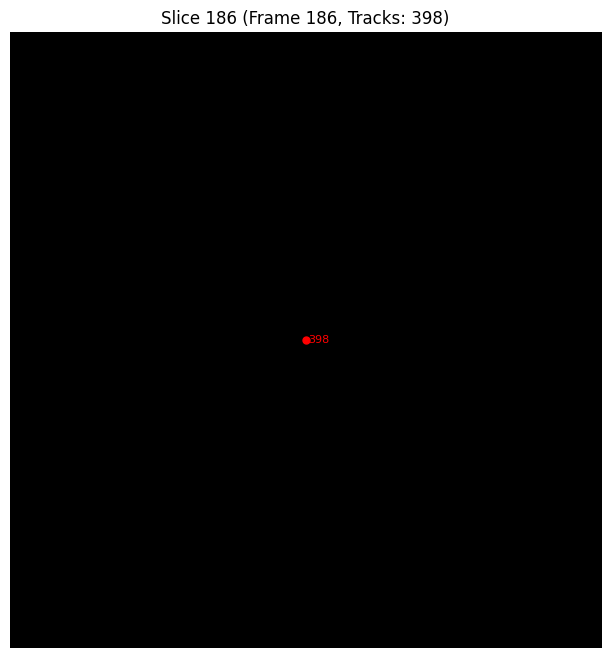

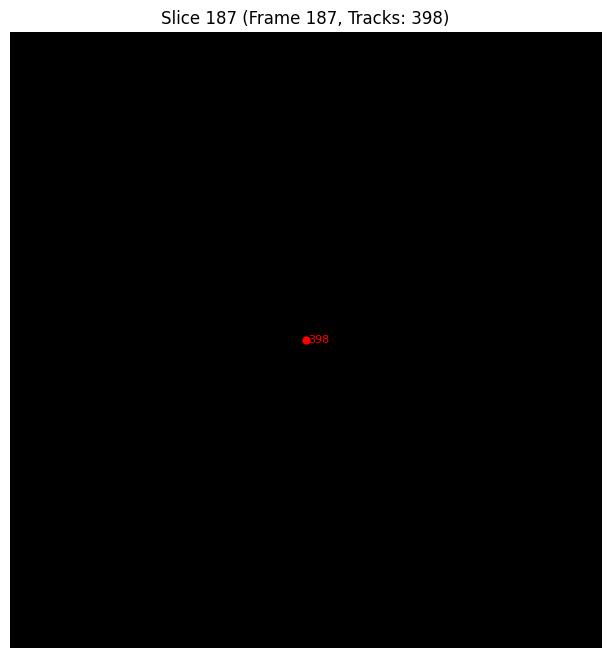

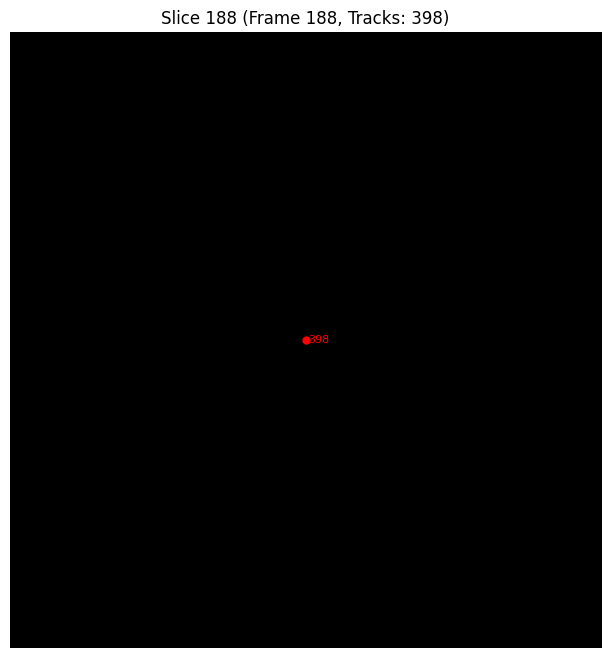

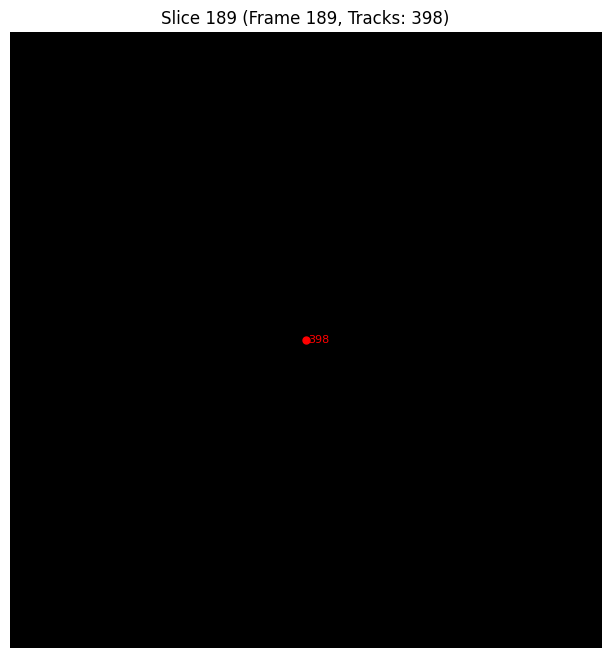

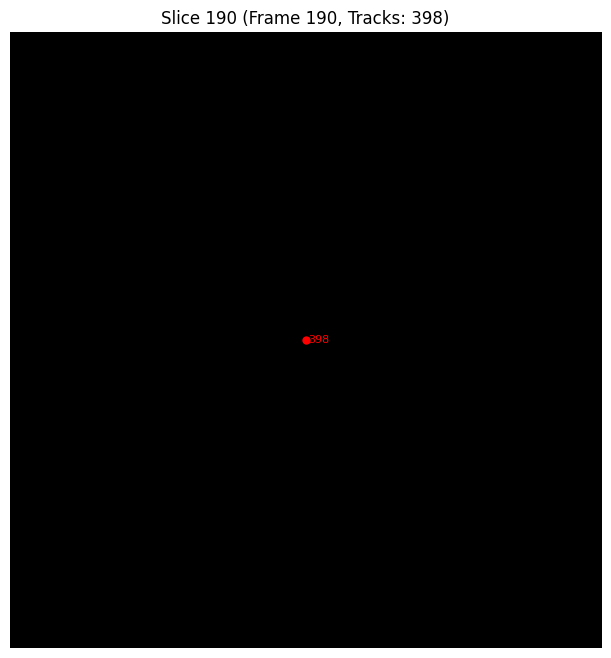

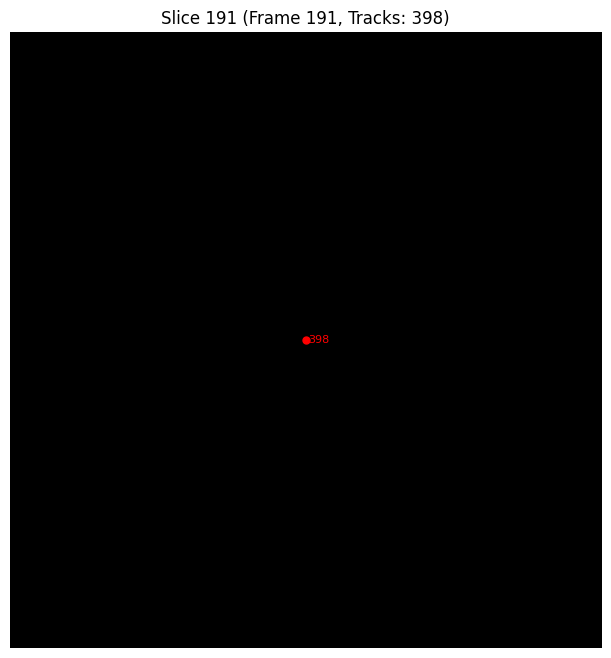

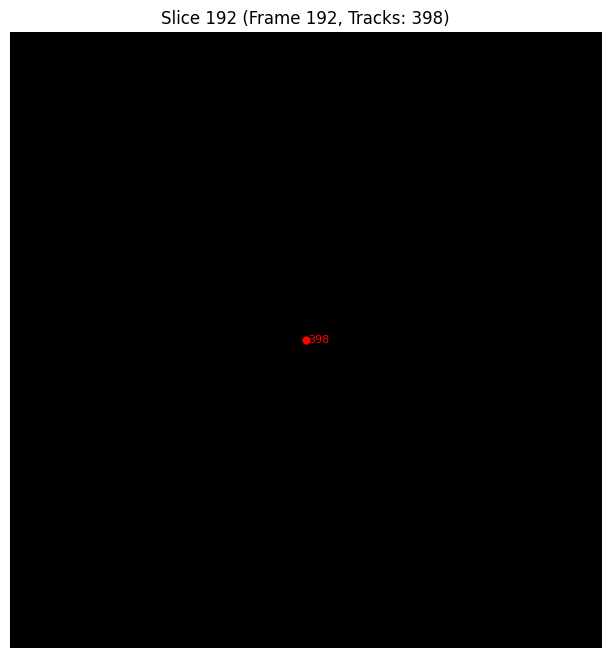

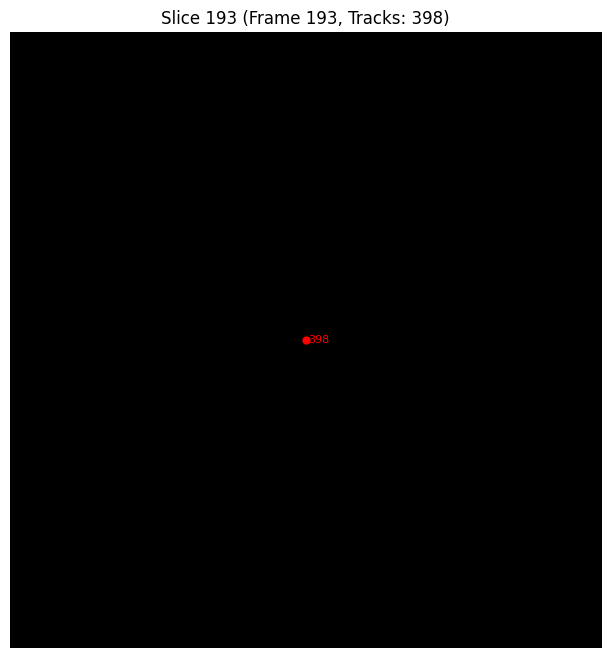

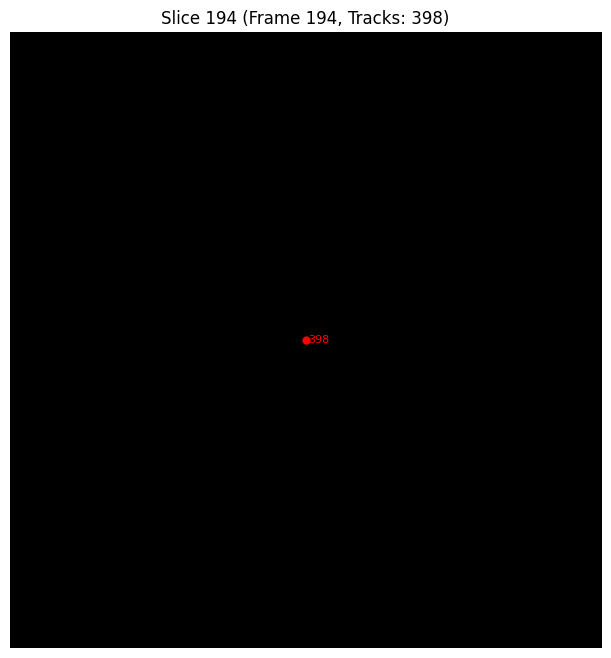

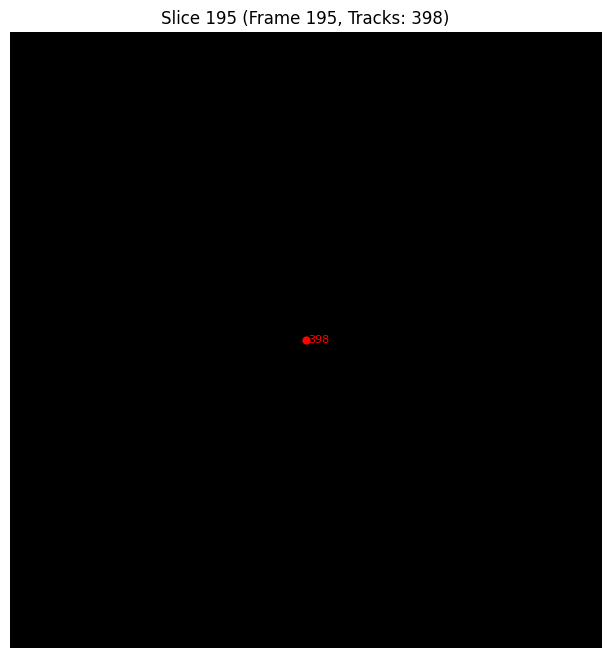

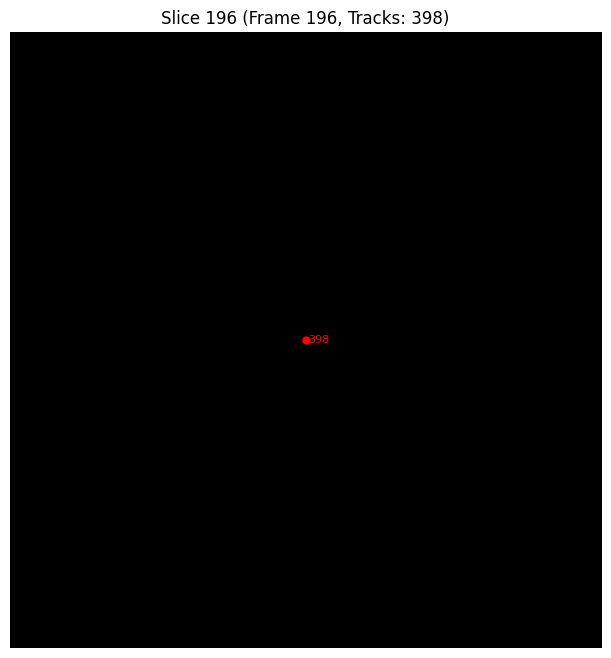

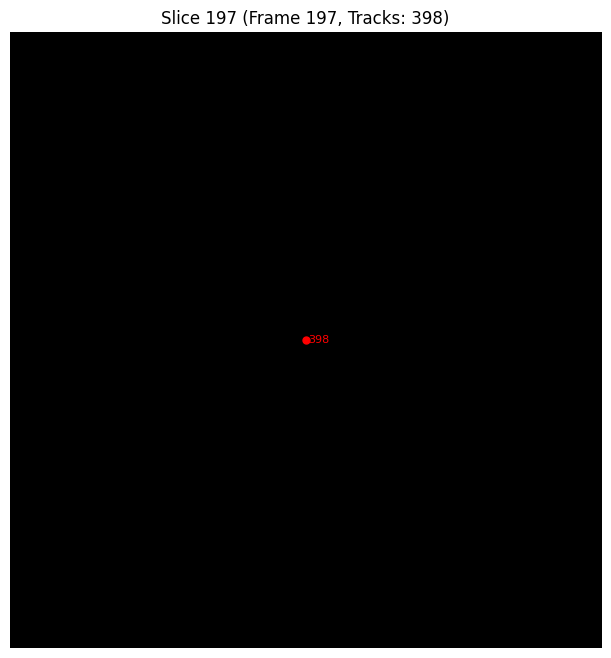

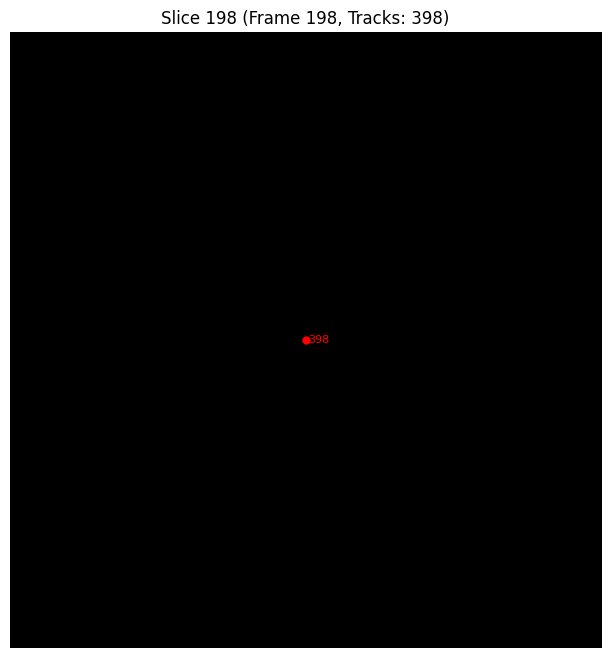

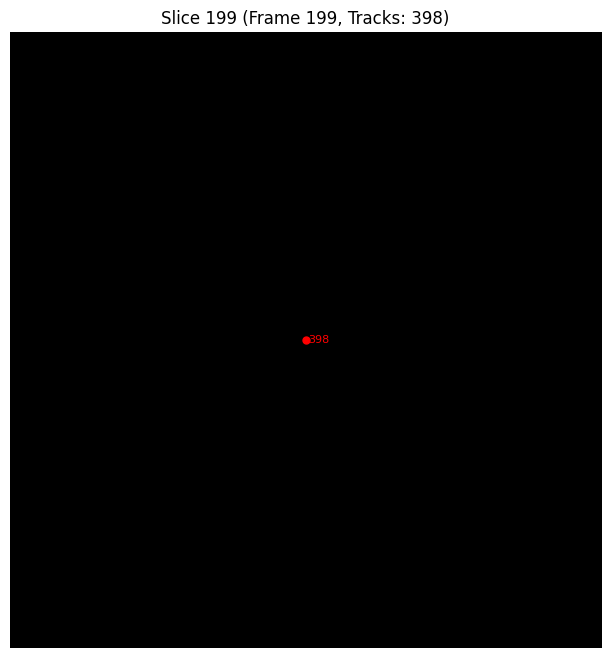

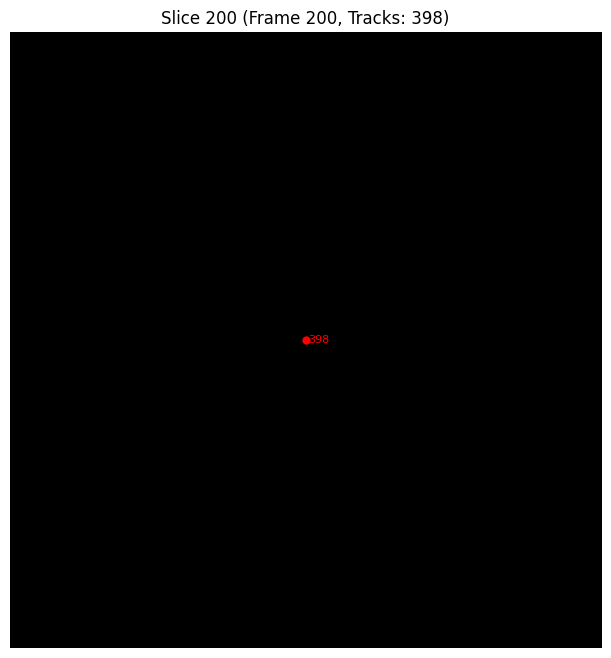

✅ Tracking overlays saved to: /Users/ariellerothman/Desktop/Full Sperm cell Stacks/Sperm 16/Mito tracking/temp_overlays
  ✅ Overlays saved to: /Users/ariellerothman/Desktop/Full Sperm cell Stacks/Sperm 16/Mito tracking/temp_overlays

Processing MO...


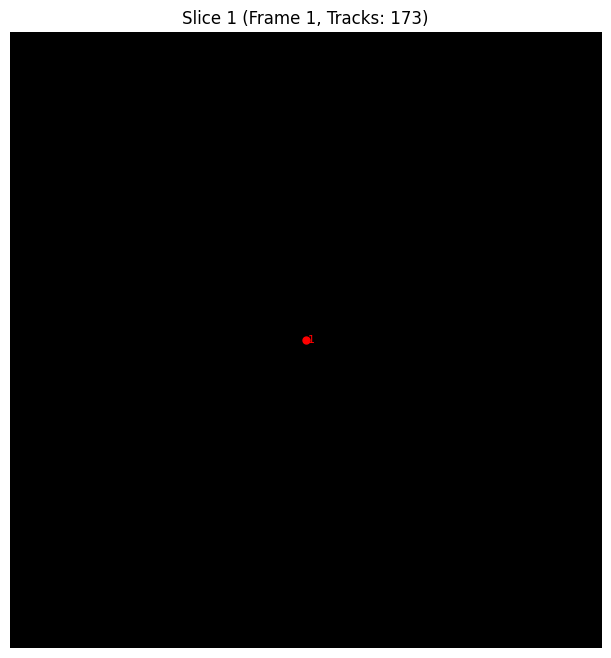

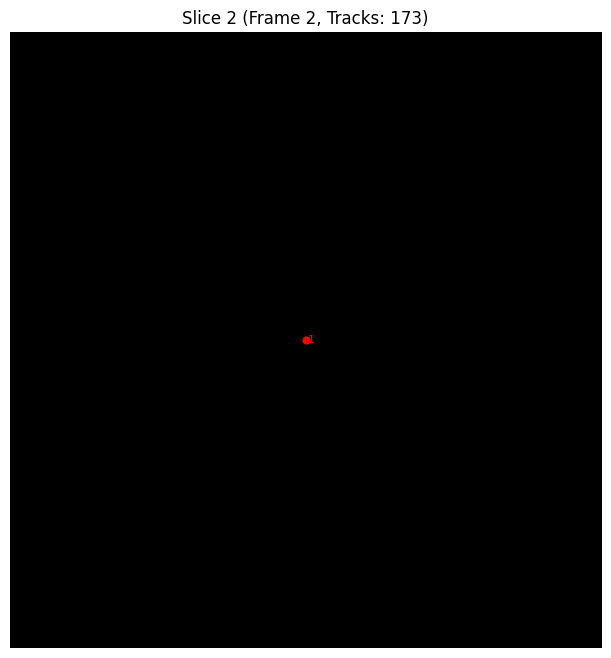

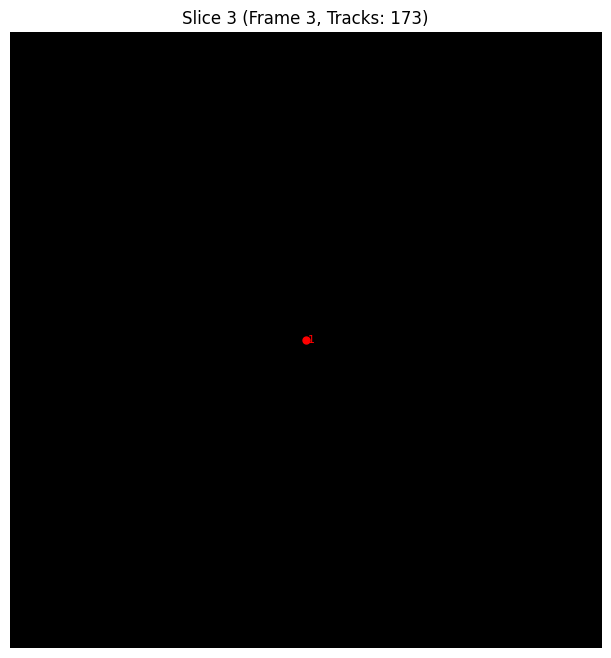

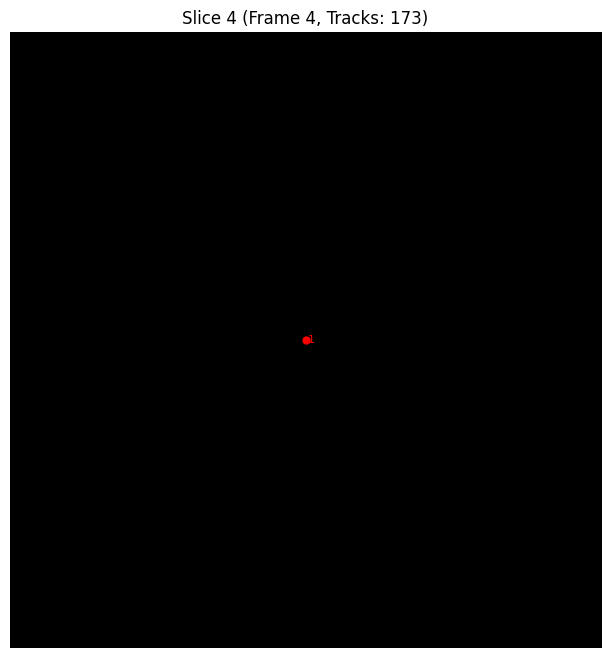

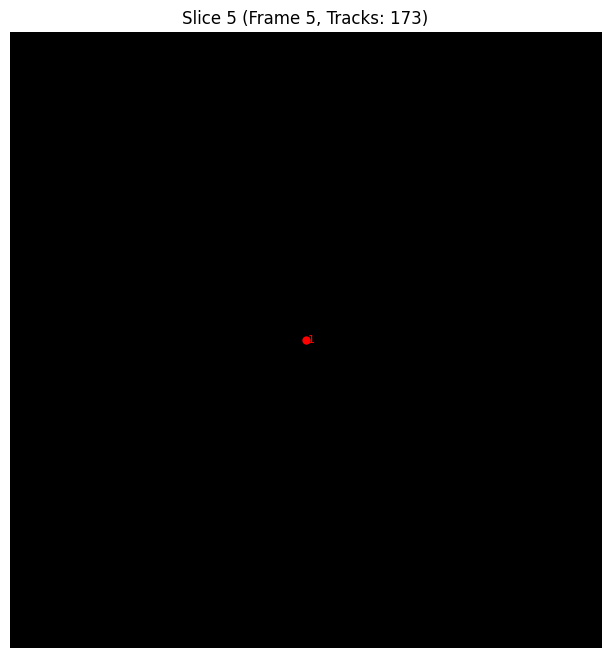

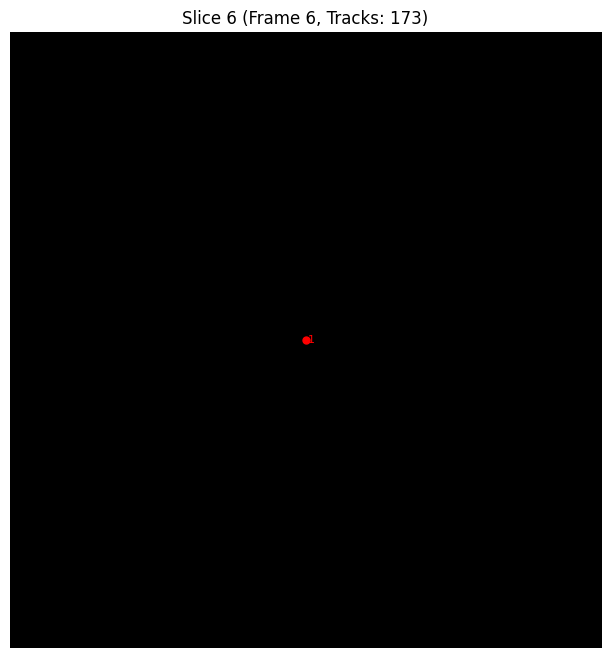

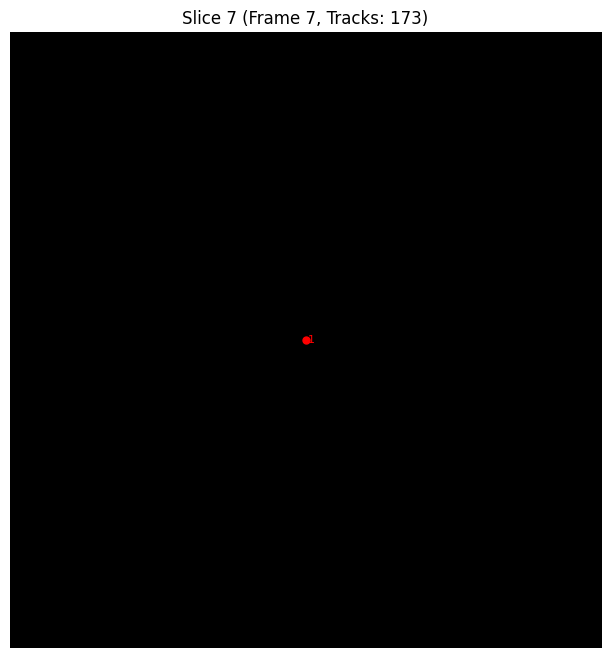

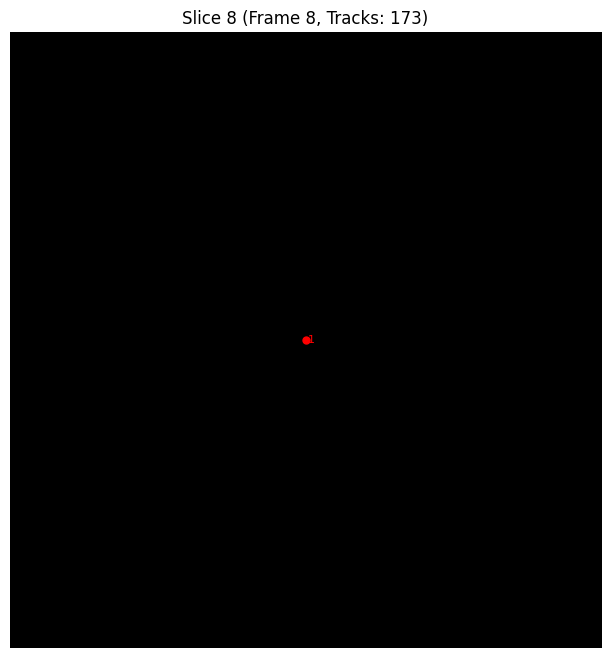

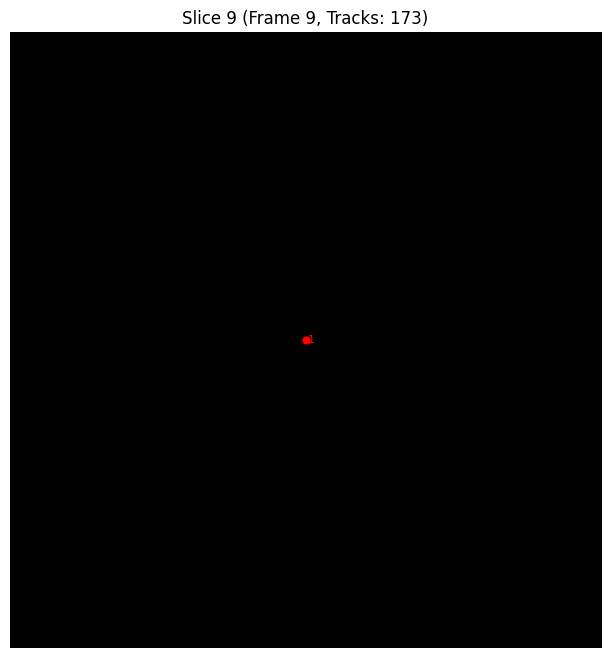

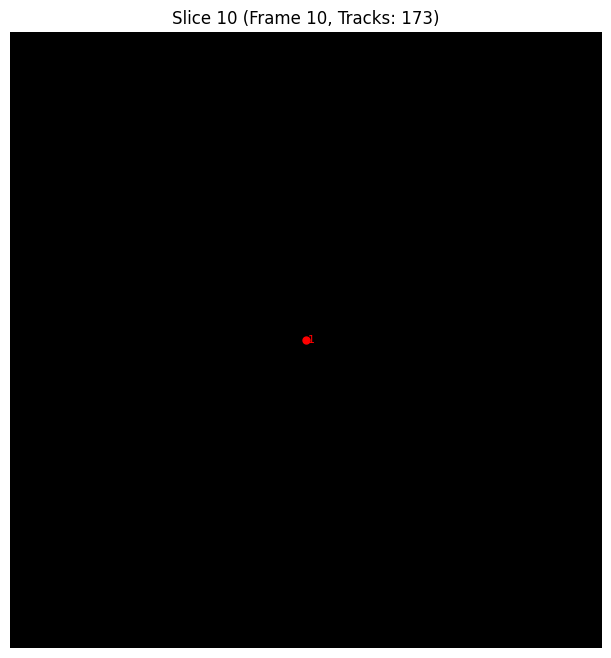

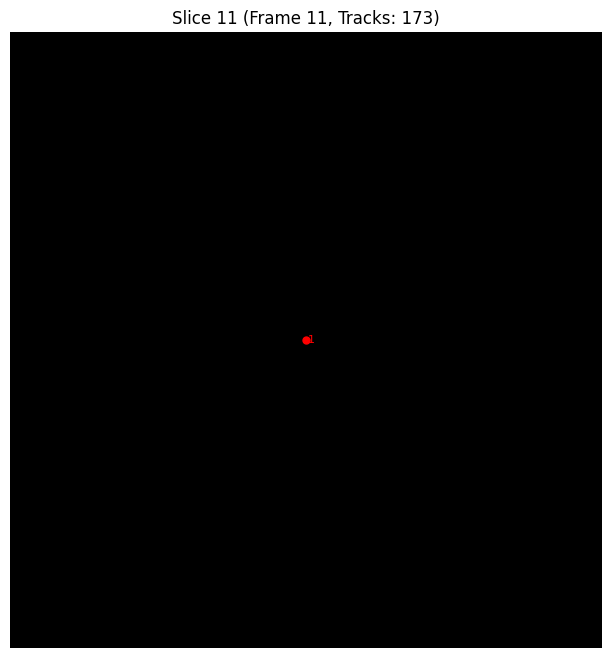

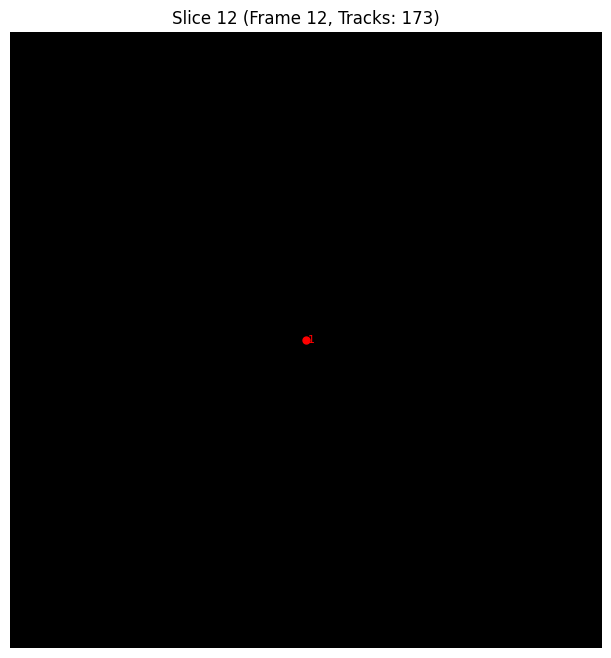

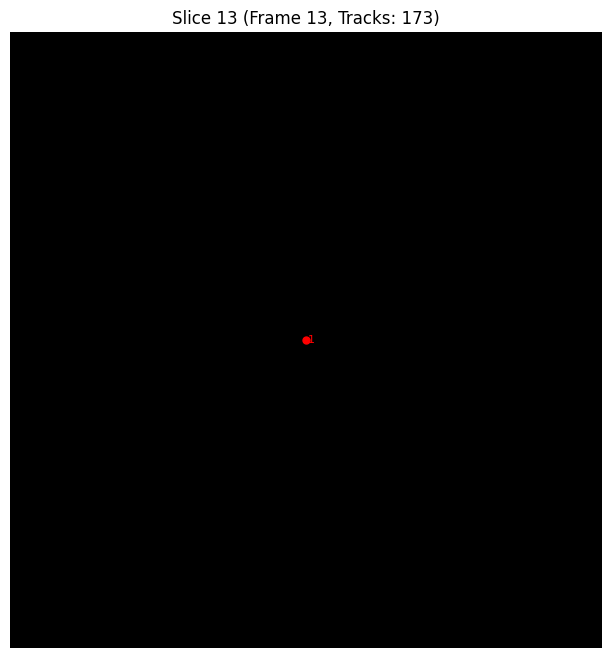

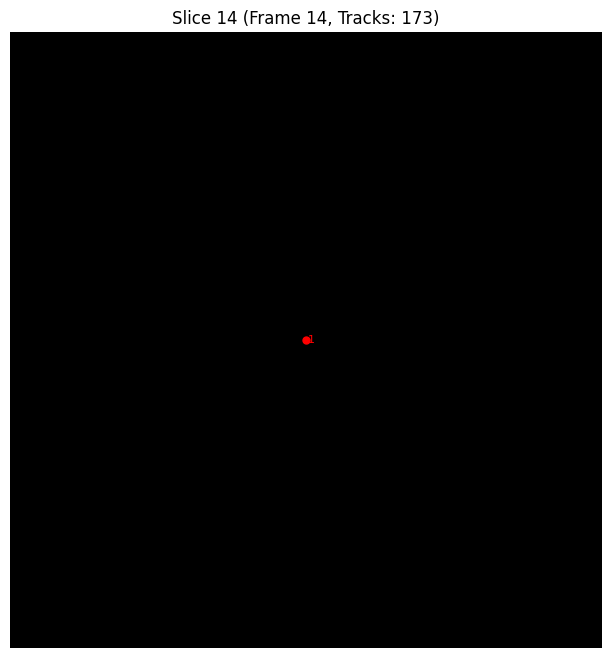

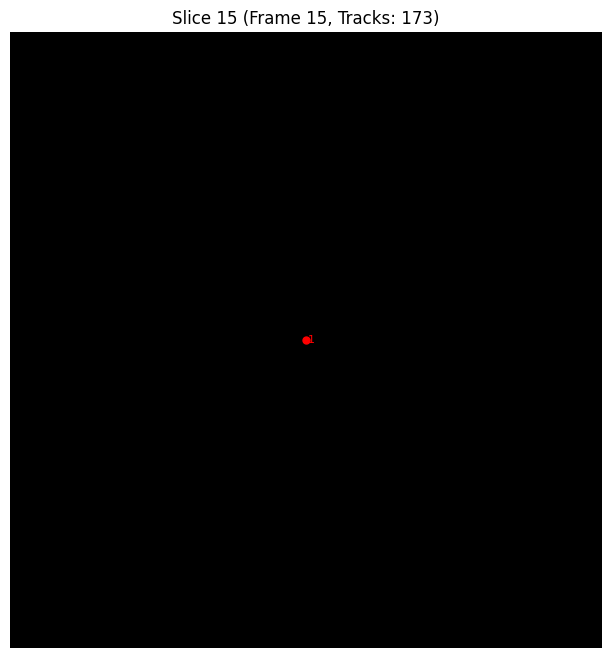

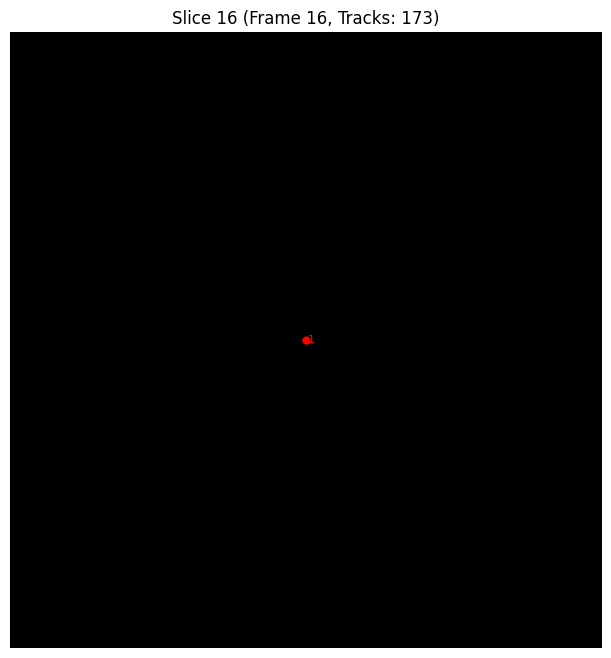

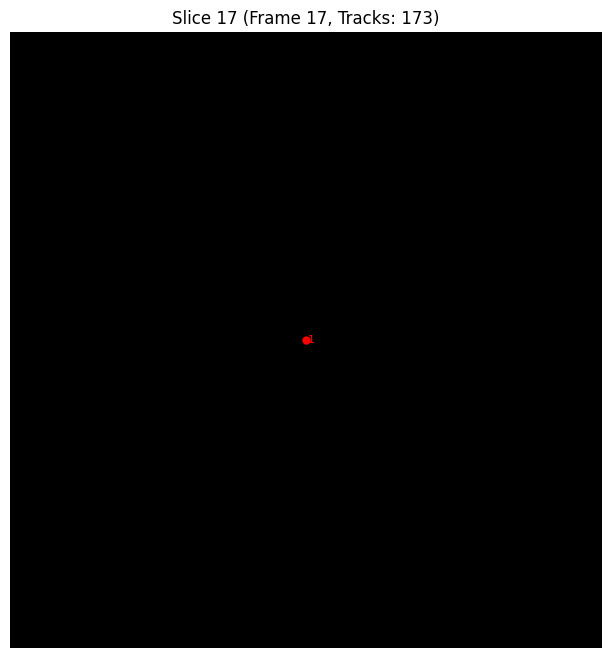

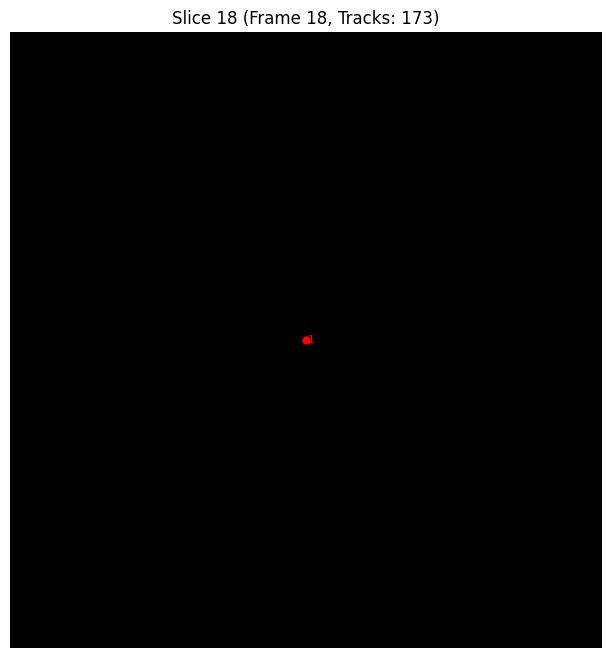

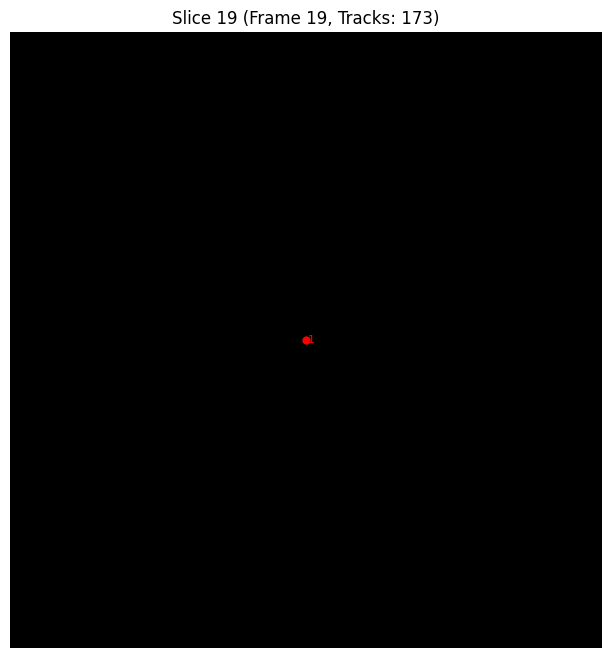

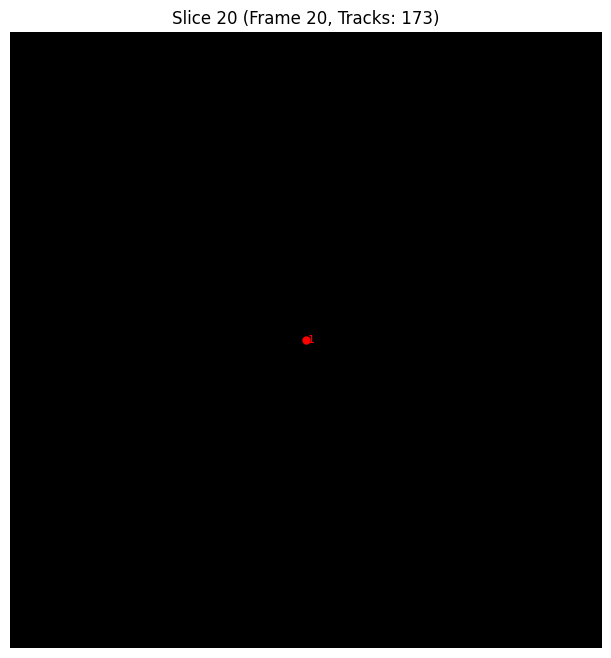

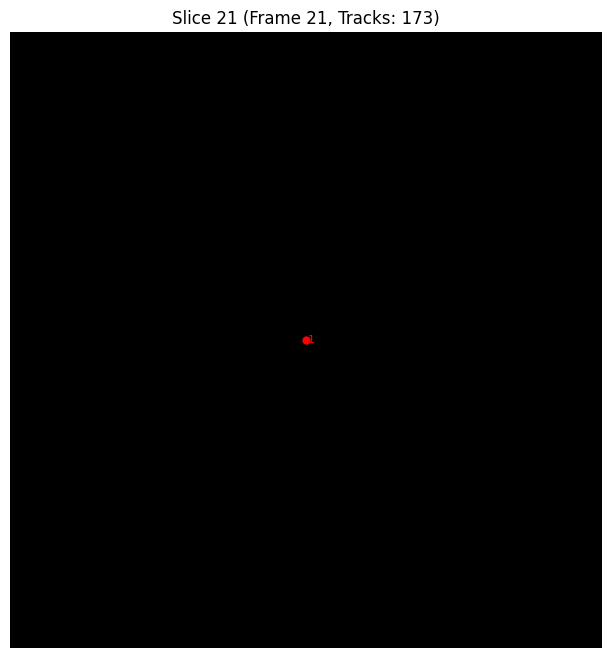

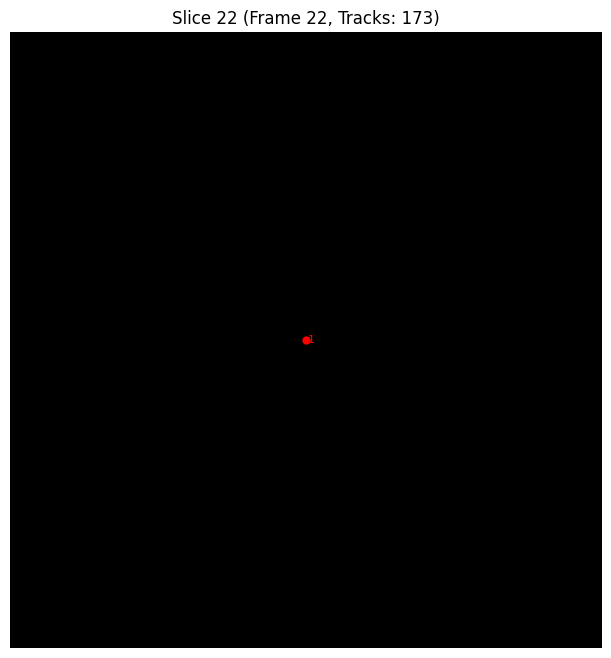

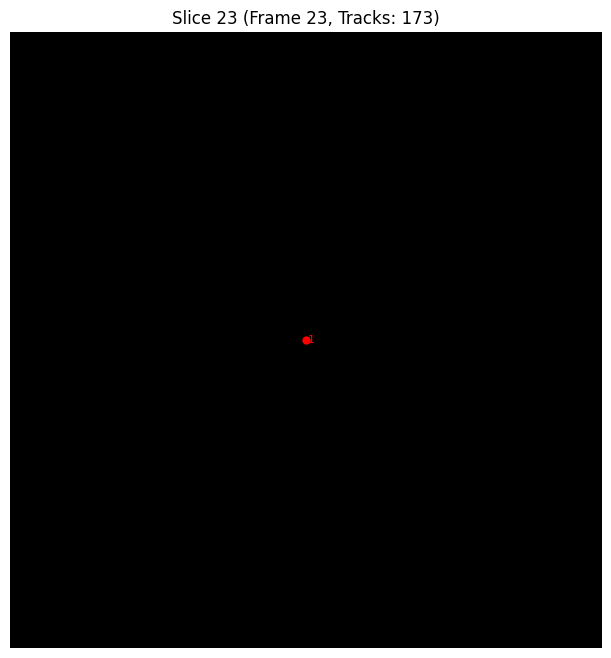

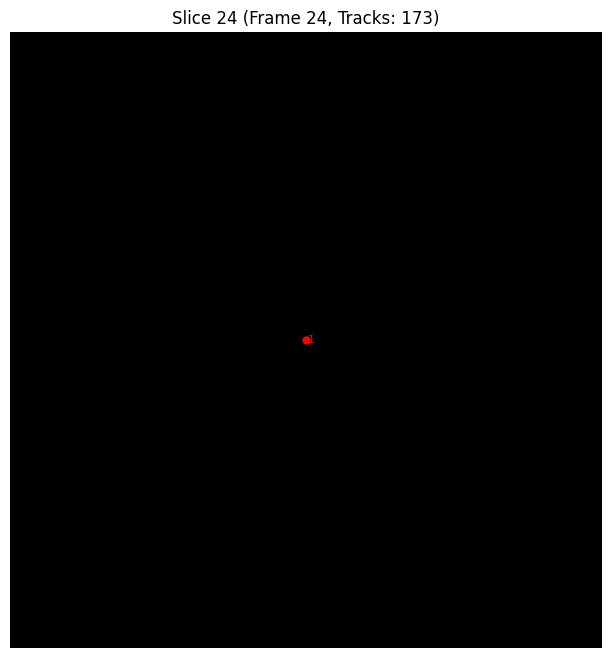

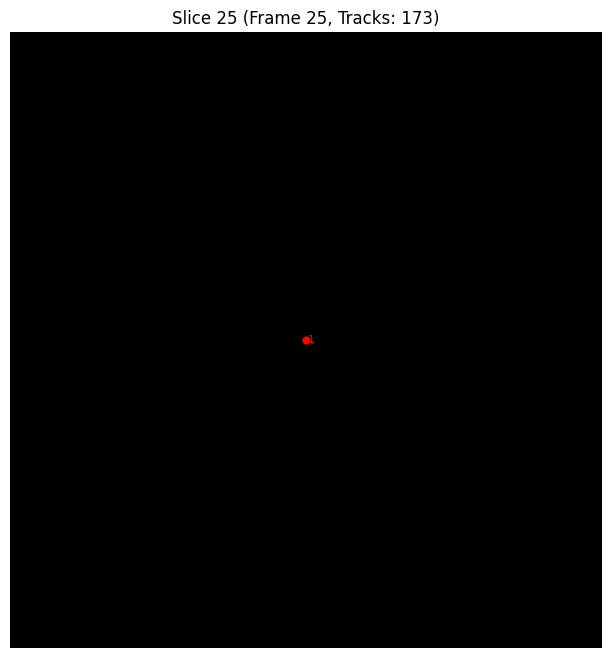

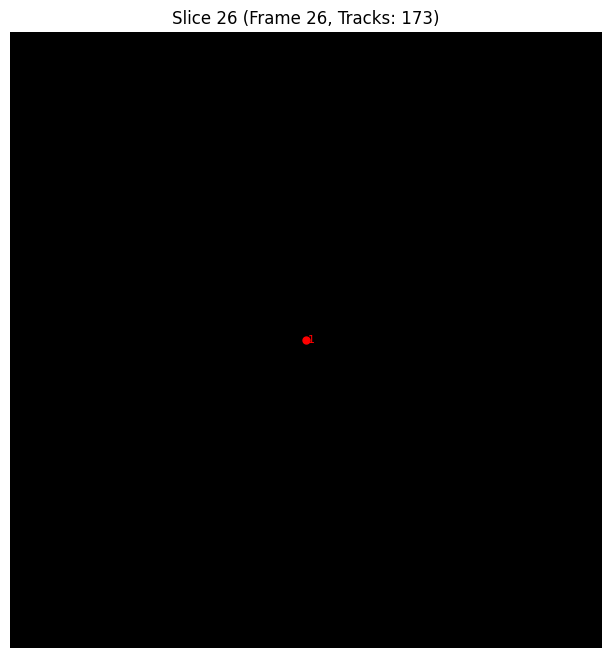

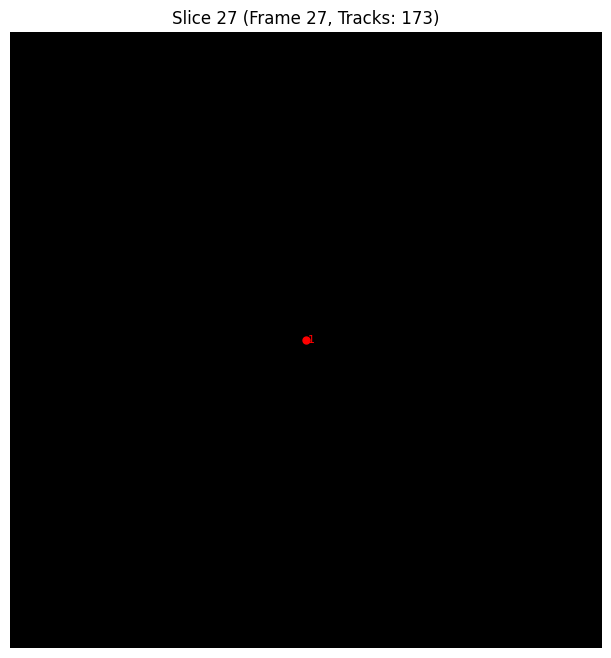

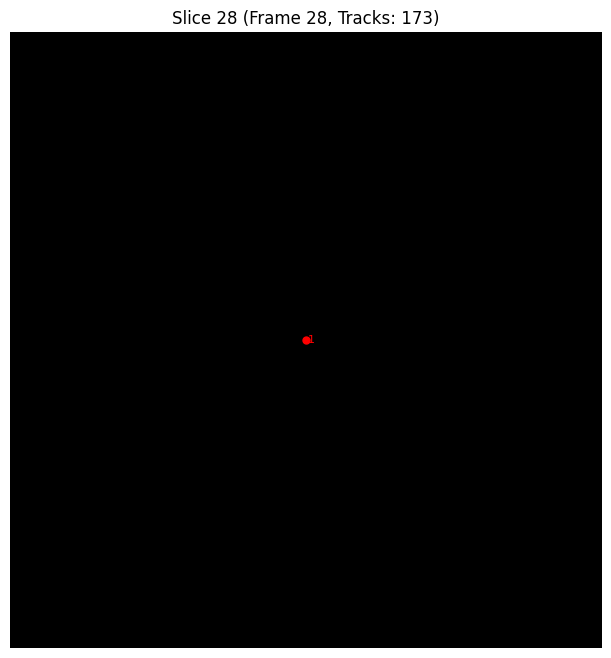

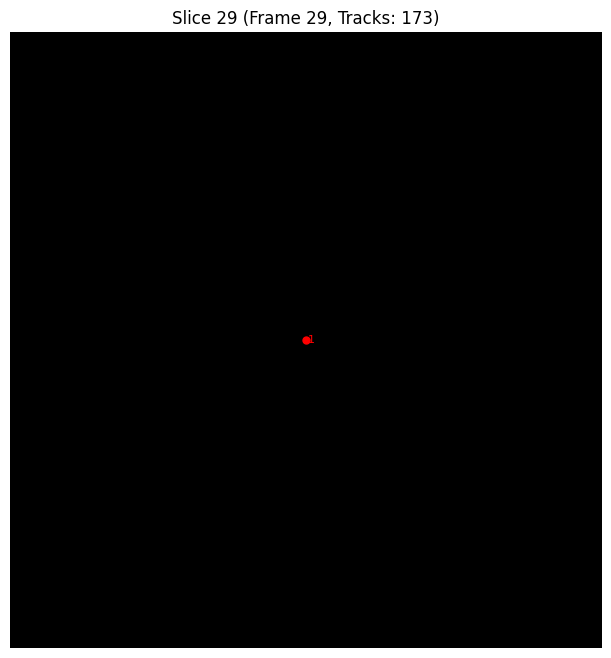

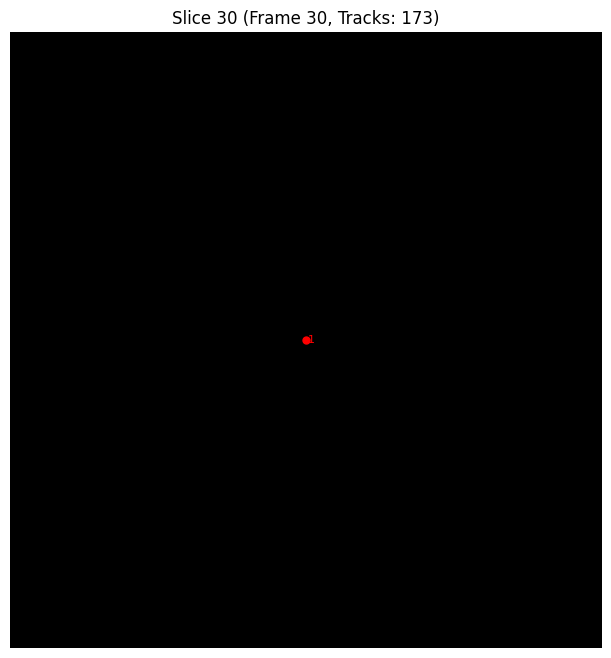

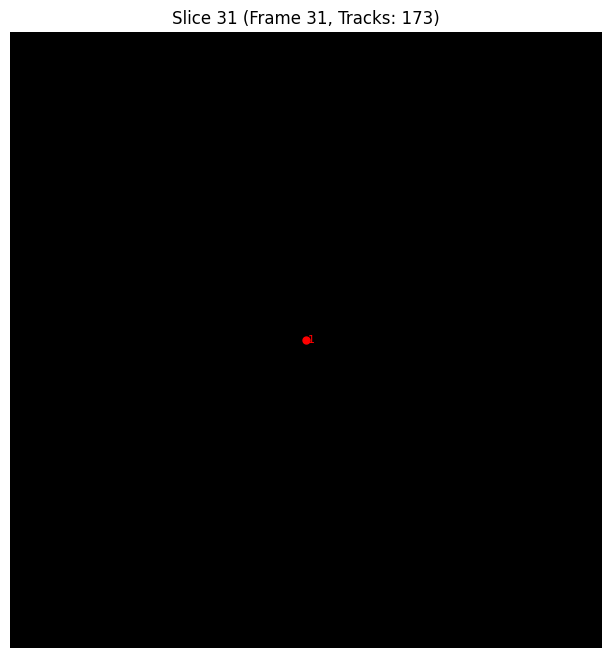

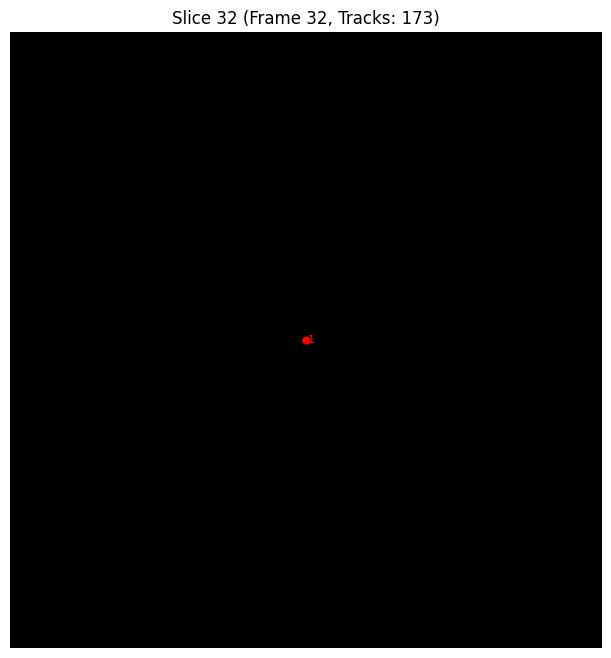

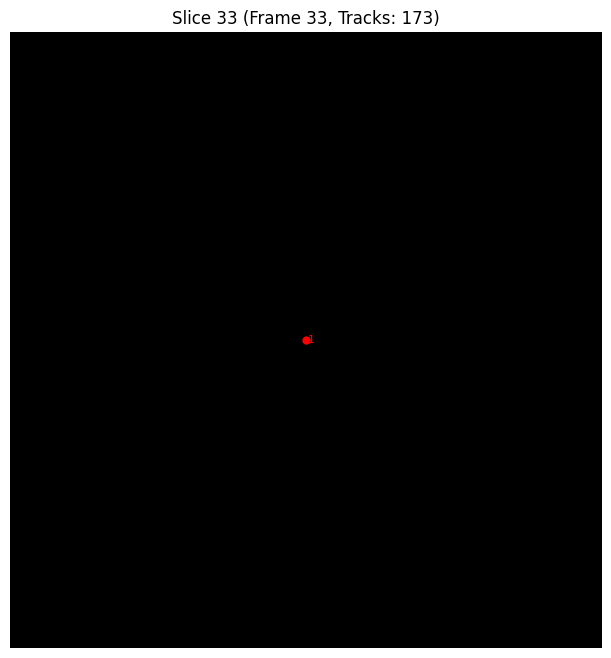

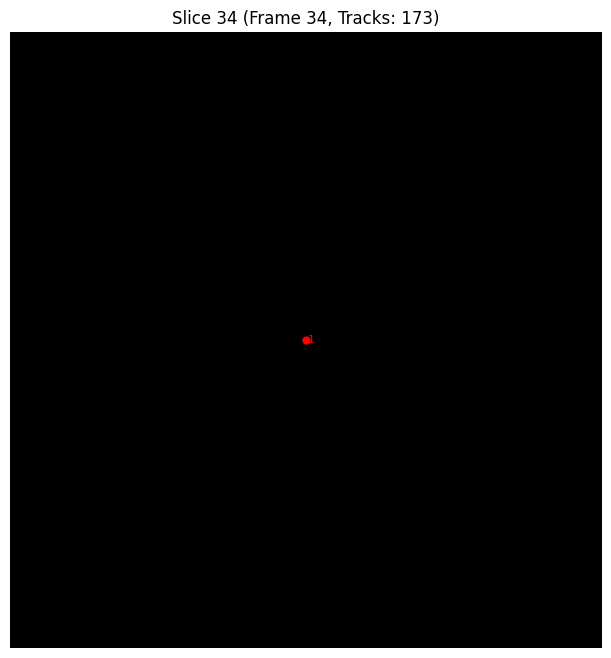

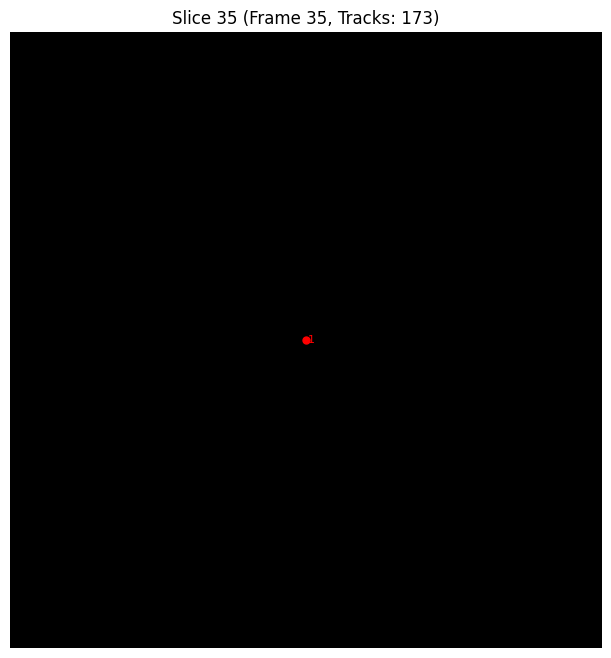

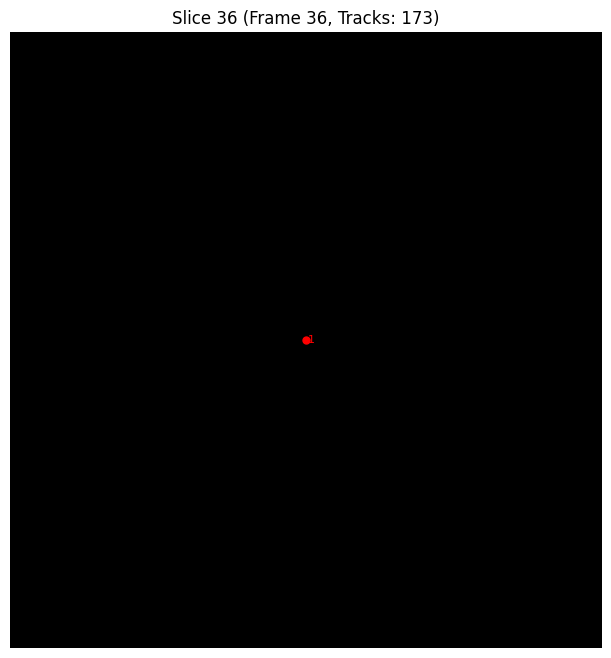

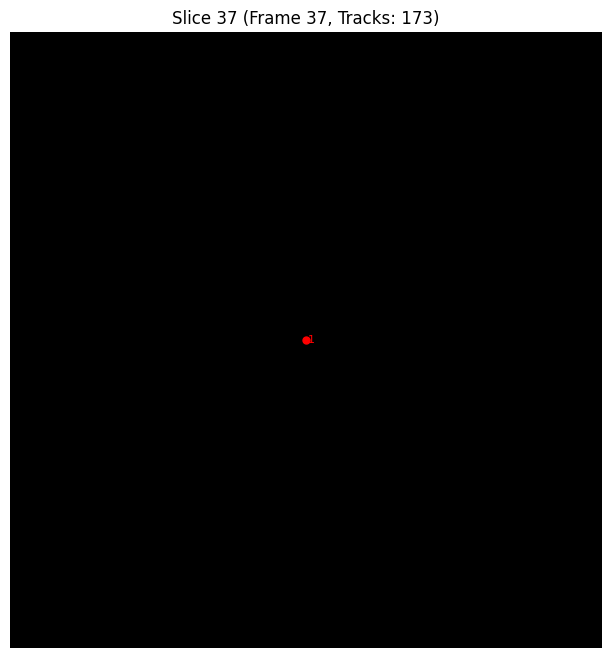

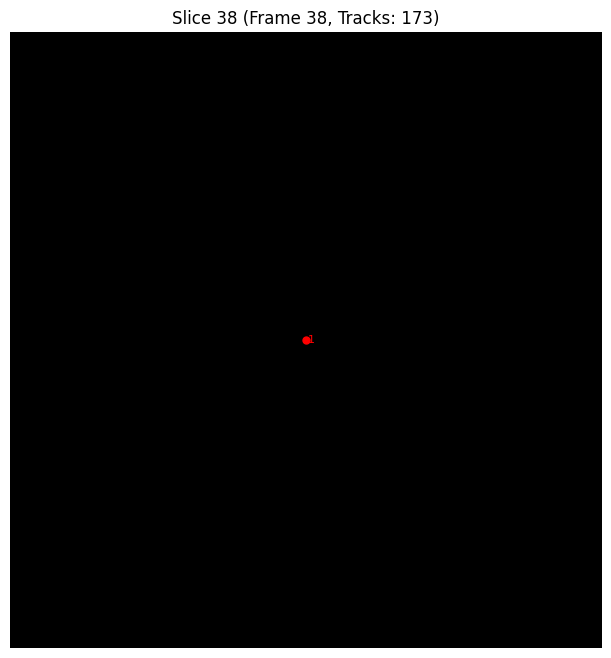

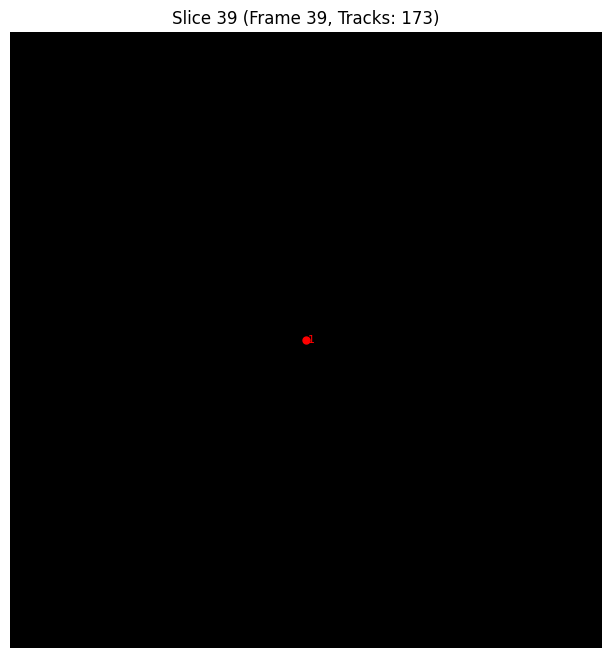

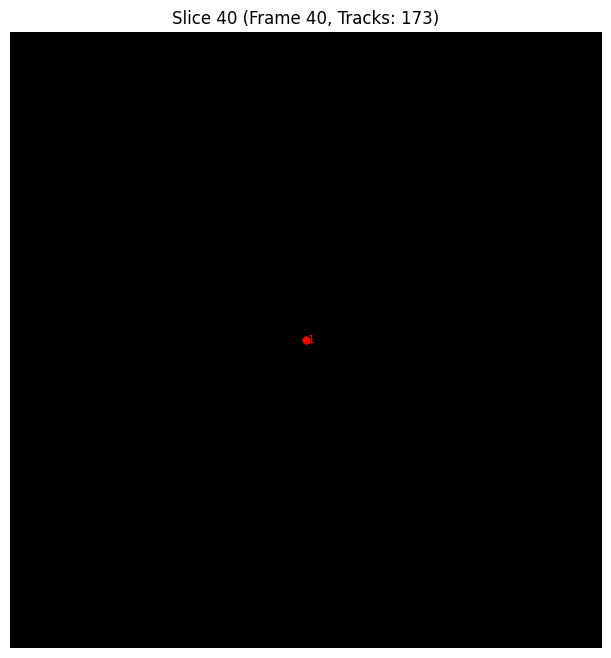

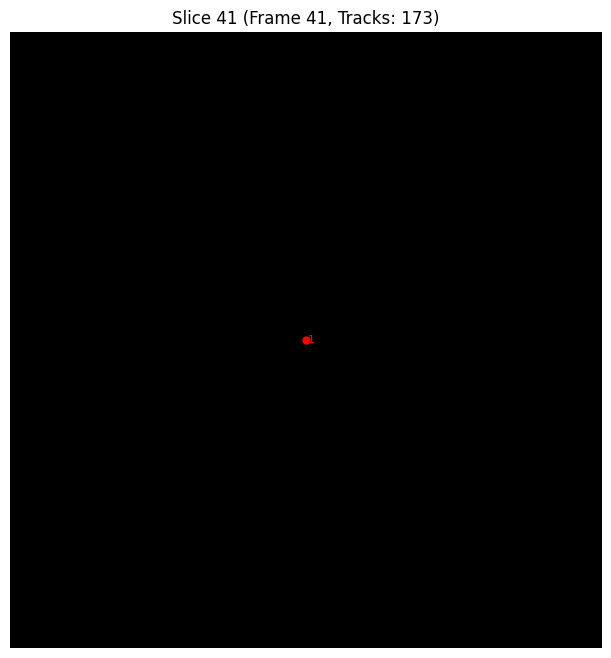

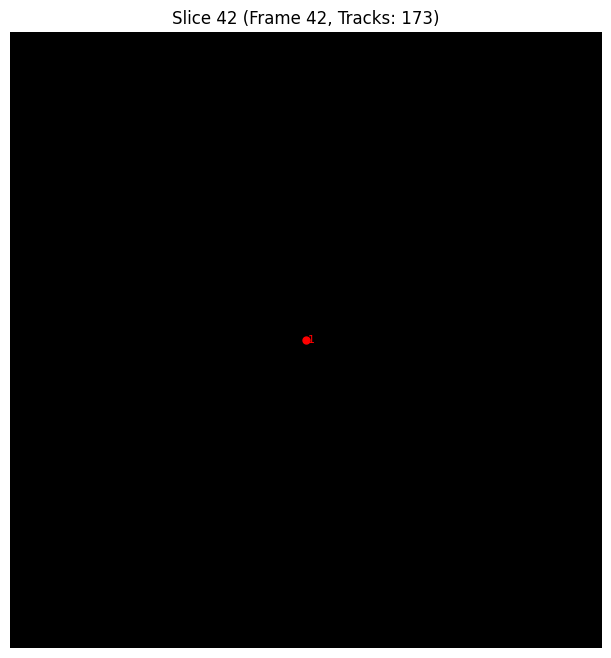

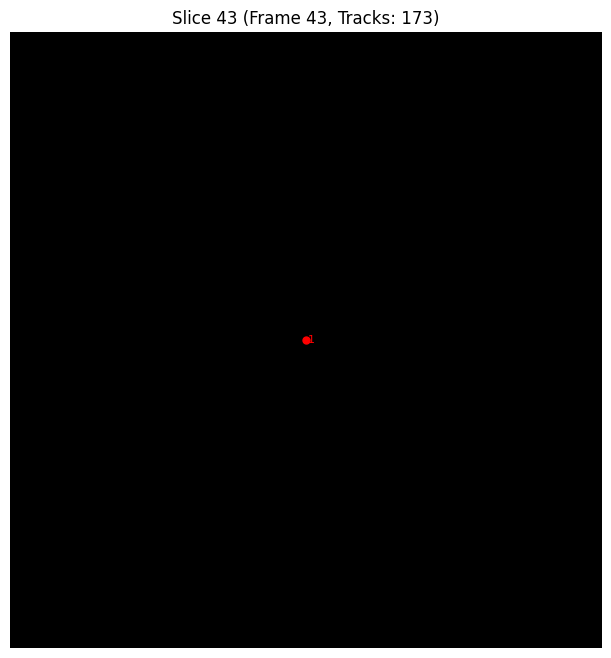

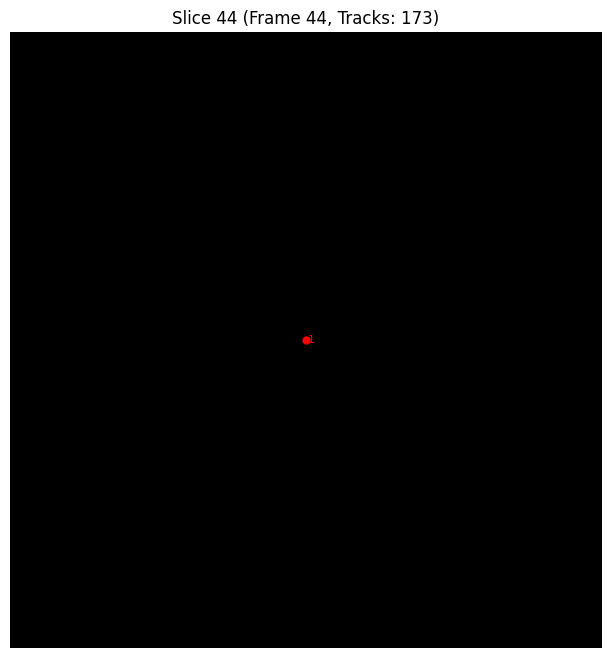

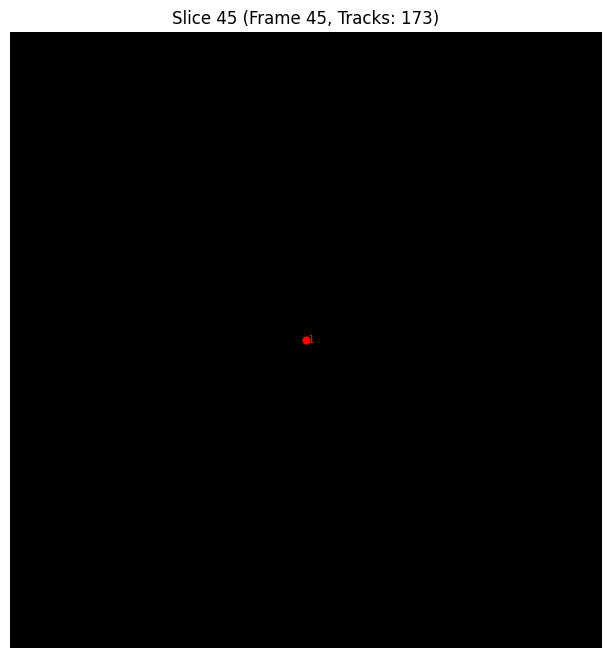

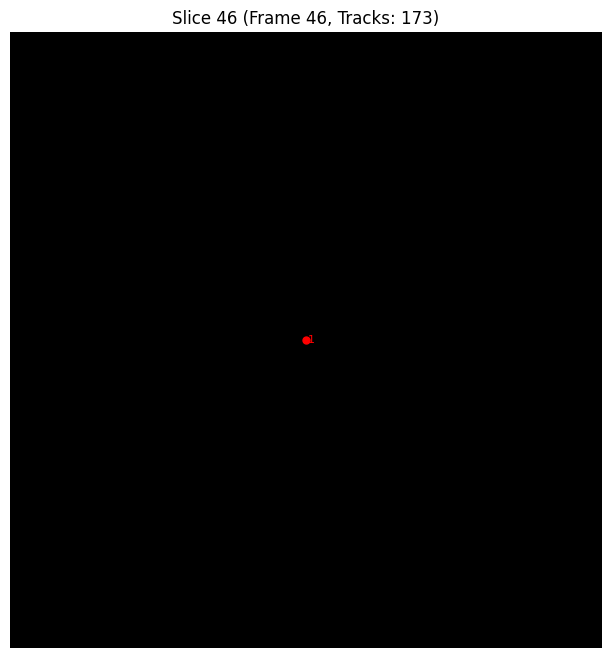

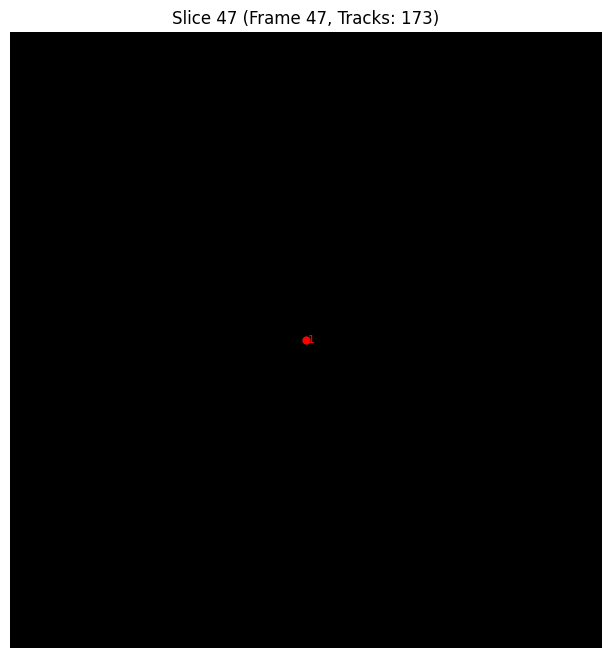

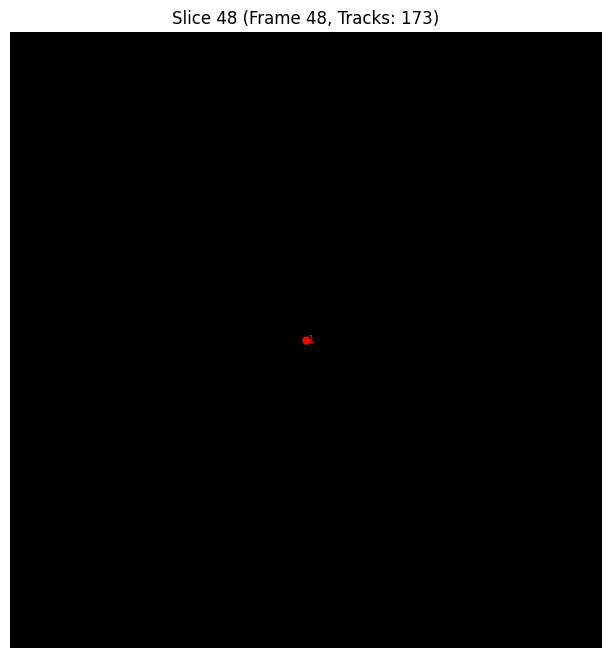

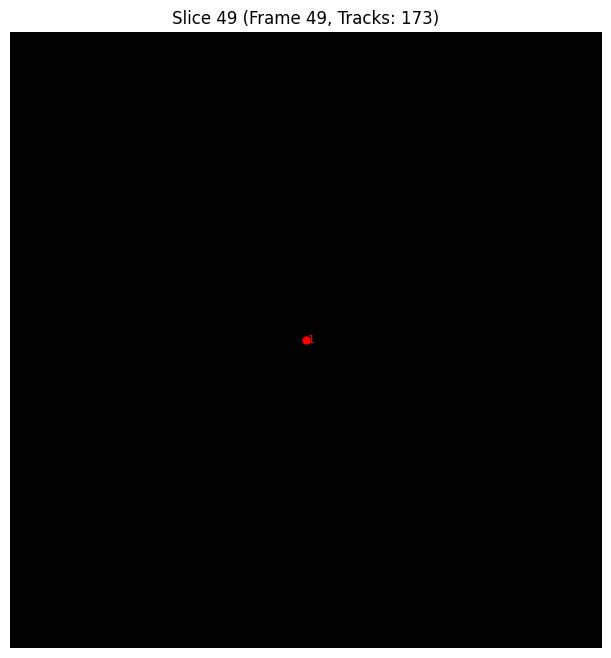

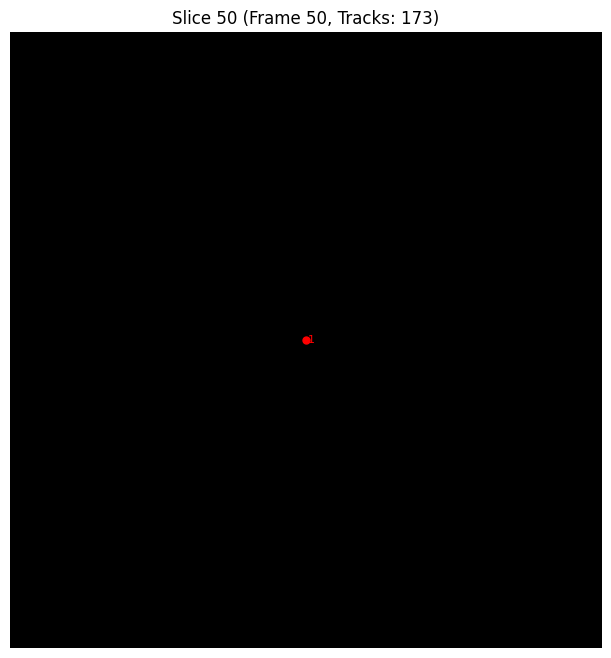

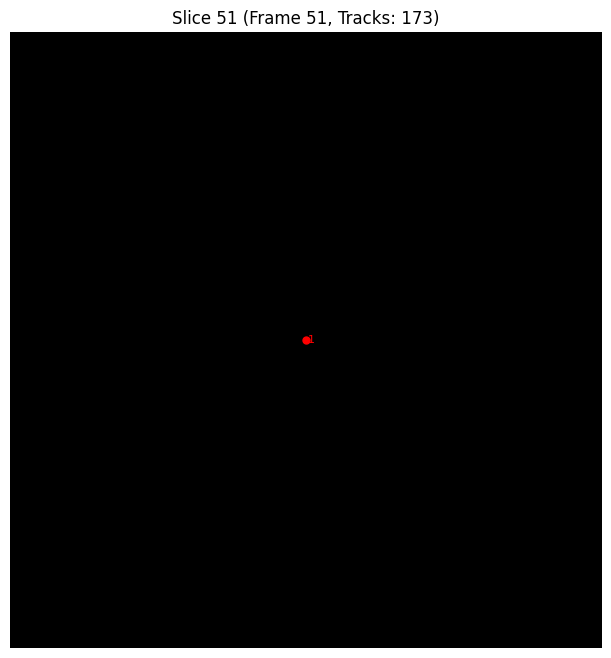

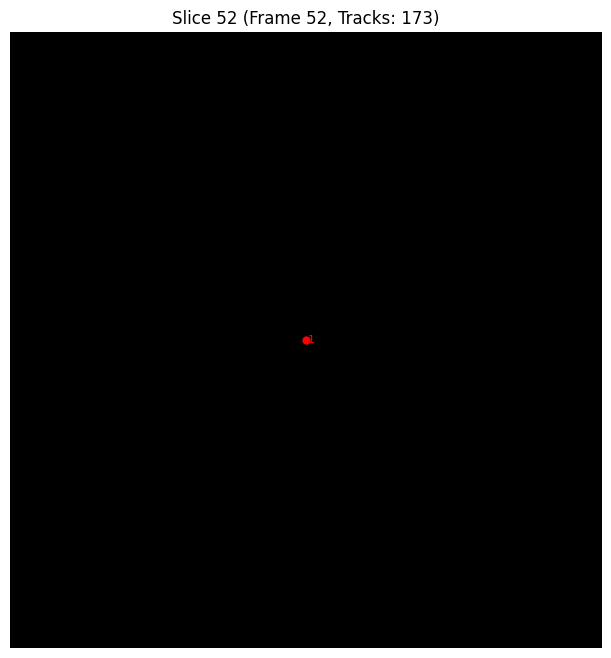

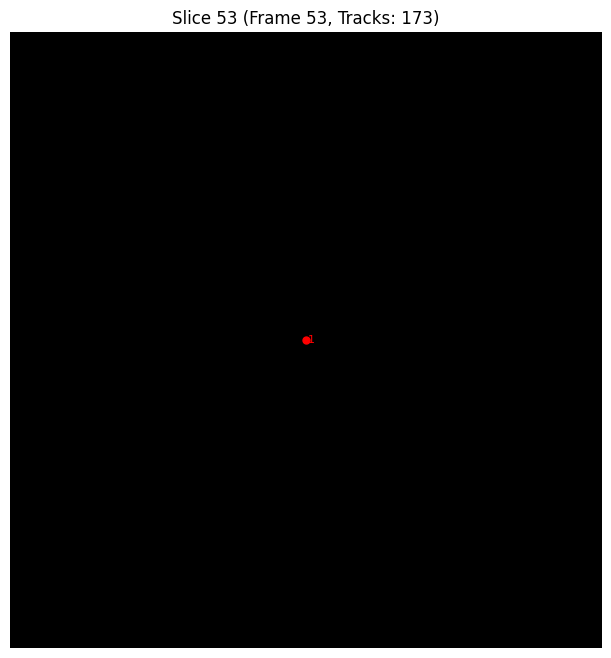

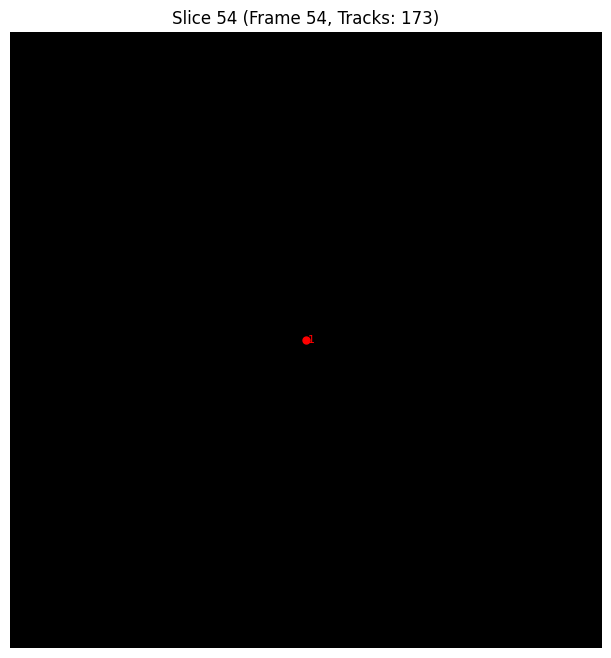

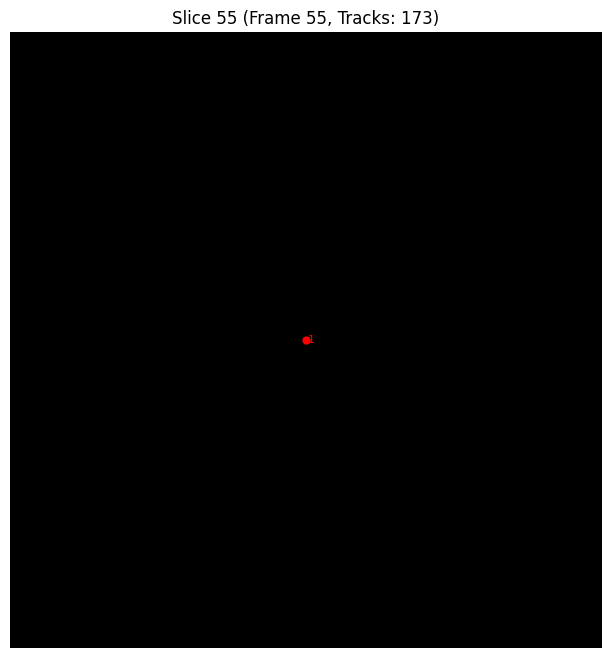

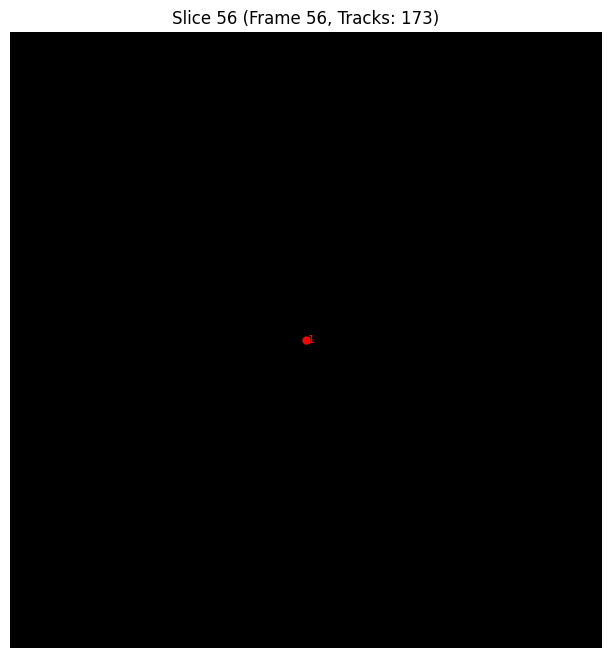

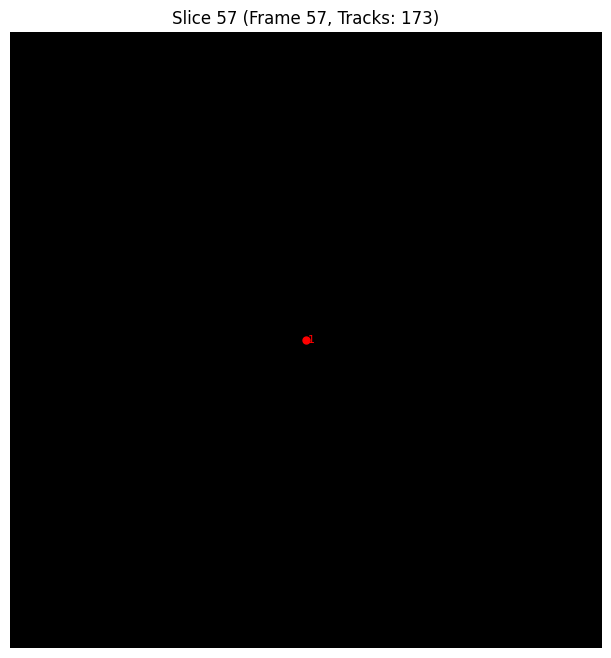

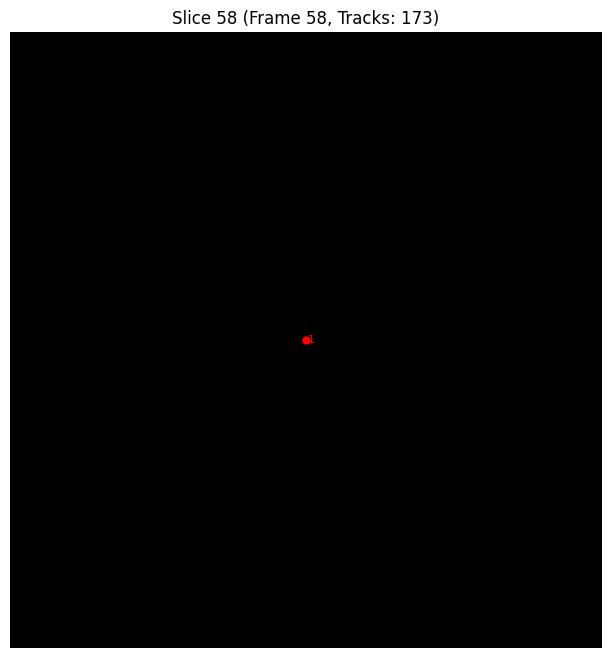

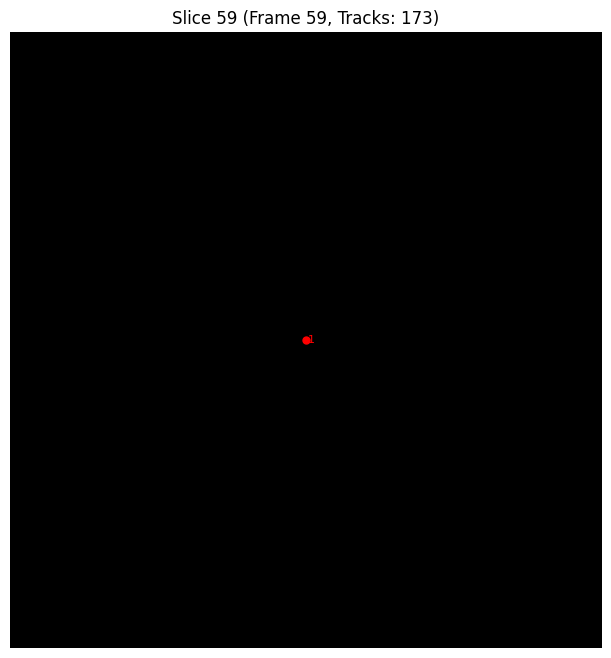

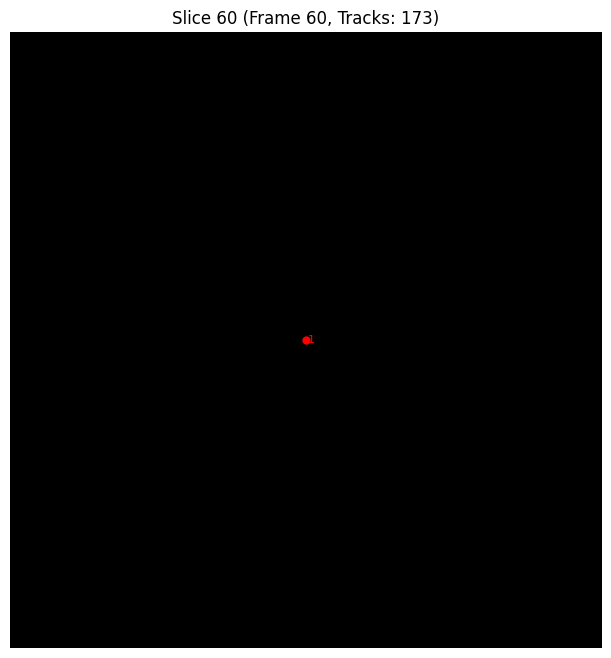

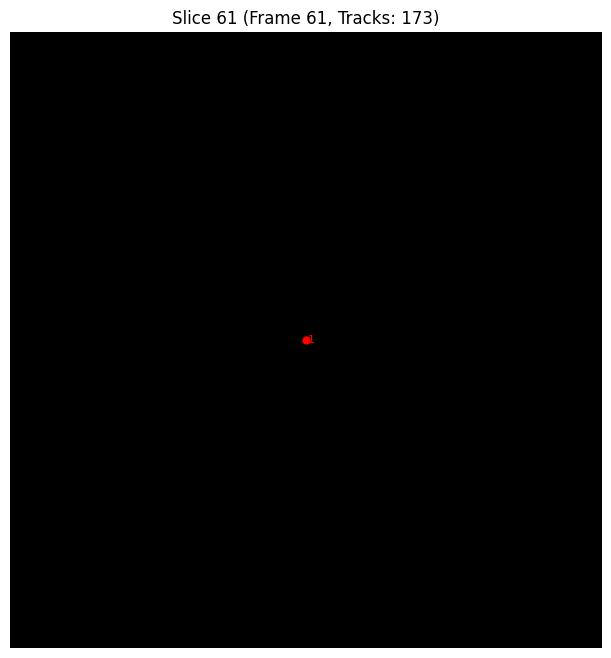

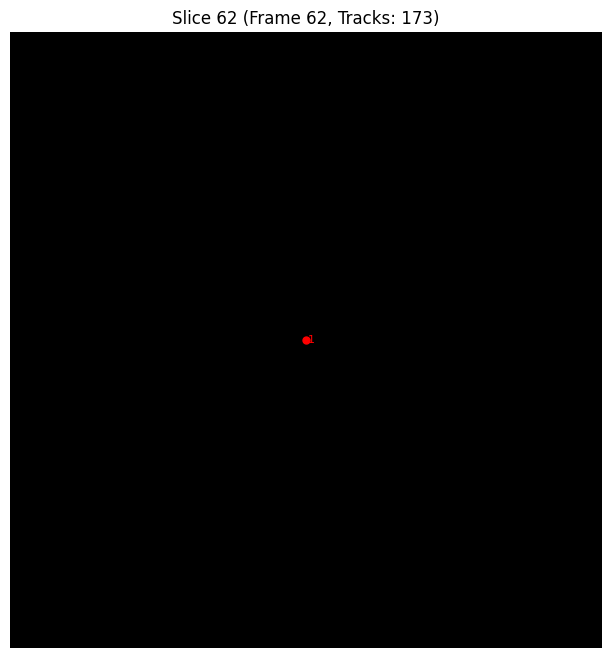

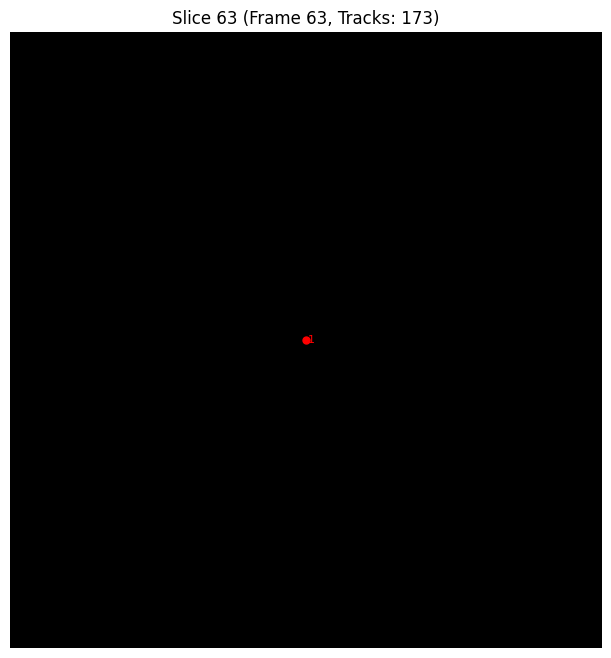

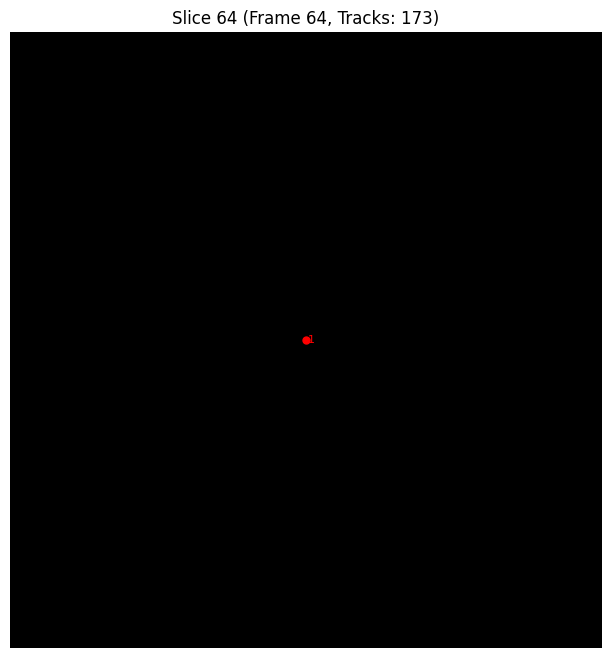

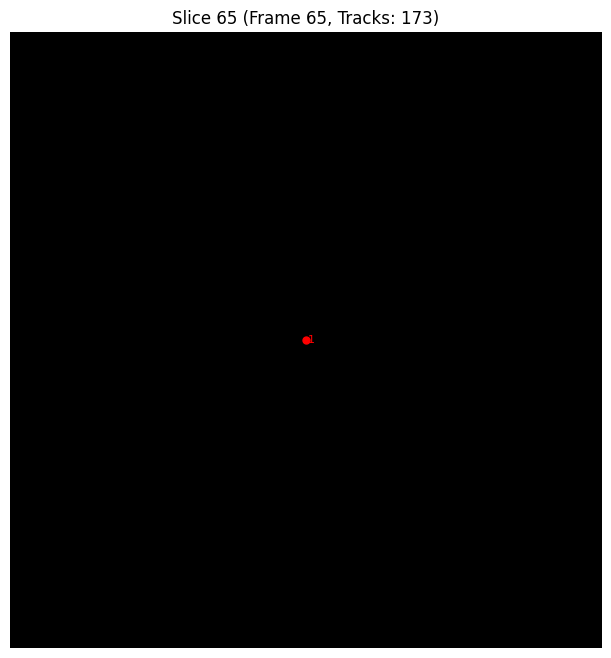

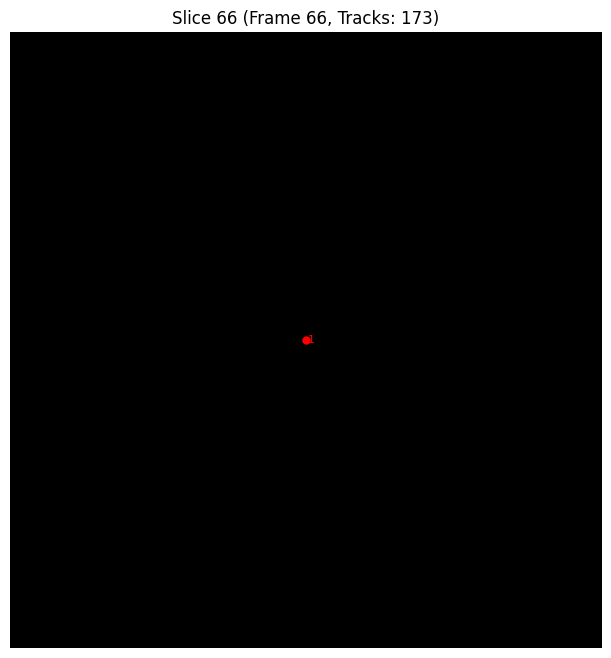

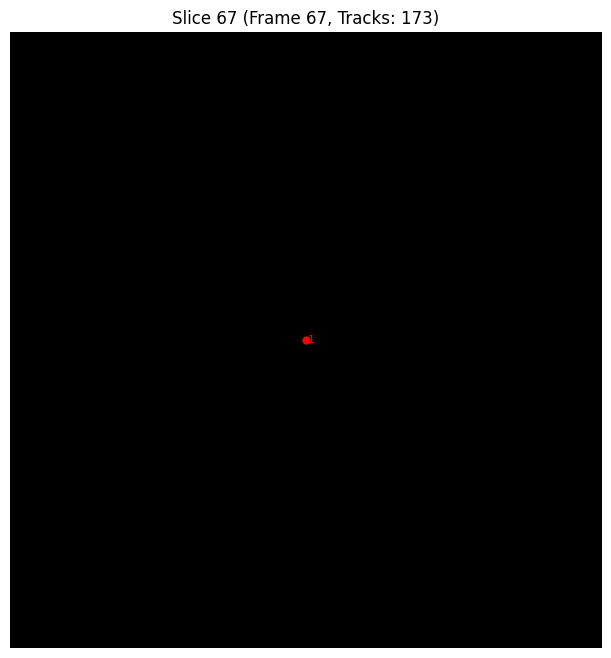

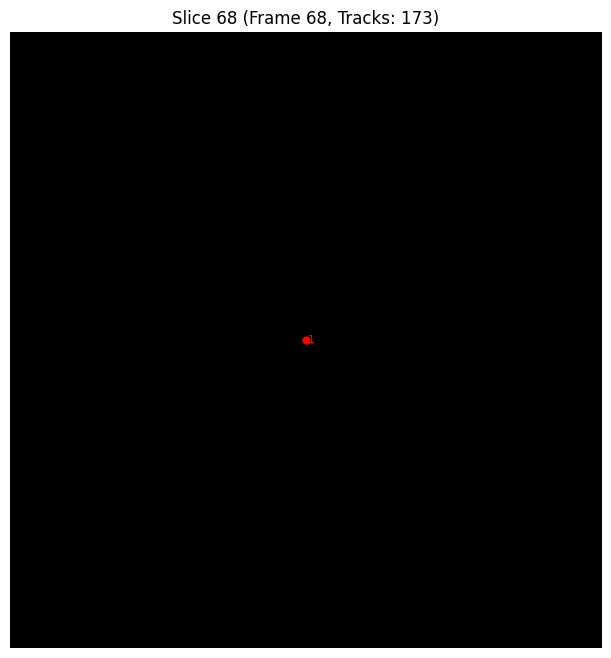

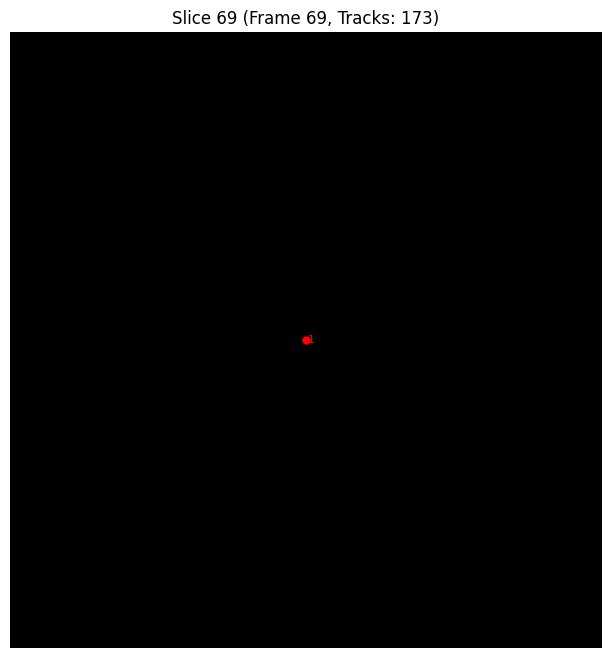

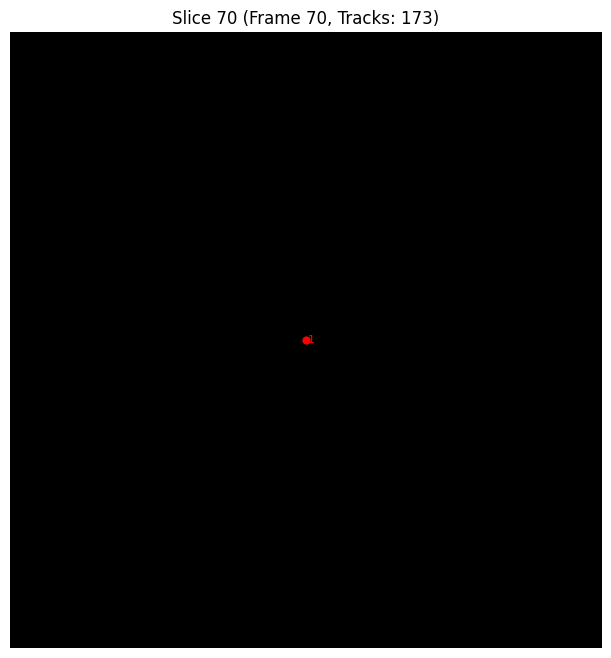

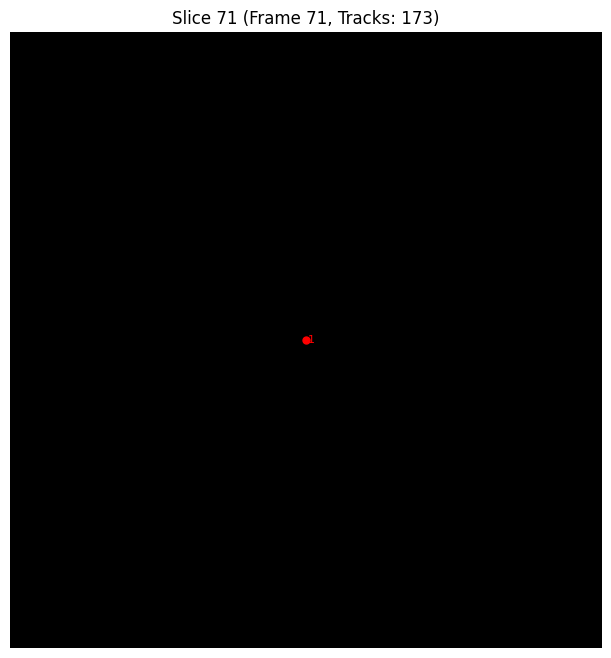

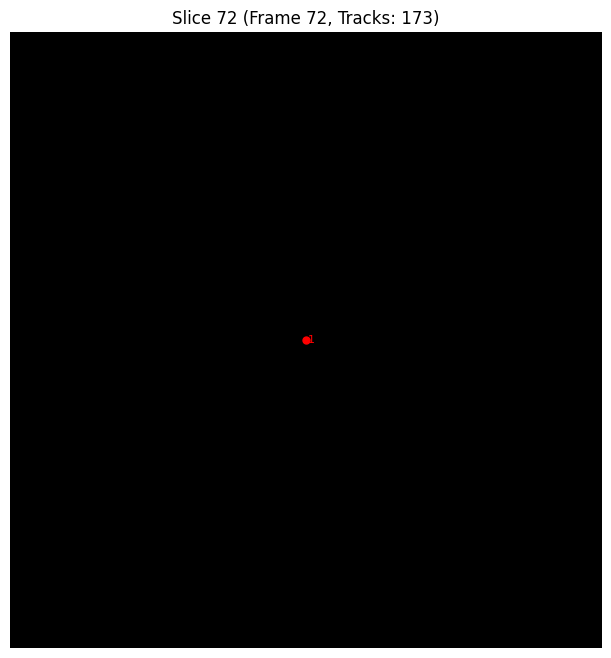

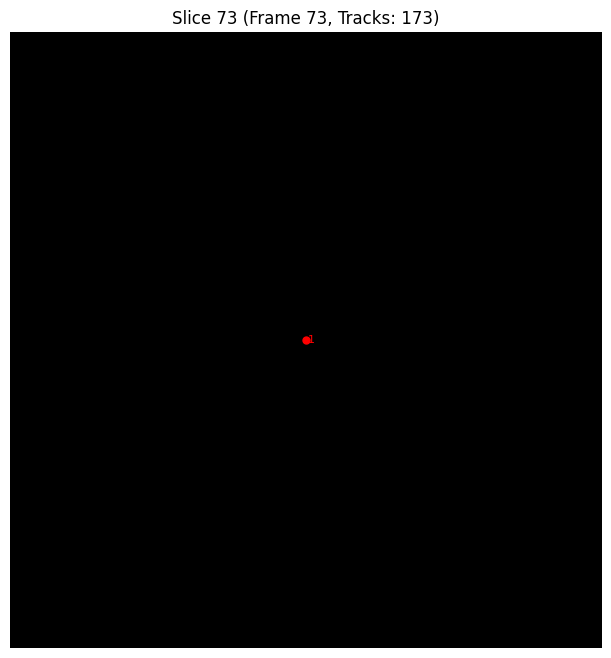

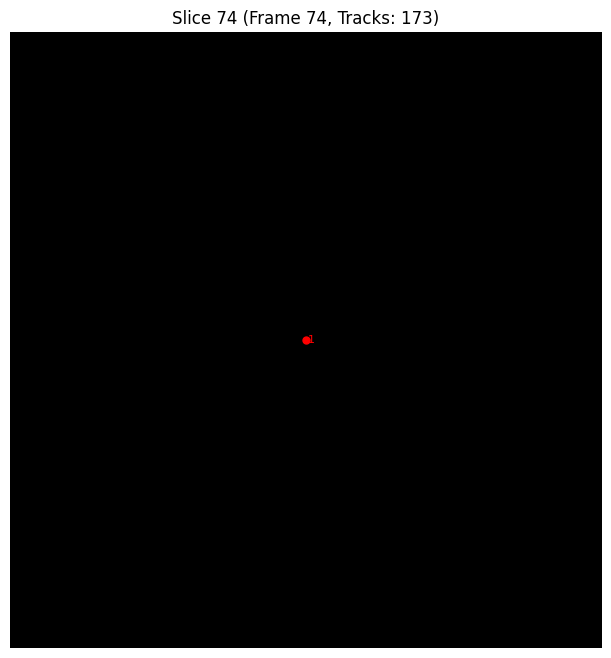

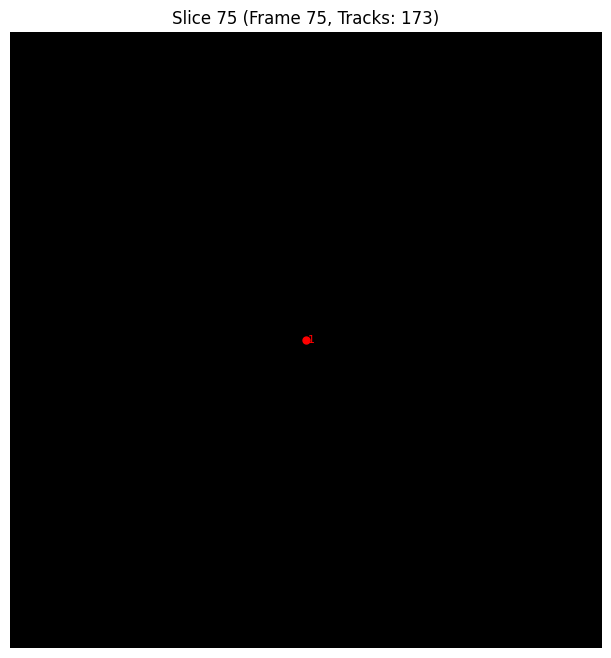

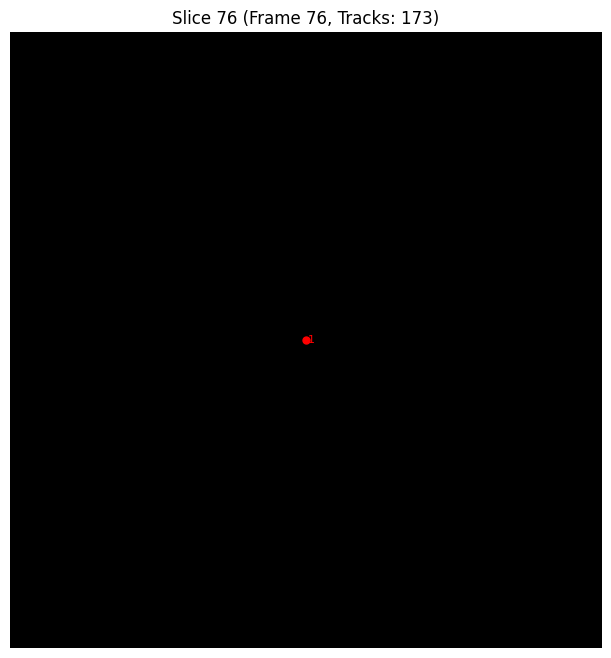

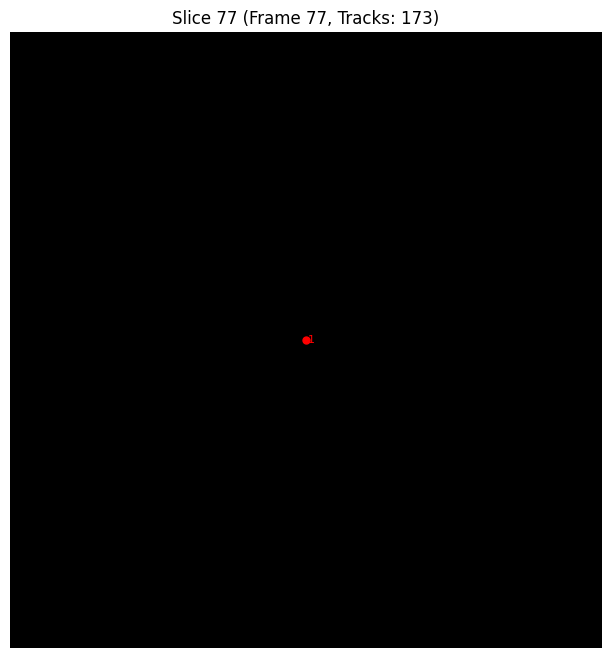

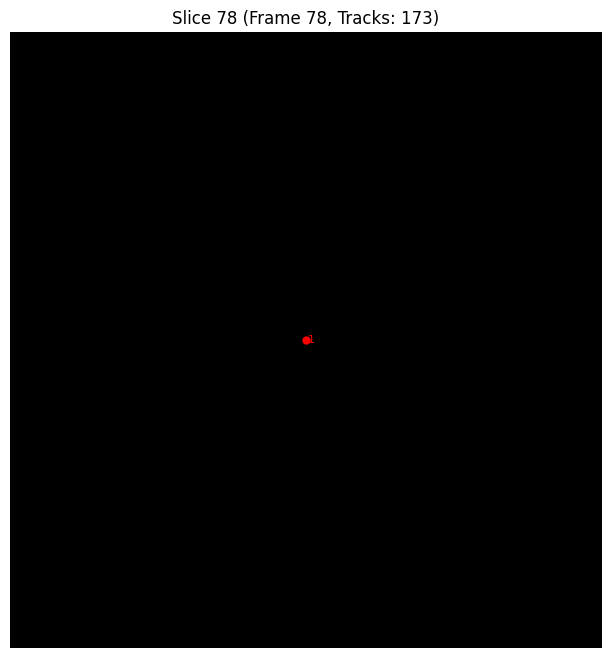

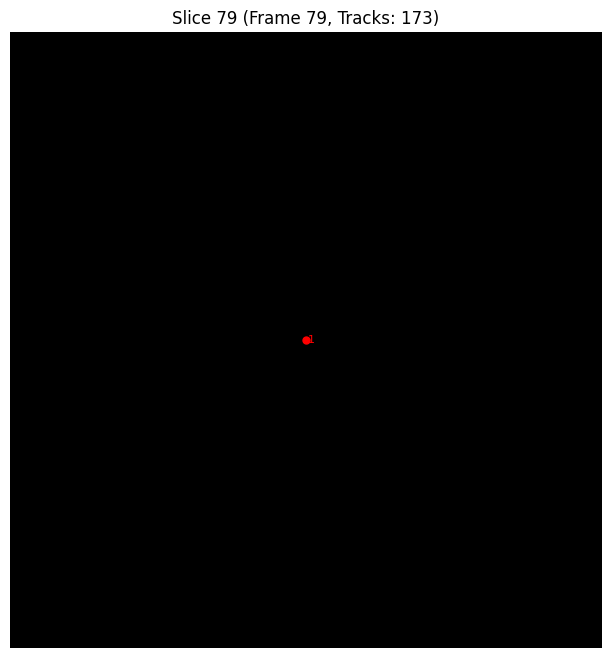

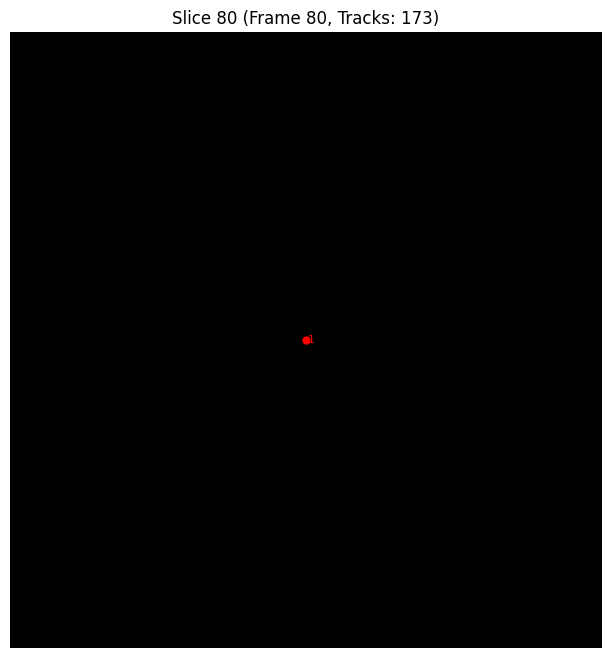

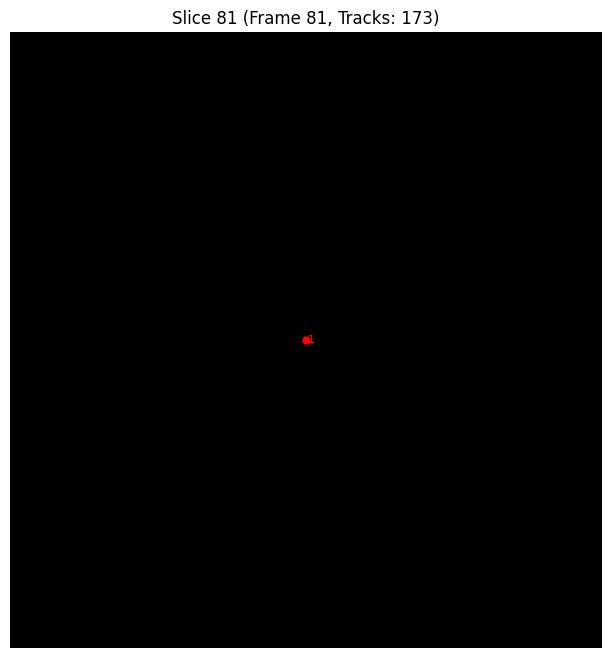

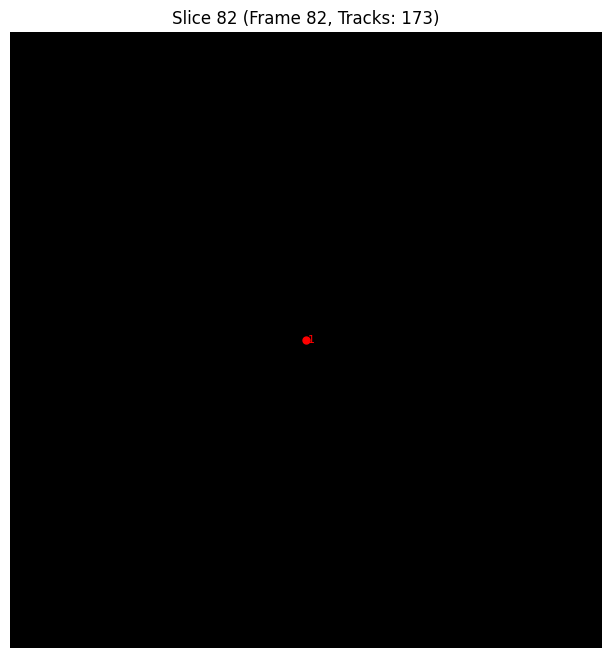

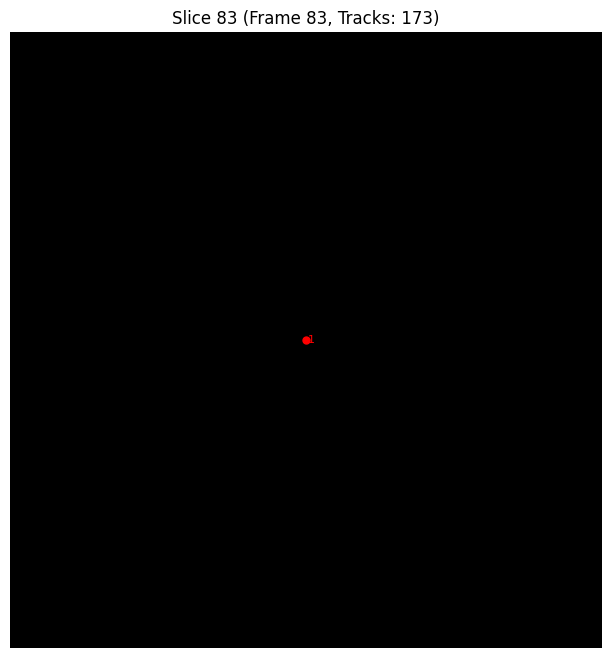

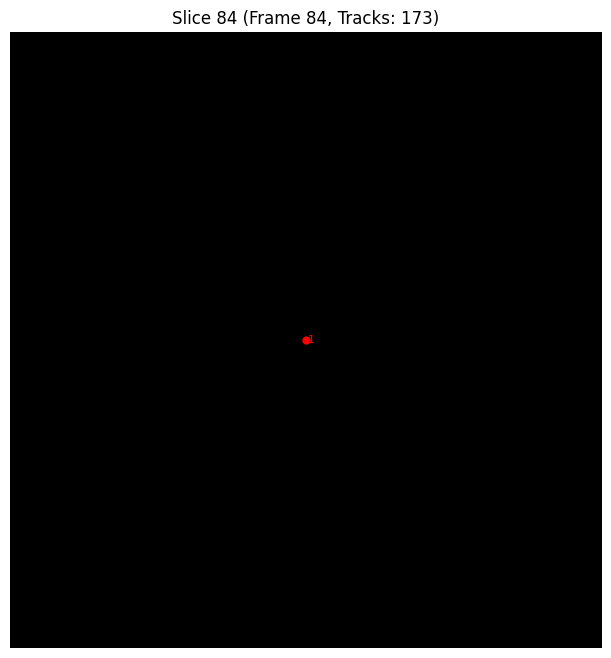

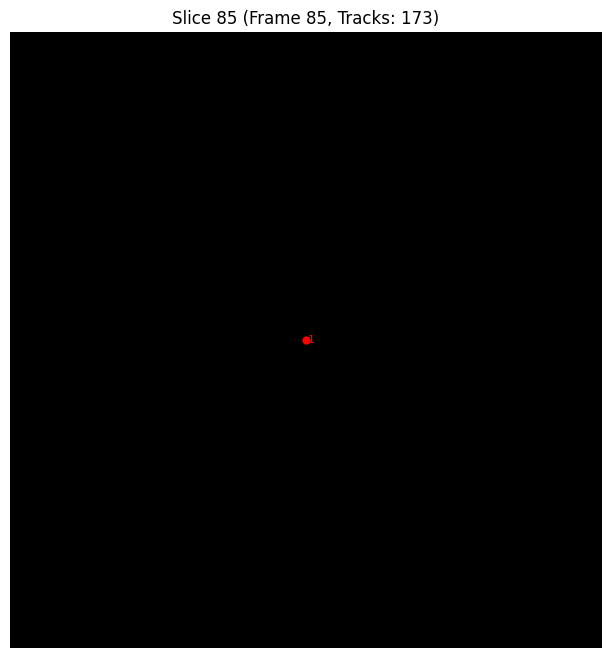

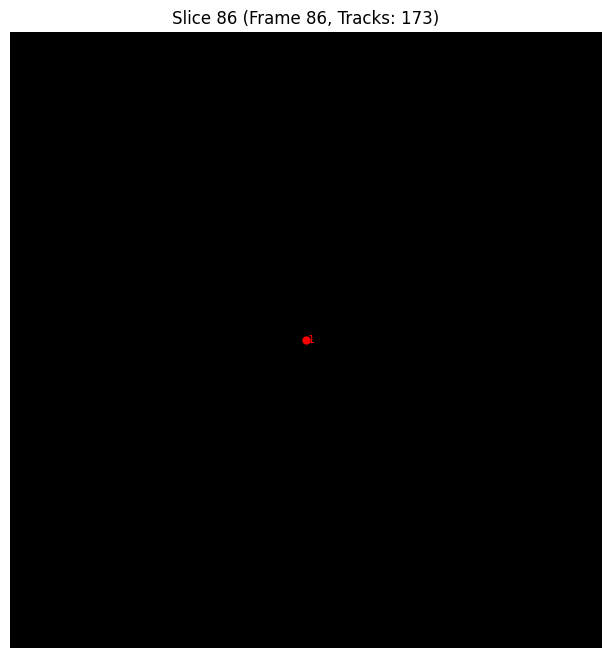

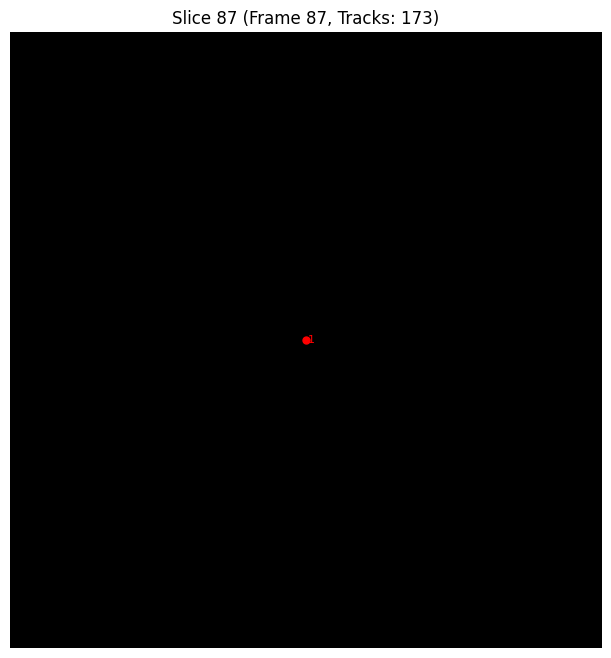

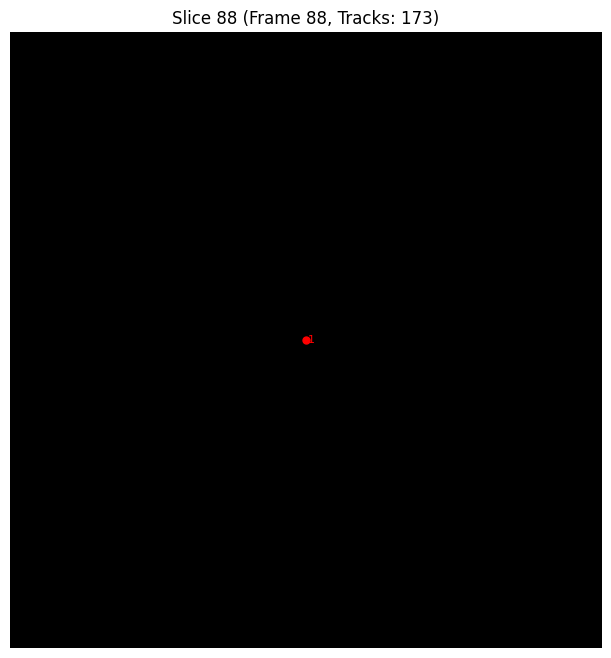

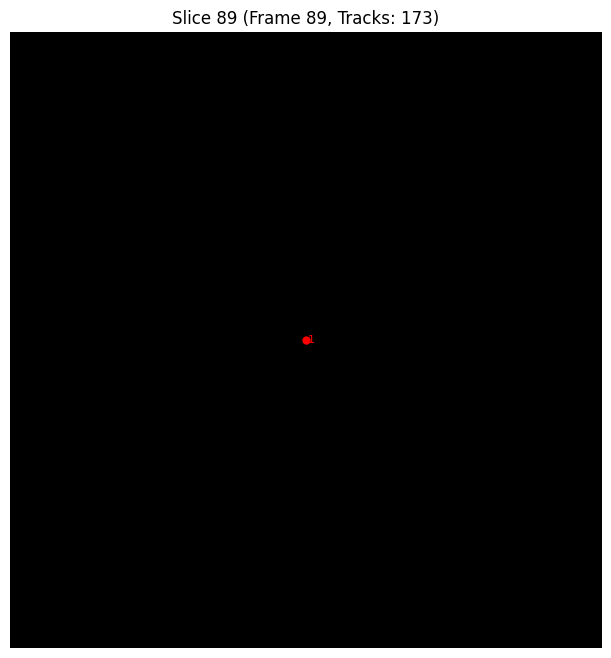

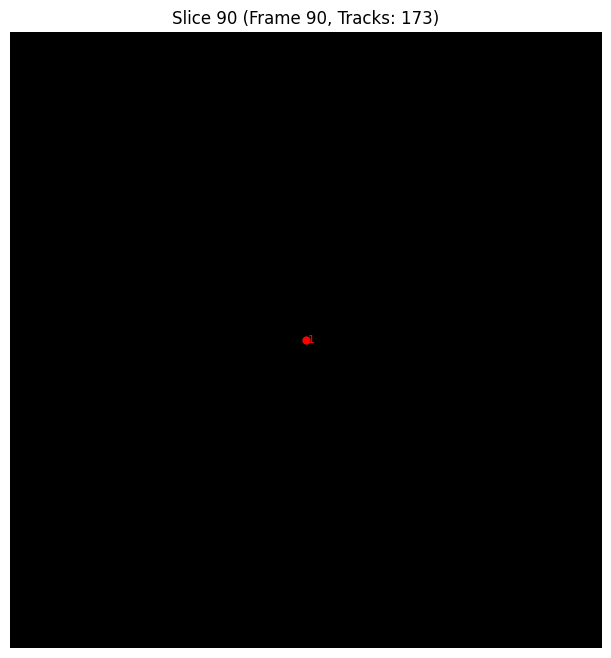

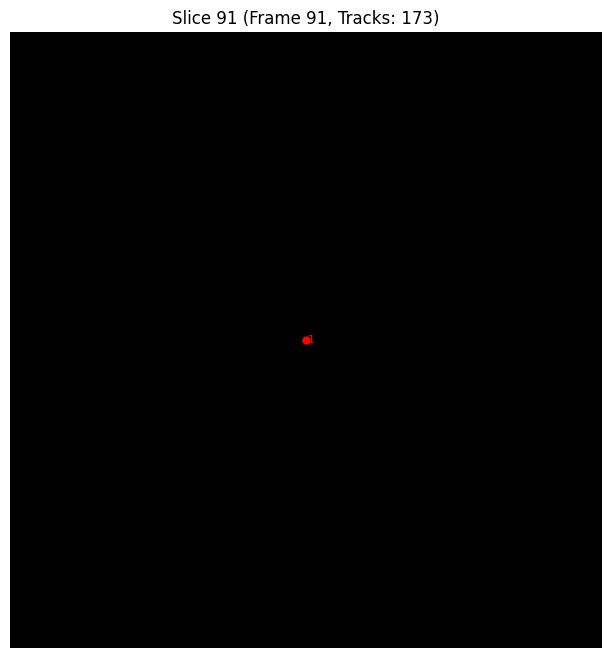

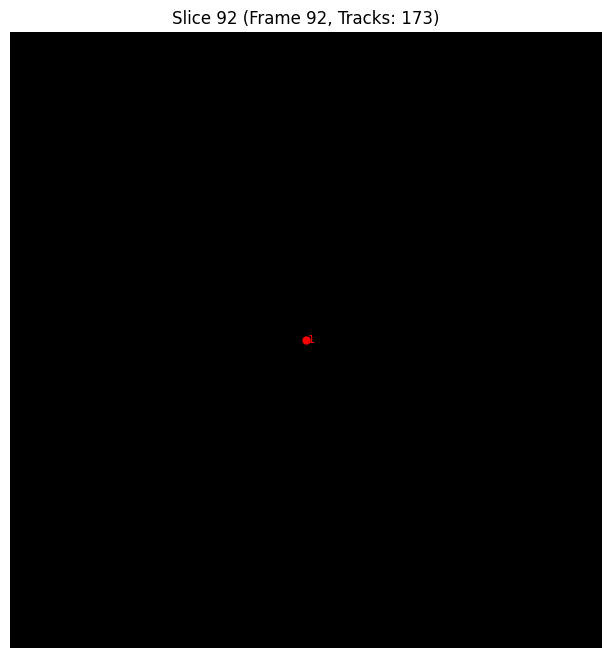

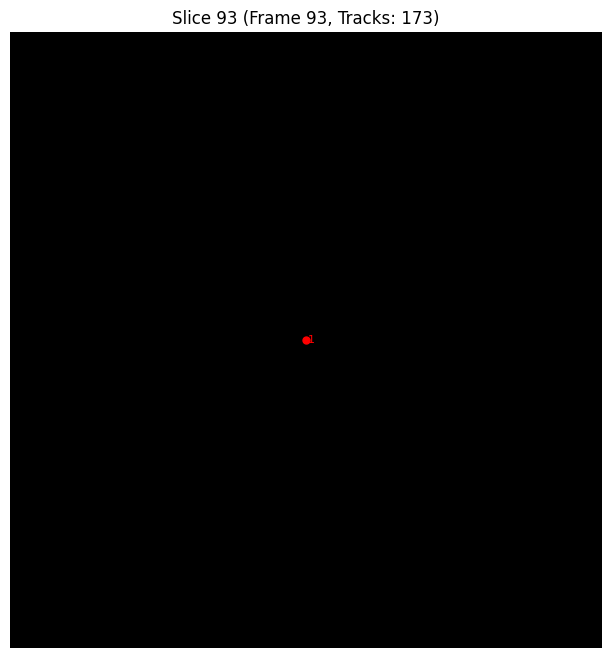

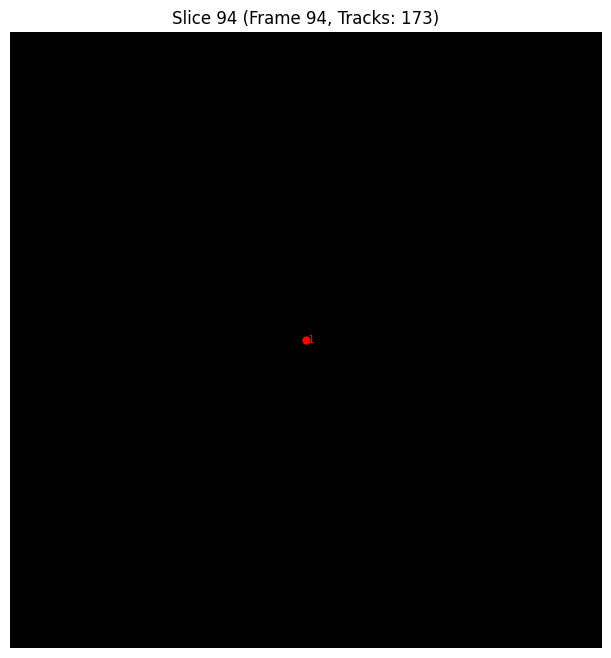

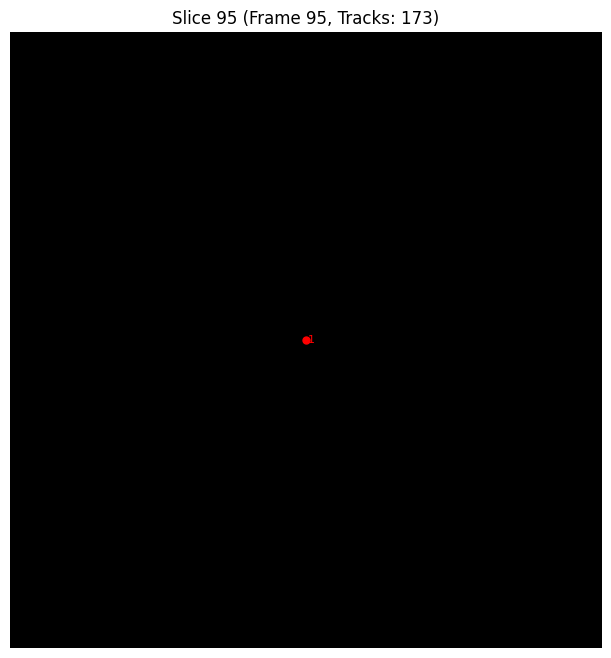

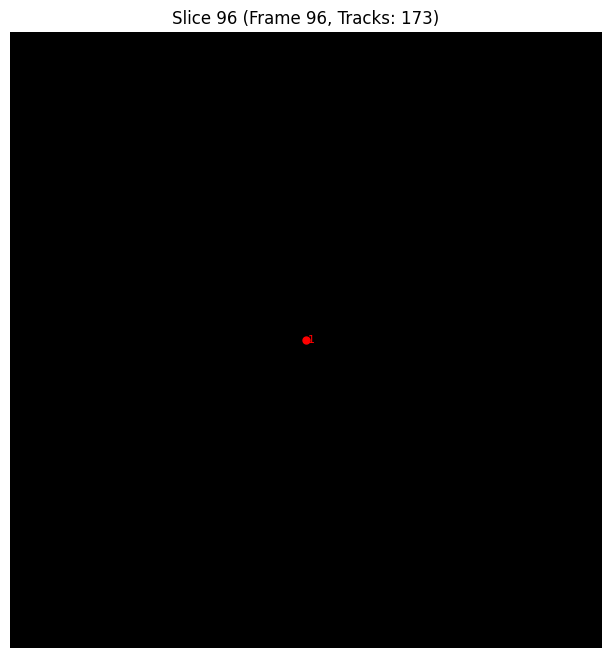

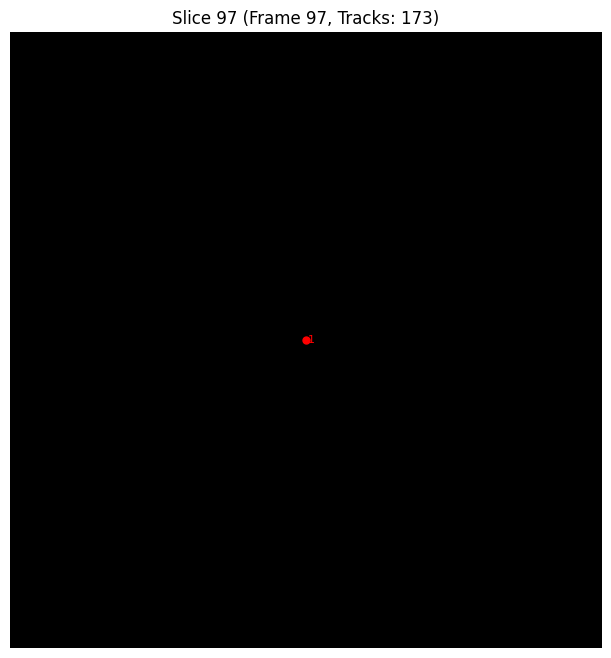

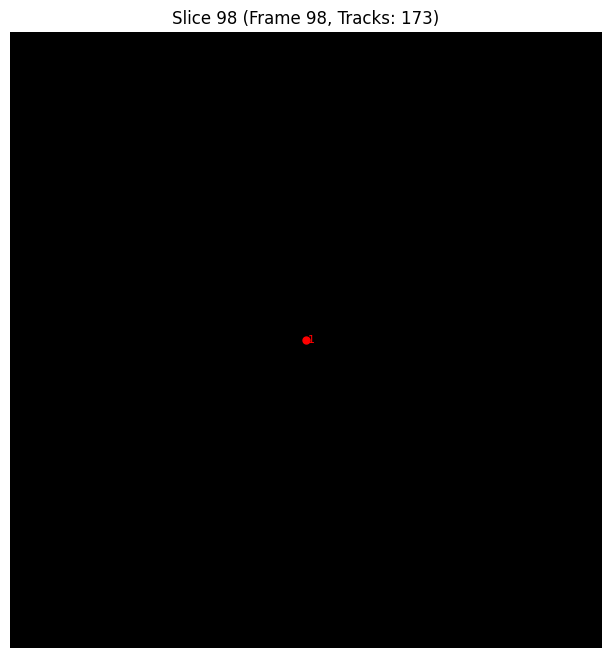

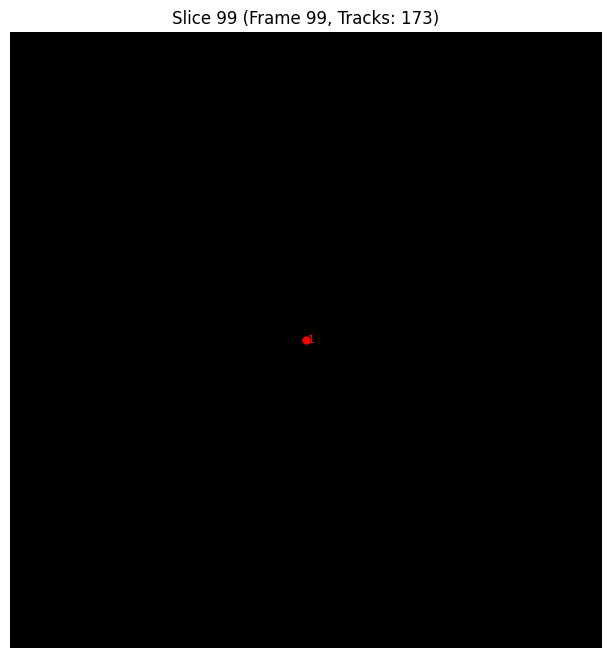

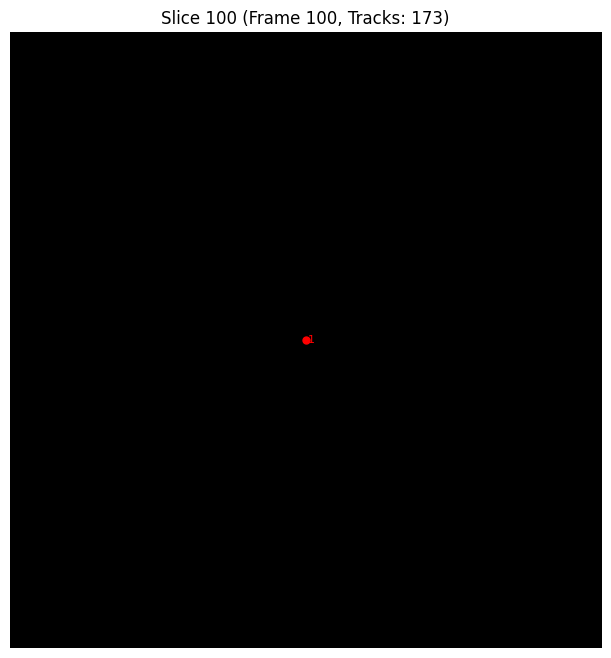

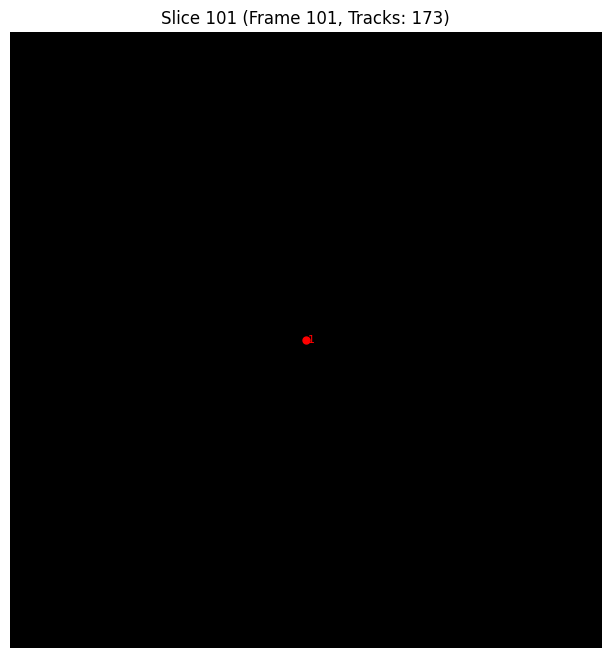

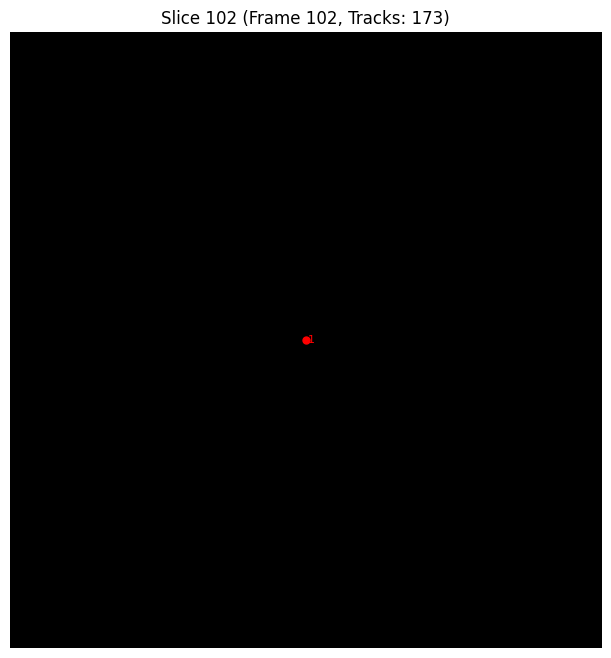

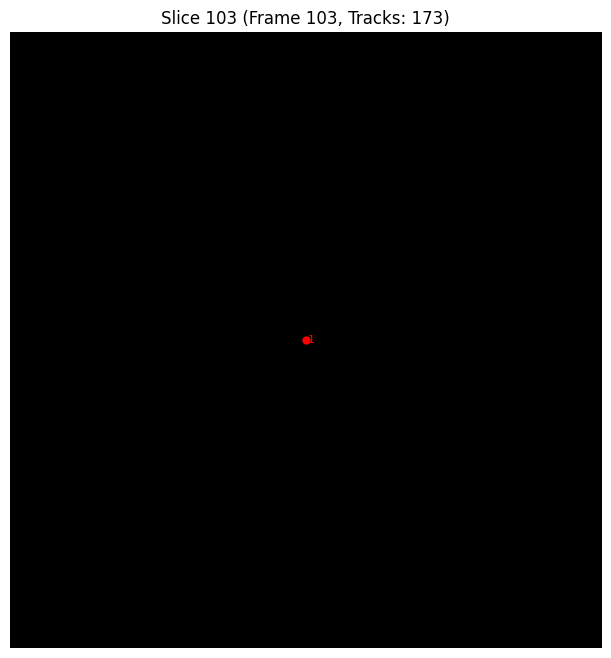

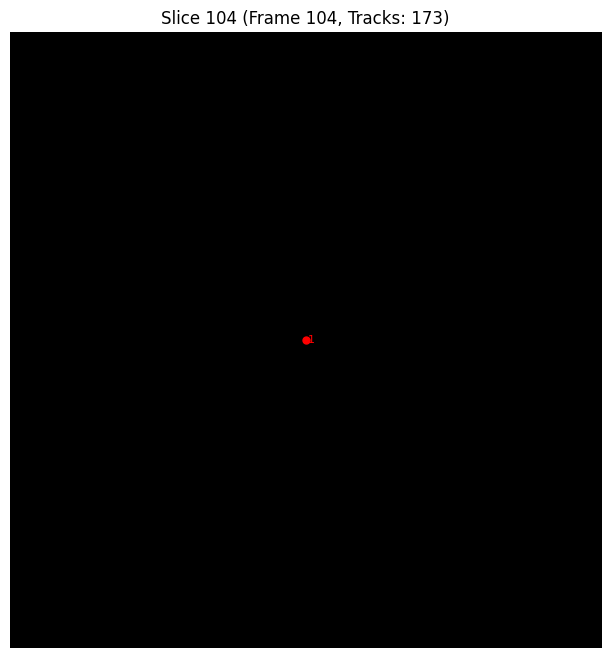

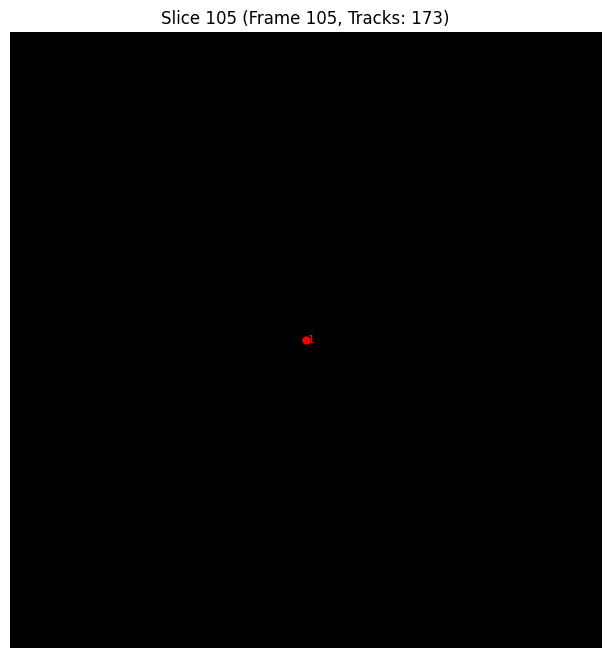

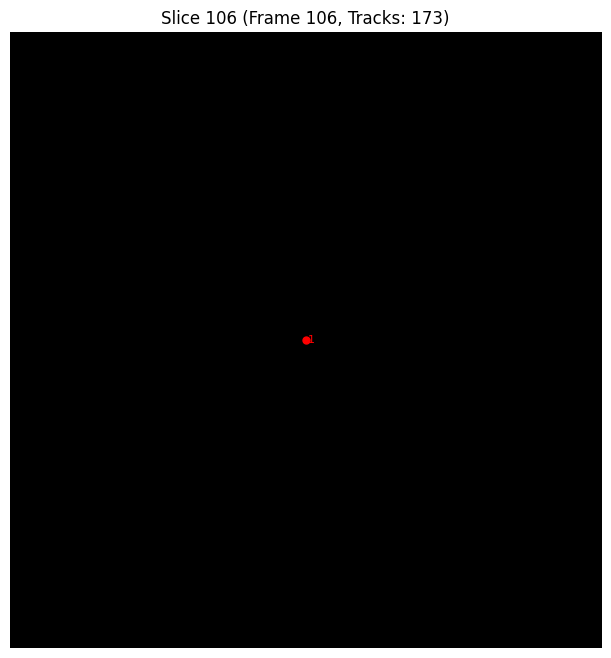

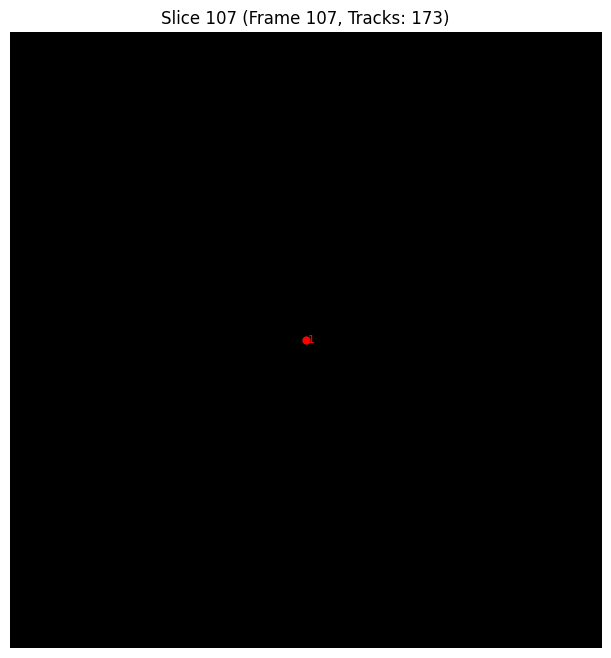

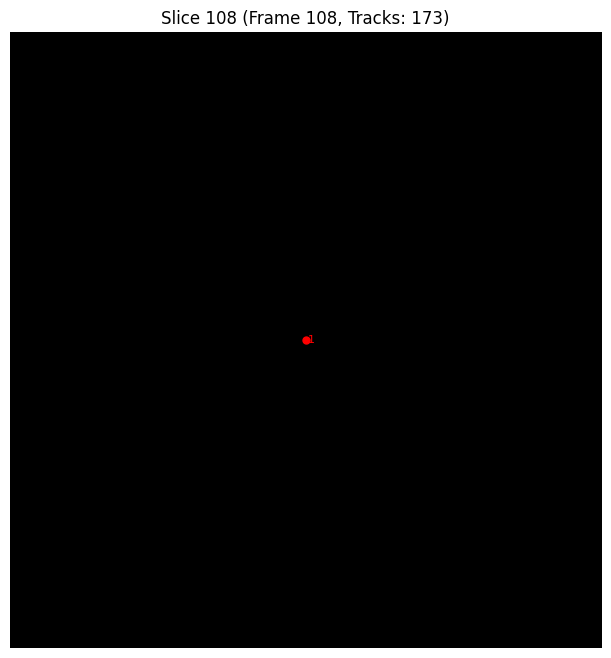

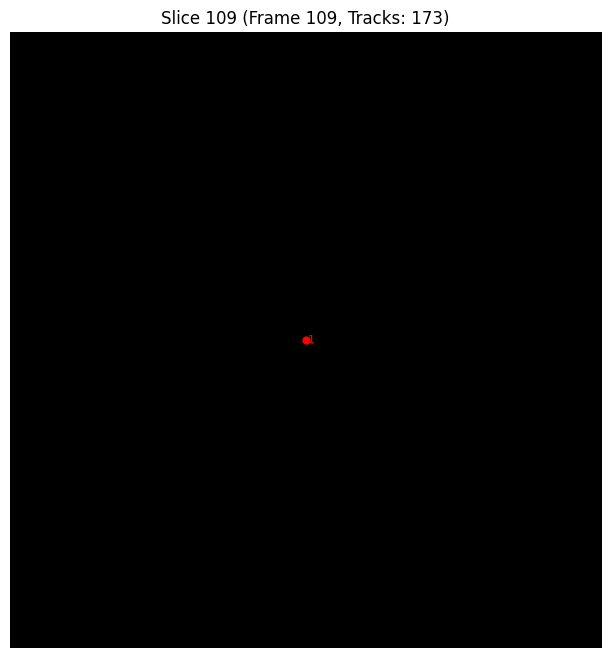

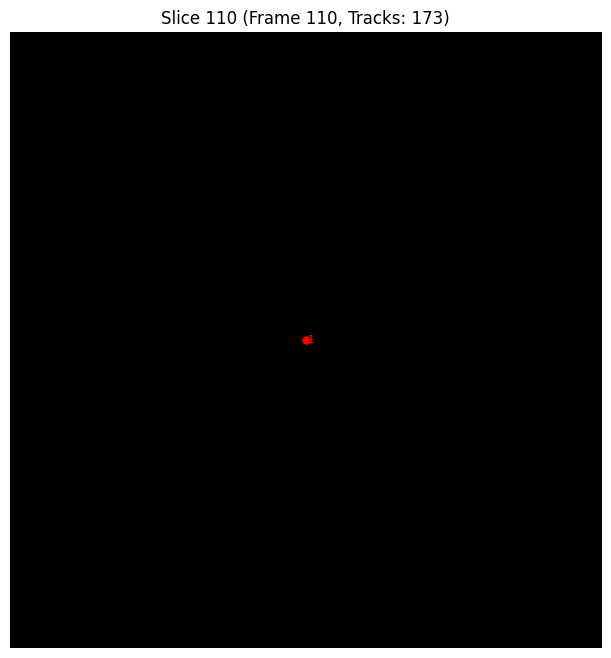

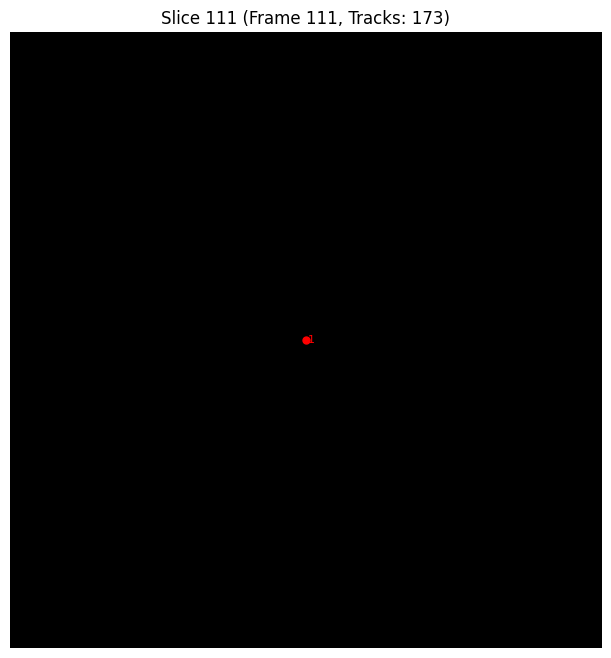

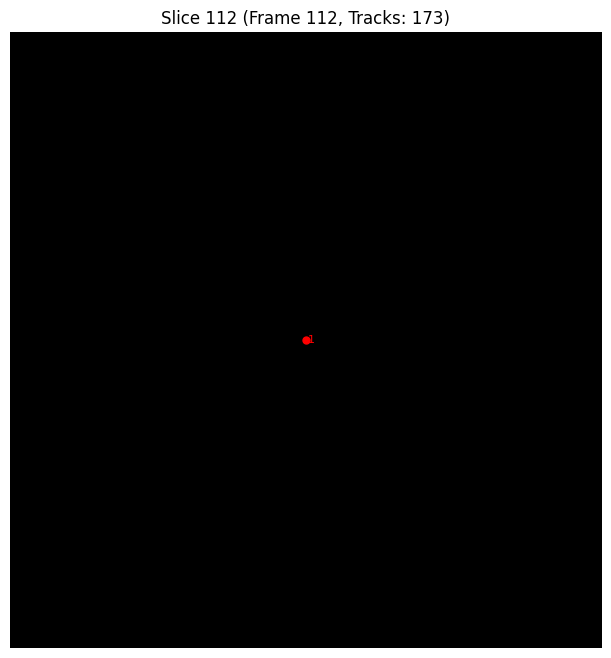

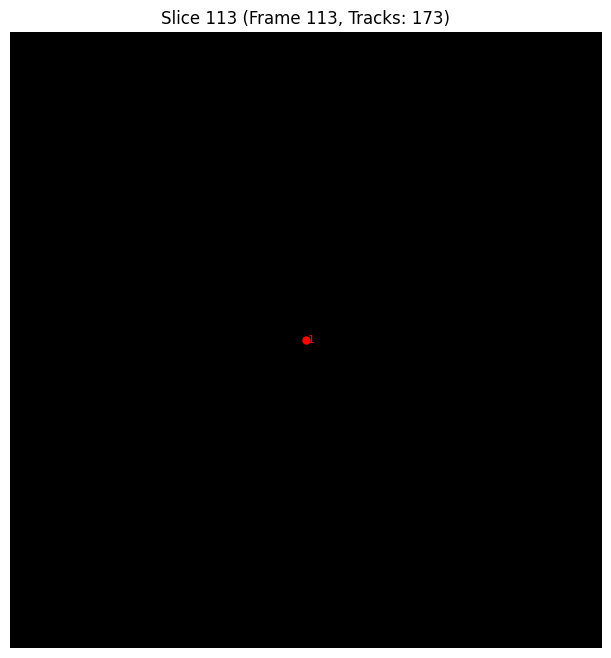

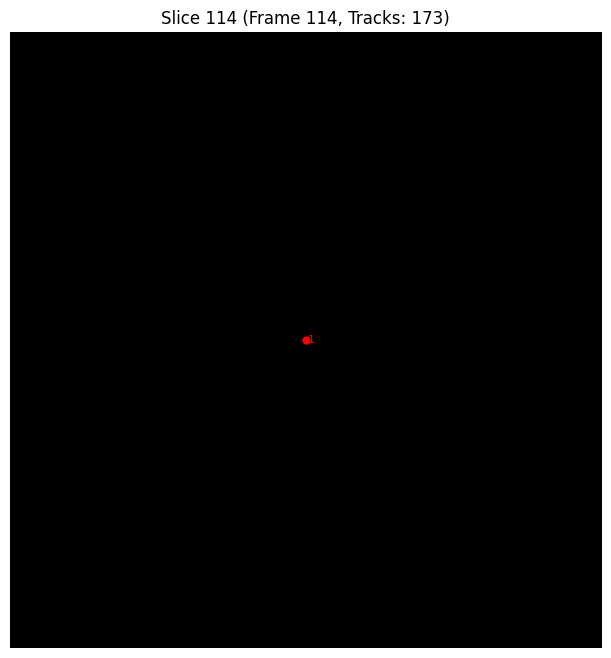

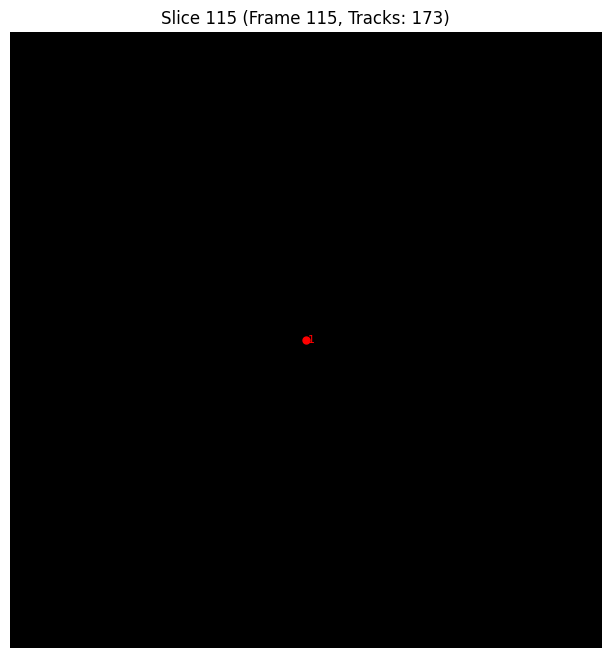

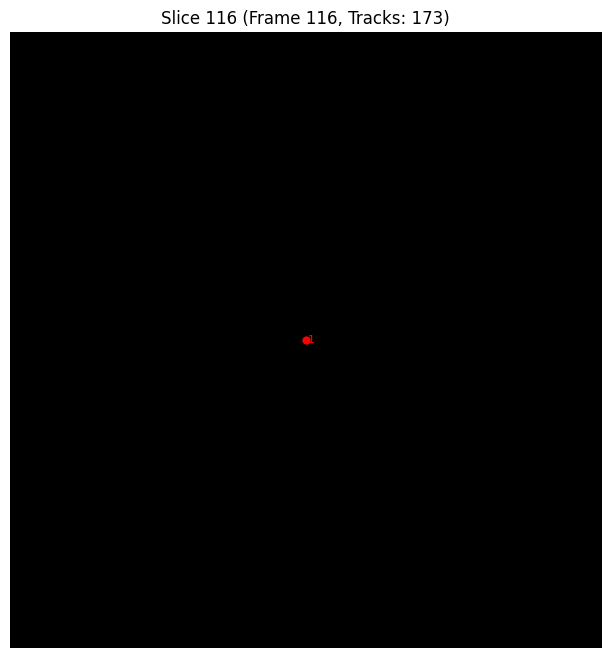

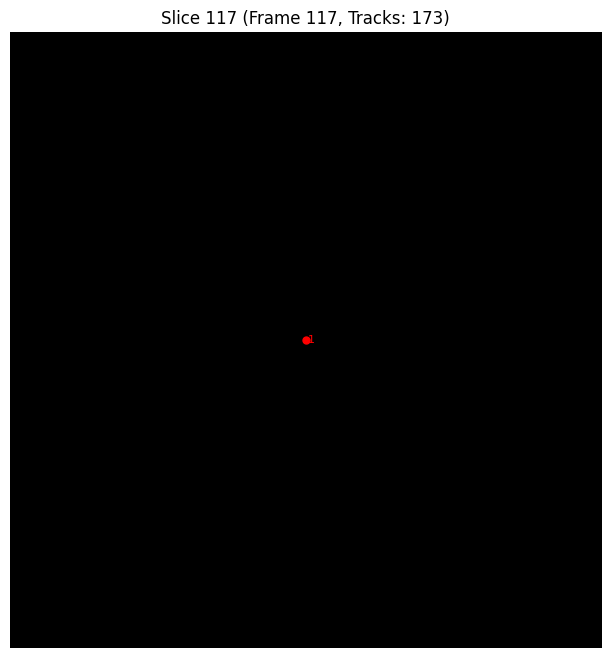

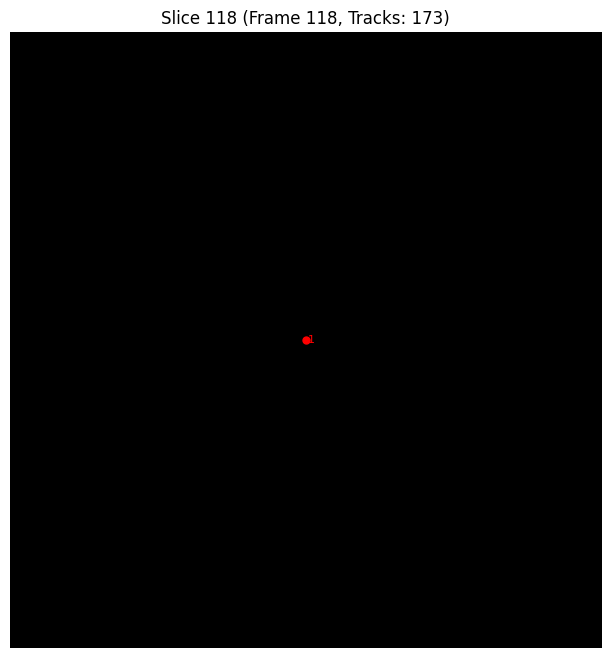

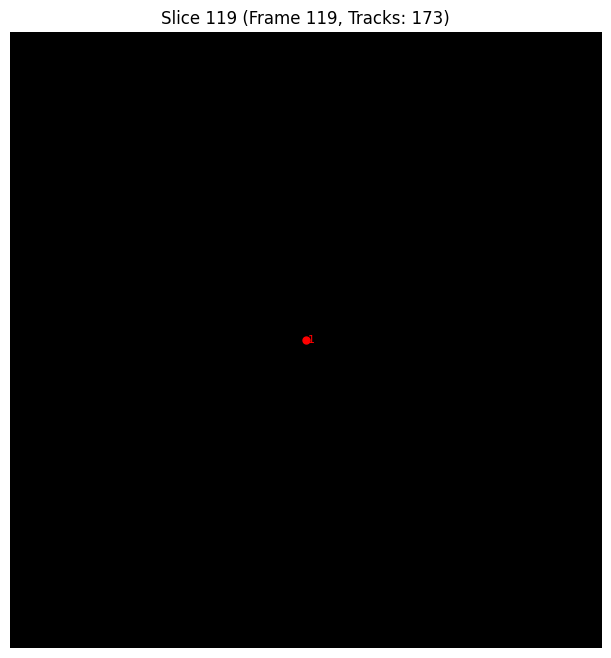

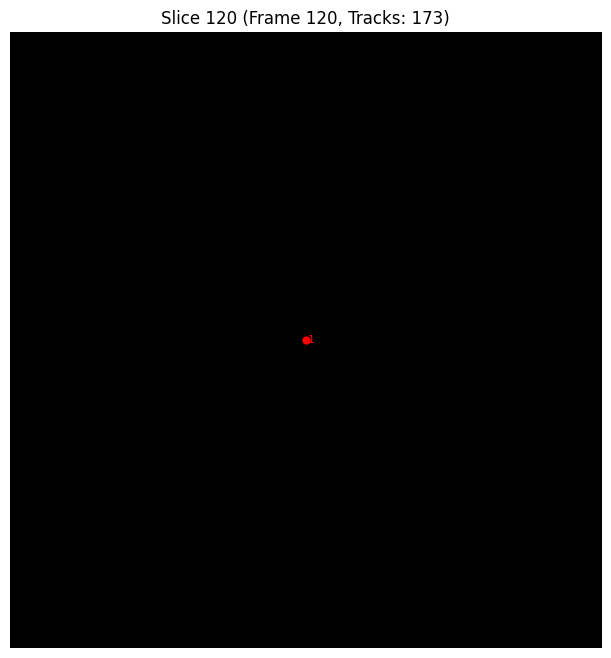

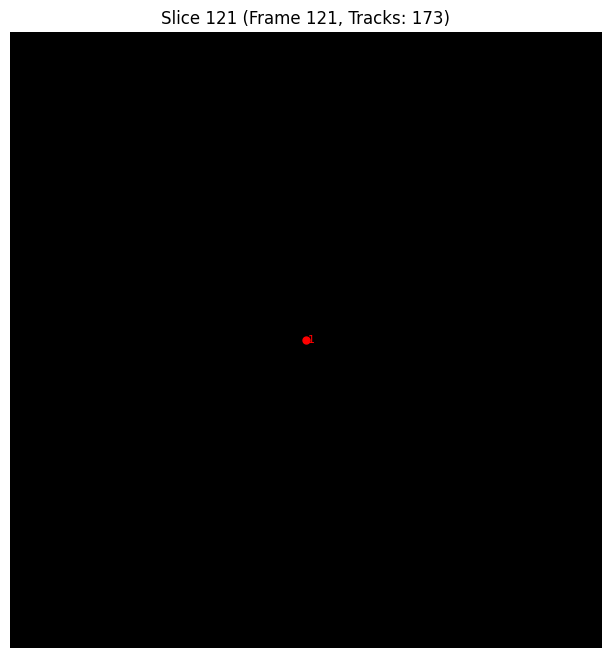

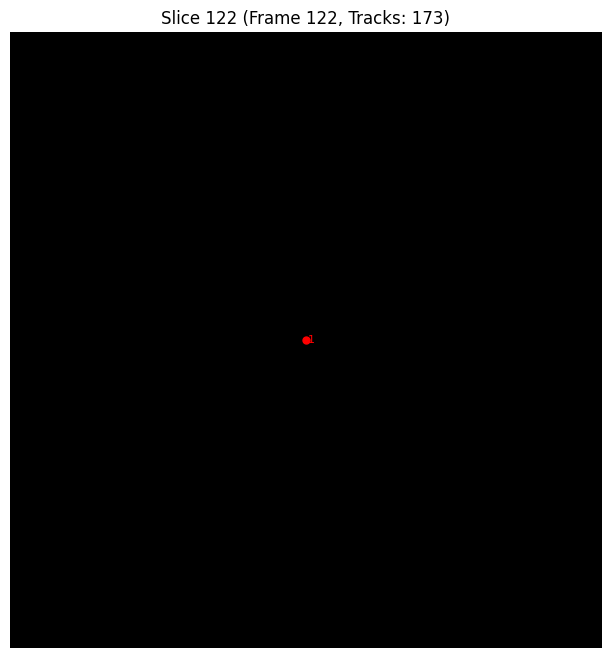

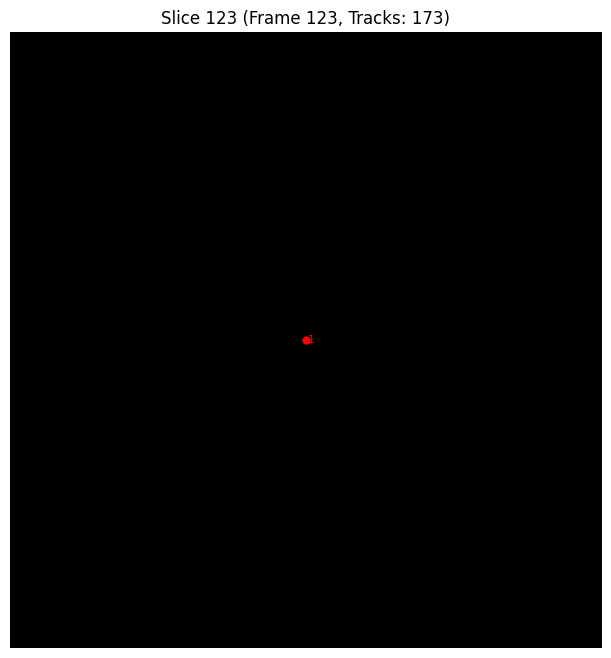

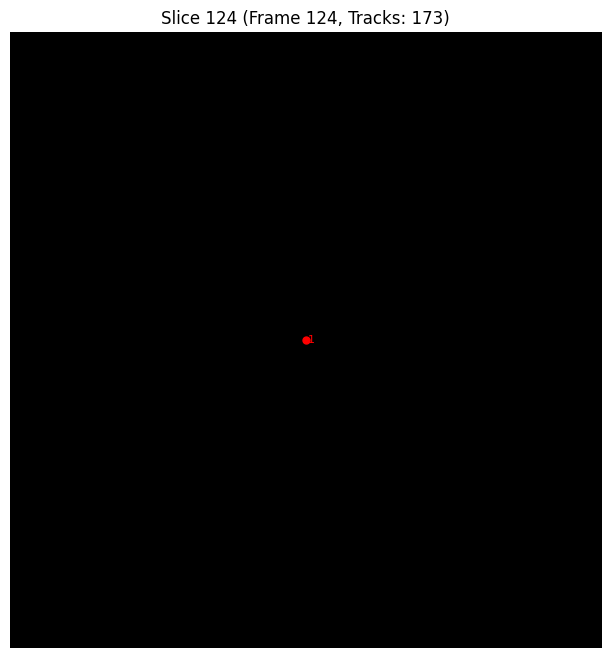

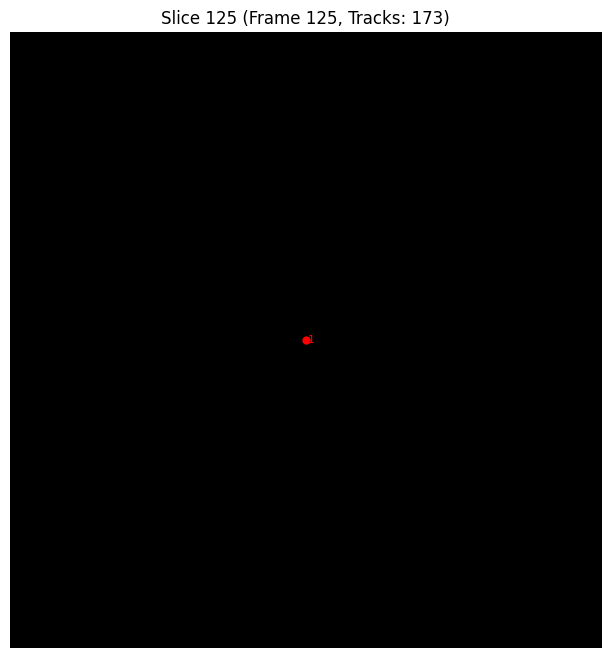

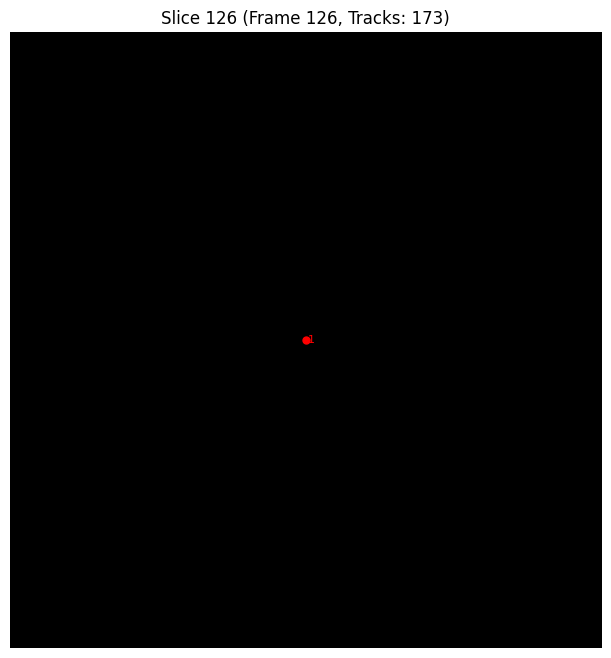

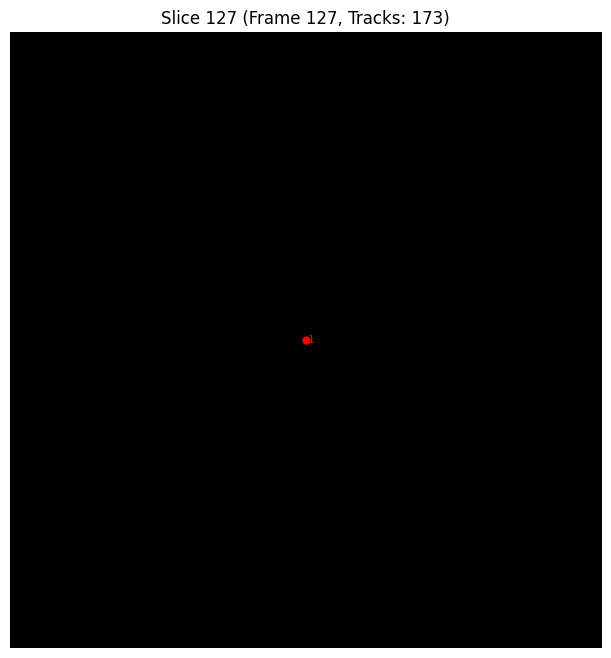

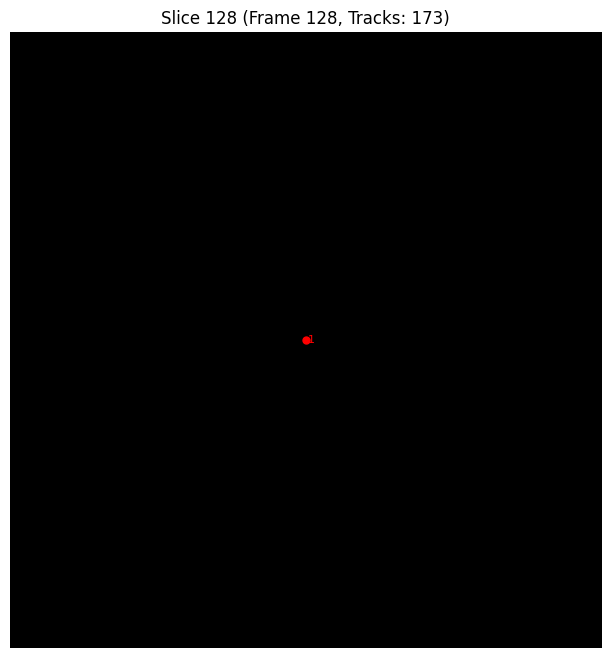

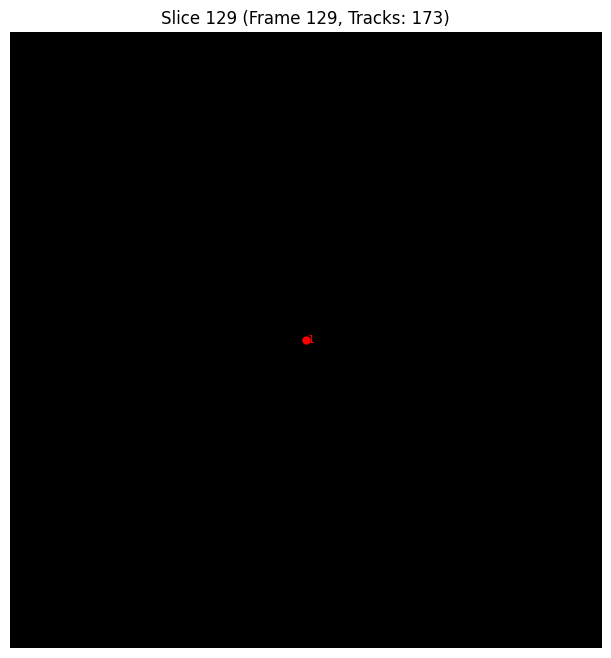

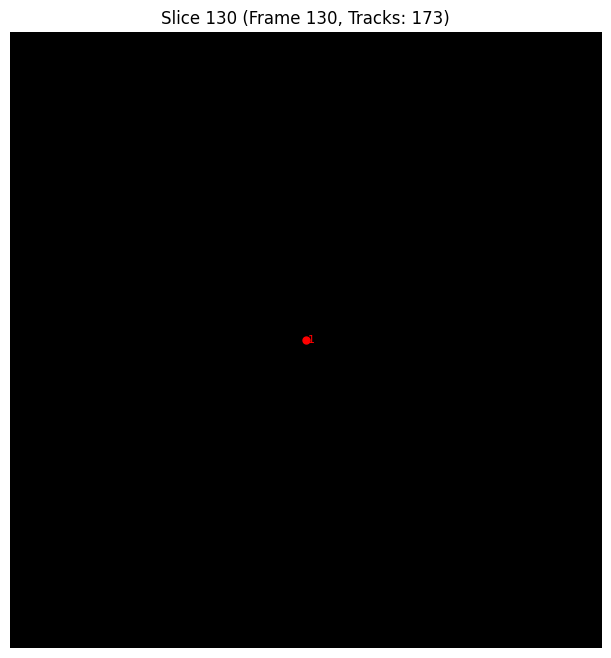

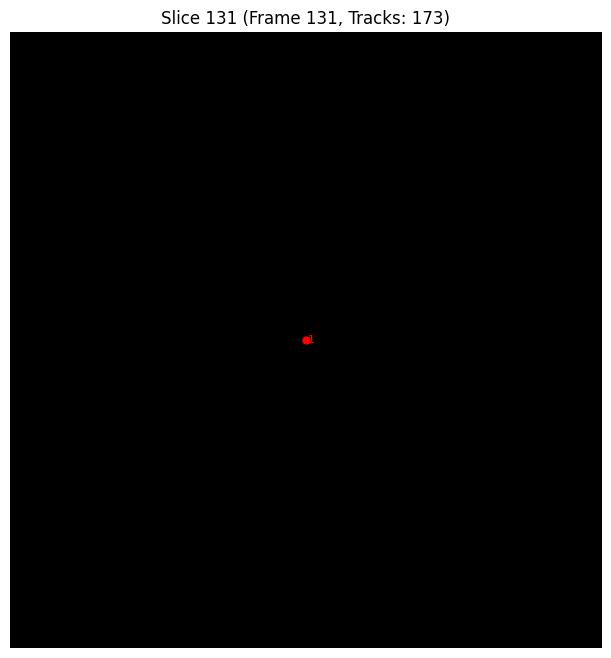

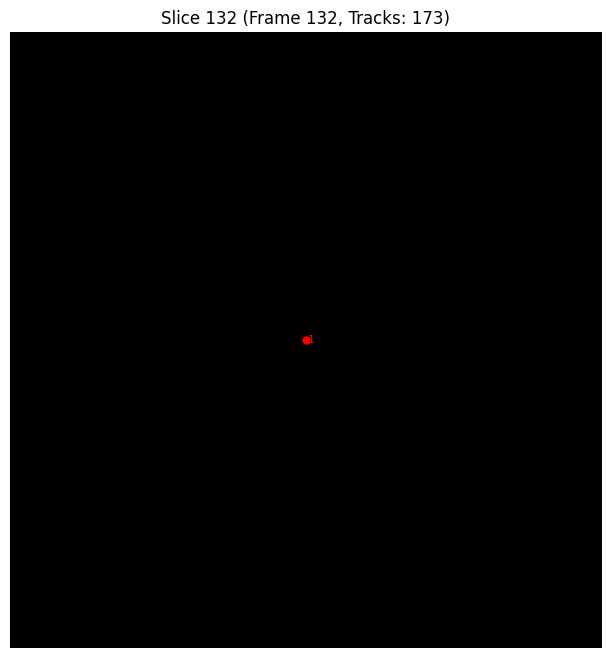

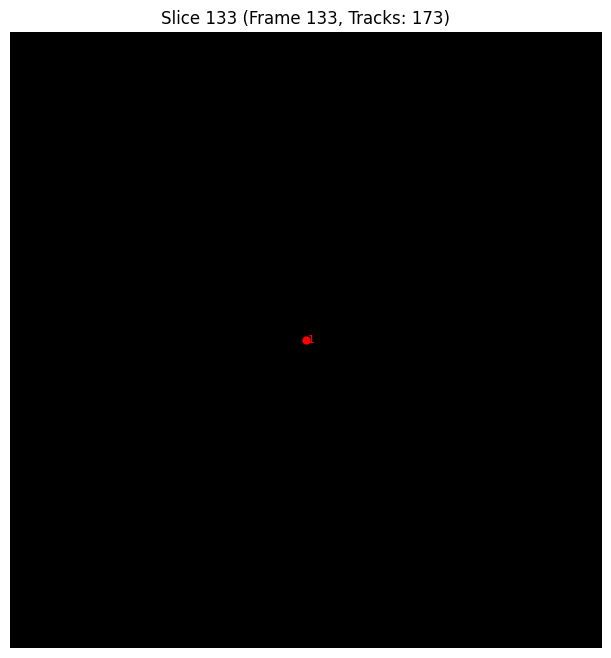

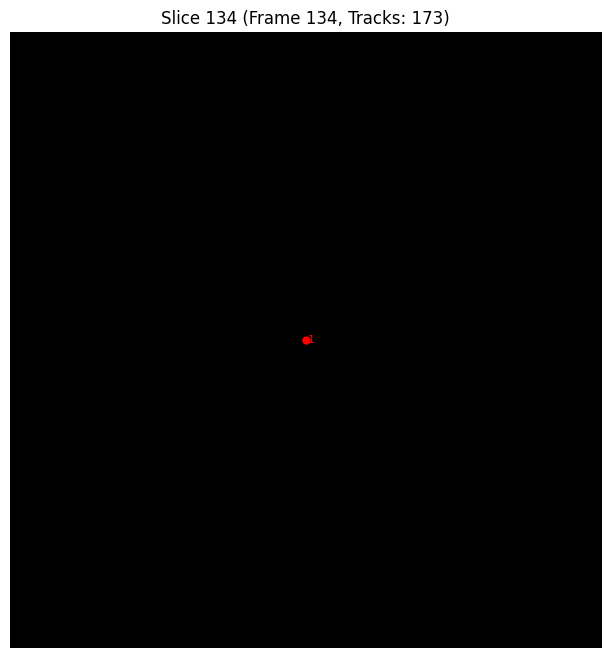

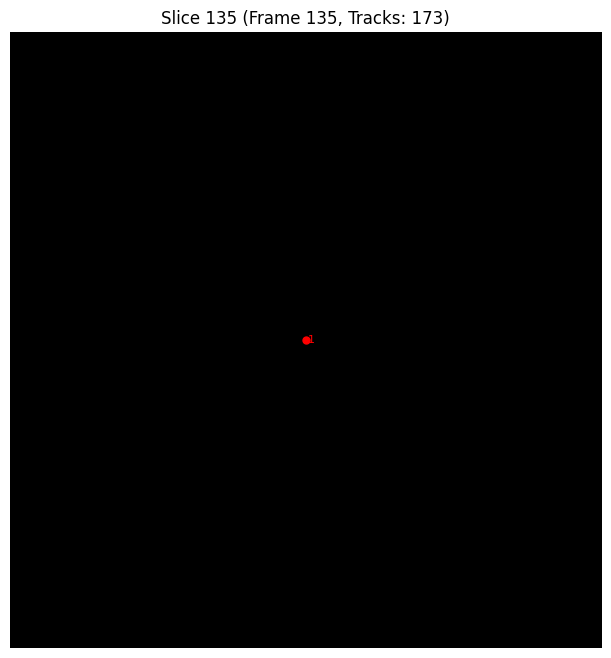

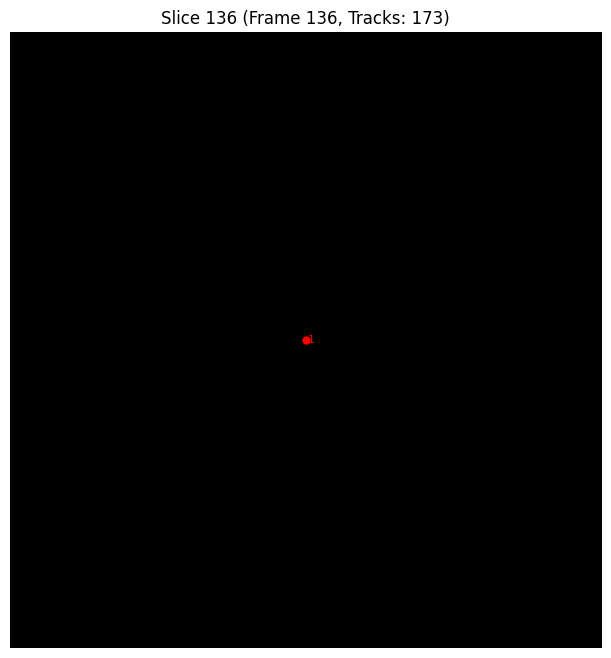

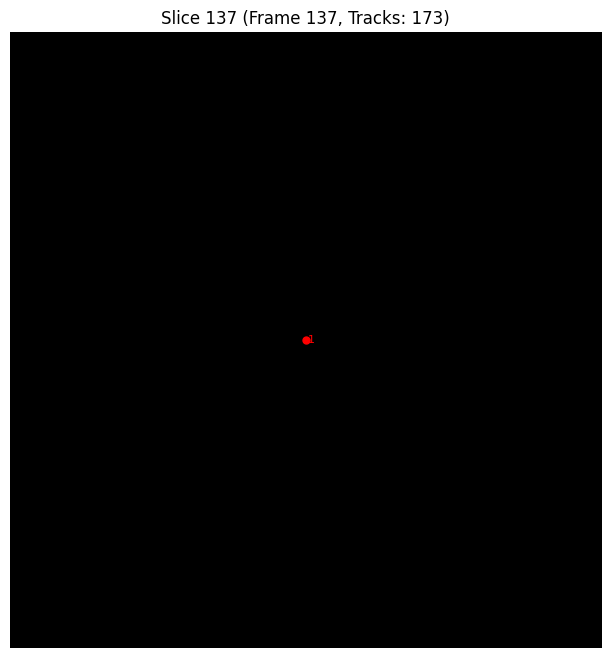

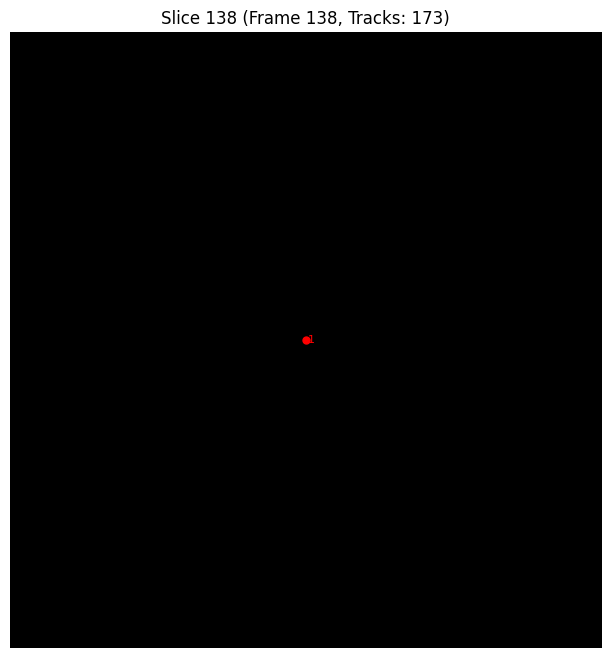

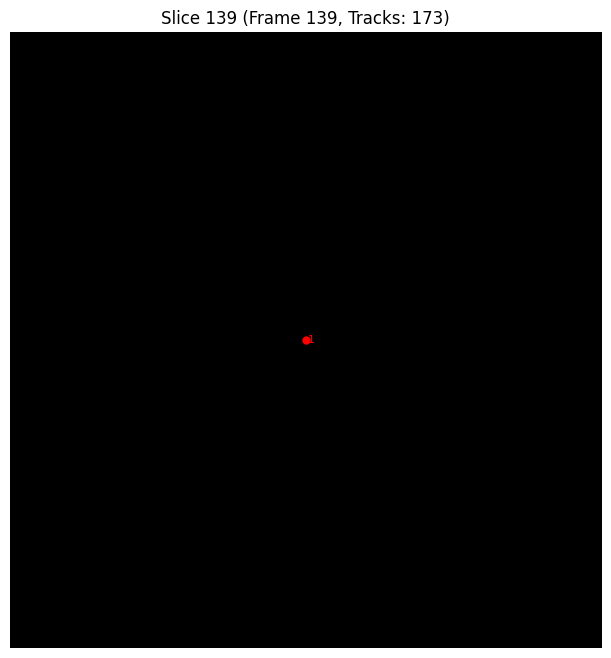

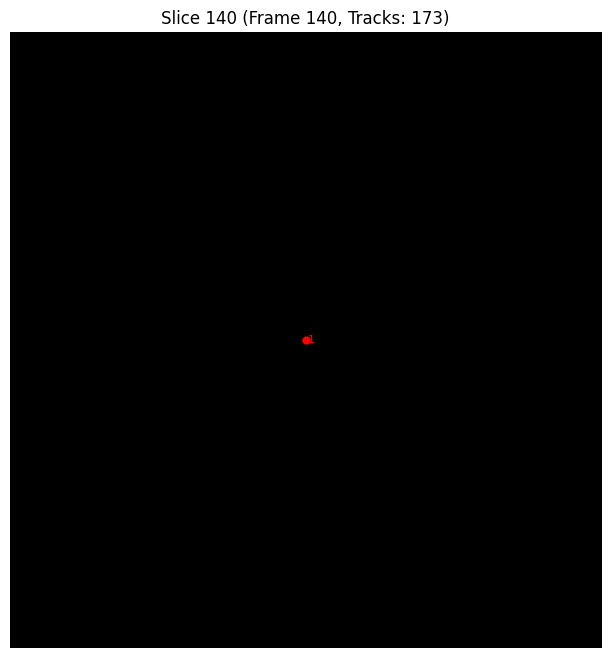

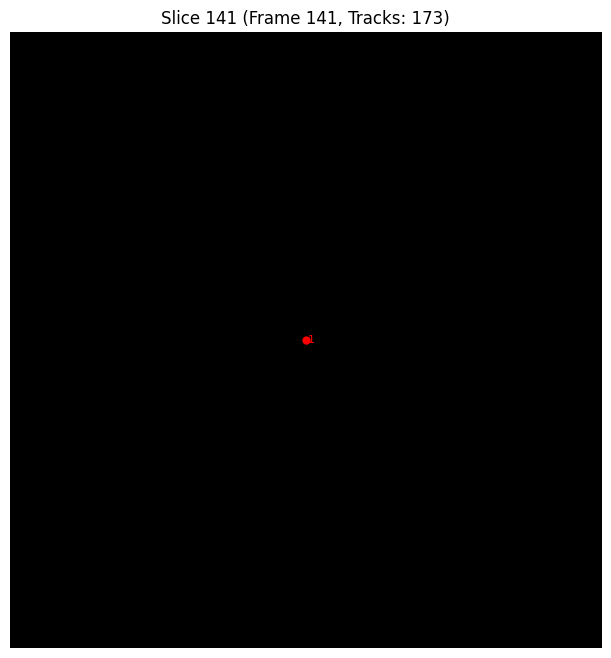

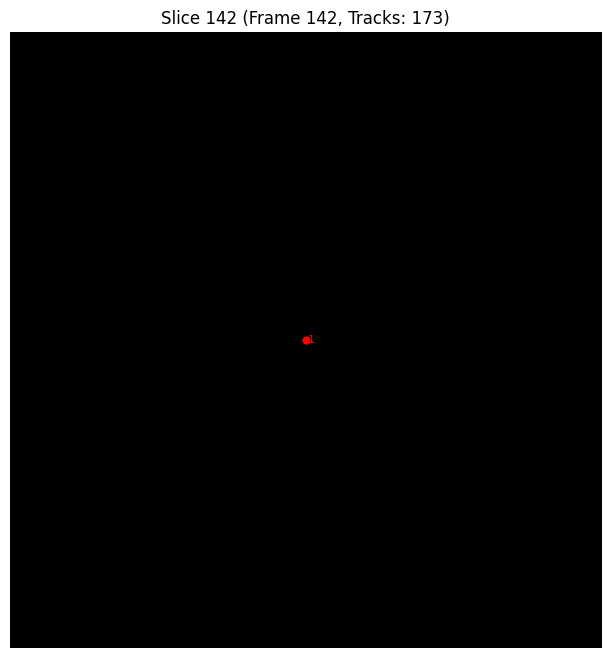

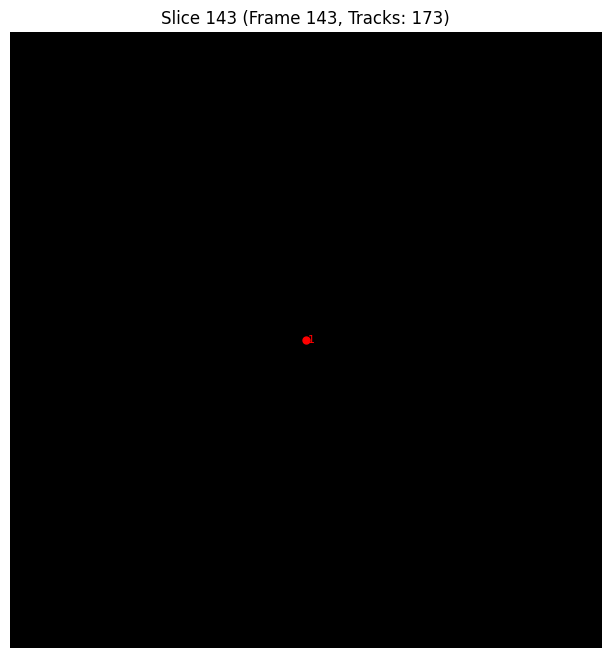

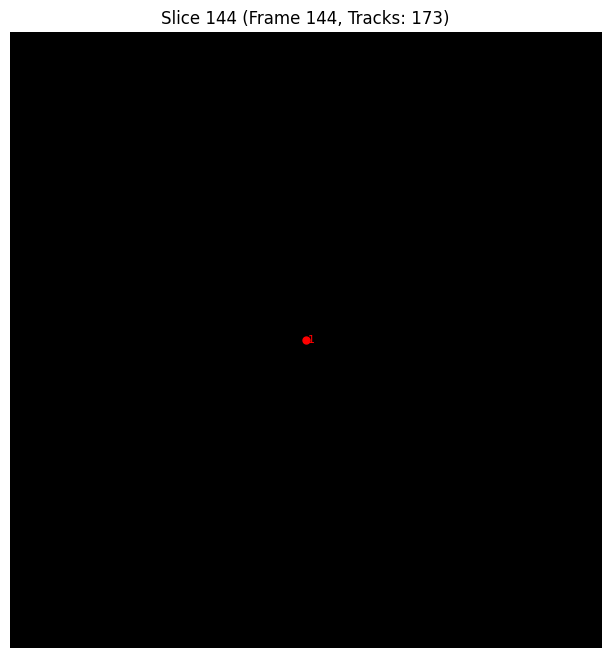

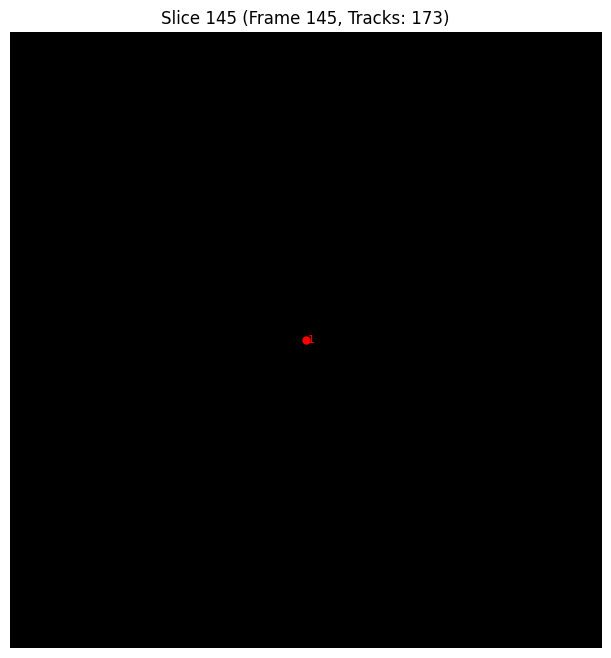

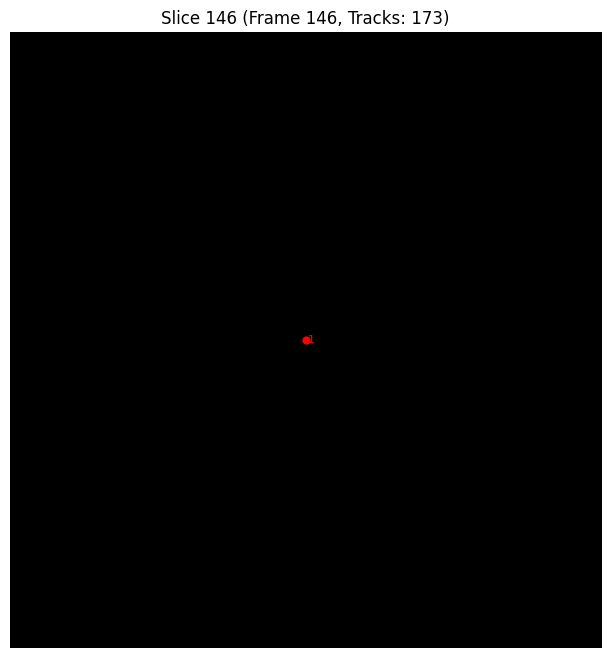

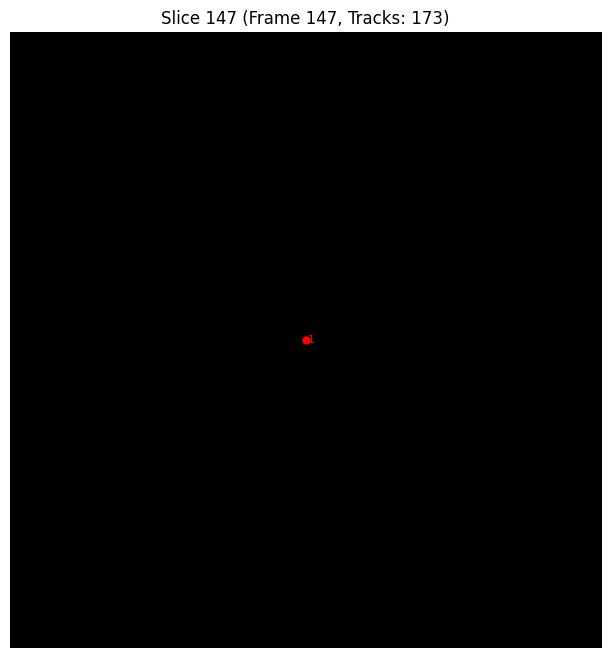

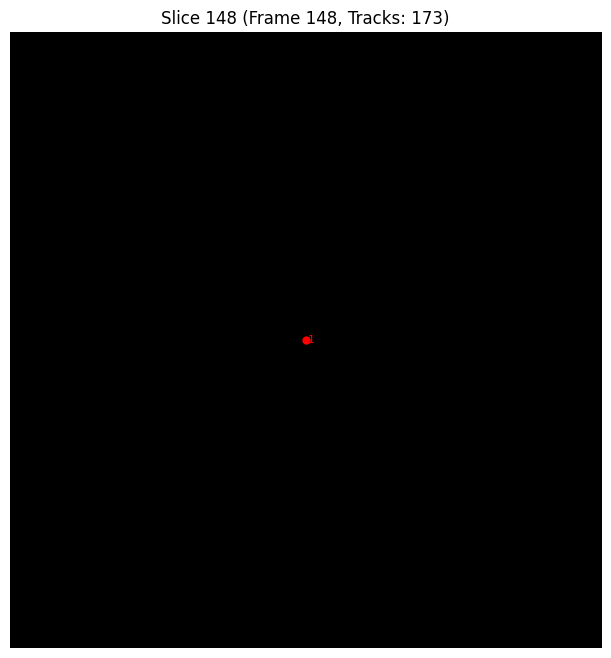

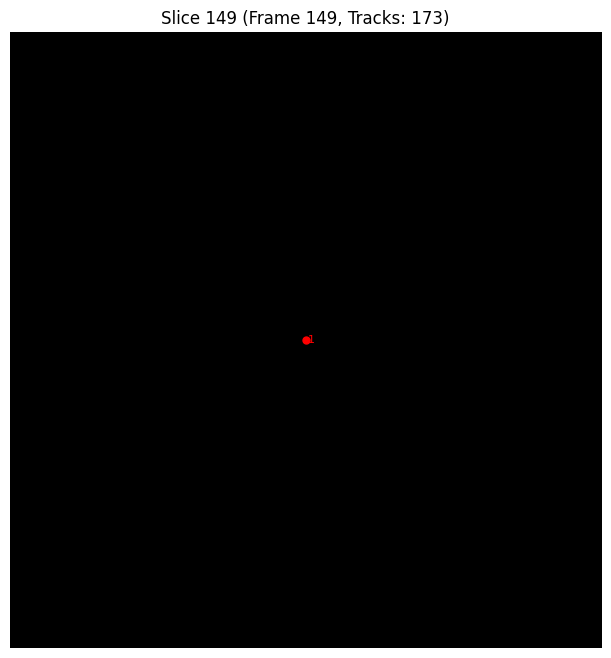

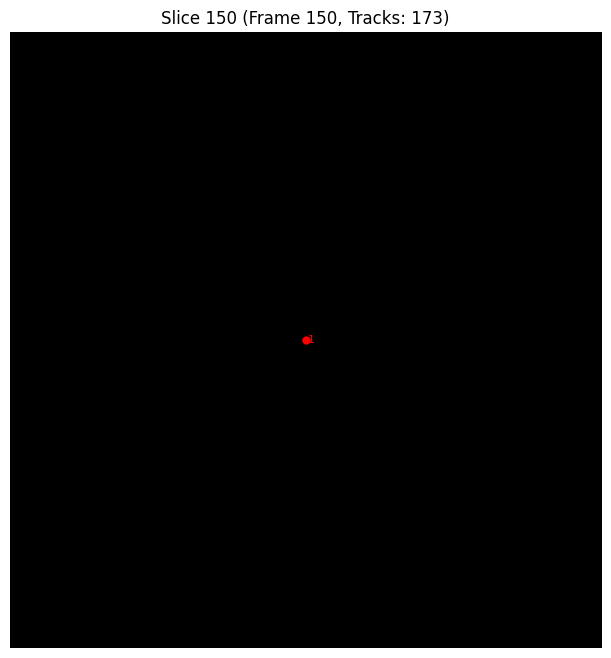

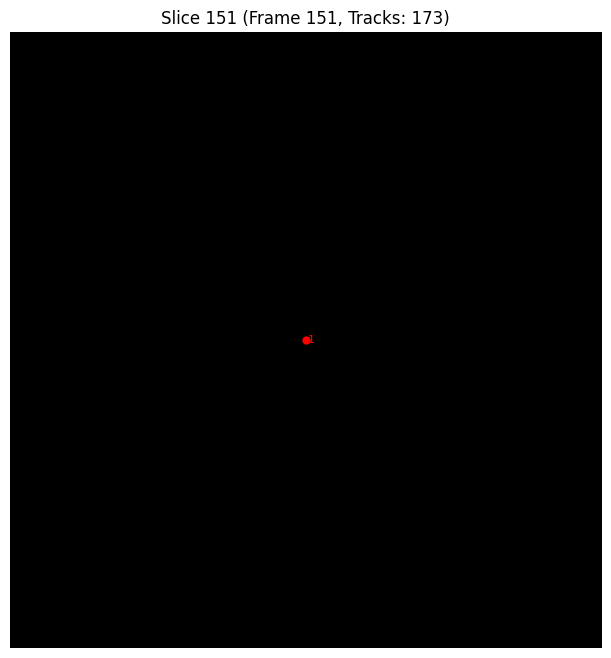

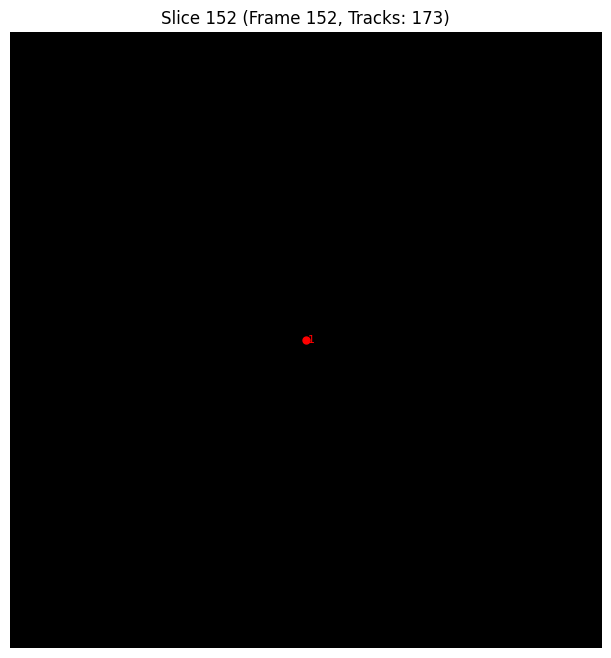

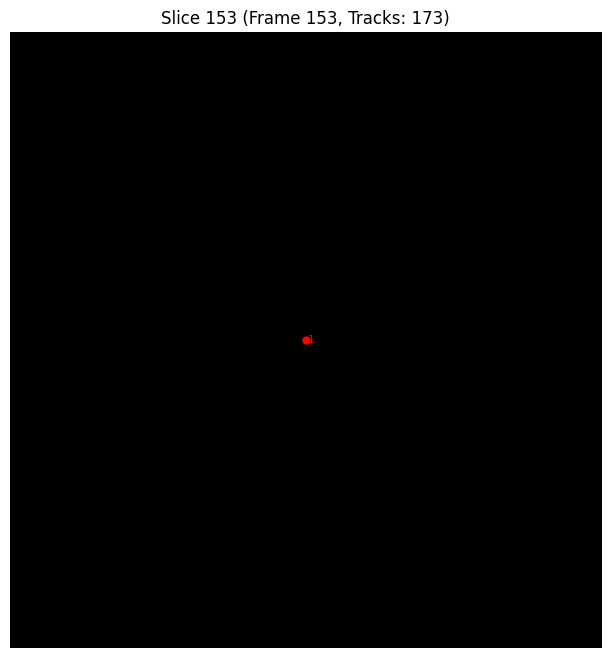

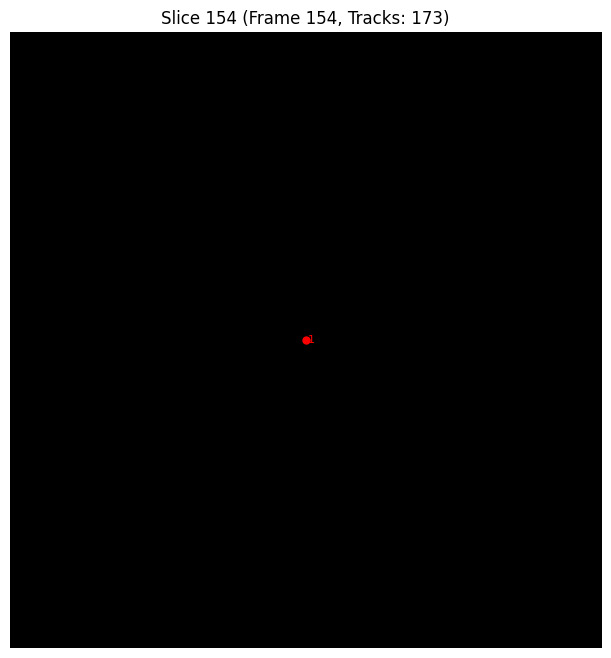

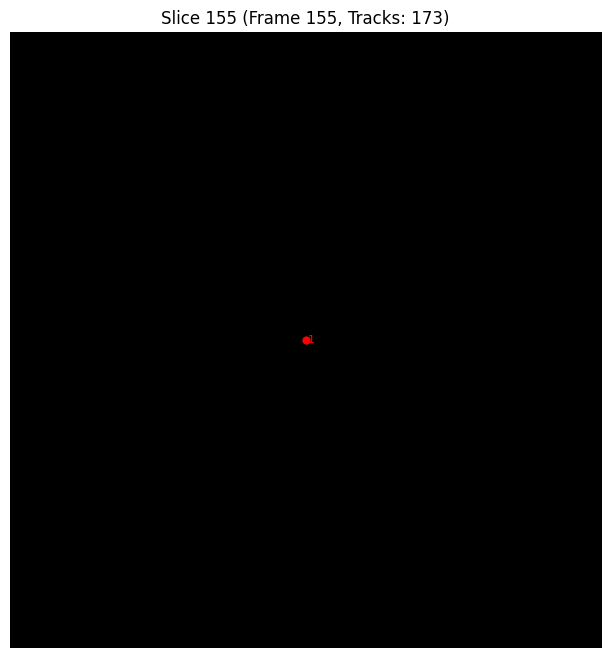

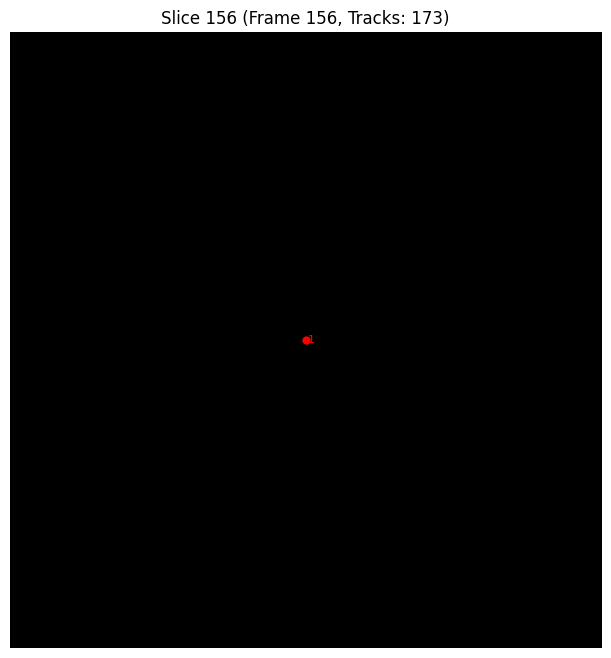

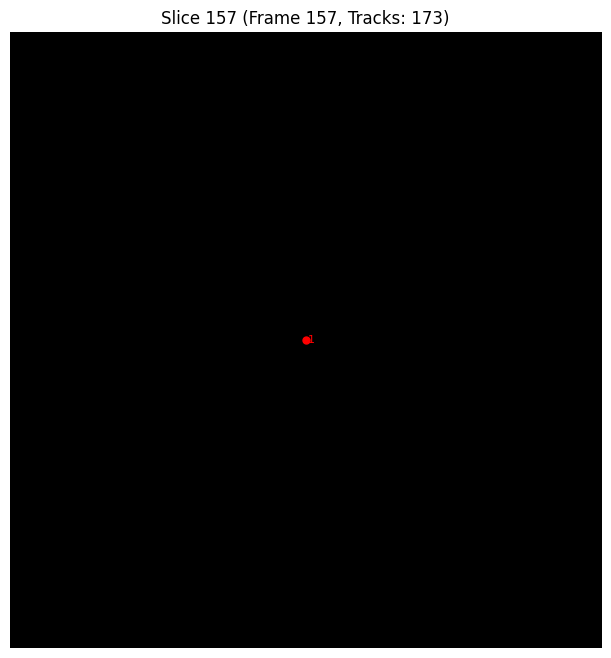

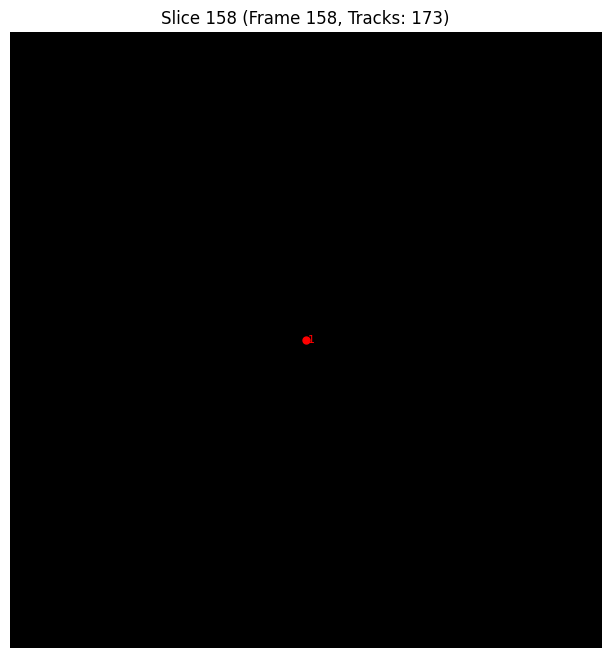

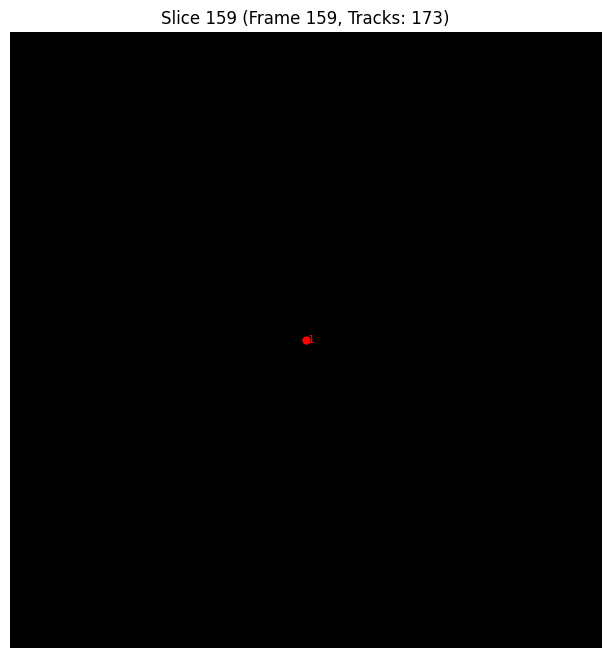

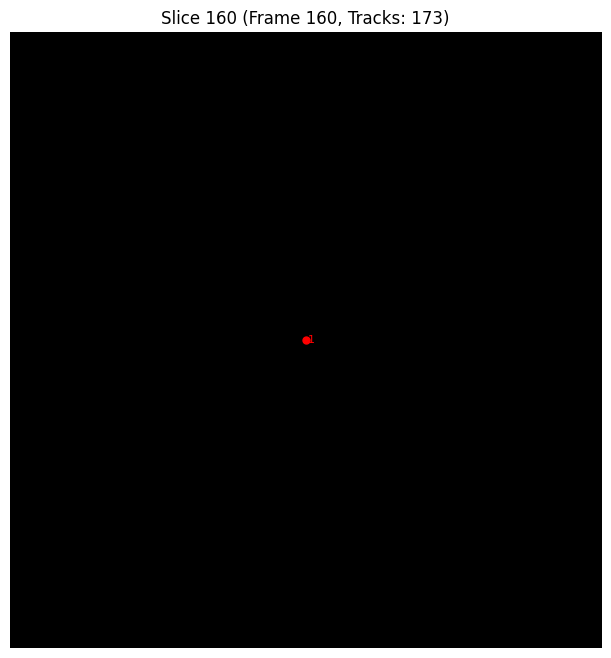

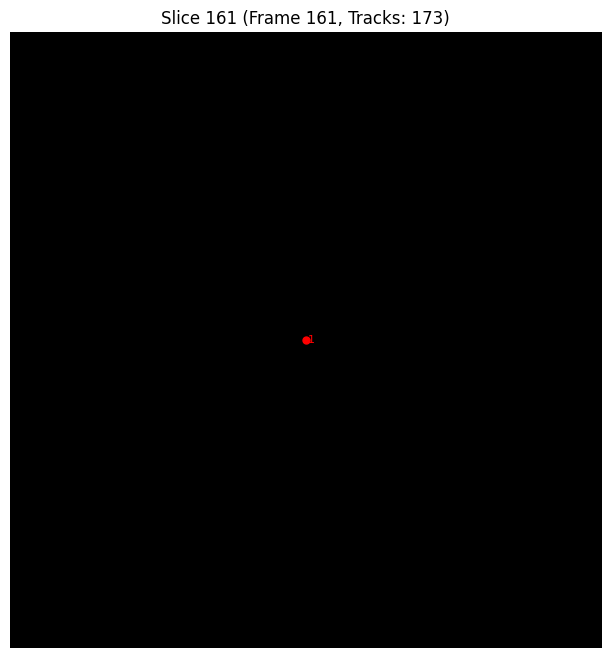

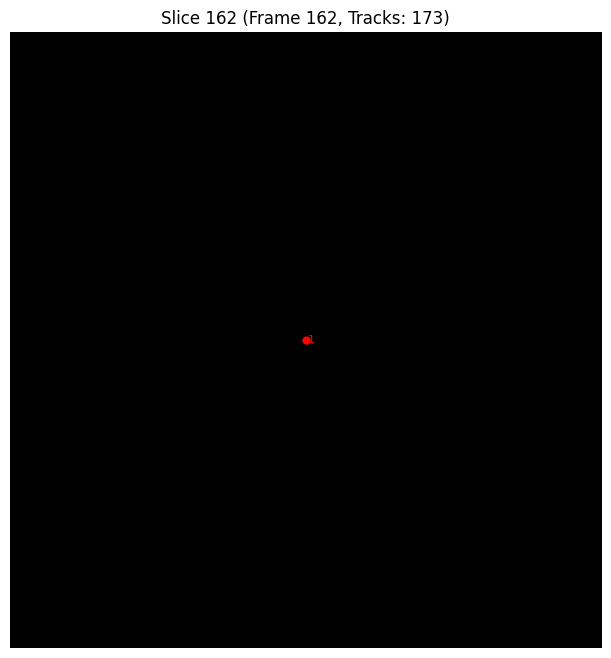

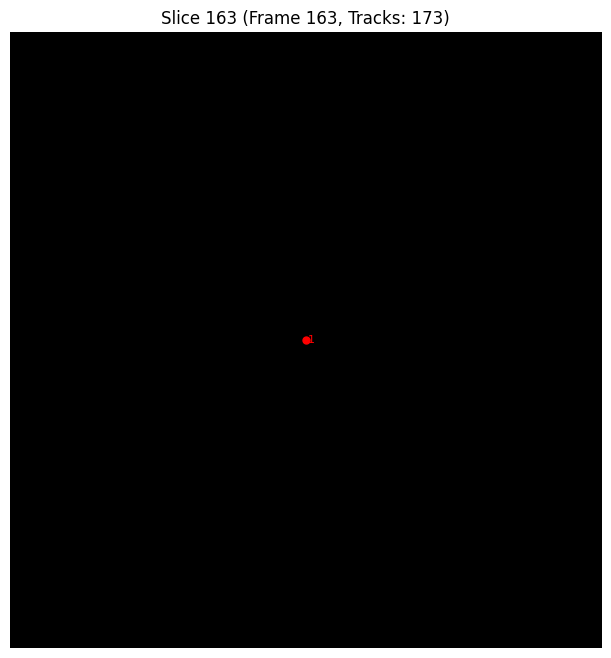

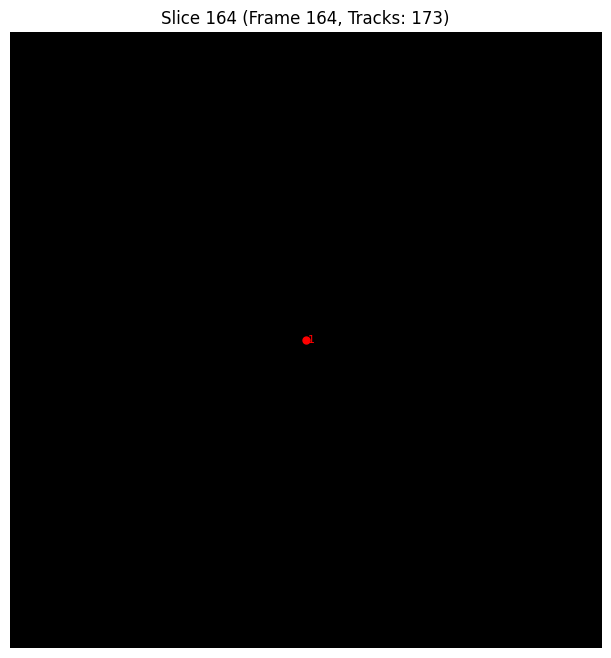

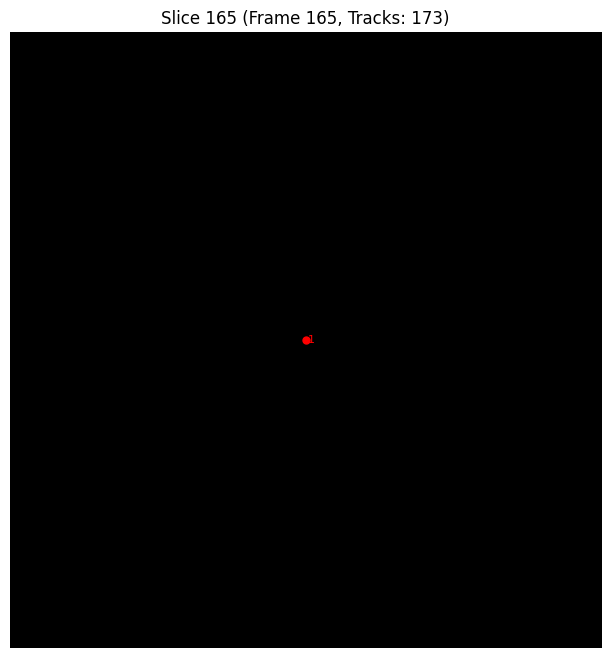

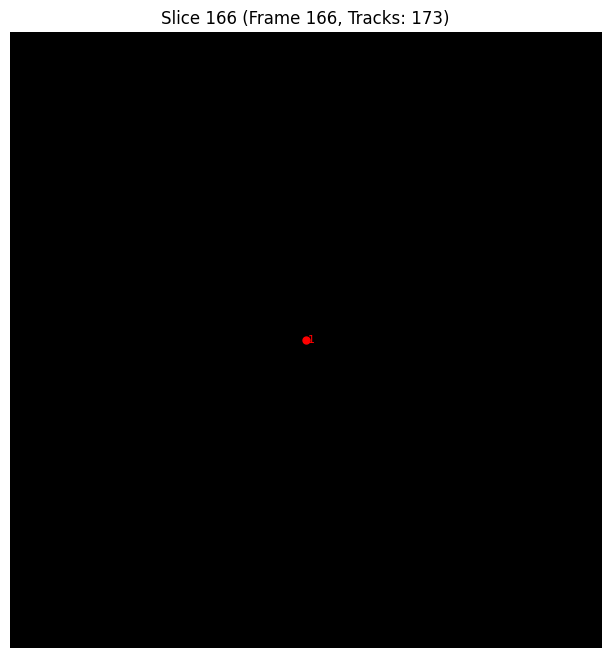

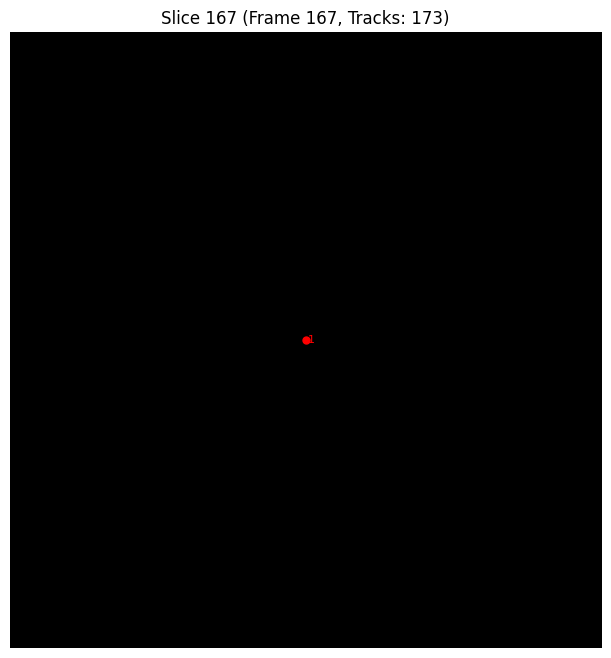

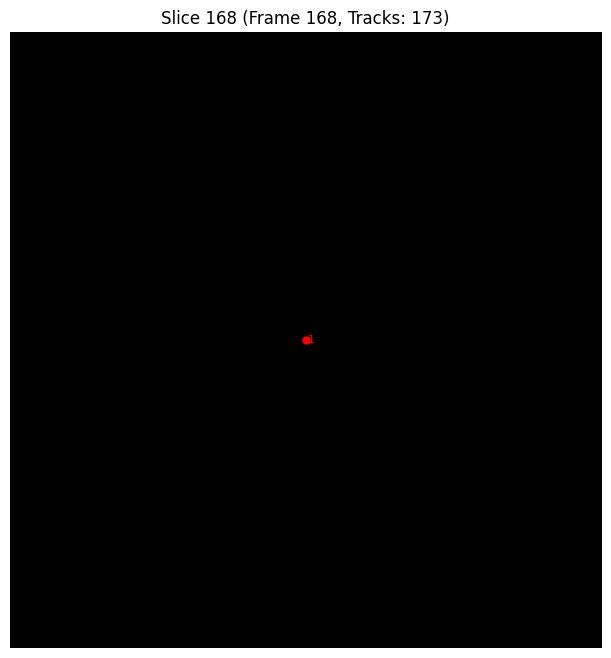

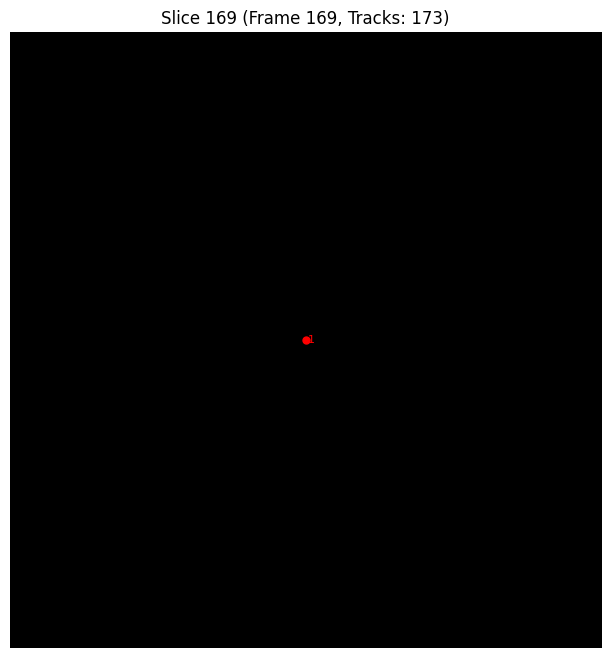

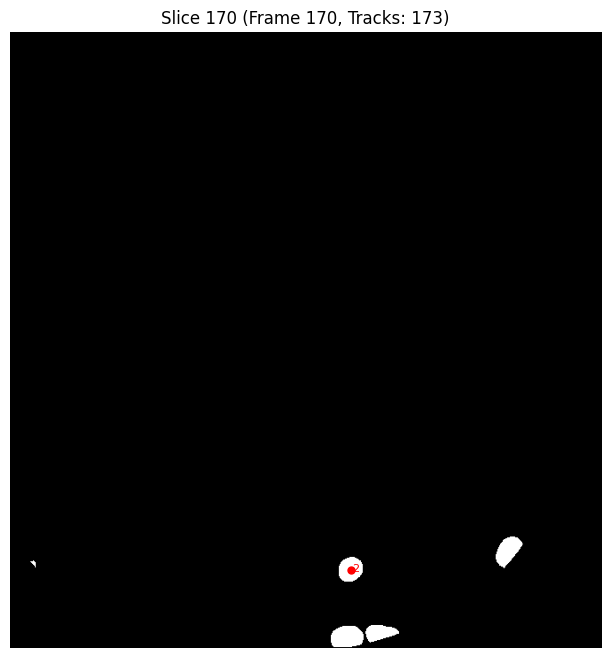

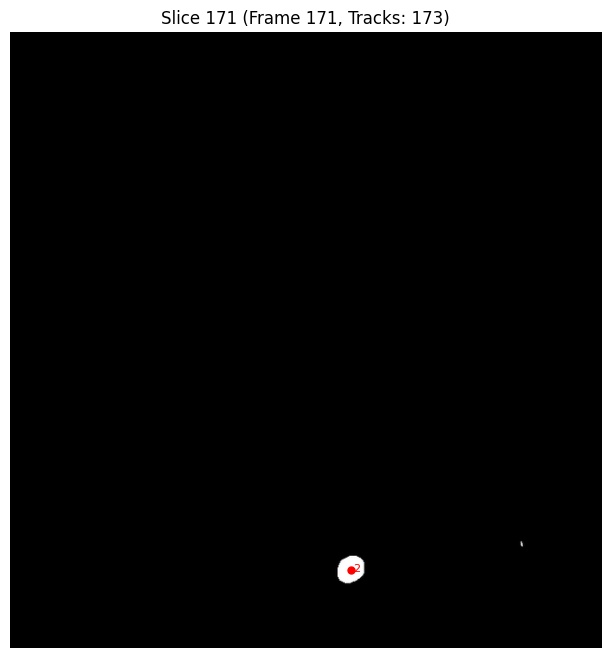

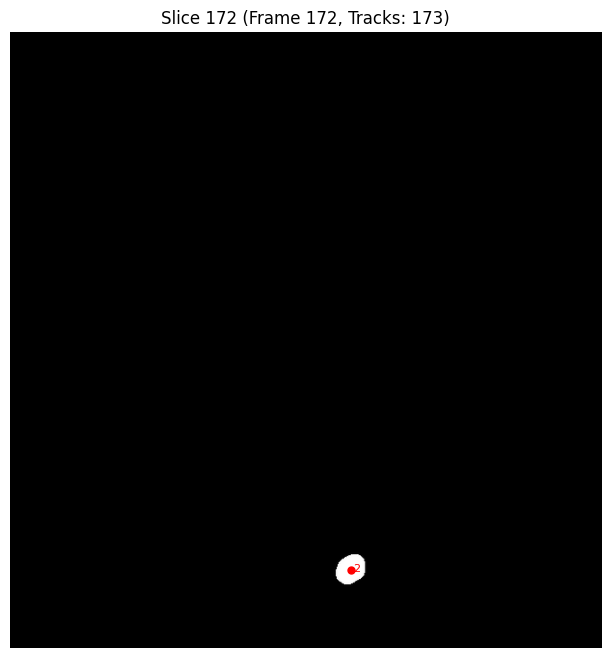

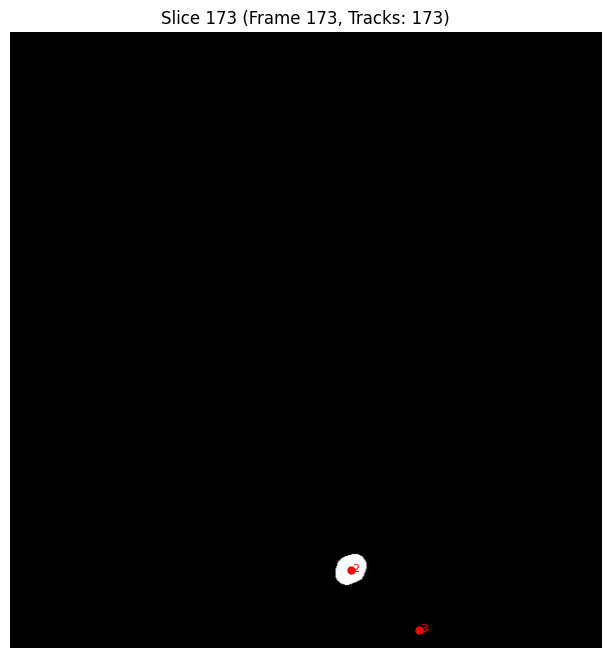

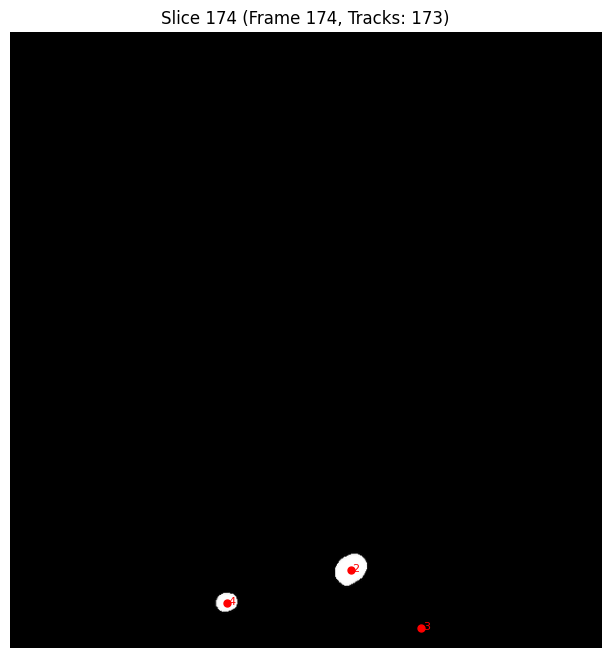

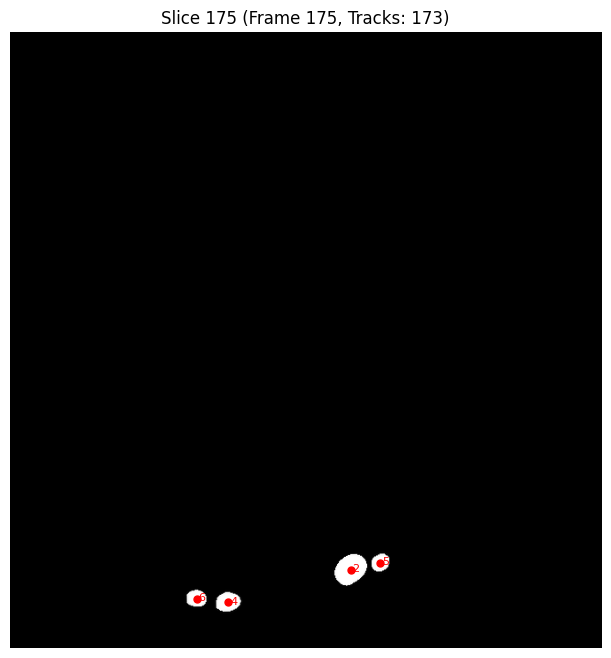

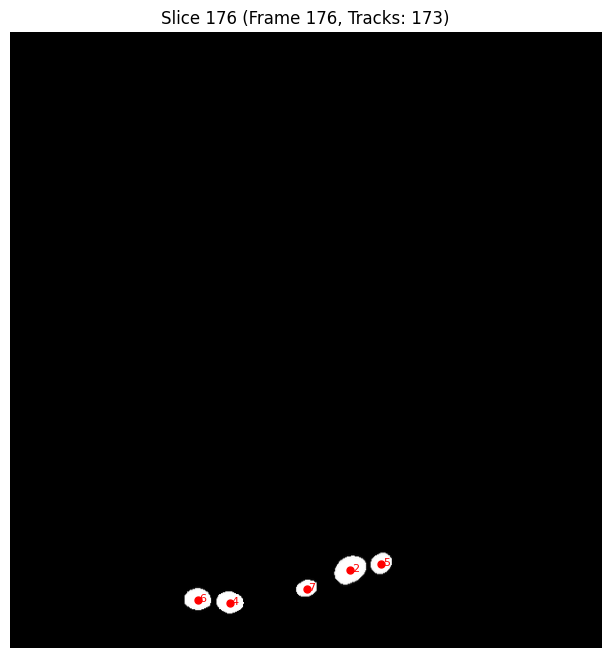

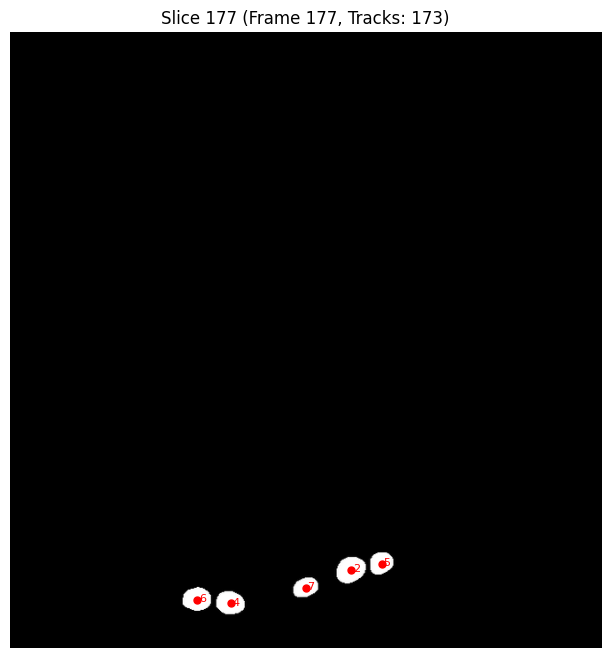

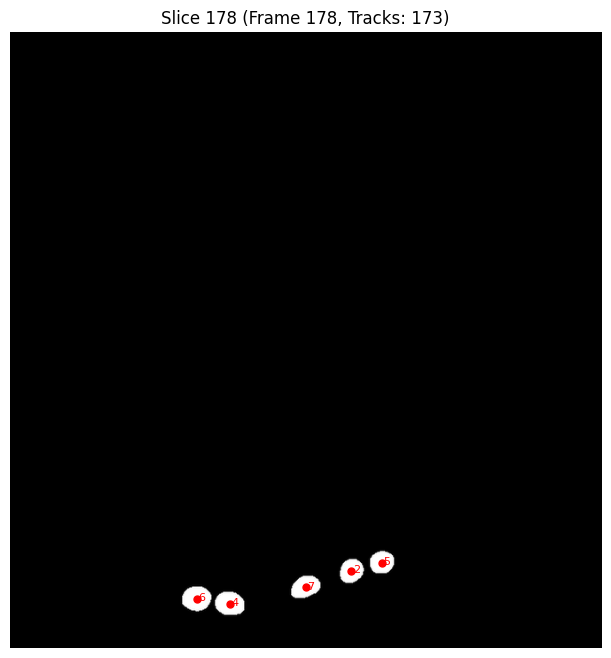

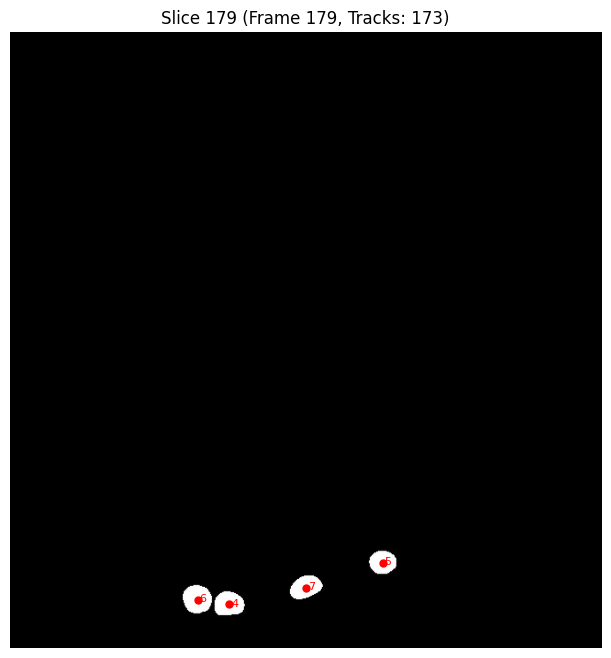

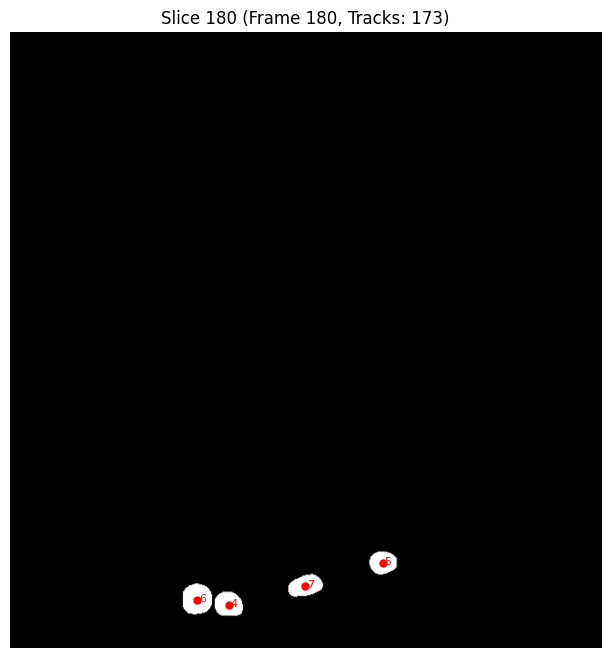

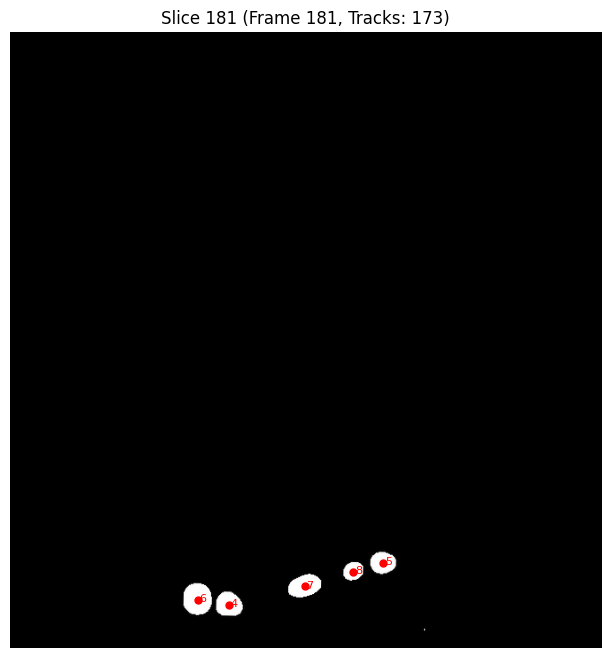

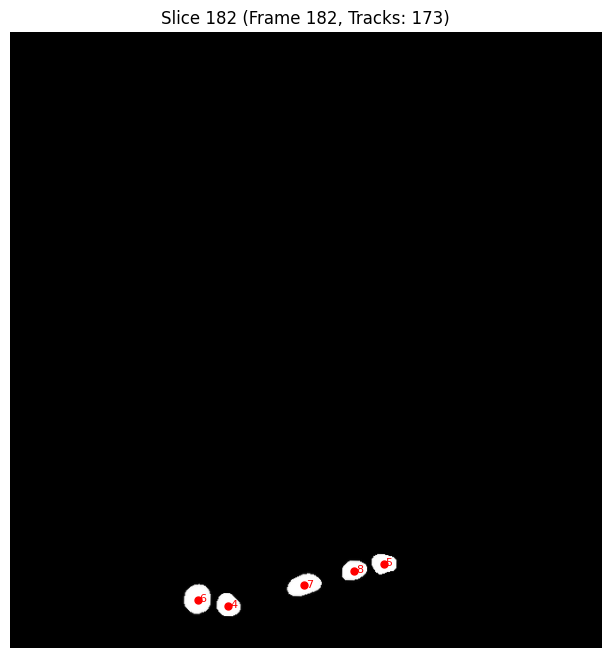

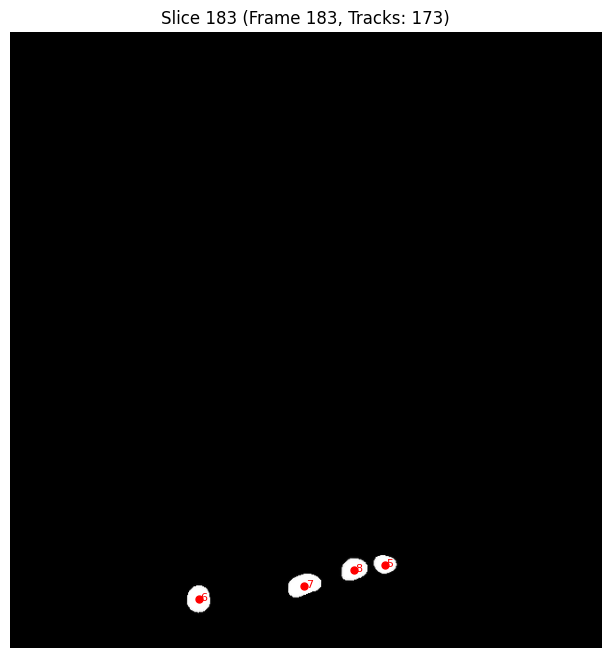

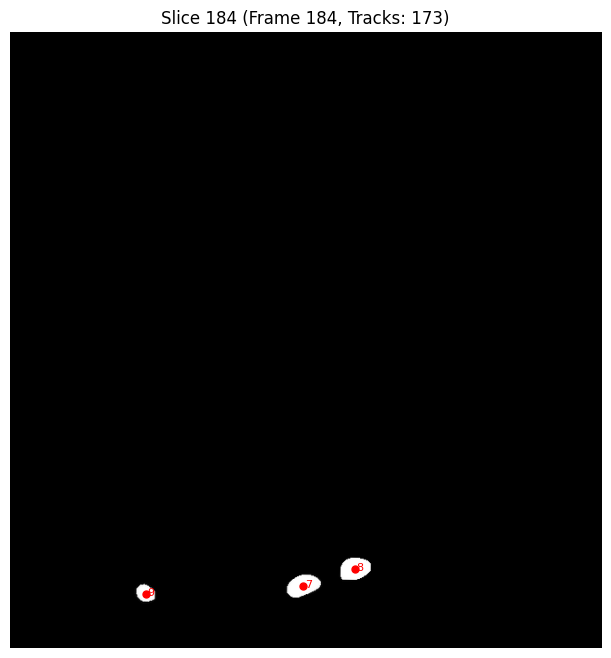

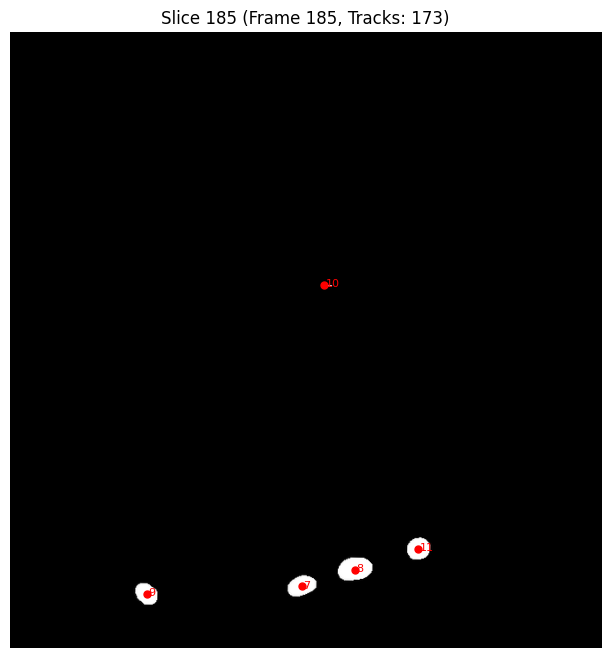

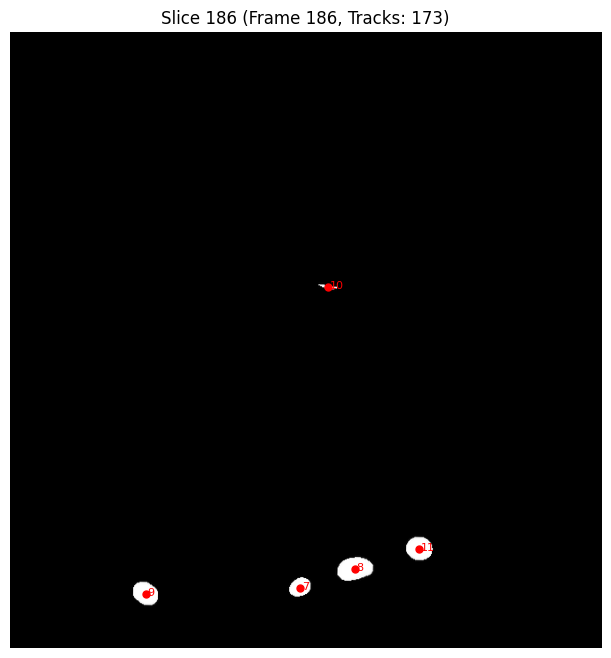

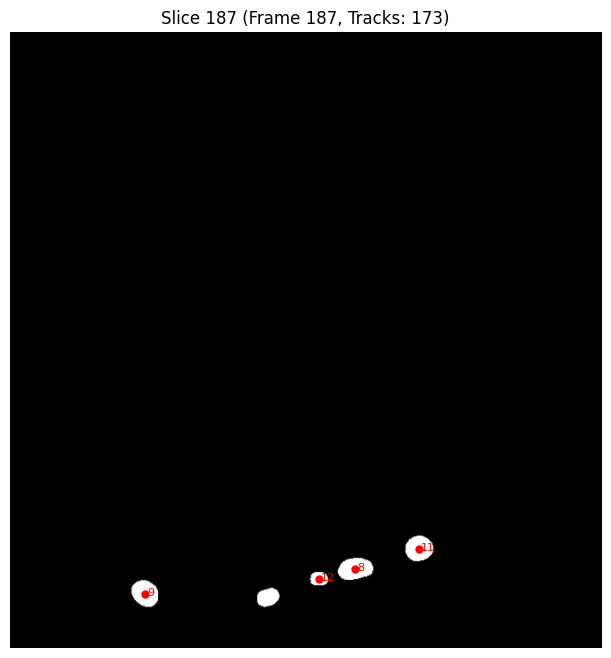

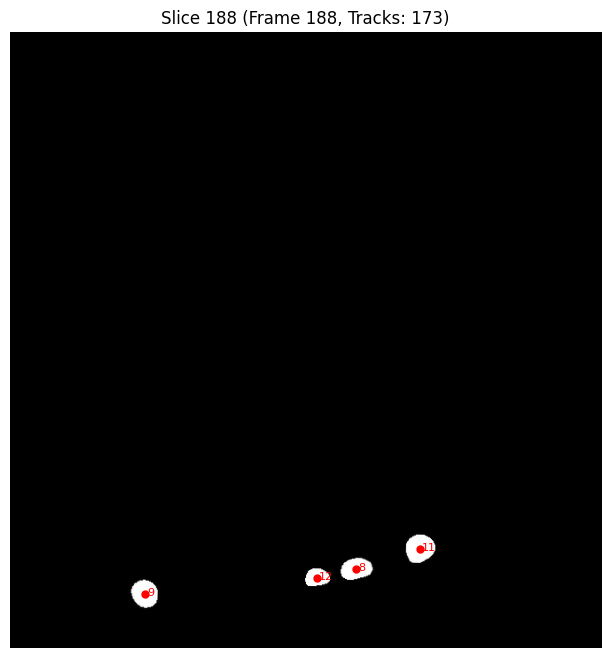

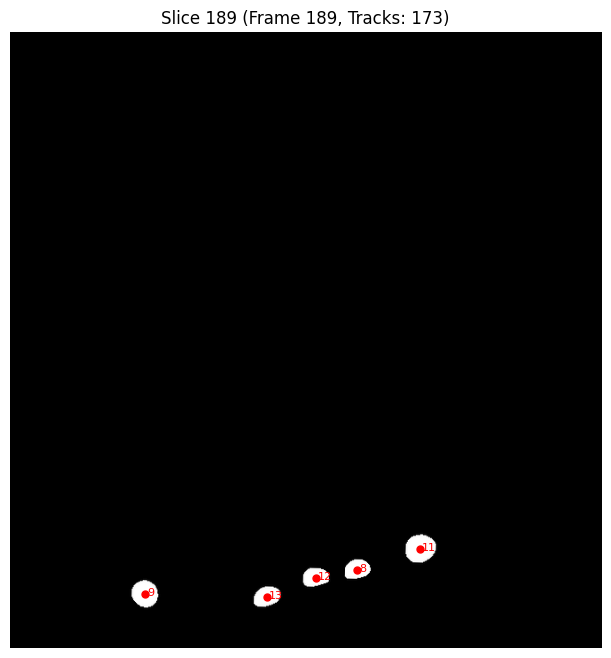

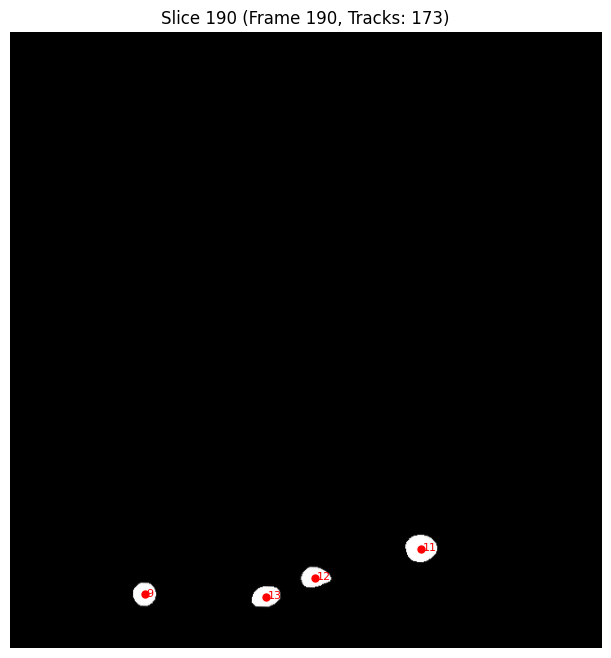

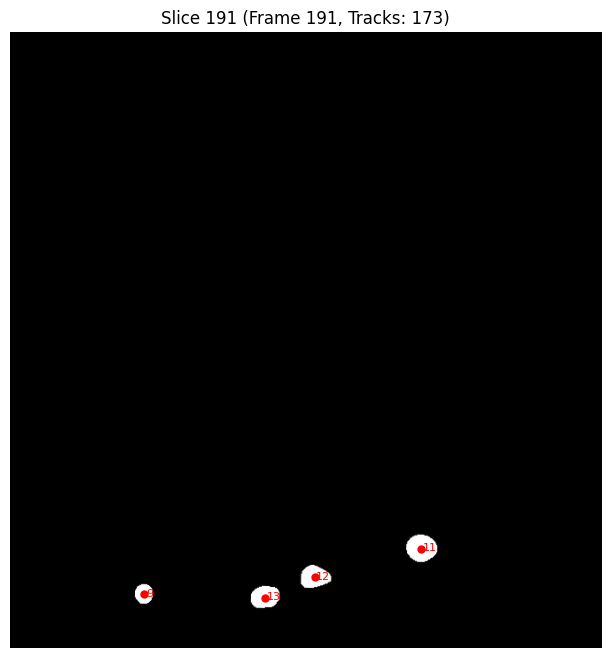

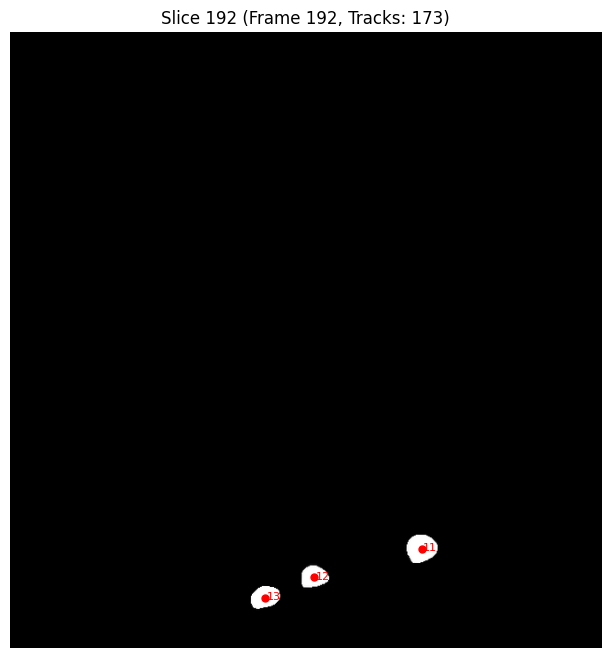

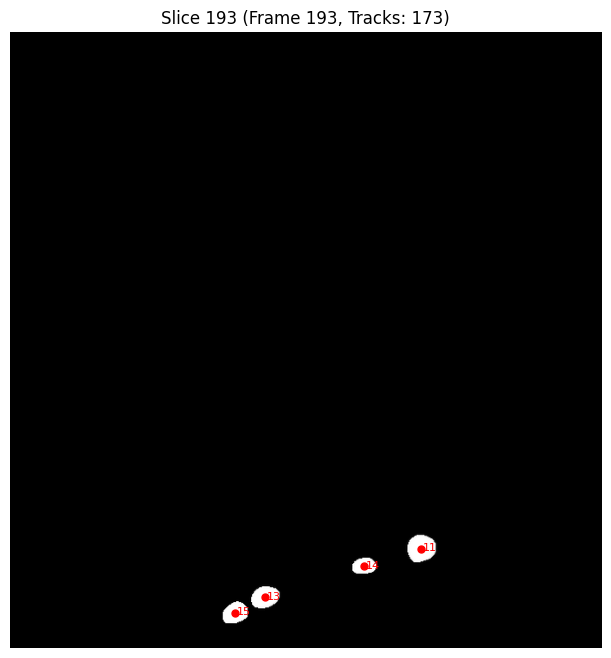

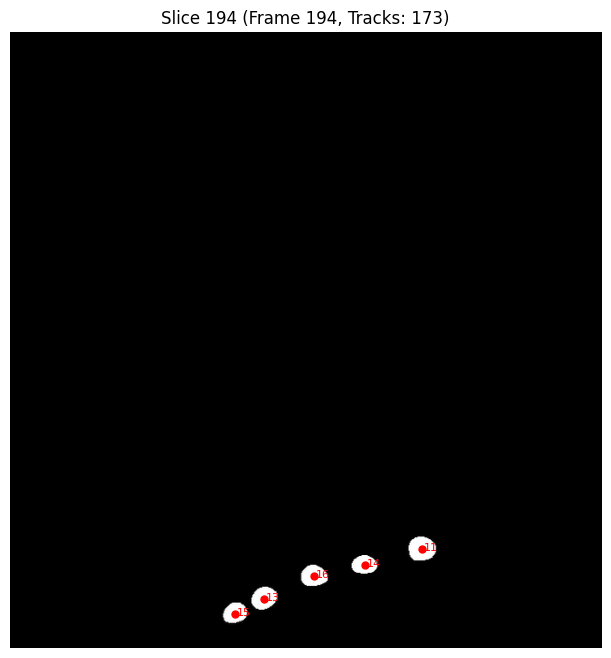

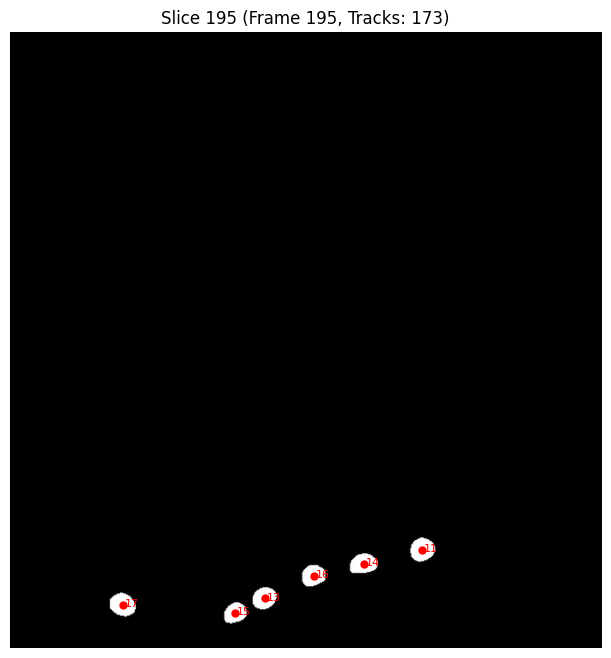

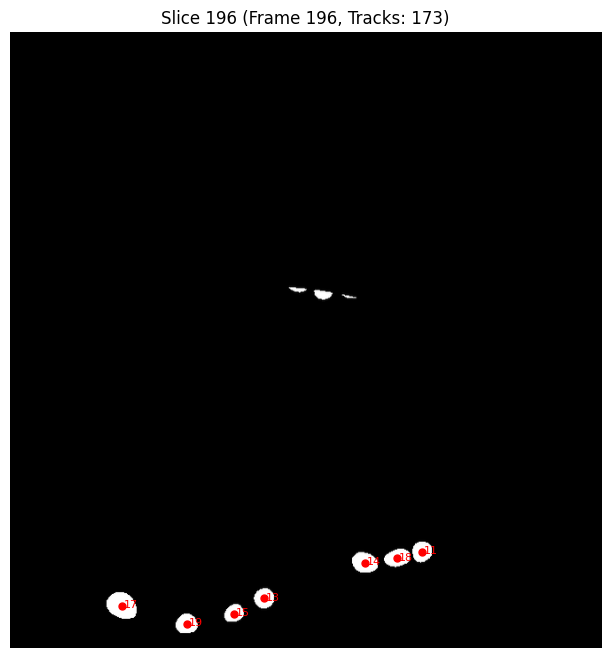

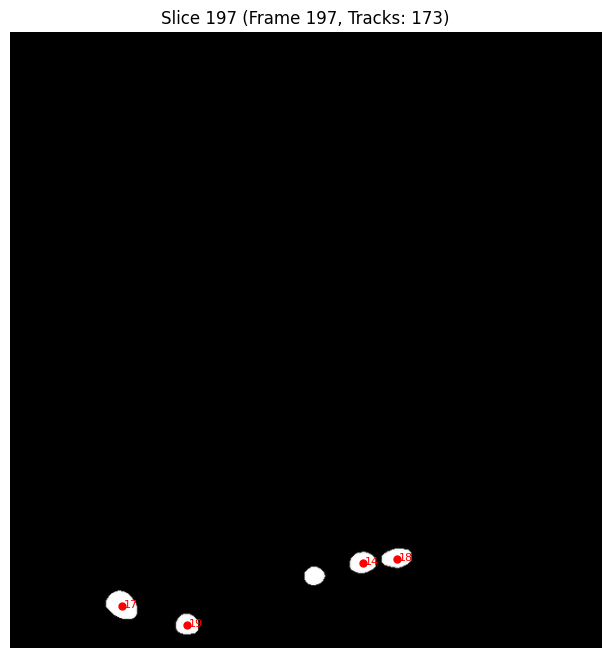

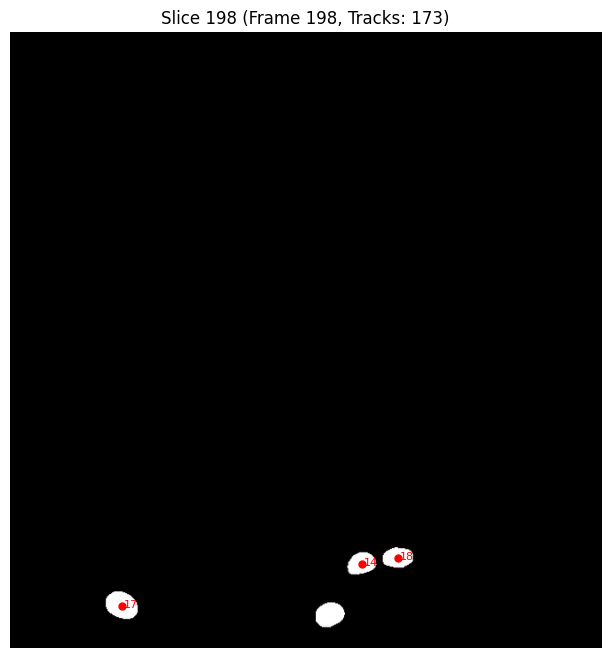

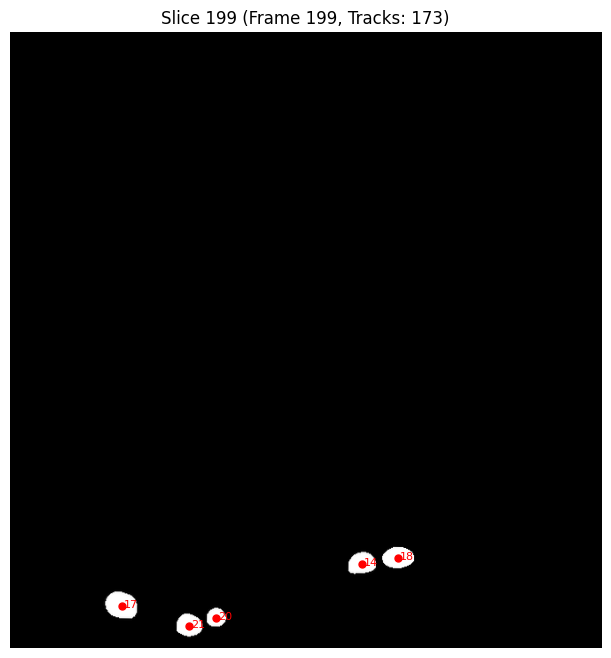

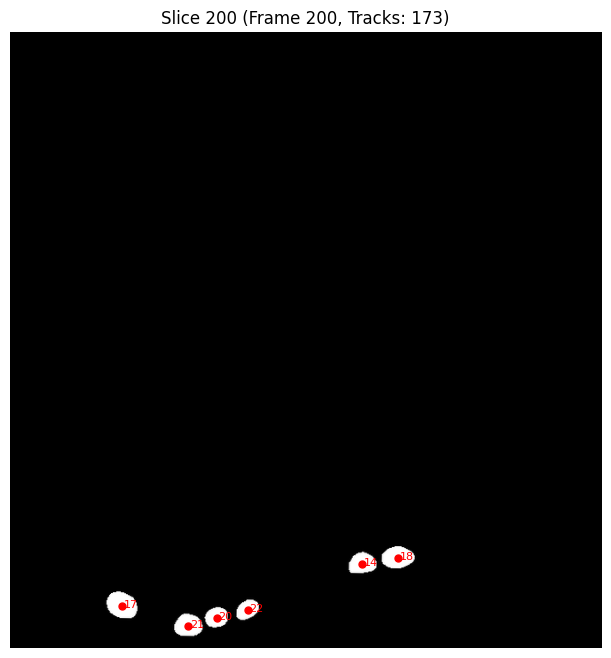

✅ Tracking overlays saved to: /Users/ariellerothman/Desktop/Full Sperm cell Stacks/Sperm 16/MO tracking/temp_overlays
  ✅ Overlays saved to: /Users/ariellerothman/Desktop/Full Sperm cell Stacks/Sperm 16/MO tracking/temp_overlays

✅ Tracking overlay generation complete!


In [33]:
# ========================================
# ⬇️ CONFIGURE: Generate tracking overlays
# ========================================
organelles_to_visualize = ["mitochondria", "MO"]  # Which organelles to generate overlays for

file_paths_viz = get_file_paths(sperm_id=sperm_id, base_dir=base_dir, registered=True)
cell_dir = os.path.join(base_dir, f"Sperm {sperm_id}")

print(f"Generating tracking overlays for Sperm {sperm_id}...\n")

for organelle in organelles_to_visualize:
    print(f"Processing {organelle}...")
    
    try:
        # Find registered TIFF and tracking CSV
        tiff_path = file_paths_viz[organelle]
        
        # Find the tracking CSV
        folder_map = {"MO": "MO tracking", "mitochondria": "Mito tracking"}
        tracking_dir = os.path.join(cell_dir, folder_map[organelle])
        csv_path = os.path.join(tracking_dir, "temp_long.csv")
        
        if not os.path.exists(csv_path):
            print(f"  ⚠️  Tracking CSV not found: {csv_path}")
            continue
        
        # Generate and save overlays
        overlay_dir = visualize_tracking(
            tiff_path=tiff_path,
            csv_path=csv_path,
            frames_to_display=200,  # Show first 200 frames with tracks
            save_overlays=True,
            output_dir=tracking_dir
        )
        
        print(f"  ✅ Overlays saved to: {overlay_dir}\n")
        
    except Exception as e:
        print(f"  ❌ Error processing {organelle}: {str(e)[:100]}\n")

print("✅ Tracking overlay generation complete!")

## Step 3: BATCH PROCESSING (Multiple Sperm Cells)
**Processes multiple sperm cells in one run.** This is the recommended workflow for analyzing many cells.

### How to Use Batch Processing:
1. **Edit the configuration** in the cell below (paths & sperm IDs)
2. **Run the cell** - it will process all cells and save outputs
3. **Check progress** - status messages show which cell is being processed
4. **View results** - Excel file contains all metrics for all cells

In [25]:
# ========================================
# ⬇️ CONFIGURE: Batch Processing Settings
# ========================================
parent_dir = "/Users/ariellerothman/Desktop/Full Sperm cell Stacks"
sperm_ids_to_process = [18]  # Edit this list: which sperm cells to process
output_dir = os.path.join(parent_dir, "batch_results_all_cells")
excel_path = os.path.join(output_dir, "all_metrics_batch.xlsx")

# Configuration from src.config (see config.py for detailed explanations)
from src.config import REFERENCE_POINT_XYZ  # Spermathecal valve center in global image space

# Magic numbers used locally (also see config.py for details)
TOTAL_TRACKS = 400                          # TrackMate total tracks
MESH_MIN_SIZE = 100                         # Min voxels for 3D mesh extraction
MESH_BLUR = 0.0                             # Gaussian blur on organelle stacks (0 = no blur)
MESH_CLOSE_RADIUS = 0                       # Morphological closing radius (0 = no closing)

In [ ]:
# ========================================
# ⬇️ RUN: Execute batch processing for all sperm cells
# ========================================
import glob as glob_module

os.makedirs(output_dir, exist_ok=True)

all_batch_metrics = []
processing_log = []

print(f"🚀 Starting batch processing for {len(sperm_ids_to_process)} sperm cells...")
print(f"   Output folder: {output_dir}\n")

for idx, sperm_id in enumerate(sperm_ids_to_process, 1):
    try:
        print(f"[{idx}/{len(sperm_ids_to_process)}] Processing Sperm {sperm_id}...", end=" ")
        
        # Get file paths with registered versions (for tracking conversion)
        file_paths = get_file_paths(sperm_id=sperm_id, base_dir=parent_dir, registered=True)
        cell_dir = os.path.join(parent_dir, f"Sperm {sperm_id}")
        
        # === CONVERT TRACKING CSVs (if not already converted) ===
        # The find_csv_by_pattern returns raw "tracking results" files
        # These need to be converted to long format for watershed segmentation
        mo_csv = None
        mito_csv = None
        
        for organelle in ["MO", "mitochondria"]:
            folder_map = {"MO": "MO tracking", "mitochondria": "Mito tracking"}
            tracking_dir = os.path.join(cell_dir, folder_map[organelle])
            long_csv_path = os.path.join(tracking_dir, "temp_long.csv")
            
            # Check if long CSV already exists
            if os.path.exists(long_csv_path):
                if organelle == "MO":
                    mo_csv = long_csv_path
                else:
                    mito_csv = long_csv_path
                print(f"\n    ✓ Found pre-converted {organelle} CSV: {os.path.basename(long_csv_path)}", end="")
            else:
                # Need to convert the raw tracking results CSV
                try:
                    long_csv_output = run_tracking_pipeline(
                        cell_number=sperm_id,
                        base_dir=parent_dir,
                        organelle=organelle,
                        total_tracks=TOTAL_TRACKS
                    )
                    
                    # Move to organized subfolder structure
                    os.makedirs(tracking_dir, exist_ok=True)
                    shutil.move(long_csv_output, long_csv_path)
                    
                    if organelle == "MO":
                        mo_csv = long_csv_path
                    else:
                        mito_csv = long_csv_path
                    print(f"\n    ✓ Converted and saved {organelle} CSV: {os.path.basename(long_csv_path)}", end="")
                except Exception as e:
                    print(f"\n    ⚠️  Could not convert {organelle} CSV: {str(e)[:50]}", end="")
        
        # === GENERATE TRACKING OVERLAYS for quality verification ===
        # Create overlays for visual inspection of tracking quality
        try:
            from src.tracking import visualize_tracking
            
            for organelle in ["mitochondria", "MO"]:
                folder_map = {"MO": "MO tracking", "mitochondria": "Mito tracking"}
                tracking_dir = os.path.join(cell_dir, folder_map[organelle])
                long_csv_path = os.path.join(tracking_dir, "temp_long.csv")
                tiff_path = file_paths[organelle]
                
                if os.path.exists(tiff_path) and os.path.exists(long_csv_path):
                    try:
                        overlay_dir = visualize_tracking(
                            tiff_path=tiff_path,
                            csv_path=long_csv_path,
                            frames_to_display=200,  # Show all frames with tracking
                            save_overlays=True
                        )
                        if overlay_dir:
                            print(f"\n    ✓ Tracking overlays saved ({organelle})", end="")
                    except Exception as e:
                        print(f"\n    ⚠️  Could not create {organelle} overlays: {str(e)[:40]}", end="")
        except ImportError:
            # visualize_tracking not available in this version
            pass
        except Exception as e:
            print(f"\n    ⚠️  Overlay generation error: {str(e)[:40]}", end="")
        
        # === Get reference centroids ===
        pseudopod_centroid = get_centroid(file_paths["pseudopod"])
        nucleus_centroid = get_centroid(file_paths["nucleus"])
        
        # === Compute organelle metrics ===
        organelle_inputs = [
            ("mitochondria", file_paths["mitochondria"], mito_csv),
            ("MO", file_paths["MO"], mo_csv),
            ("pseudopod", file_paths["pseudopod"], None),
            ("nucleus", file_paths["nucleus"], None),
            ("sperm_cell", file_paths["sperm_cell"], None),
        ]
        
        sample_id = f"sperm_{sperm_id}"
        cell_metrics = []
        for org_name, stack_path, csv_path in organelle_inputs:
            df = compute_organelle_metrics(
                org_name, stack_path, csv_path,
                pseudopod_centroid, nucleus_centroid, sample_id
            )
            cell_metrics.append(df)
        
        # Combine all organelles for this cell
        cell_df = pd.concat(cell_metrics, ignore_index=True)
        all_batch_metrics.append(cell_df)
        
        # === Compute spatial metrics ===
        try:
            file_paths_crop = get_file_paths(sperm_id=sperm_id, base_dir=parent_dir, registered=True)
            roi_path = find_roi_file(os.path.dirname(file_paths_crop["sperm_cell"]))
            
            spatial_metrics = compute_spatial_metrics(
                sperm_cell_path=file_paths_crop["sperm_cell"],
                pseudopod_path=file_paths_crop["pseudopod"],
                nucleus_path=file_paths_crop["nucleus"],
                roi_path=roi_path,
                reference_point_xyz=REFERENCE_POINT_XYZ
            )
            print(f" ✅ Metrics complete (dist: {spatial_metrics['distance_centroid_to_target_um']:.1f} µm)", end="")
            
        except Exception as e:
            print(f" ⚠️  Metrics computed, spatial failed: {str(e)[:40]}", end="")
        
        # === Build 3D reconstruction and render video ===
        try:
            # Get unregistered paths for 3D reconstruction
            file_paths_3d = get_file_paths(sperm_id=sperm_id, base_dir=parent_dir, registered=False)
            
            # Build organelle input for reconstruction
            objects_3d = []
            for org in ORGANELLES:
                path = file_paths_3d[org["name"]]
                if os.path.exists(path):
                    new_obj = org.copy()
                    new_obj["path"] = path
                    objects_3d.append(new_obj)
            
            # Create output directory for this cell
            cell_output_dir = os.path.join(cell_dir, "3D_Reconstruction")
            os.makedirs(cell_output_dir, exist_ok=True)
            
            # Build 3D scene (may skip some organelles if extraction fails, but continues)
            plotter = build_3d_scene(
                objects=objects_3d,
                voxel_size=VOXEL_SIZE,
                sperm_mask_path=file_paths_3d["sperm_cell"]
            )
            
            # Render video (will succeed if plotter has at least one mesh)
            video_path = os.path.join(cell_output_dir, f"Sperm_{sperm_id}_rotation.gif")
            render_orbit_video(plotter, output_path=video_path)
            print(f" 🎬 3D video saved", end="")
            
        except ValueError as e:
            # Plotter has no meshes - nothing to render
            if "no meshes" in str(e).lower():
                print(f" ⚠️  3D reconstruction failed: no valid meshes extracted", end="")
            else:
                print(f" ⚠️  3D reconstruction error: {str(e)[:40]}", end="")
        except Exception as e:
            print(f" ⚠️  3D reconstruction error: {str(e)[:40]}", end="")
        
        print()  # Newline at end
        processing_log.append({"Sperm_ID": sperm_id, "Status": "✅ Success", "Distance_µm": spatial_metrics.get('distance_centroid_to_target_um')})
            
    except FileNotFoundError as e:
        print(f"❌ Files not found: {str(e)[:60]}")
        processing_log.append({"Sperm_ID": sperm_id, "Status": f"❌ Error: {str(e)[:40]}", "Distance_µm": None})
    except Exception as e:
        print(f"❌ Error: {str(e)[:60]}")
        processing_log.append({"Sperm_ID": sperm_id, "Status": f"❌ Error: {str(e)[:40]}", "Distance_µm": None})

# === Save combined results ===
if all_batch_metrics:
    batch_df = pd.concat(all_batch_metrics, ignore_index=True)
    batch_df.to_excel(excel_path, index=False)
    print(f"\n✅ Batch processing complete!")
    print(f"   📊 Results: {excel_path}")
    print(f"   📈 Total metrics: {len(batch_df)} rows ({len(sperm_ids_to_process)} cells)")
    
    # Save processing log
    log_df = pd.DataFrame(processing_log)
    log_path = os.path.join(output_dir, "batch_processing_log.csv")
    log_df.to_csv(log_path, index=False)
    print(f"   📋 Log: {log_path}")
    
    # Show where 3D videos are saved
    print(f"\n📹 3D Reconstruction Videos:")
    for sperm_id in sperm_ids_to_process:
        video_dir = os.path.join(parent_dir, f"Sperm {sperm_id}", "3D_Reconstruction")
        video_file = os.path.join(video_dir, f"Sperm_{sperm_id}_rotation.gif")
        if os.path.exists(video_file):
            print(f"   ✓ Sperm {sperm_id}: {video_file}")
        else:
            print(f"   ⚠️  Sperm {sperm_id}: Video not found (may have failed)")
    
    # Show where tracking overlays are saved
    print(f"\n🔍 Tracking Overlay Images:")
    for sperm_id in sperm_ids_to_process:
        cell_dir = os.path.join(parent_dir, f"Sperm {sperm_id}")
        for organelle, folder_name in [("Mitochondria", "Mito tracking"), ("MO", "MO tracking")]:
            overlay_dir = os.path.join(cell_dir, folder_name, "tracking_overlays", f"{organelle.lower()}_overlays")
            if os.path.exists(overlay_dir):
                overlay_count = len([f for f in os.listdir(overlay_dir) if f.endswith('.png')])
                if overlay_count > 0:
                    print(f"   ✓ Sperm {sperm_id} {organelle}: {overlay_count} overlay images")
            else:
                print(f"   ⚠️  Sperm {sperm_id} {organelle}: No overlays generated")
else:
    print(f"\n❌ No metrics computed. Check file paths and configuration.")


🚀 Starting batch processing for 1 sperm cells...
   Output folder: /Users/ariellerothman/Desktop/Full Sperm cell Stacks/batch_results_all_cells

[1/1] Processing Sperm 18... 
    ✓ Found pre-converted MO CSV: temp_long.csv
    ✓ Found pre-converted mitochondria CSV: temp_long.csv ✅ Metrics complete (dist: 18.9 µm)Extracting meshes:
  ✓ mitochondria: 300655 verts, 602834 faces
  ✓ MO: 241843 verts, 484546 faces
  ✓ pseudopod: 225510 verts, 451016 faces
  ✓ nucleus: 15281 verts, 30570 faces
  ✓ sperm_cell: 262400 verts, 524796 faces

✓ Successfully extracted 5 organelle meshes
🎥 Rendering 60-frame orbit video...
  ✓ Frame 15/60
  ✓ Frame 30/60
  ✓ Frame 45/60
  ✓ Frame 60/60
💾 Saving 60 frames to video...
✅ Video saved successfully! (60 frames)
 🎬 3D video saved

✅ Batch processing complete!
   📊 Results: /Users/ariellerothman/Desktop/Full Sperm cell Stacks/batch_results_all_cells/all_metrics_batch.xlsx
   📈 Total metrics: 208 rows (1 cells)
   📋 Log: /Users/ariellerothman/Desktop/Full S

In [30]:
# Force complete module reload (clears all cached imports)
import sys
import importlib

# Remove all src modules from cache
for mod_name in list(sys.modules.keys()):
    if 'src' in mod_name:
        del sys.modules[mod_name]

# Now reimport fresh
from src.config import VOXEL_SIZE, ORGANELLES
from src.reconstruction import build_3d_scene, render_orbit_video
from src.utils import get_file_paths, get_centroid, get_unfused_mo_path
from src.spatial_metrics import compute_spatial_metrics, find_roi_file
from src.tracking import run_tracking_pipeline, visualize_tracking
from src.metrics import compute_organelle_metrics

print("✓ All modules reloaded fresh from disk")

✓ All modules reloaded fresh from disk


## Step 4: UNFUSED MO Analysis (Optional)
**Analyzes unfused mitochondrial organelles separately.** Creates a dedicated dataset for unfused MO metrics.

In [ ]:
# ========================================
# ⬇️ CONFIGURE: Unfused MO Batch Settings
# ========================================
parent_dir_unfused = "/Users/ariellerothman/Desktop/Full Sperm cell Stacks"
sperm_ids_unfused = [12]  # Which sperm cells have unfused MO data
output_excel = os.path.join(parent_dir_unfused, "unfused_mo_metrics.xlsx")
report_path  = os.path.join(parent_dir_unfused, "unfused_mo_run_report.csv")

# Import configuration from src.config (single source of truth)
from src.config import (
    ORGANELLE_THRESHOLD, VOXEL_SIZE, PIXEL_SIZE_UM,
    SLICE_THICKNESS_UM, VOXEL_VOLUME
)

# ========================================
# Helper Functions
# ========================================
def ci_listdir(pattern):
    """List files matching glob pattern."""
    return glob.glob(pattern)

def ci_filter(paths, *tokens):
    """Filter paths by multiple tokens (case-insensitive)."""
    toks = [t.lower() for t in tokens if t]
    out = []


=== Sperm 12 ===
  Files
    • Stack(s): ['/Users/ariellerothman/Desktop/Full Sperm cell Stacks/Sperm 12/unfusedmo_stack_12.tif']
    • CSV:      /Users/ariellerothman/Desktop/Full Sperm cell Stacks/Sperm 12/unfusedmo Tracking Results 12.csv
    • Pseudopod mask: /Users/ariellerothman/Desktop/Full Sperm cell Stacks/Sperm 12/Pseudopod_stack_12.tif
    • Nucleus mask:   /Users/ariellerothman/Desktop/Full Sperm cell Stacks/Sperm 12/nucleus_stack_12.tif
  → Processing stack: unfusedmo_stack_12.tif
    • Stack shape: (303, 424, 480), dtype: uint8, vmin: 0, vmax: 255, nonzero_voxels: 6073
    • Raw connected components: 2
    • CSV detected in WIDE format → converted to long (8 rows).
    • CSV markers placed: 8 (zminus1=True, swap_xy=False)
    • Labeled objects (rows): 1

✅ Saved unfused MO metrics to: /Users/ariellerothman/Desktop/Full Sperm cell Stacks/Sample_2_unfusedMO_data.xlsx  (1 rows)
🧾 Wrote run report to: /Users/ariellerothman/Desktop/Full Sperm cell Stacks/Sample_2_unfusedMO_ru

## Appendix A: Magic Numbers & Configuration Reference

This notebook contains several "magic numbers" - hardcoded values that affect how the analysis works. Here's what they do and where they come from:

In [ ]:
"""
SEGMENTATION & TRACKING STRATEGY EXPLAINED

The pipeline uses different approaches for different organelle types.

╔═══════════════════════════════════════════════════════════════════════╗
║  SINGLE ORGANELLES (nucleus, pseudopod, sperm_cell)                  ║
║  Always exactly ONE per sperm cell                                   ║
║─────────────────────────────────────────────────────────────────────║
║  Segmentation: Extract largest connected component from binary mask  ║
║  Rationale: Simple structure, no need to track multiple instances   ║
║  Output: One row per sperm cell (no Track ID variation)             ║
╚═══════════════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════════════════════════════════════╗
║  MULTIPLE ORGANELLES (mitochondria, MO)                              ║
║  Always multiple instances per sperm cell                            ║
║─────────────────────────────────────────────────────────────────────║
║  Segmentation: Watershed segmentation with tracking markers          ║
║                                                                      ║
║  Why watershed with markers?                                         ║
║  - Need to track each mitochondrion individually throughout Z-stack ║
║  - TrackMate CSV provides spatial coordinates for each organelle    ║
║  - These coordinates become seed markers for watershed algorithm    ║
║  - Watershed groups all white pixels connected to each marker      ║
║  - Result: Each organelle gets unique ID matching TrackMate Track  ║
║                                                                      ║
║  Workflow:                                                           ║
║  1. Load binary mask (white pixels = organelle signal)              ║
║  2. Load tracking CSV (Frame, X, Y, Track_ID for each organelle)   ║
║  3. Place markers at (Z=Frame, Y, X) with Track_ID value          ║
║  4. Run watershed(binary_mask, markers) → each organelle labeled   ║
║  5. Extract metrics for each labeled organelle instance            ║
║                                                                      ║
║  Output: Multiple rows per sperm cell (one per organelle instance) ║
╚═══════════════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════════════════════════════════════╗
║  PSEUDOPOD DIRECTION VECTOR (Biological Significance)               ║
║─────────────────────────────────────────────────────────────────────║
║  Purpose: Determine which direction the sperm tail is facing       ║
║                                                                      ║
║  Interpretation:                                                     ║
║  - Uses PCA to find principal axis of pseudopod elongation         ║
║  - Direction vector = orientation of sperm tail in 3D space        ║
║  - Used to calculate angle between tail and spermathecal valve     ║
║  - Indicates if sperm is positioned to move toward egg             ║
║                                                                      ║
║  Calculation:                                                        ║
║  1. Extract all voxels in pseudopod                                 ║
║  2. Apply PCA to find dominant elongation direction                ║
║  3. Compute angle between [pseudopod direction] and                ║
║     [vector toward spermathecal valve center]                      ║
║  4. 0° = pointing directly toward valve, 180° = pointing away     ║
║                                                                      ║
║  Biological Context:                                                ║
║  - Sperm must be oriented correctly to navigate reproductive tract ║
║  - Angle metric reveals if sperm positioning supports fertilization║
╚═══════════════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════════════════════════════════════╗
║  UNFUSED MO DATA (Optional, sometimes multiple)                     ║
║─────────────────────────────────────────────────────────────────────║
║  - Separate analysis when unfused mitochondrial organelles present  ║
║  - Uses same watershed + marker strategy as regular MO             ║
║  - Stored in dedicated Excel file for comparison                   ║
╚═══════════════════════════════════════════════════════════════════════╝
"""
print("✓ See above for complete segmentation & tracking strategy")

## Appendix B: Workflow Overview & Decision Tree

**Choose your workflow based on what you want to do:**

### Single-Cell Analysis (Step 2)
- **Use when:** You want to deeply examine ONE sperm cell
- **What it does:** Runs all analysis (metrics, spatial, 3D) on one cell with optional visualization
- **Time:** ~5-10 minutes per cell
- **Outputs:** CSV metrics, Excel spatial metrics, 3D video GIF

### Batch Processing (Step 3)
- **Use when:** You want to analyze MULTIPLE sperm cells quickly
- **What it does:** Runs full pipeline on many cells, compiles results into one Excel file
- **Time:** ~2-3 minutes per cell
- **Outputs:** One Excel file with all metrics for all cells
- **Advantage:** Fastest for 10+ cells, easier comparison

### Unfused MO Analysis (Step 4)
- **Use when:** You have separate "unfused MO" image stacks
- **What it does:** Analyzes unfused mitochondrial organelles separately from fused organelles
- **Time:** ~1-2 minutes per cell
- **Outputs:** Excel file with unfused MO metrics, run report

## Appendix C: Tracking Overlay Verification & Debugging

### What Are Tracking Overlays?

**Tracking overlays** are PNG images that visualize the automatic tracking system's work. Each frame shows:
- **White circles**: Detected organelle instances
- **Red circles with numbers**: Track IDs connecting organelles across slices
- **Title bar**: Frame number, organelle count, and organelle type

### Why Check Overlays?

Tracking directly impacts all metrics for mitochondria (Mito) and mitochondrial organelles (MO). If you get:
- ❌ Volume = 0
- ❌ Distance = NaN
- ❌ Metrics that don't make biological sense
- ❌ Inconsistent results between similar cells

**→ The root cause is often tracking failure, not the metrics code!**

### How to Generate Overlays

**Option 1: Use Step 2e in notebook (easiest)**
```python
organelles_to_visualize = ["mitochondria", "MO"]
# Cell automatically generates overlays and saves to:
# {sperm_id}/{organelle} tracking/tracking_overlays/{organelle}_overlays/
```

**Option 2: Generate for a specific cell**
```python
from src.tracking import visualize_tracking

overlay_dir = visualize_tracking(
    tiff_path="Sperm 14/mitochondria_stack_14_registration.tif",
    csv_path="Sperm 14/Mito tracking/tracking.csv",
    frames_to_display=200,
    save_overlays=True
)
print(f"Overlays: {overlay_dir}")
```

### Interpreting Results

#### ✅ Good Tracking
- Track IDs stay consistent (track #5 in frames 5, 6, 7, 8)
- Circles move smoothly frame-to-frame
- Different organelles have different IDs
- Clear, readable numbers

#### 🚨 Bad Tracking
- **ID jumps**: Track #5 appears in frame 10, then again in frame 20 with gap
- **Erratic motion**: Circle moves far away in next frame
- **No IDs**: Organelles visible but unlabeled
- **ID reuse**: Same ID for different organelles

### What to Do If Tracking Fails

1. **Identify which frames have problems** (look at PNG files)
2. **Check the registration** - open the `_registration.tif` file
3. **Compare with original** - open the non-registered `.tif` 
4. **Decide next step**:
   - If registration looks bad → re-run stackreg
   - If segmentation looks bad → manually fix masks in ImageJ
   - If only a few frames fail → mark those in processing notes
5. **Re-run overlays** to verify fix worked
6. **Then run metrics** with confidence

### Location of Overlays

All overlays saved here:
```
Sperm {ID}/{organelle} tracking/tracking_overlays/{organelle}_overlays/
```

Contains one PNG per frame (frame_001_overlay.png, frame_002_overlay.png, etc.)

---

## Appendix D: File Naming Conventions & Best Practices

### Strict Naming Requirements

To prevent confusion between similar organelles, the pipeline uses **strict naming patterns**:

#### Regular MO (Fused Mitochondrial Organelle)
- **Pattern**: Must contain `MO` but NOT `unfused`
- **Examples**: `MO_stack_14.tif`, `MO_14.tif`, `mo_stack_14.tif`
- **Used for**: Normal/fused mitochondrial organelle analysis
- **Registered version**: `MO_registration_14.tif`

#### Unfused MO (Separate Unfused Mitochondria)
- **Pattern**: Must contain BOTH `unfused` AND `MO`
- **Examples**: `Unfused Mo 14.tif`, `unfused_MO_14.tif`, `Unfused_MO_stack_14.tif`
- **Used for**: Separate analysis of unfused mitochondrial organelles
- **Registered version**: `Unfused Mo_registration_14.tif`

#### Other Organelles
- **Mitochondria**: `mitochondria_stack_14.tif` (multiple individual mitochondria)
- **Pseudopod**: `Pseudopod_stack_14.tif` (sperm tail)
- **Nucleus**: `nucleus_stack_14.tif`
- **Sperm Cell**: `Sperm Cell_stack_14.tif` (cell boundary mask)

### Why Strict Naming Matters
- **MO vs Unfused MO are different things**: Regular MO = fused organelle, Unfused MO = individual organelles
- **Case-insensitive matching**: `MO`, `mo`, `Mo` all work
- **Prevents accidental confusion**: If both `MO_14.tif` and `Unfused Mo 14.tif` exist, the system correctly picks the right one
- **Automatic exclusion**: When looking for regular MO, files with "unfused" are automatically excluded

### API Functions

**For regular organelle paths (including fused MO):**
```python
from src.utils import get_file_paths
paths = get_file_paths(sperm_id=14, base_dir="/path/to/stacks", registered=False)
mo_path = paths["MO"]  # Gets MO_stack_14.tif, excludes Unfused Mo 14.tif
```

**For unfused MO specifically:**
```python
from src.utils import get_unfused_mo_path
unfused_path = get_unfused_mo_path(sperm_id=14, base_dir="/path/to/stacks")
```

### Known Issues & TODOs

#### ✅ FIXED ISSUES
- ✓ **Voxel Size Conflict**: `config.py` and `spatial_metrics.py` had different voxel sizes (0.008 vs 0.016). All files now import from `config.py`
- ✓ **Reference Point Documentation**: Now fully documented in `config.py` with explanation of coordinate system (global vs cropped image space, ROI offset conversion)
- ✓ **MO vs Unfused MO Confusion**: Strict naming conventions now prevent regular MO from matching unfused MO files

#### 🐛 MINOR ISSUES
- **Memory on Large Datasets**: Batch processing may crash on very large TIFF stacks (>200 MB each). Workaround: Process fewer cells per batch, or pre-downscale TIFF files
- **Unfused MO CSV Matching**: The unfused MO script attempts to match tracking CSVs by filename. If your naming convention differs, manually update the glob patterns in Step 4

#### ✅ COMPLETED IMPROVEMENTS
- ✓ Removed duplicate tracking imports
- ✓ Consolidated hardcoded parameters to cell tops with "⬇️ CONFIGURE HERE" comments
- ✓ Added memory cleanup with `gc.collect()`
- ✓ Reorganized notebook into clear sections (single-cell → batch → unfused)
- ✓ Added detailed progress messages and checkpoint saves
- ✓ Extracted magic numbers with explanations
- ✓ Step numbering corrected (was: "Step 6" twice)
- ✓ Documented coordinate system (global vs cropped, ROI offset conversion)
- ✓ Strict file naming conventions with exclusion patterns